# S-N-VAE Model Testing Framework

In [1]:
# Parameters cell for papermill
# This cell will be tagged as "parameters" to allow papermill to inject parameter values
# Default seed value - can be overridden by papermill execution
seed = 0

In [2]:
# Parameters
seed = 1


In [3]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /workspace/Disentanglement-Project-V2


# Hyperparameters

In [4]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed': seed,  # Use parameterized seed value
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs_dsprites = {
    'beta': 13,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True,
#     'schedulers_kwargs':[
#     {
#         'name': 'linear',
#         'kwargs': {
#             'param_name': 'beta',
#             'initial_value': 0,
#             'final_value': 16,
#             'total_steps': 100000
#         }
#     }
# ]
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


# Reproducibility

In [5]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 1, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [6]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [8]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,  # Use parameterized seed value
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [9]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 13, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|                             | 0/192000 [00:00<?, ?it/s]

Training for 192000 iter, 300.00 epochs:   0%|                  | 1/192000 [00:01<84:43:01,  1.59s/it]

Training for 192000 iter, 300.00 epochs:   0%|                  | 2/192000 [00:01<41:30:06,  1.29it/s]

Training for 192000 iter, 300.00 epochs:   0%|                  | 39/192000 [00:01<1:26:07, 37.15it/s]

Training for 192000 iter, 300.00 epochs:   0%| | 39/192000 [00:01<1:26:07, 37.15it/s, epoch=0.08/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 75/192000 [00:02<41:49, 76.49it/s, epoch=0.08/300.00,

Training for 192000 iter, 300.00 epochs:   0%| | 75/192000 [00:02<41:49, 76.49it/s, epoch=0.16/300.00,

Training for 192000 iter, 300.00 epochs:   0%| | 116/192000 [00:02<25:27, 125.64it/s, epoch=0.16/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 116/192000 [00:02<25:27, 125.64it/s, epoch=0.23/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 156/192000 [00:02<18:27, 173.25it/s, epoch=0.23/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 196/192000 [00:02<14:38, 218.38it/s, epoch=0.23/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 196/192000 [00:02<14:38, 218.38it/s, epoch=0.31/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 236/192000 [00:02<12:23, 257.90it/s, epoch=0.31/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 236/192000 [00:02<12:23, 257.90it/s, epoch=0.39/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 276/192000 [00:02<10:58, 291.04it/s, epoch=0.39/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 276/192000 [00:02<10:58, 291.04it/s, epoch=0.47/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 316/192000 [00:02<10:02, 318.18it/s, epoch=0.47/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 316/192000 [00:02<10:02, 318.18it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 356/192000 [00:02<09:25, 339.05it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 397/192000 [00:02<08:57, 356.23it/s, epoch=0.55/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 397/192000 [00:02<08:57, 356.23it/s, epoch=0.62/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 437/192000 [00:02<08:41, 367.31it/s, epoch=0.62/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 437/192000 [00:02<08:41, 367.31it/s, epoch=0.70/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 477/192000 [00:03<08:30, 375.18it/s, epoch=0.70/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 477/192000 [00:03<08:30, 375.18it/s, epoch=0.78/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 517/192000 [00:03<08:22, 381.07it/s, epoch=0.78/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 517/192000 [00:03<08:22, 381.07it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 557/192000 [00:03<08:19, 383.12it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 597/192000 [00:03<08:19, 383.22it/s, epoch=0.86/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 597/192000 [00:03<08:19, 383.22it/s, epoch=0.94/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 636/192000 [00:03<08:24, 379.33it/s, epoch=0.94/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 636/192000 [00:03<08:24, 379.33it/s, epoch=1.02/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 675/192000 [00:03<08:33, 372.26it/s, epoch=1.02/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 675/192000 [00:03<08:33, 372.26it/s, epoch=1.09/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 716/192000 [00:03<08:21, 381.27it/s, epoch=1.09/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 716/192000 [00:03<08:21, 381.27it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 757/192000 [00:03<08:14, 387.03it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 798/192000 [00:03<08:09, 390.95it/s, epoch=1.17/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 798/192000 [00:03<08:09, 390.95it/s, epoch=1.25/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 838/192000 [00:03<08:06, 393.19it/s, epoch=1.25/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 838/192000 [00:03<08:06, 393.19it/s, epoch=1.33/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 878/192000 [00:04<08:04, 394.29it/s, epoch=1.33/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 878/192000 [00:04<08:04, 394.29it/s, epoch=1.41/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 918/192000 [00:04<08:03, 395.24it/s, epoch=1.41/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 918/192000 [00:04<08:03, 395.24it/s, epoch=1.48/300.0

Training for 192000 iter, 300.00 epochs:   0%| | 958/192000 [00:04<08:05, 393.43it/s, epoch=1.48/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 998/192000 [00:04<08:06, 392.32it/s, epoch=1.48/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 998/192000 [00:04<08:06, 392.32it/s, epoch=1.56/300.0

Training for 192000 iter, 300.00 epochs:   1%| | 1038/192000 [00:04<08:09, 390.47it/s, epoch=1.56/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1038/192000 [00:04<08:09, 390.47it/s, epoch=1.64/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1078/192000 [00:04<08:13, 386.74it/s, epoch=1.64/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1078/192000 [00:04<08:13, 386.74it/s, epoch=1.72/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1117/192000 [00:04<08:34, 371.20it/s, epoch=1.72/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1117/192000 [00:04<08:34, 371.20it/s, epoch=1.80/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1155/192000 [00:04<09:10, 346.80it/s, epoch=1.80/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1194/192000 [00:04<08:52, 358.61it/s, epoch=1.80/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1194/192000 [00:04<08:52, 358.61it/s, epoch=1.88/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1233/192000 [00:05<08:39, 367.14it/s, epoch=1.88/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1233/192000 [00:05<08:39, 367.14it/s, epoch=1.95/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1271/192000 [00:05<09:34, 331.87it/s, epoch=1.95/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1271/192000 [00:05<09:34, 331.87it/s, epoch=2.03/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1306/192000 [00:05<09:50, 322.86it/s, epoch=2.03/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1346/192000 [00:05<09:17, 341.71it/s, epoch=2.03/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1346/192000 [00:05<09:17, 341.71it/s, epoch=2.11/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1384/192000 [00:05<09:03, 351.03it/s, epoch=2.11/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1384/192000 [00:05<09:03, 351.03it/s, epoch=2.19/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1424/192000 [00:05<08:42, 364.67it/s, epoch=2.19/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1424/192000 [00:05<08:42, 364.67it/s, epoch=2.27/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1464/192000 [00:05<08:28, 374.69it/s, epoch=2.27/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1464/192000 [00:05<08:28, 374.69it/s, epoch=2.34/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1502/192000 [00:05<08:43, 363.91it/s, epoch=2.34/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1542/192000 [00:05<08:31, 372.06it/s, epoch=2.34/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1542/192000 [00:05<08:31, 372.06it/s, epoch=2.42/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1580/192000 [00:06<09:07, 347.61it/s, epoch=2.42/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1580/192000 [00:06<09:07, 347.61it/s, epoch=2.50/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1616/192000 [00:06<09:03, 349.98it/s, epoch=2.50/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1616/192000 [00:06<09:03, 349.98it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1654/192000 [00:06<08:54, 355.98it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1695/192000 [00:06<08:33, 370.32it/s, epoch=2.58/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1695/192000 [00:06<08:33, 370.32it/s, epoch=2.66/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1734/192000 [00:06<08:27, 374.94it/s, epoch=2.66/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1734/192000 [00:06<08:27, 374.94it/s, epoch=2.73/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1774/192000 [00:06<08:20, 380.11it/s, epoch=2.73/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1774/192000 [00:06<08:20, 380.11it/s, epoch=2.81/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1813/192000 [00:06<08:16, 382.95it/s, epoch=2.81/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1813/192000 [00:06<08:16, 382.95it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1854/192000 [00:06<08:08, 388.90it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1895/192000 [00:06<08:04, 392.78it/s, epoch=2.89/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1895/192000 [00:06<08:04, 392.78it/s, epoch=2.97/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1935/192000 [00:06<08:53, 356.58it/s, epoch=2.97/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1935/192000 [00:06<08:53, 356.58it/s, epoch=3.05/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1975/192000 [00:07<08:36, 367.66it/s, epoch=3.05/300.

Training for 192000 iter, 300.00 epochs:   1%| | 1975/192000 [00:07<08:36, 367.66it/s, epoch=3.12/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2015/192000 [00:07<08:25, 375.63it/s, epoch=3.12/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2015/192000 [00:07<08:25, 375.63it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2055/192000 [00:07<08:18, 380.80it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2096/192000 [00:07<08:10, 387.38it/s, epoch=3.20/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2096/192000 [00:07<08:10, 387.38it/s, epoch=3.28/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2135/192000 [00:07<08:22, 377.55it/s, epoch=3.28/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2135/192000 [00:07<08:22, 377.55it/s, epoch=3.36/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2173/192000 [00:07<08:29, 372.89it/s, epoch=3.36/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2173/192000 [00:07<08:29, 372.89it/s, epoch=3.44/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2213/192000 [00:07<08:20, 378.83it/s, epoch=3.44/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2213/192000 [00:07<08:20, 378.83it/s, epoch=3.52/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2251/192000 [00:07<08:33, 369.35it/s, epoch=3.52/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2292/192000 [00:07<08:20, 378.99it/s, epoch=3.52/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2292/192000 [00:07<08:20, 378.99it/s, epoch=3.59/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2332/192000 [00:07<08:15, 382.97it/s, epoch=3.59/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2332/192000 [00:08<08:15, 382.97it/s, epoch=3.67/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2371/192000 [00:08<08:14, 383.39it/s, epoch=3.67/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2371/192000 [00:08<08:14, 383.39it/s, epoch=3.75/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2410/192000 [00:08<08:17, 381.45it/s, epoch=3.75/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2449/192000 [00:08<08:16, 382.05it/s, epoch=3.75/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2449/192000 [00:08<08:16, 382.05it/s, epoch=3.83/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2489/192000 [00:08<08:12, 385.09it/s, epoch=3.83/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2489/192000 [00:08<08:12, 385.09it/s, epoch=3.91/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2528/192000 [00:08<08:18, 380.36it/s, epoch=3.91/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2528/192000 [00:08<08:18, 380.36it/s, epoch=3.98/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2567/192000 [00:08<08:40, 364.24it/s, epoch=3.98/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2567/192000 [00:08<08:40, 364.24it/s, epoch=4.06/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2605/192000 [00:08<08:34, 368.11it/s, epoch=4.06/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2645/192000 [00:08<08:23, 376.11it/s, epoch=4.06/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2645/192000 [00:08<08:23, 376.11it/s, epoch=4.14/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2683/192000 [00:08<08:26, 373.74it/s, epoch=4.14/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2683/192000 [00:08<08:26, 373.74it/s, epoch=4.22/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2723/192000 [00:09<08:19, 379.19it/s, epoch=4.22/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2723/192000 [00:09<08:19, 379.19it/s, epoch=4.30/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2763/192000 [00:09<08:13, 383.24it/s, epoch=4.30/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2763/192000 [00:09<08:13, 383.24it/s, epoch=4.38/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2804/192000 [00:09<08:06, 388.61it/s, epoch=4.38/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2845/192000 [00:09<08:01, 392.97it/s, epoch=4.38/300.

Training for 192000 iter, 300.00 epochs:   1%| | 2845/192000 [00:09<08:01, 392.97it/s, epoch=4.45/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2885/192000 [00:09<07:59, 394.03it/s, epoch=4.45/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2885/192000 [00:09<07:59, 394.03it/s, epoch=4.53/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2926/192000 [00:09<07:56, 396.70it/s, epoch=4.53/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2926/192000 [00:09<07:56, 396.70it/s, epoch=4.61/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2966/192000 [00:09<07:57, 395.80it/s, epoch=4.61/300.

Training for 192000 iter, 300.00 epochs:   2%| | 2966/192000 [00:09<07:57, 395.80it/s, epoch=4.69/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3007/192000 [00:09<07:53, 398.88it/s, epoch=4.69/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3048/192000 [00:09<07:50, 401.86it/s, epoch=4.69/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3048/192000 [00:09<07:50, 401.86it/s, epoch=4.77/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3089/192000 [00:09<07:49, 402.73it/s, epoch=4.77/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3089/192000 [00:09<07:49, 402.73it/s, epoch=4.84/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3130/192000 [00:10<07:51, 400.22it/s, epoch=4.84/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3130/192000 [00:10<07:51, 400.22it/s, epoch=4.92/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3171/192000 [00:10<07:53, 398.60it/s, epoch=4.92/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3171/192000 [00:10<07:53, 398.60it/s, epoch=5.00/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3211/192000 [00:10<08:12, 383.69it/s, epoch=5.00/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3211/192000 [00:10<08:12, 383.69it/s, epoch=5.08/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3250/192000 [00:10<09:33, 329.11it/s, epoch=5.08/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3285/192000 [00:10<10:04, 311.98it/s, epoch=5.08/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3285/192000 [00:10<10:04, 311.98it/s, epoch=5.16/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3318/192000 [00:10<10:11, 308.46it/s, epoch=5.16/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3318/192000 [00:10<10:11, 308.46it/s, epoch=5.23/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3356/192000 [00:10<09:37, 326.72it/s, epoch=5.23/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3390/192000 [00:10<10:21, 303.47it/s, epoch=5.23/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3390/192000 [00:10<10:21, 303.47it/s, epoch=5.31/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3429/192000 [00:10<09:38, 325.73it/s, epoch=5.31/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3429/192000 [00:11<09:38, 325.73it/s, epoch=5.39/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3466/192000 [00:11<09:18, 337.79it/s, epoch=5.39/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3466/192000 [00:11<09:18, 337.79it/s, epoch=5.47/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3502/192000 [00:11<09:09, 342.78it/s, epoch=5.47/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3537/192000 [00:11<09:10, 342.11it/s, epoch=5.47/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3537/192000 [00:11<09:10, 342.11it/s, epoch=5.55/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3574/192000 [00:11<08:58, 349.72it/s, epoch=5.55/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3574/192000 [00:11<08:58, 349.72it/s, epoch=5.62/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3610/192000 [00:11<08:56, 350.85it/s, epoch=5.62/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3648/192000 [00:11<08:46, 357.79it/s, epoch=5.62/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3648/192000 [00:11<08:46, 357.79it/s, epoch=5.70/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3685/192000 [00:11<08:43, 359.50it/s, epoch=5.70/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3685/192000 [00:11<08:43, 359.50it/s, epoch=5.78/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3725/192000 [00:11<08:29, 369.25it/s, epoch=5.78/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3725/192000 [00:11<08:29, 369.25it/s, epoch=5.86/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3763/192000 [00:11<08:27, 370.65it/s, epoch=5.86/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3763/192000 [00:12<08:27, 370.65it/s, epoch=5.94/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3801/192000 [00:12<08:31, 367.82it/s, epoch=5.94/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3841/192000 [00:12<08:36, 364.05it/s, epoch=5.94/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3841/192000 [00:12<08:36, 364.05it/s, epoch=6.02/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3879/192000 [00:12<08:30, 368.34it/s, epoch=6.02/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3879/192000 [00:12<08:30, 368.34it/s, epoch=6.09/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3916/192000 [00:12<08:49, 355.47it/s, epoch=6.09/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3916/192000 [00:12<08:49, 355.47it/s, epoch=6.17/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3952/192000 [00:12<09:05, 344.63it/s, epoch=6.17/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3989/192000 [00:12<08:56, 350.59it/s, epoch=6.17/300.

Training for 192000 iter, 300.00 epochs:   2%| | 3989/192000 [00:12<08:56, 350.59it/s, epoch=6.25/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4027/192000 [00:12<08:45, 357.72it/s, epoch=6.25/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4027/192000 [00:12<08:45, 357.72it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4063/192000 [00:12<08:53, 352.21it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4099/192000 [00:12<09:34, 327.35it/s, epoch=6.33/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4099/192000 [00:12<09:34, 327.35it/s, epoch=6.41/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4138/192000 [00:12<09:05, 344.48it/s, epoch=6.41/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4138/192000 [00:13<09:05, 344.48it/s, epoch=6.48/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4178/192000 [00:13<08:43, 358.69it/s, epoch=6.48/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4178/192000 [00:13<08:43, 358.69it/s, epoch=6.56/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4217/192000 [00:13<08:31, 367.44it/s, epoch=6.56/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4217/192000 [00:13<08:31, 367.44it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4257/192000 [00:13<08:20, 375.34it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4296/192000 [00:13<08:16, 378.22it/s, epoch=6.64/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4296/192000 [00:13<08:16, 378.22it/s, epoch=6.72/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4334/192000 [00:13<08:22, 373.24it/s, epoch=6.72/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4334/192000 [00:13<08:22, 373.24it/s, epoch=6.80/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4374/192000 [00:13<08:12, 380.88it/s, epoch=6.80/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4374/192000 [00:13<08:12, 380.88it/s, epoch=6.88/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4414/192000 [00:13<08:08, 384.03it/s, epoch=6.88/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4414/192000 [00:13<08:08, 384.03it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4454/192000 [00:13<08:03, 387.54it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4493/192000 [00:13<09:03, 345.01it/s, epoch=6.95/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4493/192000 [00:13<09:03, 345.01it/s, epoch=7.03/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4529/192000 [00:14<12:17, 254.07it/s, epoch=7.03/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4529/192000 [00:14<12:17, 254.07it/s, epoch=7.11/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4563/192000 [00:14<11:31, 271.19it/s, epoch=7.11/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4563/192000 [00:14<11:31, 271.19it/s, epoch=7.19/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4601/192000 [00:14<10:32, 296.35it/s, epoch=7.19/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4642/192000 [00:14<09:39, 323.33it/s, epoch=7.19/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4642/192000 [00:14<09:39, 323.33it/s, epoch=7.27/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4677/192000 [00:14<09:29, 328.88it/s, epoch=7.27/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4677/192000 [00:14<09:29, 328.88it/s, epoch=7.34/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4717/192000 [00:14<09:00, 346.21it/s, epoch=7.34/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4717/192000 [00:14<09:00, 346.21it/s, epoch=7.42/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4758/192000 [00:14<08:36, 362.31it/s, epoch=7.42/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4799/192000 [00:14<08:20, 374.29it/s, epoch=7.42/300.

Training for 192000 iter, 300.00 epochs:   2%| | 4799/192000 [00:14<08:20, 374.29it/s, epoch=7.50/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4839/192000 [00:14<08:12, 379.92it/s, epoch=7.50/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4839/192000 [00:15<08:12, 379.92it/s, epoch=7.58/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4880/192000 [00:15<08:02, 387.51it/s, epoch=7.58/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4880/192000 [00:15<08:02, 387.51it/s, epoch=7.66/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4920/192000 [00:15<08:05, 385.64it/s, epoch=7.66/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4920/192000 [00:15<08:05, 385.64it/s, epoch=7.73/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4959/192000 [00:15<08:24, 370.57it/s, epoch=7.73/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4999/192000 [00:15<08:14, 378.44it/s, epoch=7.73/300.

Training for 192000 iter, 300.00 epochs:   3%| | 4999/192000 [00:15<08:14, 378.44it/s, epoch=7.81/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5039/192000 [00:15<08:06, 384.17it/s, epoch=7.81/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5039/192000 [00:15<08:06, 384.17it/s, epoch=7.89/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5079/192000 [00:15<08:01, 388.56it/s, epoch=7.89/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5079/192000 [00:15<08:01, 388.56it/s, epoch=7.97/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5120/192000 [00:15<07:54, 393.58it/s, epoch=7.97/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5120/192000 [00:15<07:54, 393.58it/s, epoch=8.05/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5160/192000 [00:15<08:16, 376.67it/s, epoch=8.05/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5160/192000 [00:15<08:16, 376.67it/s, epoch=8.12/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5200/192000 [00:15<08:07, 383.11it/s, epoch=8.12/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5241/192000 [00:16<08:00, 388.99it/s, epoch=8.12/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5241/192000 [00:16<08:00, 388.99it/s, epoch=8.20/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5282/192000 [00:16<07:55, 392.39it/s, epoch=8.20/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5282/192000 [00:16<07:55, 392.39it/s, epoch=8.28/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5322/192000 [00:16<07:53, 394.60it/s, epoch=8.28/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5322/192000 [00:16<07:53, 394.60it/s, epoch=8.36/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5363/192000 [00:16<07:50, 396.79it/s, epoch=8.36/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5363/192000 [00:16<07:50, 396.79it/s, epoch=8.44/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5404/192000 [00:16<07:48, 397.99it/s, epoch=8.44/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5445/192000 [00:16<07:48, 398.59it/s, epoch=8.44/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5445/192000 [00:16<07:48, 398.59it/s, epoch=8.52/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5485/192000 [00:16<07:47, 398.72it/s, epoch=8.52/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5485/192000 [00:16<07:47, 398.72it/s, epoch=8.59/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5526/192000 [00:16<07:46, 399.34it/s, epoch=8.59/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5526/192000 [00:16<07:46, 399.34it/s, epoch=8.67/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5566/192000 [00:16<07:52, 394.56it/s, epoch=8.67/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5566/192000 [00:16<07:52, 394.56it/s, epoch=8.75/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5606/192000 [00:16<08:01, 387.12it/s, epoch=8.75/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5645/192000 [00:17<08:07, 382.36it/s, epoch=8.75/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5645/192000 [00:17<08:07, 382.36it/s, epoch=8.83/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5684/192000 [00:17<08:07, 381.94it/s, epoch=8.83/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5684/192000 [00:17<08:07, 381.94it/s, epoch=8.91/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5723/192000 [00:17<08:41, 356.95it/s, epoch=8.91/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5723/192000 [00:17<08:41, 356.95it/s, epoch=8.98/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5761/192000 [00:17<08:59, 344.98it/s, epoch=8.98/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5798/192000 [00:17<08:50, 351.28it/s, epoch=8.98/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5798/192000 [00:17<08:50, 351.28it/s, epoch=9.06/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5834/192000 [00:17<08:47, 352.68it/s, epoch=9.06/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5834/192000 [00:17<08:47, 352.68it/s, epoch=9.14/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5870/192000 [00:17<10:36, 292.20it/s, epoch=9.14/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5870/192000 [00:17<10:36, 292.20it/s, epoch=9.22/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5901/192000 [00:17<12:10, 254.68it/s, epoch=9.22/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5941/192000 [00:18<10:46, 288.01it/s, epoch=9.22/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5941/192000 [00:18<10:46, 288.01it/s, epoch=9.30/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5980/192000 [00:18<09:54, 313.14it/s, epoch=9.30/300.

Training for 192000 iter, 300.00 epochs:   3%| | 5980/192000 [00:18<09:54, 313.14it/s, epoch=9.38/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6020/192000 [00:18<09:15, 334.88it/s, epoch=9.38/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6020/192000 [00:18<09:15, 334.88it/s, epoch=9.45/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6061/192000 [00:18<08:45, 353.85it/s, epoch=9.45/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6098/192000 [00:18<08:56, 346.37it/s, epoch=9.45/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6098/192000 [00:18<08:56, 346.37it/s, epoch=9.53/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6138/192000 [00:18<08:36, 359.92it/s, epoch=9.53/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6138/192000 [00:18<08:36, 359.92it/s, epoch=9.61/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6178/192000 [00:18<08:21, 370.17it/s, epoch=9.61/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6178/192000 [00:18<08:21, 370.17it/s, epoch=9.69/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6216/192000 [00:18<08:24, 368.12it/s, epoch=9.69/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6216/192000 [00:18<08:24, 368.12it/s, epoch=9.77/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6256/192000 [00:18<08:14, 375.88it/s, epoch=9.77/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6294/192000 [00:18<08:21, 370.13it/s, epoch=9.77/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6294/192000 [00:18<08:21, 370.13it/s, epoch=9.84/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6334/192000 [00:19<08:13, 376.60it/s, epoch=9.84/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6334/192000 [00:19<08:13, 376.60it/s, epoch=9.92/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6374/192000 [00:19<08:07, 380.83it/s, epoch=9.92/300.

Training for 192000 iter, 300.00 epochs:   3%| | 6374/192000 [00:19<08:07, 380.83it/s, epoch=10.00/300

Training for 192000 iter, 300.00 epochs:   3%| | 6413/192000 [00:19<08:17, 373.28it/s, epoch=10.00/300

Training for 192000 iter, 300.00 epochs:   3%| | 6413/192000 [00:19<08:17, 373.28it/s, epoch=10.08/300

Training for 192000 iter, 300.00 epochs:   3%| | 6452/192000 [00:19<08:11, 377.88it/s, epoch=10.08/300

Training for 192000 iter, 300.00 epochs:   3%| | 6491/192000 [00:19<08:08, 379.71it/s, epoch=10.08/300

Training for 192000 iter, 300.00 epochs:   3%| | 6491/192000 [00:19<08:08, 379.71it/s, epoch=10.16/300

Training for 192000 iter, 300.00 epochs:   3%| | 6530/192000 [00:19<08:05, 382.17it/s, epoch=10.16/300

Training for 192000 iter, 300.00 epochs:   3%| | 6530/192000 [00:19<08:05, 382.17it/s, epoch=10.23/300

Training for 192000 iter, 300.00 epochs:   3%| | 6570/192000 [00:19<07:59, 386.92it/s, epoch=10.23/300

Training for 192000 iter, 300.00 epochs:   3%| | 6570/192000 [00:19<07:59, 386.92it/s, epoch=10.31/300

Training for 192000 iter, 300.00 epochs:   3%| | 6610/192000 [00:19<07:56, 388.67it/s, epoch=10.31/300

Training for 192000 iter, 300.00 epochs:   3%| | 6610/192000 [00:19<07:56, 388.67it/s, epoch=10.39/300

Training for 192000 iter, 300.00 epochs:   3%| | 6651/192000 [00:19<07:53, 391.75it/s, epoch=10.39/300

Training for 192000 iter, 300.00 epochs:   3%| | 6691/192000 [00:20<07:52, 392.35it/s, epoch=10.39/300

Training for 192000 iter, 300.00 epochs:   3%| | 6691/192000 [00:20<07:52, 392.35it/s, epoch=10.47/300

Training for 192000 iter, 300.00 epochs:   4%| | 6731/192000 [00:20<07:52, 391.84it/s, epoch=10.47/300

Training for 192000 iter, 300.00 epochs:   4%| | 6731/192000 [00:20<07:52, 391.84it/s, epoch=10.55/300

Training for 192000 iter, 300.00 epochs:   4%| | 6771/192000 [00:20<07:56, 388.73it/s, epoch=10.55/300

Training for 192000 iter, 300.00 epochs:   4%| | 6771/192000 [00:20<07:56, 388.73it/s, epoch=10.62/300

Training for 192000 iter, 300.00 epochs:   4%| | 6811/192000 [00:20<07:55, 389.33it/s, epoch=10.62/300

Training for 192000 iter, 300.00 epochs:   4%| | 6811/192000 [00:20<07:55, 389.33it/s, epoch=10.70/300

Training for 192000 iter, 300.00 epochs:   4%| | 6851/192000 [00:20<07:52, 391.54it/s, epoch=10.70/300

Training for 192000 iter, 300.00 epochs:   4%| | 6891/192000 [00:20<07:52, 391.84it/s, epoch=10.70/300

Training for 192000 iter, 300.00 epochs:   4%| | 6891/192000 [00:20<07:52, 391.84it/s, epoch=10.78/300

Training for 192000 iter, 300.00 epochs:   4%| | 6931/192000 [00:20<07:51, 392.16it/s, epoch=10.78/300

Training for 192000 iter, 300.00 epochs:   4%| | 6931/192000 [00:20<07:51, 392.16it/s, epoch=10.86/300

Training for 192000 iter, 300.00 epochs:   4%| | 6972/192000 [00:20<07:48, 394.95it/s, epoch=10.86/300

Training for 192000 iter, 300.00 epochs:   4%| | 6972/192000 [00:20<07:48, 394.95it/s, epoch=10.94/300

Training for 192000 iter, 300.00 epochs:   4%| | 7013/192000 [00:20<07:46, 396.95it/s, epoch=10.94/300

Training for 192000 iter, 300.00 epochs:   4%| | 7013/192000 [00:20<07:46, 396.95it/s, epoch=11.02/300

Training for 192000 iter, 300.00 epochs:   4%| | 7053/192000 [00:20<07:58, 386.87it/s, epoch=11.02/300

Training for 192000 iter, 300.00 epochs:   4%| | 7093/192000 [00:21<07:55, 389.08it/s, epoch=11.02/300

Training for 192000 iter, 300.00 epochs:   4%| | 7093/192000 [00:21<07:55, 389.08it/s, epoch=11.09/300

Training for 192000 iter, 300.00 epochs:   4%| | 7133/192000 [00:21<07:52, 391.24it/s, epoch=11.09/300

Training for 192000 iter, 300.00 epochs:   4%| | 7133/192000 [00:21<07:52, 391.24it/s, epoch=11.17/300

Training for 192000 iter, 300.00 epochs:   4%| | 7174/192000 [00:21<07:48, 394.64it/s, epoch=11.17/300

Training for 192000 iter, 300.00 epochs:   4%| | 7174/192000 [00:21<07:48, 394.64it/s, epoch=11.25/300

Training for 192000 iter, 300.00 epochs:   4%| | 7214/192000 [00:21<07:47, 395.38it/s, epoch=11.25/300

Training for 192000 iter, 300.00 epochs:   4%| | 7214/192000 [00:21<07:47, 395.38it/s, epoch=11.33/300

Training for 192000 iter, 300.00 epochs:   4%| | 7255/192000 [00:21<07:45, 397.08it/s, epoch=11.33/300

Training for 192000 iter, 300.00 epochs:   4%| | 7296/192000 [00:21<07:43, 398.61it/s, epoch=11.33/300

Training for 192000 iter, 300.00 epochs:   4%| | 7296/192000 [00:21<07:43, 398.61it/s, epoch=11.41/300

Training for 192000 iter, 300.00 epochs:   4%| | 7336/192000 [00:21<07:48, 393.76it/s, epoch=11.41/300

Training for 192000 iter, 300.00 epochs:   4%| | 7336/192000 [00:21<07:48, 393.76it/s, epoch=11.48/300

Training for 192000 iter, 300.00 epochs:   4%| | 7376/192000 [00:21<07:53, 389.54it/s, epoch=11.48/300

Training for 192000 iter, 300.00 epochs:   4%| | 7376/192000 [00:21<07:53, 389.54it/s, epoch=11.56/300

Training for 192000 iter, 300.00 epochs:   4%| | 7417/192000 [00:21<07:49, 393.03it/s, epoch=11.56/300

Training for 192000 iter, 300.00 epochs:   4%| | 7417/192000 [00:21<07:49, 393.03it/s, epoch=11.64/300

Training for 192000 iter, 300.00 epochs:   4%| | 7458/192000 [00:21<07:46, 395.48it/s, epoch=11.64/300

Training for 192000 iter, 300.00 epochs:   4%| | 7499/192000 [00:22<07:43, 397.81it/s, epoch=11.64/300

Training for 192000 iter, 300.00 epochs:   4%| | 7499/192000 [00:22<07:43, 397.81it/s, epoch=11.72/300

Training for 192000 iter, 300.00 epochs:   4%| | 7539/192000 [00:22<07:43, 398.05it/s, epoch=11.72/300

Training for 192000 iter, 300.00 epochs:   4%| | 7539/192000 [00:22<07:43, 398.05it/s, epoch=11.80/300

Training for 192000 iter, 300.00 epochs:   4%| | 7579/192000 [00:22<07:48, 393.87it/s, epoch=11.80/300

Training for 192000 iter, 300.00 epochs:   4%| | 7579/192000 [00:22<07:48, 393.87it/s, epoch=11.88/300

Training for 192000 iter, 300.00 epochs:   4%| | 7619/192000 [00:22<07:53, 389.10it/s, epoch=11.88/300

Training for 192000 iter, 300.00 epochs:   4%| | 7619/192000 [00:22<07:53, 389.10it/s, epoch=11.95/300

Training for 192000 iter, 300.00 epochs:   4%| | 7659/192000 [00:22<07:51, 390.92it/s, epoch=11.95/300

Training for 192000 iter, 300.00 epochs:   4%| | 7699/192000 [00:22<08:18, 369.83it/s, epoch=11.95/300

Training for 192000 iter, 300.00 epochs:   4%| | 7699/192000 [00:22<08:18, 369.83it/s, epoch=12.03/300

Training for 192000 iter, 300.00 epochs:   4%| | 7740/192000 [00:22<08:05, 379.28it/s, epoch=12.03/300

Training for 192000 iter, 300.00 epochs:   4%| | 7740/192000 [00:22<08:05, 379.28it/s, epoch=12.11/300

Training for 192000 iter, 300.00 epochs:   4%| | 7780/192000 [00:22<08:01, 382.71it/s, epoch=12.11/300

Training for 192000 iter, 300.00 epochs:   4%| | 7780/192000 [00:22<08:01, 382.71it/s, epoch=12.19/300

Training for 192000 iter, 300.00 epochs:   4%| | 7819/192000 [00:22<08:11, 374.93it/s, epoch=12.19/300

Training for 192000 iter, 300.00 epochs:   4%| | 7819/192000 [00:23<08:11, 374.93it/s, epoch=12.27/300

Training for 192000 iter, 300.00 epochs:   4%| | 7857/192000 [00:23<08:52, 345.91it/s, epoch=12.27/300

Training for 192000 iter, 300.00 epochs:   4%| | 7893/192000 [00:23<08:49, 347.59it/s, epoch=12.27/300

Training for 192000 iter, 300.00 epochs:   4%| | 7893/192000 [00:23<08:49, 347.59it/s, epoch=12.34/300

Training for 192000 iter, 300.00 epochs:   4%| | 7933/192000 [00:23<08:29, 361.26it/s, epoch=12.34/300

Training for 192000 iter, 300.00 epochs:   4%| | 7933/192000 [00:23<08:29, 361.26it/s, epoch=12.42/300

Training for 192000 iter, 300.00 epochs:   4%| | 7973/192000 [00:23<08:14, 372.10it/s, epoch=12.42/300

Training for 192000 iter, 300.00 epochs:   4%| | 7973/192000 [00:23<08:14, 372.10it/s, epoch=12.50/300

Training for 192000 iter, 300.00 epochs:   4%| | 8013/192000 [00:23<08:04, 379.96it/s, epoch=12.50/300

Training for 192000 iter, 300.00 epochs:   4%| | 8013/192000 [00:23<08:04, 379.96it/s, epoch=12.58/300

Training for 192000 iter, 300.00 epochs:   4%| | 8052/192000 [00:23<08:08, 376.77it/s, epoch=12.58/300

Training for 192000 iter, 300.00 epochs:   4%| | 8093/192000 [00:23<07:58, 384.41it/s, epoch=12.58/300

Training for 192000 iter, 300.00 epochs:   4%| | 8093/192000 [00:23<07:58, 384.41it/s, epoch=12.66/300

Training for 192000 iter, 300.00 epochs:   4%| | 8133/192000 [00:23<07:52, 388.90it/s, epoch=12.66/300

Training for 192000 iter, 300.00 epochs:   4%| | 8133/192000 [00:23<07:52, 388.90it/s, epoch=12.73/300

Training for 192000 iter, 300.00 epochs:   4%| | 8174/192000 [00:23<07:47, 393.46it/s, epoch=12.73/300

Training for 192000 iter, 300.00 epochs:   4%| | 8174/192000 [00:23<07:47, 393.46it/s, epoch=12.81/300

Training for 192000 iter, 300.00 epochs:   4%| | 8214/192000 [00:23<07:45, 395.09it/s, epoch=12.81/300

Training for 192000 iter, 300.00 epochs:   4%| | 8214/192000 [00:24<07:45, 395.09it/s, epoch=12.89/300

Training for 192000 iter, 300.00 epochs:   4%| | 8254/192000 [00:24<07:53, 387.69it/s, epoch=12.89/300

Training for 192000 iter, 300.00 epochs:   4%| | 8295/192000 [00:24<07:46, 394.20it/s, epoch=12.89/300

Training for 192000 iter, 300.00 epochs:   4%| | 8295/192000 [00:24<07:46, 394.20it/s, epoch=12.97/300

Training for 192000 iter, 300.00 epochs:   4%| | 8335/192000 [00:24<07:57, 384.42it/s, epoch=12.97/300

Training for 192000 iter, 300.00 epochs:   4%| | 8335/192000 [00:24<07:57, 384.42it/s, epoch=13.05/300

Training for 192000 iter, 300.00 epochs:   4%| | 8375/192000 [00:24<07:54, 387.37it/s, epoch=13.05/300

Training for 192000 iter, 300.00 epochs:   4%| | 8375/192000 [00:24<07:54, 387.37it/s, epoch=13.12/300

Training for 192000 iter, 300.00 epochs:   4%| | 8415/192000 [00:24<07:50, 389.90it/s, epoch=13.12/300

Training for 192000 iter, 300.00 epochs:   4%| | 8415/192000 [00:24<07:50, 389.90it/s, epoch=13.20/300

Training for 192000 iter, 300.00 epochs:   4%| | 8455/192000 [00:24<07:50, 390.49it/s, epoch=13.20/300

Training for 192000 iter, 300.00 epochs:   4%| | 8495/192000 [00:24<07:51, 388.96it/s, epoch=13.20/300

Training for 192000 iter, 300.00 epochs:   4%| | 8495/192000 [00:24<07:51, 388.96it/s, epoch=13.28/300

Training for 192000 iter, 300.00 epochs:   4%| | 8535/192000 [00:24<07:49, 390.38it/s, epoch=13.28/300

Training for 192000 iter, 300.00 epochs:   4%| | 8535/192000 [00:24<07:49, 390.38it/s, epoch=13.36/300

Training for 192000 iter, 300.00 epochs:   4%| | 8575/192000 [00:24<07:48, 391.66it/s, epoch=13.36/300

Training for 192000 iter, 300.00 epochs:   4%| | 8575/192000 [00:24<07:48, 391.66it/s, epoch=13.44/300

Training for 192000 iter, 300.00 epochs:   4%| | 8616/192000 [00:24<07:45, 394.24it/s, epoch=13.44/300

Training for 192000 iter, 300.00 epochs:   4%| | 8616/192000 [00:25<07:45, 394.24it/s, epoch=13.52/300

Training for 192000 iter, 300.00 epochs:   5%| | 8657/192000 [00:25<07:42, 396.03it/s, epoch=13.52/300

Training for 192000 iter, 300.00 epochs:   5%| | 8698/192000 [00:25<07:40, 397.87it/s, epoch=13.52/300

Training for 192000 iter, 300.00 epochs:   5%| | 8698/192000 [00:25<07:40, 397.87it/s, epoch=13.59/300

Training for 192000 iter, 300.00 epochs:   5%| | 8738/192000 [00:25<07:42, 396.25it/s, epoch=13.59/300

Training for 192000 iter, 300.00 epochs:   5%| | 8738/192000 [00:25<07:42, 396.25it/s, epoch=13.67/300

Training for 192000 iter, 300.00 epochs:   5%| | 8778/192000 [00:25<07:41, 396.96it/s, epoch=13.67/300

Training for 192000 iter, 300.00 epochs:   5%| | 8778/192000 [00:25<07:41, 396.96it/s, epoch=13.75/300

Training for 192000 iter, 300.00 epochs:   5%| | 8819/192000 [00:25<07:38, 399.25it/s, epoch=13.75/300

Training for 192000 iter, 300.00 epochs:   5%| | 8819/192000 [00:25<07:38, 399.25it/s, epoch=13.83/300

Training for 192000 iter, 300.00 epochs:   5%| | 8860/192000 [00:25<07:38, 399.66it/s, epoch=13.83/300

Training for 192000 iter, 300.00 epochs:   5%| | 8860/192000 [00:25<07:38, 399.66it/s, epoch=13.91/300

Training for 192000 iter, 300.00 epochs:   5%| | 8900/192000 [00:25<07:39, 398.05it/s, epoch=13.91/300

Training for 192000 iter, 300.00 epochs:   5%| | 8940/192000 [00:25<07:47, 391.91it/s, epoch=13.91/300

Training for 192000 iter, 300.00 epochs:   5%| | 8940/192000 [00:25<07:47, 391.91it/s, epoch=13.98/300

Training for 192000 iter, 300.00 epochs:   5%| | 8980/192000 [00:25<07:59, 381.49it/s, epoch=13.98/300

Training for 192000 iter, 300.00 epochs:   5%| | 8980/192000 [00:25<07:59, 381.49it/s, epoch=14.06/300

Training for 192000 iter, 300.00 epochs:   5%| | 9021/192000 [00:26<07:52, 387.57it/s, epoch=14.06/300

Training for 192000 iter, 300.00 epochs:   5%| | 9021/192000 [00:26<07:52, 387.57it/s, epoch=14.14/300

Training for 192000 iter, 300.00 epochs:   5%| | 9061/192000 [00:26<07:48, 390.52it/s, epoch=14.14/300

Training for 192000 iter, 300.00 epochs:   5%| | 9061/192000 [00:26<07:48, 390.52it/s, epoch=14.22/300

Training for 192000 iter, 300.00 epochs:   5%| | 9101/192000 [00:26<07:54, 385.18it/s, epoch=14.22/300

Training for 192000 iter, 300.00 epochs:   5%| | 9141/192000 [00:26<07:50, 388.99it/s, epoch=14.22/300

Training for 192000 iter, 300.00 epochs:   5%| | 9141/192000 [00:26<07:50, 388.99it/s, epoch=14.30/300

Training for 192000 iter, 300.00 epochs:   5%| | 9180/192000 [00:26<07:50, 388.50it/s, epoch=14.30/300

Training for 192000 iter, 300.00 epochs:   5%| | 9180/192000 [00:26<07:50, 388.50it/s, epoch=14.38/300

Training for 192000 iter, 300.00 epochs:   5%| | 9221/192000 [00:26<07:45, 392.86it/s, epoch=14.38/300

Training for 192000 iter, 300.00 epochs:   5%| | 9221/192000 [00:26<07:45, 392.86it/s, epoch=14.45/300

Training for 192000 iter, 300.00 epochs:   5%| | 9261/192000 [00:26<07:48, 390.10it/s, epoch=14.45/300

Training for 192000 iter, 300.00 epochs:   5%| | 9261/192000 [00:26<07:48, 390.10it/s, epoch=14.53/300

Training for 192000 iter, 300.00 epochs:   5%| | 9301/192000 [00:26<07:56, 383.64it/s, epoch=14.53/300

Training for 192000 iter, 300.00 epochs:   5%| | 9341/192000 [00:26<07:51, 387.08it/s, epoch=14.53/300

Training for 192000 iter, 300.00 epochs:   5%| | 9341/192000 [00:26<07:51, 387.08it/s, epoch=14.61/300

Training for 192000 iter, 300.00 epochs:   5%| | 9381/192000 [00:26<07:47, 390.30it/s, epoch=14.61/300

Training for 192000 iter, 300.00 epochs:   5%| | 9381/192000 [00:26<07:47, 390.30it/s, epoch=14.69/300

Training for 192000 iter, 300.00 epochs:   5%| | 9421/192000 [00:27<07:50, 387.97it/s, epoch=14.69/300

Training for 192000 iter, 300.00 epochs:   5%| | 9421/192000 [00:27<07:50, 387.97it/s, epoch=14.77/300

Training for 192000 iter, 300.00 epochs:   5%| | 9460/192000 [00:27<07:52, 386.16it/s, epoch=14.77/300

Training for 192000 iter, 300.00 epochs:   5%| | 9499/192000 [00:27<07:53, 385.51it/s, epoch=14.77/300

Training for 192000 iter, 300.00 epochs:   5%| | 9499/192000 [00:27<07:53, 385.51it/s, epoch=14.84/300

Training for 192000 iter, 300.00 epochs:   5%| | 9538/192000 [00:27<07:55, 383.51it/s, epoch=14.84/300

Training for 192000 iter, 300.00 epochs:   5%| | 9538/192000 [00:27<07:55, 383.51it/s, epoch=14.92/300

Training for 192000 iter, 300.00 epochs:   5%| | 9577/192000 [00:27<07:54, 384.64it/s, epoch=14.92/300

Training for 192000 iter, 300.00 epochs:   5%| | 9577/192000 [00:27<07:54, 384.64it/s, epoch=15.00/300

Training for 192000 iter, 300.00 epochs:   5%| | 9616/192000 [00:27<08:43, 348.56it/s, epoch=15.00/300

Training for 192000 iter, 300.00 epochs:   5%| | 9616/192000 [00:27<08:43, 348.56it/s, epoch=15.08/300

Training for 192000 iter, 300.00 epochs:   5%| | 9656/192000 [00:27<08:25, 361.07it/s, epoch=15.08/300

Training for 192000 iter, 300.00 epochs:   5%| | 9696/192000 [00:27<08:12, 370.04it/s, epoch=15.08/300

Training for 192000 iter, 300.00 epochs:   5%| | 9696/192000 [00:27<08:12, 370.04it/s, epoch=15.16/300

Training for 192000 iter, 300.00 epochs:   5%| | 9734/192000 [00:27<08:12, 370.03it/s, epoch=15.16/300

Training for 192000 iter, 300.00 epochs:   5%| | 9734/192000 [00:27<08:12, 370.03it/s, epoch=15.23/300

Training for 192000 iter, 300.00 epochs:   5%| | 9774/192000 [00:27<08:01, 378.38it/s, epoch=15.23/300

Training for 192000 iter, 300.00 epochs:   5%| | 9774/192000 [00:28<08:01, 378.38it/s, epoch=15.31/300

Training for 192000 iter, 300.00 epochs:   5%| | 9814/192000 [00:28<07:55, 383.00it/s, epoch=15.31/300

Training for 192000 iter, 300.00 epochs:   5%| | 9814/192000 [00:28<07:55, 383.00it/s, epoch=15.39/300

Training for 192000 iter, 300.00 epochs:   5%| | 9853/192000 [00:28<08:01, 378.52it/s, epoch=15.39/300

Training for 192000 iter, 300.00 epochs:   5%| | 9893/192000 [00:28<07:53, 384.37it/s, epoch=15.39/300

Training for 192000 iter, 300.00 epochs:   5%| | 9893/192000 [00:28<07:53, 384.37it/s, epoch=15.47/300

Training for 192000 iter, 300.00 epochs:   5%| | 9932/192000 [00:28<07:53, 384.87it/s, epoch=15.47/300

Training for 192000 iter, 300.00 epochs:   5%| | 9932/192000 [00:28<07:53, 384.87it/s, epoch=15.55/300

Training for 192000 iter, 300.00 epochs:   5%| | 9971/192000 [00:28<07:55, 382.74it/s, epoch=15.55/300

Training for 192000 iter, 300.00 epochs:   5%| | 9971/192000 [00:28<07:55, 382.74it/s, epoch=15.62/300

Training for 192000 iter, 300.00 epochs:   5%| | 10010/192000 [00:28<07:55, 382.59it/s, epoch=15.62/30

Training for 192000 iter, 300.00 epochs:   5%| | 10010/192000 [00:28<07:55, 382.59it/s, epoch=15.70/30

Training for 192000 iter, 300.00 epochs:   5%| | 10050/192000 [00:28<07:53, 384.45it/s, epoch=15.70/30

Training for 192000 iter, 300.00 epochs:   5%| | 10090/192000 [00:28<07:49, 387.82it/s, epoch=15.70/30

Training for 192000 iter, 300.00 epochs:   5%| | 10090/192000 [00:28<07:49, 387.82it/s, epoch=15.78/30

Training for 192000 iter, 300.00 epochs:   5%| | 10129/192000 [00:28<07:50, 386.63it/s, epoch=15.78/30

Training for 192000 iter, 300.00 epochs:   5%| | 10129/192000 [00:28<07:50, 386.63it/s, epoch=15.86/30

Training for 192000 iter, 300.00 epochs:   5%| | 10168/192000 [00:29<07:52, 384.85it/s, epoch=15.86/30

Training for 192000 iter, 300.00 epochs:   5%| | 10168/192000 [00:29<07:52, 384.85it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10207/192000 [00:29<07:58, 380.03it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10246/192000 [00:29<08:21, 362.77it/s, epoch=15.94/30

Training for 192000 iter, 300.00 epochs:   5%| | 10246/192000 [00:29<08:21, 362.77it/s, epoch=16.02/30

Training for 192000 iter, 300.00 epochs:   5%| | 10283/192000 [00:29<08:56, 338.41it/s, epoch=16.02/30

Training for 192000 iter, 300.00 epochs:   5%| | 10283/192000 [00:29<08:56, 338.41it/s, epoch=16.09/30

Training for 192000 iter, 300.00 epochs:   5%| | 10320/192000 [00:29<08:45, 345.97it/s, epoch=16.09/30

Training for 192000 iter, 300.00 epochs:   5%| | 10320/192000 [00:29<08:45, 345.97it/s, epoch=16.17/30

Training for 192000 iter, 300.00 epochs:   5%| | 10360/192000 [00:29<08:26, 358.91it/s, epoch=16.17/30

Training for 192000 iter, 300.00 epochs:   5%| | 10360/192000 [00:29<08:26, 358.91it/s, epoch=16.25/30

Training for 192000 iter, 300.00 epochs:   5%| | 10400/192000 [00:29<08:11, 369.77it/s, epoch=16.25/30

Training for 192000 iter, 300.00 epochs:   5%| | 10438/192000 [00:29<08:37, 350.59it/s, epoch=16.25/30

Training for 192000 iter, 300.00 epochs:   5%| | 10438/192000 [00:29<08:37, 350.59it/s, epoch=16.33/30

Training for 192000 iter, 300.00 epochs:   5%| | 10474/192000 [00:29<08:36, 351.47it/s, epoch=16.33/30

Training for 192000 iter, 300.00 epochs:   5%| | 10474/192000 [00:29<08:36, 351.47it/s, epoch=16.41/30

Training for 192000 iter, 300.00 epochs:   5%| | 10513/192000 [00:29<08:22, 361.27it/s, epoch=16.41/30

Training for 192000 iter, 300.00 epochs:   5%| | 10513/192000 [00:30<08:22, 361.27it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   5%| | 10550/192000 [00:30<08:21, 361.95it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   6%| | 10590/192000 [00:30<08:06, 372.92it/s, epoch=16.48/30

Training for 192000 iter, 300.00 epochs:   6%| | 10590/192000 [00:30<08:06, 372.92it/s, epoch=16.56/30

Training for 192000 iter, 300.00 epochs:   6%| | 10630/192000 [00:30<07:58, 379.34it/s, epoch=16.56/30

Training for 192000 iter, 300.00 epochs:   6%| | 10630/192000 [00:30<07:58, 379.34it/s, epoch=16.64/30

Training for 192000 iter, 300.00 epochs:   6%| | 10670/192000 [00:30<07:50, 385.37it/s, epoch=16.64/30

Training for 192000 iter, 300.00 epochs:   6%| | 10670/192000 [00:30<07:50, 385.37it/s, epoch=16.72/30

Training for 192000 iter, 300.00 epochs:   6%| | 10709/192000 [00:30<07:49, 386.33it/s, epoch=16.72/30

Training for 192000 iter, 300.00 epochs:   6%| | 10749/192000 [00:30<07:46, 388.32it/s, epoch=16.72/30

Training for 192000 iter, 300.00 epochs:   6%| | 10749/192000 [00:30<07:46, 388.32it/s, epoch=16.80/30

Training for 192000 iter, 300.00 epochs:   6%| | 10788/192000 [00:30<08:15, 365.81it/s, epoch=16.80/30

Training for 192000 iter, 300.00 epochs:   6%| | 10788/192000 [00:30<08:15, 365.81it/s, epoch=16.88/30

Training for 192000 iter, 300.00 epochs:   6%| | 10825/192000 [00:30<08:17, 363.84it/s, epoch=16.88/30

Training for 192000 iter, 300.00 epochs:   6%| | 10825/192000 [00:30<08:17, 363.84it/s, epoch=16.95/30

Training for 192000 iter, 300.00 epochs:   6%| | 10865/192000 [00:30<08:05, 372.89it/s, epoch=16.95/30

Training for 192000 iter, 300.00 epochs:   6%| | 10865/192000 [00:31<08:05, 372.89it/s, epoch=17.03/30

Training for 192000 iter, 300.00 epochs:   6%| | 10903/192000 [00:31<08:20, 361.96it/s, epoch=17.03/30

Training for 192000 iter, 300.00 epochs:   6%| | 10941/192000 [00:31<08:13, 366.66it/s, epoch=17.03/30

Training for 192000 iter, 300.00 epochs:   6%| | 10941/192000 [00:31<08:13, 366.66it/s, epoch=17.11/30

Training for 192000 iter, 300.00 epochs:   6%| | 10979/192000 [00:31<08:12, 367.32it/s, epoch=17.11/30

Training for 192000 iter, 300.00 epochs:   6%| | 10979/192000 [00:31<08:12, 367.32it/s, epoch=17.19/30

Training for 192000 iter, 300.00 epochs:   6%| | 11016/192000 [00:31<08:15, 365.07it/s, epoch=17.19/30

Training for 192000 iter, 300.00 epochs:   6%| | 11016/192000 [00:31<08:15, 365.07it/s, epoch=17.27/30

Training for 192000 iter, 300.00 epochs:   6%| | 11056/192000 [00:31<08:05, 372.50it/s, epoch=17.27/30

Training for 192000 iter, 300.00 epochs:   6%| | 11094/192000 [00:31<08:27, 356.39it/s, epoch=17.27/30

Training for 192000 iter, 300.00 epochs:   6%| | 11094/192000 [00:31<08:27, 356.39it/s, epoch=17.34/30

Training for 192000 iter, 300.00 epochs:   6%| | 11132/192000 [00:31<08:22, 360.12it/s, epoch=17.34/30

Training for 192000 iter, 300.00 epochs:   6%| | 11132/192000 [00:31<08:22, 360.12it/s, epoch=17.42/30

Training for 192000 iter, 300.00 epochs:   6%| | 11169/192000 [00:31<08:29, 354.74it/s, epoch=17.42/30

Training for 192000 iter, 300.00 epochs:   6%| | 11169/192000 [00:31<08:29, 354.74it/s, epoch=17.50/30

Training for 192000 iter, 300.00 epochs:   6%| | 11205/192000 [00:31<08:28, 355.43it/s, epoch=17.50/30

Training for 192000 iter, 300.00 epochs:   6%| | 11241/192000 [00:31<08:37, 348.98it/s, epoch=17.50/30

Training for 192000 iter, 300.00 epochs:   6%| | 11241/192000 [00:32<08:37, 348.98it/s, epoch=17.58/30

Training for 192000 iter, 300.00 epochs:   6%| | 11276/192000 [00:32<09:10, 328.11it/s, epoch=17.58/30

Training for 192000 iter, 300.00 epochs:   6%| | 11276/192000 [00:32<09:10, 328.11it/s, epoch=17.66/30

Training for 192000 iter, 300.00 epochs:   6%| | 11317/192000 [00:32<08:38, 348.61it/s, epoch=17.66/30

Training for 192000 iter, 300.00 epochs:   6%| | 11317/192000 [00:32<08:38, 348.61it/s, epoch=17.73/30

Training for 192000 iter, 300.00 epochs:   6%| | 11354/192000 [00:32<08:29, 354.63it/s, epoch=17.73/30

Training for 192000 iter, 300.00 epochs:   6%| | 11395/192000 [00:32<08:07, 370.16it/s, epoch=17.73/30

Training for 192000 iter, 300.00 epochs:   6%| | 11395/192000 [00:32<08:07, 370.16it/s, epoch=17.81/30

Training for 192000 iter, 300.00 epochs:   6%| | 11433/192000 [00:32<08:08, 369.73it/s, epoch=17.81/30

Training for 192000 iter, 300.00 epochs:   6%| | 11433/192000 [00:32<08:08, 369.73it/s, epoch=17.89/30

Training for 192000 iter, 300.00 epochs:   6%| | 11472/192000 [00:32<08:01, 374.93it/s, epoch=17.89/30

Training for 192000 iter, 300.00 epochs:   6%| | 11472/192000 [00:32<08:01, 374.93it/s, epoch=17.97/30

Training for 192000 iter, 300.00 epochs:   6%| | 11511/192000 [00:32<07:57, 378.05it/s, epoch=17.97/30

Training for 192000 iter, 300.00 epochs:   6%| | 11549/192000 [00:32<08:17, 363.05it/s, epoch=17.97/30

Training for 192000 iter, 300.00 epochs:   6%| | 11549/192000 [00:32<08:17, 363.05it/s, epoch=18.05/30

Training for 192000 iter, 300.00 epochs:   6%| | 11586/192000 [00:32<08:30, 353.14it/s, epoch=18.05/30

Training for 192000 iter, 300.00 epochs:   6%| | 11586/192000 [00:32<08:30, 353.14it/s, epoch=18.12/30

Training for 192000 iter, 300.00 epochs:   6%| | 11623/192000 [00:33<08:24, 357.54it/s, epoch=18.12/30

Training for 192000 iter, 300.00 epochs:   6%| | 11623/192000 [00:33<08:24, 357.54it/s, epoch=18.20/30

Training for 192000 iter, 300.00 epochs:   6%| | 11662/192000 [00:33<08:14, 364.70it/s, epoch=18.20/30

Training for 192000 iter, 300.00 epochs:   6%| | 11662/192000 [00:33<08:14, 364.70it/s, epoch=18.28/30

Training for 192000 iter, 300.00 epochs:   6%| | 11700/192000 [00:33<08:12, 366.42it/s, epoch=18.28/30

Training for 192000 iter, 300.00 epochs:   6%| | 11737/192000 [00:33<09:23, 320.16it/s, epoch=18.28/30

Training for 192000 iter, 300.00 epochs:   6%| | 11737/192000 [00:33<09:23, 320.16it/s, epoch=18.36/30

Training for 192000 iter, 300.00 epochs:   6%| | 11771/192000 [00:33<09:25, 318.46it/s, epoch=18.36/30

Training for 192000 iter, 300.00 epochs:   6%| | 11771/192000 [00:33<09:25, 318.46it/s, epoch=18.44/30

Training for 192000 iter, 300.00 epochs:   6%| | 11806/192000 [00:33<09:12, 326.01it/s, epoch=18.44/30

Training for 192000 iter, 300.00 epochs:   6%| | 11845/192000 [00:33<08:45, 342.99it/s, epoch=18.44/30

Training for 192000 iter, 300.00 epochs:   6%| | 11845/192000 [00:33<08:45, 342.99it/s, epoch=18.52/30

Training for 192000 iter, 300.00 epochs:   6%| | 11885/192000 [00:33<08:21, 359.09it/s, epoch=18.52/30

Training for 192000 iter, 300.00 epochs:   6%| | 11885/192000 [00:33<08:21, 359.09it/s, epoch=18.59/30

Training for 192000 iter, 300.00 epochs:   6%| | 11925/192000 [00:33<08:07, 369.51it/s, epoch=18.59/30

Training for 192000 iter, 300.00 epochs:   6%| | 11925/192000 [00:33<08:07, 369.51it/s, epoch=18.67/30

Training for 192000 iter, 300.00 epochs:   6%| | 11966/192000 [00:34<07:54, 379.04it/s, epoch=18.67/30

Training for 192000 iter, 300.00 epochs:   6%| | 11966/192000 [00:34<07:54, 379.04it/s, epoch=18.75/30

Training for 192000 iter, 300.00 epochs:   6%| | 12005/192000 [00:34<07:55, 378.88it/s, epoch=18.75/30

Training for 192000 iter, 300.00 epochs:   6%| | 12044/192000 [00:34<07:52, 381.07it/s, epoch=18.75/30

Training for 192000 iter, 300.00 epochs:   6%| | 12044/192000 [00:34<07:52, 381.07it/s, epoch=18.83/30

Training for 192000 iter, 300.00 epochs:   6%| | 12085/192000 [00:34<07:44, 387.43it/s, epoch=18.83/30

Training for 192000 iter, 300.00 epochs:   6%| | 12085/192000 [00:34<07:44, 387.43it/s, epoch=18.91/30

Training for 192000 iter, 300.00 epochs:   6%| | 12125/192000 [00:34<07:40, 390.47it/s, epoch=18.91/30

Training for 192000 iter, 300.00 epochs:   6%| | 12125/192000 [00:34<07:40, 390.47it/s, epoch=18.98/30

Training for 192000 iter, 300.00 epochs:   6%| | 12165/192000 [00:34<08:14, 363.60it/s, epoch=18.98/30

Training for 192000 iter, 300.00 epochs:   6%| | 12165/192000 [00:34<08:14, 363.60it/s, epoch=19.06/30

Training for 192000 iter, 300.00 epochs:   6%| | 12203/192000 [00:34<08:11, 365.48it/s, epoch=19.06/30

Training for 192000 iter, 300.00 epochs:   6%| | 12240/192000 [00:34<08:19, 359.55it/s, epoch=19.06/30

Training for 192000 iter, 300.00 epochs:   6%| | 12240/192000 [00:34<08:19, 359.55it/s, epoch=19.14/30

Training for 192000 iter, 300.00 epochs:   6%| | 12280/192000 [00:34<08:04, 371.00it/s, epoch=19.14/30

Training for 192000 iter, 300.00 epochs:   6%| | 12280/192000 [00:34<08:04, 371.00it/s, epoch=19.22/30

Training for 192000 iter, 300.00 epochs:   6%| | 12320/192000 [00:34<07:53, 379.35it/s, epoch=19.22/30

Training for 192000 iter, 300.00 epochs:   6%| | 12320/192000 [00:35<07:53, 379.35it/s, epoch=19.30/30

Training for 192000 iter, 300.00 epochs:   6%| | 12359/192000 [00:35<08:18, 360.26it/s, epoch=19.30/30

Training for 192000 iter, 300.00 epochs:   6%| | 12396/192000 [00:35<08:21, 357.97it/s, epoch=19.30/30

Training for 192000 iter, 300.00 epochs:   6%| | 12396/192000 [00:35<08:21, 357.97it/s, epoch=19.38/30

Training for 192000 iter, 300.00 epochs:   6%| | 12433/192000 [00:35<08:17, 360.78it/s, epoch=19.38/30

Training for 192000 iter, 300.00 epochs:   6%| | 12433/192000 [00:35<08:17, 360.78it/s, epoch=19.45/30

Training for 192000 iter, 300.00 epochs:   6%| | 12474/192000 [00:35<08:01, 372.90it/s, epoch=19.45/30

Training for 192000 iter, 300.00 epochs:   6%| | 12474/192000 [00:35<08:01, 372.90it/s, epoch=19.53/30

Training for 192000 iter, 300.00 epochs:   7%| | 12514/192000 [00:35<07:54, 378.63it/s, epoch=19.53/30

Training for 192000 iter, 300.00 epochs:   7%| | 12514/192000 [00:35<07:54, 378.63it/s, epoch=19.61/30

Training for 192000 iter, 300.00 epochs:   7%| | 12553/192000 [00:35<07:51, 380.76it/s, epoch=19.61/30

Training for 192000 iter, 300.00 epochs:   7%| | 12592/192000 [00:35<07:51, 380.21it/s, epoch=19.61/30

Training for 192000 iter, 300.00 epochs:   7%| | 12592/192000 [00:35<07:51, 380.21it/s, epoch=19.69/30

Training for 192000 iter, 300.00 epochs:   7%| | 12632/192000 [00:35<07:44, 385.92it/s, epoch=19.69/30

Training for 192000 iter, 300.00 epochs:   7%| | 12632/192000 [00:35<07:44, 385.92it/s, epoch=19.77/30

Training for 192000 iter, 300.00 epochs:   7%| | 12673/192000 [00:35<07:38, 391.05it/s, epoch=19.77/30

Training for 192000 iter, 300.00 epochs:   7%| | 12673/192000 [00:35<07:38, 391.05it/s, epoch=19.84/30

Training for 192000 iter, 300.00 epochs:   7%| | 12713/192000 [00:35<07:38, 390.87it/s, epoch=19.84/30

Training for 192000 iter, 300.00 epochs:   7%| | 12713/192000 [00:36<07:38, 390.87it/s, epoch=19.92/30

Training for 192000 iter, 300.00 epochs:   7%| | 12753/192000 [00:36<07:39, 390.39it/s, epoch=19.92/30

Training for 192000 iter, 300.00 epochs:   7%| | 12794/192000 [00:36<07:33, 395.31it/s, epoch=19.92/30

Training for 192000 iter, 300.00 epochs:   7%| | 12794/192000 [00:36<07:33, 395.31it/s, epoch=20.00/30

Training for 192000 iter, 300.00 epochs:   7%| | 12834/192000 [00:36<07:53, 378.10it/s, epoch=20.00/30

Training for 192000 iter, 300.00 epochs:   7%| | 12834/192000 [00:36<07:53, 378.10it/s, epoch=20.08/30

Training for 192000 iter, 300.00 epochs:   7%| | 12872/192000 [00:36<07:58, 374.32it/s, epoch=20.08/30

Training for 192000 iter, 300.00 epochs:   7%| | 12872/192000 [00:36<07:58, 374.32it/s, epoch=20.16/30

Training for 192000 iter, 300.00 epochs:   7%| | 12910/192000 [00:36<08:17, 360.04it/s, epoch=20.16/30

Training for 192000 iter, 300.00 epochs:   7%| | 12947/192000 [00:36<08:22, 356.23it/s, epoch=20.16/30

Training for 192000 iter, 300.00 epochs:   7%| | 12947/192000 [00:36<08:22, 356.23it/s, epoch=20.23/30

Training for 192000 iter, 300.00 epochs:   7%| | 12985/192000 [00:36<08:14, 362.09it/s, epoch=20.23/30

Training for 192000 iter, 300.00 epochs:   7%| | 12985/192000 [00:36<08:14, 362.09it/s, epoch=20.31/30

Training for 192000 iter, 300.00 epochs:   7%| | 13025/192000 [00:36<08:00, 372.13it/s, epoch=20.31/30

Training for 192000 iter, 300.00 epochs:   7%| | 13025/192000 [00:36<08:00, 372.13it/s, epoch=20.39/30

Training for 192000 iter, 300.00 epochs:   7%| | 13065/192000 [00:36<07:53, 377.80it/s, epoch=20.39/30

Training for 192000 iter, 300.00 epochs:   7%| | 13065/192000 [00:37<07:53, 377.80it/s, epoch=20.47/30

Training for 192000 iter, 300.00 epochs:   7%| | 13104/192000 [00:37<07:51, 379.34it/s, epoch=20.47/30

Training for 192000 iter, 300.00 epochs:   7%| | 13145/192000 [00:37<07:42, 386.54it/s, epoch=20.47/30

Training for 192000 iter, 300.00 epochs:   7%| | 13145/192000 [00:37<07:42, 386.54it/s, epoch=20.55/30

Training for 192000 iter, 300.00 epochs:   7%| | 13185/192000 [00:37<07:39, 389.20it/s, epoch=20.55/30

Training for 192000 iter, 300.00 epochs:   7%| | 13185/192000 [00:37<07:39, 389.20it/s, epoch=20.62/30

Training for 192000 iter, 300.00 epochs:   7%| | 13224/192000 [00:37<08:40, 343.44it/s, epoch=20.62/30

Training for 192000 iter, 300.00 epochs:   7%| | 13224/192000 [00:37<08:40, 343.44it/s, epoch=20.70/30

Training for 192000 iter, 300.00 epochs:   7%| | 13260/192000 [00:37<08:35, 346.91it/s, epoch=20.70/30

Training for 192000 iter, 300.00 epochs:   7%| | 13296/192000 [00:37<08:38, 344.98it/s, epoch=20.70/30

Training for 192000 iter, 300.00 epochs:   7%| | 13296/192000 [00:37<08:38, 344.98it/s, epoch=20.78/30

Training for 192000 iter, 300.00 epochs:   7%| | 13334/192000 [00:37<08:24, 354.07it/s, epoch=20.78/30

Training for 192000 iter, 300.00 epochs:   7%| | 13334/192000 [00:37<08:24, 354.07it/s, epoch=20.86/30

Training for 192000 iter, 300.00 epochs:   7%| | 13370/192000 [00:37<08:23, 354.87it/s, epoch=20.86/30

Training for 192000 iter, 300.00 epochs:   7%| | 13370/192000 [00:37<08:23, 354.87it/s, epoch=20.94/30

Training for 192000 iter, 300.00 epochs:   7%| | 13411/192000 [00:37<08:04, 368.63it/s, epoch=20.94/30

Training for 192000 iter, 300.00 epochs:   7%| | 13449/192000 [00:38<08:13, 361.84it/s, epoch=20.94/30

Training for 192000 iter, 300.00 epochs:   7%| | 13449/192000 [00:38<08:13, 361.84it/s, epoch=21.02/30

Training for 192000 iter, 300.00 epochs:   7%| | 13489/192000 [00:38<07:59, 372.30it/s, epoch=21.02/30

Training for 192000 iter, 300.00 epochs:   7%| | 13489/192000 [00:38<07:59, 372.30it/s, epoch=21.09/30

Training for 192000 iter, 300.00 epochs:   7%| | 13529/192000 [00:38<07:49, 379.94it/s, epoch=21.09/30

Training for 192000 iter, 300.00 epochs:   7%| | 13529/192000 [00:38<07:49, 379.94it/s, epoch=21.17/30

Training for 192000 iter, 300.00 epochs:   7%| | 13570/192000 [00:38<07:42, 386.02it/s, epoch=21.17/30

Training for 192000 iter, 300.00 epochs:   7%| | 13570/192000 [00:38<07:42, 386.02it/s, epoch=21.25/30

Training for 192000 iter, 300.00 epochs:   7%| | 13610/192000 [00:38<07:38, 389.13it/s, epoch=21.25/30

Training for 192000 iter, 300.00 epochs:   7%| | 13610/192000 [00:38<07:38, 389.13it/s, epoch=21.33/30

Training for 192000 iter, 300.00 epochs:   7%| | 13651/192000 [00:38<07:33, 393.28it/s, epoch=21.33/30

Training for 192000 iter, 300.00 epochs:   7%| | 13691/192000 [00:38<07:31, 395.00it/s, epoch=21.33/30

Training for 192000 iter, 300.00 epochs:   7%| | 13691/192000 [00:38<07:31, 395.00it/s, epoch=21.41/30

Training for 192000 iter, 300.00 epochs:   7%| | 13731/192000 [00:38<07:30, 395.44it/s, epoch=21.41/30

Training for 192000 iter, 300.00 epochs:   7%| | 13731/192000 [00:38<07:30, 395.44it/s, epoch=21.48/30

Training for 192000 iter, 300.00 epochs:   7%| | 13771/192000 [00:38<07:37, 389.90it/s, epoch=21.48/30

Training for 192000 iter, 300.00 epochs:   7%| | 13771/192000 [00:38<07:37, 389.90it/s, epoch=21.56/30

Training for 192000 iter, 300.00 epochs:   7%| | 13811/192000 [00:38<07:37, 389.78it/s, epoch=21.56/30

Training for 192000 iter, 300.00 epochs:   7%| | 13811/192000 [00:39<07:37, 389.78it/s, epoch=21.64/30

Training for 192000 iter, 300.00 epochs:   7%| | 13852/192000 [00:39<07:31, 394.31it/s, epoch=21.64/30

Training for 192000 iter, 300.00 epochs:   7%| | 13892/192000 [00:39<08:17, 357.90it/s, epoch=21.64/30

Training for 192000 iter, 300.00 epochs:   7%| | 13892/192000 [00:39<08:17, 357.90it/s, epoch=21.72/30

Training for 192000 iter, 300.00 epochs:   7%| | 13929/192000 [00:39<08:15, 359.46it/s, epoch=21.72/30

Training for 192000 iter, 300.00 epochs:   7%| | 13929/192000 [00:39<08:15, 359.46it/s, epoch=21.80/30

Training for 192000 iter, 300.00 epochs:   7%| | 13966/192000 [00:39<08:15, 359.26it/s, epoch=21.80/30

Training for 192000 iter, 300.00 epochs:   7%| | 13966/192000 [00:39<08:15, 359.26it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14005/192000 [00:39<08:03, 367.85it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14043/192000 [00:39<08:17, 357.64it/s, epoch=21.88/30

Training for 192000 iter, 300.00 epochs:   7%| | 14043/192000 [00:39<08:17, 357.64it/s, epoch=21.95/30

Training for 192000 iter, 300.00 epochs:   7%| | 14081/192000 [00:39<08:14, 359.55it/s, epoch=21.95/30

Training for 192000 iter, 300.00 epochs:   7%| | 14081/192000 [00:39<08:14, 359.55it/s, epoch=22.03/30

Training for 192000 iter, 300.00 epochs:   7%| | 14120/192000 [00:39<08:05, 366.50it/s, epoch=22.03/30

Training for 192000 iter, 300.00 epochs:   7%| | 14120/192000 [00:39<08:05, 366.50it/s, epoch=22.11/30

Training for 192000 iter, 300.00 epochs:   7%| | 14157/192000 [00:39<08:08, 364.12it/s, epoch=22.11/30

Training for 192000 iter, 300.00 epochs:   7%| | 14194/192000 [00:40<09:55, 298.60it/s, epoch=22.11/30

Training for 192000 iter, 300.00 epochs:   7%| | 14194/192000 [00:40<09:55, 298.60it/s, epoch=22.19/30

Training for 192000 iter, 300.00 epochs:   7%| | 14228/192000 [00:40<09:38, 307.24it/s, epoch=22.19/30

Training for 192000 iter, 300.00 epochs:   7%| | 14228/192000 [00:40<09:38, 307.24it/s, epoch=22.27/30

Training for 192000 iter, 300.00 epochs:   7%| | 14268/192000 [00:40<08:56, 331.10it/s, epoch=22.27/30

Training for 192000 iter, 300.00 epochs:   7%| | 14268/192000 [00:40<08:56, 331.10it/s, epoch=22.34/30

Training for 192000 iter, 300.00 epochs:   7%| | 14308/192000 [00:40<08:28, 349.44it/s, epoch=22.34/30

Training for 192000 iter, 300.00 epochs:   7%| | 14348/192000 [00:40<08:10, 362.40it/s, epoch=22.34/30

Training for 192000 iter, 300.00 epochs:   7%| | 14348/192000 [00:40<08:10, 362.40it/s, epoch=22.42/30

Training for 192000 iter, 300.00 epochs:   7%| | 14386/192000 [00:40<08:36, 343.80it/s, epoch=22.42/30

Training for 192000 iter, 300.00 epochs:   7%| | 14386/192000 [00:40<08:36, 343.80it/s, epoch=22.50/30

Training for 192000 iter, 300.00 epochs:   8%| | 14422/192000 [00:40<08:31, 347.06it/s, epoch=22.50/30

Training for 192000 iter, 300.00 epochs:   8%| | 14422/192000 [00:40<08:31, 347.06it/s, epoch=22.58/30

Training for 192000 iter, 300.00 epochs:   8%| | 14463/192000 [00:40<08:08, 363.59it/s, epoch=22.58/30

Training for 192000 iter, 300.00 epochs:   8%| | 14463/192000 [00:40<08:08, 363.59it/s, epoch=22.66/30

Training for 192000 iter, 300.00 epochs:   8%| | 14500/192000 [00:40<08:23, 352.23it/s, epoch=22.66/30

Training for 192000 iter, 300.00 epochs:   8%| | 14537/192000 [00:41<08:16, 357.11it/s, epoch=22.66/30

Training for 192000 iter, 300.00 epochs:   8%| | 14537/192000 [00:41<08:16, 357.11it/s, epoch=22.73/30

Training for 192000 iter, 300.00 epochs:   8%| | 14575/192000 [00:41<08:11, 360.95it/s, epoch=22.73/30

Training for 192000 iter, 300.00 epochs:   8%| | 14575/192000 [00:41<08:11, 360.95it/s, epoch=22.81/30

Training for 192000 iter, 300.00 epochs:   8%| | 14612/192000 [00:41<08:22, 353.14it/s, epoch=22.81/30

Training for 192000 iter, 300.00 epochs:   8%| | 14649/192000 [00:41<08:18, 356.04it/s, epoch=22.81/30

Training for 192000 iter, 300.00 epochs:   8%| | 14649/192000 [00:41<08:18, 356.04it/s, epoch=22.89/30

Training for 192000 iter, 300.00 epochs:   8%| | 14688/192000 [00:41<08:05, 364.96it/s, epoch=22.89/30

Training for 192000 iter, 300.00 epochs:   8%| | 14688/192000 [00:41<08:05, 364.96it/s, epoch=22.97/30

Training for 192000 iter, 300.00 epochs:   8%| | 14725/192000 [00:41<08:11, 360.67it/s, epoch=22.97/30

Training for 192000 iter, 300.00 epochs:   8%| | 14725/192000 [00:41<08:11, 360.67it/s, epoch=23.05/30

Training for 192000 iter, 300.00 epochs:   8%| | 14763/192000 [00:41<08:06, 363.96it/s, epoch=23.05/30

Training for 192000 iter, 300.00 epochs:   8%| | 14763/192000 [00:41<08:06, 363.96it/s, epoch=23.12/30

Training for 192000 iter, 300.00 epochs:   8%| | 14804/192000 [00:41<07:49, 377.11it/s, epoch=23.12/30

Training for 192000 iter, 300.00 epochs:   8%| | 14844/192000 [00:41<07:42, 382.95it/s, epoch=23.12/30

Training for 192000 iter, 300.00 epochs:   8%| | 14844/192000 [00:41<07:42, 382.95it/s, epoch=23.20/30

Training for 192000 iter, 300.00 epochs:   8%| | 14884/192000 [00:41<07:37, 387.50it/s, epoch=23.20/30

Training for 192000 iter, 300.00 epochs:   8%| | 14884/192000 [00:41<07:37, 387.50it/s, epoch=23.28/30

Training for 192000 iter, 300.00 epochs:   8%| | 14925/192000 [00:42<07:31, 392.07it/s, epoch=23.28/30

Training for 192000 iter, 300.00 epochs:   8%| | 14925/192000 [00:42<07:31, 392.07it/s, epoch=23.36/30

Training for 192000 iter, 300.00 epochs:   8%| | 14966/192000 [00:42<07:27, 395.25it/s, epoch=23.36/30

Training for 192000 iter, 300.00 epochs:   8%| | 14966/192000 [00:42<07:27, 395.25it/s, epoch=23.44/30

Training for 192000 iter, 300.00 epochs:   8%| | 15006/192000 [00:42<07:26, 396.20it/s, epoch=23.44/30

Training for 192000 iter, 300.00 epochs:   8%| | 15047/192000 [00:42<07:24, 397.70it/s, epoch=23.44/30

Training for 192000 iter, 300.00 epochs:   8%| | 15047/192000 [00:42<07:24, 397.70it/s, epoch=23.52/30

Training for 192000 iter, 300.00 epochs:   8%| | 15087/192000 [00:42<07:31, 392.06it/s, epoch=23.52/30

Training for 192000 iter, 300.00 epochs:   8%| | 15087/192000 [00:42<07:31, 392.06it/s, epoch=23.59/30

Training for 192000 iter, 300.00 epochs:   8%| | 15127/192000 [00:42<07:42, 382.47it/s, epoch=23.59/30

Training for 192000 iter, 300.00 epochs:   8%| | 15127/192000 [00:42<07:42, 382.47it/s, epoch=23.67/30

Training for 192000 iter, 300.00 epochs:   8%| | 15166/192000 [00:42<07:47, 377.97it/s, epoch=23.67/30

Training for 192000 iter, 300.00 epochs:   8%| | 15166/192000 [00:42<07:47, 377.97it/s, epoch=23.75/30

Training for 192000 iter, 300.00 epochs:   8%| | 15204/192000 [00:42<07:48, 377.30it/s, epoch=23.75/30

Training for 192000 iter, 300.00 epochs:   8%| | 15242/192000 [00:42<07:48, 377.17it/s, epoch=23.75/30

Training for 192000 iter, 300.00 epochs:   8%| | 15242/192000 [00:42<07:48, 377.17it/s, epoch=23.83/30

Training for 192000 iter, 300.00 epochs:   8%| | 15280/192000 [00:43<08:33, 343.85it/s, epoch=23.83/30

Training for 192000 iter, 300.00 epochs:   8%| | 15280/192000 [00:43<08:33, 343.85it/s, epoch=23.91/30

Training for 192000 iter, 300.00 epochs:   8%| | 15316/192000 [00:43<08:28, 347.35it/s, epoch=23.91/30

Training for 192000 iter, 300.00 epochs:   8%| | 15316/192000 [00:43<08:28, 347.35it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15354/192000 [00:43<08:16, 356.08it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15390/192000 [00:43<08:22, 351.50it/s, epoch=23.98/30

Training for 192000 iter, 300.00 epochs:   8%| | 15390/192000 [00:43<08:22, 351.50it/s, epoch=24.06/30

Training for 192000 iter, 300.00 epochs:   8%| | 15430/192000 [00:43<08:03, 364.92it/s, epoch=24.06/30

Training for 192000 iter, 300.00 epochs:   8%| | 15430/192000 [00:43<08:03, 364.92it/s, epoch=24.14/30

Training for 192000 iter, 300.00 epochs:   8%| | 15467/192000 [00:43<08:08, 361.72it/s, epoch=24.14/30

Training for 192000 iter, 300.00 epochs:   8%| | 15467/192000 [00:43<08:08, 361.72it/s, epoch=24.22/30

Training for 192000 iter, 300.00 epochs:   8%| | 15506/192000 [00:43<07:58, 368.92it/s, epoch=24.22/30

Training for 192000 iter, 300.00 epochs:   8%| | 15544/192000 [00:43<08:23, 350.58it/s, epoch=24.22/30

Training for 192000 iter, 300.00 epochs:   8%| | 15544/192000 [00:43<08:23, 350.58it/s, epoch=24.30/30

Training for 192000 iter, 300.00 epochs:   8%| | 15584/192000 [00:43<08:08, 361.50it/s, epoch=24.30/30

Training for 192000 iter, 300.00 epochs:   8%| | 15584/192000 [00:43<08:08, 361.50it/s, epoch=24.38/30

Training for 192000 iter, 300.00 epochs:   8%| | 15624/192000 [00:43<07:53, 372.49it/s, epoch=24.38/30

Training for 192000 iter, 300.00 epochs:   8%| | 15624/192000 [00:44<07:53, 372.49it/s, epoch=24.45/30

Training for 192000 iter, 300.00 epochs:   8%| | 15664/192000 [00:44<07:43, 380.14it/s, epoch=24.45/30

Training for 192000 iter, 300.00 epochs:   8%| | 15664/192000 [00:44<07:43, 380.14it/s, epoch=24.53/30

Training for 192000 iter, 300.00 epochs:   8%| | 15704/192000 [00:44<07:37, 385.60it/s, epoch=24.53/30

Training for 192000 iter, 300.00 epochs:   8%| | 15743/192000 [00:44<07:38, 384.22it/s, epoch=24.53/30

Training for 192000 iter, 300.00 epochs:   8%| | 15743/192000 [00:44<07:38, 384.22it/s, epoch=24.61/30

Training for 192000 iter, 300.00 epochs:   8%| | 15782/192000 [00:44<07:40, 382.41it/s, epoch=24.61/30

Training for 192000 iter, 300.00 epochs:   8%| | 15782/192000 [00:44<07:40, 382.41it/s, epoch=24.69/30

Training for 192000 iter, 300.00 epochs:   8%| | 15823/192000 [00:44<07:34, 388.05it/s, epoch=24.69/30

Training for 192000 iter, 300.00 epochs:   8%| | 15823/192000 [00:44<07:34, 388.05it/s, epoch=24.77/30

Training for 192000 iter, 300.00 epochs:   8%| | 15862/192000 [00:44<07:39, 383.62it/s, epoch=24.77/30

Training for 192000 iter, 300.00 epochs:   8%| | 15862/192000 [00:44<07:39, 383.62it/s, epoch=24.84/30

Training for 192000 iter, 300.00 epochs:   8%| | 15901/192000 [00:44<07:44, 379.35it/s, epoch=24.84/30

Training for 192000 iter, 300.00 epochs:   8%| | 15942/192000 [00:44<07:36, 385.69it/s, epoch=24.84/30

Training for 192000 iter, 300.00 epochs:   8%| | 15942/192000 [00:44<07:36, 385.69it/s, epoch=24.92/30

Training for 192000 iter, 300.00 epochs:   8%| | 15983/192000 [00:44<07:30, 390.38it/s, epoch=24.92/30

Training for 192000 iter, 300.00 epochs:   8%| | 15983/192000 [00:44<07:30, 390.38it/s, epoch=25.00/30

Training for 192000 iter, 300.00 epochs:   8%| | 16023/192000 [00:44<07:53, 371.57it/s, epoch=25.00/30

Training for 192000 iter, 300.00 epochs:   8%| | 16023/192000 [00:45<07:53, 371.57it/s, epoch=25.08/30

Training for 192000 iter, 300.00 epochs:   8%| | 16062/192000 [00:45<07:48, 375.59it/s, epoch=25.08/30

Training for 192000 iter, 300.00 epochs:   8%| | 16062/192000 [00:45<07:48, 375.59it/s, epoch=25.16/30

Training for 192000 iter, 300.00 epochs:   8%| | 16102/192000 [00:45<07:41, 381.51it/s, epoch=25.16/30

Training for 192000 iter, 300.00 epochs:   8%| | 16141/192000 [00:45<07:41, 381.03it/s, epoch=25.16/30

Training for 192000 iter, 300.00 epochs:   8%| | 16141/192000 [00:45<07:41, 381.03it/s, epoch=25.23/30

Training for 192000 iter, 300.00 epochs:   8%| | 16182/192000 [00:45<07:33, 387.72it/s, epoch=25.23/30

Training for 192000 iter, 300.00 epochs:   8%| | 16182/192000 [00:45<07:33, 387.72it/s, epoch=25.31/30

Training for 192000 iter, 300.00 epochs:   8%| | 16223/192000 [00:45<07:28, 391.92it/s, epoch=25.31/30

Training for 192000 iter, 300.00 epochs:   8%| | 16223/192000 [00:45<07:28, 391.92it/s, epoch=25.39/30

Training for 192000 iter, 300.00 epochs:   8%| | 16263/192000 [00:45<07:26, 393.87it/s, epoch=25.39/30

Training for 192000 iter, 300.00 epochs:   8%| | 16263/192000 [00:45<07:26, 393.87it/s, epoch=25.47/30

Training for 192000 iter, 300.00 epochs:   8%| | 16304/192000 [00:45<07:21, 398.12it/s, epoch=25.47/30

Training for 192000 iter, 300.00 epochs:   9%| | 16344/192000 [00:45<08:12, 356.37it/s, epoch=25.47/30

Training for 192000 iter, 300.00 epochs:   9%| | 16344/192000 [00:45<08:12, 356.37it/s, epoch=25.55/30

Training for 192000 iter, 300.00 epochs:   9%| | 16382/192000 [00:45<08:05, 361.71it/s, epoch=25.55/30

Training for 192000 iter, 300.00 epochs:   9%| | 16382/192000 [00:45<08:05, 361.71it/s, epoch=25.62/30

Training for 192000 iter, 300.00 epochs:   9%| | 16423/192000 [00:46<07:50, 372.99it/s, epoch=25.62/30

Training for 192000 iter, 300.00 epochs:   9%| | 16423/192000 [00:46<07:50, 372.99it/s, epoch=25.70/30

Training for 192000 iter, 300.00 epochs:   9%| | 16463/192000 [00:46<07:43, 378.78it/s, epoch=25.70/30

Training for 192000 iter, 300.00 epochs:   9%| | 16463/192000 [00:46<07:43, 378.78it/s, epoch=25.78/30

Training for 192000 iter, 300.00 epochs:   9%| | 16502/192000 [00:46<07:47, 375.26it/s, epoch=25.78/30

Training for 192000 iter, 300.00 epochs:   9%| | 16540/192000 [00:46<07:53, 370.21it/s, epoch=25.78/30

Training for 192000 iter, 300.00 epochs:   9%| | 16540/192000 [00:46<07:53, 370.21it/s, epoch=25.86/30

Training for 192000 iter, 300.00 epochs:   9%| | 16579/192000 [00:46<07:47, 374.92it/s, epoch=25.86/30

Training for 192000 iter, 300.00 epochs:   9%| | 16579/192000 [00:46<07:47, 374.92it/s, epoch=25.94/30

Training for 192000 iter, 300.00 epochs:   9%| | 16617/192000 [00:46<07:55, 368.96it/s, epoch=25.94/30

Training for 192000 iter, 300.00 epochs:   9%| | 16617/192000 [00:46<07:55, 368.96it/s, epoch=26.02/30

Training for 192000 iter, 300.00 epochs:   9%| | 16655/192000 [00:46<08:01, 364.06it/s, epoch=26.02/30

Training for 192000 iter, 300.00 epochs:   9%| | 16695/192000 [00:46<07:48, 373.82it/s, epoch=26.02/30

Training for 192000 iter, 300.00 epochs:   9%| | 16695/192000 [00:46<07:48, 373.82it/s, epoch=26.09/30

Training for 192000 iter, 300.00 epochs:   9%| | 16735/192000 [00:46<07:40, 380.32it/s, epoch=26.09/30

Training for 192000 iter, 300.00 epochs:   9%| | 16735/192000 [00:46<07:40, 380.32it/s, epoch=26.17/30

Training for 192000 iter, 300.00 epochs:   9%| | 16775/192000 [00:46<07:35, 384.49it/s, epoch=26.17/30

Training for 192000 iter, 300.00 epochs:   9%| | 16775/192000 [00:47<07:35, 384.49it/s, epoch=26.25/30

Training for 192000 iter, 300.00 epochs:   9%| | 16815/192000 [00:47<07:30, 388.48it/s, epoch=26.25/30

Training for 192000 iter, 300.00 epochs:   9%| | 16815/192000 [00:47<07:30, 388.48it/s, epoch=26.33/30

Training for 192000 iter, 300.00 epochs:   9%| | 16855/192000 [00:47<07:29, 389.37it/s, epoch=26.33/30

Training for 192000 iter, 300.00 epochs:   9%| | 16894/192000 [00:47<07:31, 387.89it/s, epoch=26.33/30

Training for 192000 iter, 300.00 epochs:   9%| | 16894/192000 [00:47<07:31, 387.89it/s, epoch=26.41/30

Training for 192000 iter, 300.00 epochs:   9%| | 16935/192000 [00:47<07:27, 391.64it/s, epoch=26.41/30

Training for 192000 iter, 300.00 epochs:   9%| | 16935/192000 [00:47<07:27, 391.64it/s, epoch=26.48/30

Training for 192000 iter, 300.00 epochs:   9%| | 16975/192000 [00:47<07:33, 385.73it/s, epoch=26.48/30

Training for 192000 iter, 300.00 epochs:   9%| | 16975/192000 [00:47<07:33, 385.73it/s, epoch=26.56/30

Training for 192000 iter, 300.00 epochs:   9%| | 17014/192000 [00:47<07:35, 384.47it/s, epoch=26.56/30

Training for 192000 iter, 300.00 epochs:   9%| | 17014/192000 [00:47<07:35, 384.47it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17054/192000 [00:47<07:31, 387.19it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17095/192000 [00:47<07:26, 392.12it/s, epoch=26.64/30

Training for 192000 iter, 300.00 epochs:   9%| | 17095/192000 [00:47<07:26, 392.12it/s, epoch=26.72/30

Training for 192000 iter, 300.00 epochs:   9%| | 17136/192000 [00:47<07:22, 395.49it/s, epoch=26.72/30

Training for 192000 iter, 300.00 epochs:   9%| | 17136/192000 [00:47<07:22, 395.49it/s, epoch=26.80/30

Training for 192000 iter, 300.00 epochs:   9%| | 17176/192000 [00:47<07:20, 396.77it/s, epoch=26.80/30

Training for 192000 iter, 300.00 epochs:   9%| | 17176/192000 [00:48<07:20, 396.77it/s, epoch=26.88/30

Training for 192000 iter, 300.00 epochs:   9%| | 17216/192000 [00:48<07:20, 397.03it/s, epoch=26.88/30

Training for 192000 iter, 300.00 epochs:   9%| | 17216/192000 [00:48<07:20, 397.03it/s, epoch=26.95/30

Training for 192000 iter, 300.00 epochs:   9%| | 17256/192000 [00:48<07:23, 393.97it/s, epoch=26.95/30

Training for 192000 iter, 300.00 epochs:   9%| | 17296/192000 [00:48<08:06, 359.43it/s, epoch=26.95/30

Training for 192000 iter, 300.00 epochs:   9%| | 17296/192000 [00:48<08:06, 359.43it/s, epoch=27.03/30

Training for 192000 iter, 300.00 epochs:   9%| | 17335/192000 [00:48<07:55, 367.09it/s, epoch=27.03/30

Training for 192000 iter, 300.00 epochs:   9%| | 17335/192000 [00:48<07:55, 367.09it/s, epoch=27.11/30

Training for 192000 iter, 300.00 epochs:   9%| | 17373/192000 [00:48<08:13, 353.66it/s, epoch=27.11/30

Training for 192000 iter, 300.00 epochs:   9%| | 17373/192000 [00:48<08:13, 353.66it/s, epoch=27.19/30

Training for 192000 iter, 300.00 epochs:   9%| | 17412/192000 [00:48<08:02, 362.02it/s, epoch=27.19/30

Training for 192000 iter, 300.00 epochs:   9%| | 17449/192000 [00:48<08:01, 362.49it/s, epoch=27.19/30

Training for 192000 iter, 300.00 epochs:   9%| | 17449/192000 [00:48<08:01, 362.49it/s, epoch=27.27/30

Training for 192000 iter, 300.00 epochs:   9%| | 17486/192000 [00:48<08:04, 360.38it/s, epoch=27.27/30

Training for 192000 iter, 300.00 epochs:   9%| | 17486/192000 [00:48<08:04, 360.38it/s, epoch=27.34/30

Training for 192000 iter, 300.00 epochs:   9%| | 17524/192000 [00:48<07:59, 364.10it/s, epoch=27.34/30

Training for 192000 iter, 300.00 epochs:   9%| | 17524/192000 [00:49<07:59, 364.10it/s, epoch=27.42/30

Training for 192000 iter, 300.00 epochs:   9%| | 17564/192000 [00:49<07:48, 372.66it/s, epoch=27.42/30

Training for 192000 iter, 300.00 epochs:   9%| | 17564/192000 [00:49<07:48, 372.66it/s, epoch=27.50/30

Training for 192000 iter, 300.00 epochs:   9%| | 17604/192000 [00:49<07:39, 379.65it/s, epoch=27.50/30

Training for 192000 iter, 300.00 epochs:   9%| | 17645/192000 [00:49<07:31, 386.40it/s, epoch=27.50/30

Training for 192000 iter, 300.00 epochs:   9%| | 17645/192000 [00:49<07:31, 386.40it/s, epoch=27.58/30

Training for 192000 iter, 300.00 epochs:   9%| | 17684/192000 [00:49<07:32, 385.39it/s, epoch=27.58/30

Training for 192000 iter, 300.00 epochs:   9%| | 17684/192000 [00:49<07:32, 385.39it/s, epoch=27.66/30

Training for 192000 iter, 300.00 epochs:   9%| | 17723/192000 [00:49<07:35, 382.56it/s, epoch=27.66/30

Training for 192000 iter, 300.00 epochs:   9%| | 17723/192000 [00:49<07:35, 382.56it/s, epoch=27.73/30

Training for 192000 iter, 300.00 epochs:   9%| | 17763/192000 [00:49<07:30, 387.00it/s, epoch=27.73/30

Training for 192000 iter, 300.00 epochs:   9%| | 17763/192000 [00:49<07:30, 387.00it/s, epoch=27.81/30

Training for 192000 iter, 300.00 epochs:   9%| | 17804/192000 [00:49<07:22, 393.33it/s, epoch=27.81/30

Training for 192000 iter, 300.00 epochs:   9%| | 17844/192000 [00:49<07:26, 389.63it/s, epoch=27.81/30

Training for 192000 iter, 300.00 epochs:   9%| | 17844/192000 [00:49<07:26, 389.63it/s, epoch=27.89/30

Training for 192000 iter, 300.00 epochs:   9%| | 17884/192000 [00:49<07:24, 391.56it/s, epoch=27.89/30

Training for 192000 iter, 300.00 epochs:   9%| | 17884/192000 [00:49<07:24, 391.56it/s, epoch=27.97/30

Training for 192000 iter, 300.00 epochs:   9%| | 17924/192000 [00:49<07:44, 374.74it/s, epoch=27.97/30

Training for 192000 iter, 300.00 epochs:   9%| | 17924/192000 [00:50<07:44, 374.74it/s, epoch=28.05/30

Training for 192000 iter, 300.00 epochs:   9%| | 17962/192000 [00:50<07:44, 375.01it/s, epoch=28.05/30

Training for 192000 iter, 300.00 epochs:   9%| | 17962/192000 [00:50<07:44, 375.01it/s, epoch=28.12/30

Training for 192000 iter, 300.00 epochs:   9%| | 18000/192000 [00:50<08:48, 329.24it/s, epoch=28.12/30

Training for 192000 iter, 300.00 epochs:   9%| | 18037/192000 [00:50<08:34, 338.06it/s, epoch=28.12/30

Training for 192000 iter, 300.00 epochs:   9%| | 18037/192000 [00:50<08:34, 338.06it/s, epoch=28.20/30

Training for 192000 iter, 300.00 epochs:   9%| | 18077/192000 [00:50<08:10, 354.86it/s, epoch=28.20/30

Training for 192000 iter, 300.00 epochs:   9%| | 18077/192000 [00:50<08:10, 354.86it/s, epoch=28.28/30

Training for 192000 iter, 300.00 epochs:   9%| | 18118/192000 [00:50<07:52, 368.01it/s, epoch=28.28/30

Training for 192000 iter, 300.00 epochs:   9%| | 18118/192000 [00:50<07:52, 368.01it/s, epoch=28.36/30

Training for 192000 iter, 300.00 epochs:   9%| | 18159/192000 [00:50<07:40, 377.53it/s, epoch=28.36/30

Training for 192000 iter, 300.00 epochs:   9%| | 18159/192000 [00:50<07:40, 377.53it/s, epoch=28.44/30

Training for 192000 iter, 300.00 epochs:   9%| | 18200/192000 [00:50<07:33, 383.52it/s, epoch=28.44/30

Training for 192000 iter, 300.00 epochs:  10%| | 18240/192000 [00:50<07:28, 387.72it/s, epoch=28.44/30

Training for 192000 iter, 300.00 epochs:  10%| | 18240/192000 [00:50<07:28, 387.72it/s, epoch=28.52/30

Training for 192000 iter, 300.00 epochs:  10%| | 18280/192000 [00:50<07:26, 388.65it/s, epoch=28.52/30

Training for 192000 iter, 300.00 epochs:  10%| | 18280/192000 [00:51<07:26, 388.65it/s, epoch=28.59/30

Training for 192000 iter, 300.00 epochs:  10%| | 18320/192000 [00:51<07:23, 391.84it/s, epoch=28.59/30

Training for 192000 iter, 300.00 epochs:  10%| | 18320/192000 [00:51<07:23, 391.84it/s, epoch=28.67/30

Training for 192000 iter, 300.00 epochs:  10%| | 18360/192000 [00:51<07:29, 385.90it/s, epoch=28.67/30

Training for 192000 iter, 300.00 epochs:  10%| | 18399/192000 [00:51<07:30, 385.44it/s, epoch=28.67/30

Training for 192000 iter, 300.00 epochs:  10%| | 18399/192000 [00:51<07:30, 385.44it/s, epoch=28.75/30

Training for 192000 iter, 300.00 epochs:  10%| | 18439/192000 [00:51<07:27, 387.87it/s, epoch=28.75/30

Training for 192000 iter, 300.00 epochs:  10%| | 18439/192000 [00:51<07:27, 387.87it/s, epoch=28.83/30

Training for 192000 iter, 300.00 epochs:  10%| | 18479/192000 [00:51<07:24, 390.30it/s, epoch=28.83/30

Training for 192000 iter, 300.00 epochs:  10%| | 18479/192000 [00:51<07:24, 390.30it/s, epoch=28.91/30

Training for 192000 iter, 300.00 epochs:  10%| | 18519/192000 [00:51<07:22, 391.98it/s, epoch=28.91/30

Training for 192000 iter, 300.00 epochs:  10%| | 18519/192000 [00:51<07:22, 391.98it/s, epoch=28.98/30

Training for 192000 iter, 300.00 epochs:  10%| | 18559/192000 [00:51<07:23, 391.39it/s, epoch=28.98/30

Training for 192000 iter, 300.00 epochs:  10%| | 18599/192000 [00:51<07:43, 374.39it/s, epoch=28.98/30

Training for 192000 iter, 300.00 epochs:  10%| | 18599/192000 [00:51<07:43, 374.39it/s, epoch=29.06/30

Training for 192000 iter, 300.00 epochs:  10%| | 18637/192000 [00:51<07:42, 375.15it/s, epoch=29.06/30

Training for 192000 iter, 300.00 epochs:  10%| | 18637/192000 [00:51<07:42, 375.15it/s, epoch=29.14/30

Training for 192000 iter, 300.00 epochs:  10%| | 18677/192000 [00:51<07:34, 381.55it/s, epoch=29.14/30

Training for 192000 iter, 300.00 epochs:  10%| | 18677/192000 [00:52<07:34, 381.55it/s, epoch=29.22/30

Training for 192000 iter, 300.00 epochs:  10%| | 18716/192000 [00:52<07:37, 378.78it/s, epoch=29.22/30

Training for 192000 iter, 300.00 epochs:  10%| | 18716/192000 [00:52<07:37, 378.78it/s, epoch=29.30/30

Training for 192000 iter, 300.00 epochs:  10%| | 18754/192000 [00:52<07:40, 375.93it/s, epoch=29.30/30

Training for 192000 iter, 300.00 epochs:  10%| | 18792/192000 [00:52<07:40, 376.27it/s, epoch=29.30/30

Training for 192000 iter, 300.00 epochs:  10%| | 18792/192000 [00:52<07:40, 376.27it/s, epoch=29.38/30

Training for 192000 iter, 300.00 epochs:  10%| | 18832/192000 [00:52<07:33, 381.45it/s, epoch=29.38/30

Training for 192000 iter, 300.00 epochs:  10%| | 18832/192000 [00:52<07:33, 381.45it/s, epoch=29.45/30

Training for 192000 iter, 300.00 epochs:  10%| | 18871/192000 [00:52<08:00, 360.43it/s, epoch=29.45/30

Training for 192000 iter, 300.00 epochs:  10%| | 18871/192000 [00:52<08:00, 360.43it/s, epoch=29.53/30

Training for 192000 iter, 300.00 epochs:  10%| | 18912/192000 [00:52<07:44, 372.92it/s, epoch=29.53/30

Training for 192000 iter, 300.00 epochs:  10%| | 18912/192000 [00:52<07:44, 372.92it/s, epoch=29.61/30

Training for 192000 iter, 300.00 epochs:  10%| | 18950/192000 [00:52<08:01, 359.27it/s, epoch=29.61/30

Training for 192000 iter, 300.00 epochs:  10%| | 18990/192000 [00:52<07:47, 370.31it/s, epoch=29.61/30

Training for 192000 iter, 300.00 epochs:  10%| | 18990/192000 [00:52<07:47, 370.31it/s, epoch=29.69/30

Training for 192000 iter, 300.00 epochs:  10%| | 19028/192000 [00:52<07:49, 368.75it/s, epoch=29.69/30

Training for 192000 iter, 300.00 epochs:  10%| | 19028/192000 [00:53<07:49, 368.75it/s, epoch=29.77/30

Training for 192000 iter, 300.00 epochs:  10%| | 19066/192000 [00:53<08:16, 348.14it/s, epoch=29.77/30

Training for 192000 iter, 300.00 epochs:  10%| | 19066/192000 [00:53<08:16, 348.14it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19103/192000 [00:53<08:08, 353.76it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19143/192000 [00:53<07:53, 364.88it/s, epoch=29.84/30

Training for 192000 iter, 300.00 epochs:  10%| | 19143/192000 [00:53<07:53, 364.88it/s, epoch=29.92/30

Training for 192000 iter, 300.00 epochs:  10%| | 19183/192000 [00:53<07:42, 373.55it/s, epoch=29.92/30

Training for 192000 iter, 300.00 epochs:  10%| | 19183/192000 [00:53<07:42, 373.55it/s, epoch=30.00/30

Training for 192000 iter, 300.00 epochs:  10%| | 19221/192000 [00:53<07:58, 360.94it/s, epoch=30.00/30

Training for 192000 iter, 300.00 epochs:  10%| | 19221/192000 [00:53<07:58, 360.94it/s, epoch=30.08/30

Training for 192000 iter, 300.00 epochs:  10%| | 19262/192000 [00:53<07:44, 371.84it/s, epoch=30.08/30

Training for 192000 iter, 300.00 epochs:  10%| | 19262/192000 [00:53<07:44, 371.84it/s, epoch=30.16/30

Training for 192000 iter, 300.00 epochs:  10%| | 19303/192000 [00:53<07:33, 381.01it/s, epoch=30.16/30

Training for 192000 iter, 300.00 epochs:  10%| | 19344/192000 [00:53<07:24, 388.83it/s, epoch=30.16/30

Training for 192000 iter, 300.00 epochs:  10%| | 19344/192000 [00:53<07:24, 388.83it/s, epoch=30.23/30

Training for 192000 iter, 300.00 epochs:  10%| | 19384/192000 [00:53<07:28, 384.70it/s, epoch=30.23/30

Training for 192000 iter, 300.00 epochs:  10%| | 19384/192000 [00:53<07:28, 384.70it/s, epoch=30.31/30

Training for 192000 iter, 300.00 epochs:  10%| | 19424/192000 [00:53<07:25, 387.12it/s, epoch=30.31/30

Training for 192000 iter, 300.00 epochs:  10%| | 19424/192000 [00:54<07:25, 387.12it/s, epoch=30.39/30

Training for 192000 iter, 300.00 epochs:  10%| | 19463/192000 [00:54<07:32, 381.65it/s, epoch=30.39/30

Training for 192000 iter, 300.00 epochs:  10%| | 19463/192000 [00:54<07:32, 381.65it/s, epoch=30.47/30

Training for 192000 iter, 300.00 epochs:  10%| | 19504/192000 [00:54<07:23, 388.72it/s, epoch=30.47/30

Training for 192000 iter, 300.00 epochs:  10%| | 19544/192000 [00:54<07:19, 391.95it/s, epoch=30.47/30

Training for 192000 iter, 300.00 epochs:  10%| | 19544/192000 [00:54<07:19, 391.95it/s, epoch=30.55/30

Training for 192000 iter, 300.00 epochs:  10%| | 19584/192000 [00:54<07:18, 393.07it/s, epoch=30.55/30

Training for 192000 iter, 300.00 epochs:  10%| | 19584/192000 [00:54<07:18, 393.07it/s, epoch=30.62/30

Training for 192000 iter, 300.00 epochs:  10%| | 19624/192000 [00:54<07:16, 394.97it/s, epoch=30.62/30

Training for 192000 iter, 300.00 epochs:  10%| | 19624/192000 [00:54<07:16, 394.97it/s, epoch=30.70/30

Training for 192000 iter, 300.00 epochs:  10%| | 19665/192000 [00:54<07:12, 398.50it/s, epoch=30.70/30

Training for 192000 iter, 300.00 epochs:  10%| | 19665/192000 [00:54<07:12, 398.50it/s, epoch=30.78/30

Training for 192000 iter, 300.00 epochs:  10%| | 19706/192000 [00:54<07:10, 400.32it/s, epoch=30.78/30

Training for 192000 iter, 300.00 epochs:  10%| | 19747/192000 [00:54<07:09, 401.36it/s, epoch=30.78/30

Training for 192000 iter, 300.00 epochs:  10%| | 19747/192000 [00:54<07:09, 401.36it/s, epoch=30.86/30

Training for 192000 iter, 300.00 epochs:  10%| | 19788/192000 [00:54<07:19, 391.45it/s, epoch=30.86/30

Training for 192000 iter, 300.00 epochs:  10%| | 19788/192000 [00:54<07:19, 391.45it/s, epoch=30.94/30

Training for 192000 iter, 300.00 epochs:  10%| | 19828/192000 [00:55<07:53, 363.55it/s, epoch=30.94/30

Training for 192000 iter, 300.00 epochs:  10%| | 19828/192000 [00:55<07:53, 363.55it/s, epoch=31.02/30

Training for 192000 iter, 300.00 epochs:  10%| | 19865/192000 [00:55<08:16, 346.98it/s, epoch=31.02/30

Training for 192000 iter, 300.00 epochs:  10%| | 19865/192000 [00:55<08:16, 346.98it/s, epoch=31.09/30

Training for 192000 iter, 300.00 epochs:  10%| | 19905/192000 [00:55<07:58, 359.36it/s, epoch=31.09/30

Training for 192000 iter, 300.00 epochs:  10%| | 19942/192000 [00:55<07:59, 358.88it/s, epoch=31.09/30

Training for 192000 iter, 300.00 epochs:  10%| | 19942/192000 [00:55<07:59, 358.88it/s, epoch=31.17/30

Training for 192000 iter, 300.00 epochs:  10%| | 19982/192000 [00:55<07:45, 369.66it/s, epoch=31.17/30

Training for 192000 iter, 300.00 epochs:  10%| | 19982/192000 [00:55<07:45, 369.66it/s, epoch=31.25/30

Training for 192000 iter, 300.00 epochs:  10%| | 20021/192000 [00:55<07:40, 373.35it/s, epoch=31.25/30

Training for 192000 iter, 300.00 epochs:  10%| | 20021/192000 [00:55<07:40, 373.35it/s, epoch=31.33/30

Training for 192000 iter, 300.00 epochs:  10%| | 20062/192000 [00:55<07:29, 382.32it/s, epoch=31.33/30

Training for 192000 iter, 300.00 epochs:  10%| | 20062/192000 [00:55<07:29, 382.32it/s, epoch=31.41/30

Training for 192000 iter, 300.00 epochs:  10%| | 20103/192000 [00:55<07:22, 388.26it/s, epoch=31.41/30

Training for 192000 iter, 300.00 epochs:  10%| | 20142/192000 [00:55<07:22, 388.17it/s, epoch=31.41/30

Training for 192000 iter, 300.00 epochs:  10%| | 20142/192000 [00:55<07:22, 388.17it/s, epoch=31.48/30

Training for 192000 iter, 300.00 epochs:  11%| | 20182/192000 [00:55<07:18, 391.59it/s, epoch=31.48/30

Training for 192000 iter, 300.00 epochs:  11%| | 20182/192000 [00:56<07:18, 391.59it/s, epoch=31.56/30

Training for 192000 iter, 300.00 epochs:  11%| | 20222/192000 [00:56<07:24, 386.76it/s, epoch=31.56/30

Training for 192000 iter, 300.00 epochs:  11%| | 20222/192000 [00:56<07:24, 386.76it/s, epoch=31.64/30

Training for 192000 iter, 300.00 epochs:  11%| | 20263/192000 [00:56<07:19, 391.02it/s, epoch=31.64/30

Training for 192000 iter, 300.00 epochs:  11%| | 20263/192000 [00:56<07:19, 391.02it/s, epoch=31.72/30

Training for 192000 iter, 300.00 epochs:  11%| | 20303/192000 [00:56<07:16, 393.63it/s, epoch=31.72/30

Training for 192000 iter, 300.00 epochs:  11%| | 20344/192000 [00:56<07:13, 395.79it/s, epoch=31.72/30

Training for 192000 iter, 300.00 epochs:  11%| | 20344/192000 [00:56<07:13, 395.79it/s, epoch=31.80/30

Training for 192000 iter, 300.00 epochs:  11%| | 20385/192000 [00:56<07:11, 397.30it/s, epoch=31.80/30

Training for 192000 iter, 300.00 epochs:  11%| | 20385/192000 [00:56<07:11, 397.30it/s, epoch=31.88/30

Training for 192000 iter, 300.00 epochs:  11%| | 20425/192000 [00:56<07:12, 397.11it/s, epoch=31.88/30

Training for 192000 iter, 300.00 epochs:  11%| | 20425/192000 [00:56<07:12, 397.11it/s, epoch=31.95/30

Training for 192000 iter, 300.00 epochs:  11%| | 20465/192000 [00:56<07:12, 396.61it/s, epoch=31.95/30

Training for 192000 iter, 300.00 epochs:  11%| | 20465/192000 [00:56<07:12, 396.61it/s, epoch=32.03/30

Training for 192000 iter, 300.00 epochs:  11%| | 20505/192000 [00:56<07:27, 383.11it/s, epoch=32.03/30

Training for 192000 iter, 300.00 epochs:  11%| | 20545/192000 [00:56<07:22, 387.86it/s, epoch=32.03/30

Training for 192000 iter, 300.00 epochs:  11%| | 20545/192000 [00:56<07:22, 387.86it/s, epoch=32.11/30

Training for 192000 iter, 300.00 epochs:  11%| | 20585/192000 [00:57<07:18, 391.30it/s, epoch=32.11/30

Training for 192000 iter, 300.00 epochs:  11%| | 20585/192000 [00:57<07:18, 391.30it/s, epoch=32.19/30

Training for 192000 iter, 300.00 epochs:  11%| | 20625/192000 [00:57<07:16, 392.21it/s, epoch=32.19/30

Training for 192000 iter, 300.00 epochs:  11%| | 20625/192000 [00:57<07:16, 392.21it/s, epoch=32.27/30

Training for 192000 iter, 300.00 epochs:  11%| | 20665/192000 [00:57<07:18, 390.30it/s, epoch=32.27/30

Training for 192000 iter, 300.00 epochs:  11%| | 20665/192000 [00:57<07:18, 390.30it/s, epoch=32.34/30

Training for 192000 iter, 300.00 epochs:  11%| | 20705/192000 [00:57<07:15, 393.06it/s, epoch=32.34/30

Training for 192000 iter, 300.00 epochs:  11%| | 20746/192000 [00:57<07:12, 395.98it/s, epoch=32.34/30

Training for 192000 iter, 300.00 epochs:  11%| | 20746/192000 [00:57<07:12, 395.98it/s, epoch=32.42/30

Training for 192000 iter, 300.00 epochs:  11%| | 20786/192000 [00:57<07:13, 394.52it/s, epoch=32.42/30

Training for 192000 iter, 300.00 epochs:  11%| | 20786/192000 [00:57<07:13, 394.52it/s, epoch=32.50/30

Training for 192000 iter, 300.00 epochs:  11%| | 20826/192000 [00:57<07:17, 391.21it/s, epoch=32.50/30

Training for 192000 iter, 300.00 epochs:  11%| | 20826/192000 [00:57<07:17, 391.21it/s, epoch=32.58/30

Training for 192000 iter, 300.00 epochs:  11%| | 20866/192000 [00:57<07:15, 393.10it/s, epoch=32.58/30

Training for 192000 iter, 300.00 epochs:  11%| | 20866/192000 [00:57<07:15, 393.10it/s, epoch=32.66/30

Training for 192000 iter, 300.00 epochs:  11%| | 20906/192000 [00:57<07:16, 392.34it/s, epoch=32.66/30

Training for 192000 iter, 300.00 epochs:  11%| | 20947/192000 [00:57<07:12, 395.07it/s, epoch=32.66/30

Training for 192000 iter, 300.00 epochs:  11%| | 20947/192000 [00:57<07:12, 395.07it/s, epoch=32.73/30

Training for 192000 iter, 300.00 epochs:  11%| | 20987/192000 [00:58<07:11, 396.22it/s, epoch=32.73/30

Training for 192000 iter, 300.00 epochs:  11%| | 20987/192000 [00:58<07:11, 396.22it/s, epoch=32.81/30

Training for 192000 iter, 300.00 epochs:  11%| | 21027/192000 [00:58<07:15, 392.25it/s, epoch=32.81/30

Training for 192000 iter, 300.00 epochs:  11%| | 21027/192000 [00:58<07:15, 392.25it/s, epoch=32.89/30

Training for 192000 iter, 300.00 epochs:  11%| | 21067/192000 [00:58<07:23, 385.78it/s, epoch=32.89/30

Training for 192000 iter, 300.00 epochs:  11%| | 21067/192000 [00:58<07:23, 385.78it/s, epoch=32.97/30

Training for 192000 iter, 300.00 epochs:  11%| | 21106/192000 [00:58<07:22, 386.51it/s, epoch=32.97/30

Training for 192000 iter, 300.00 epochs:  11%| | 21145/192000 [00:58<07:28, 380.74it/s, epoch=32.97/30

Training for 192000 iter, 300.00 epochs:  11%| | 21145/192000 [00:58<07:28, 380.74it/s, epoch=33.05/30

Training for 192000 iter, 300.00 epochs:  11%| | 21185/192000 [00:58<07:22, 385.94it/s, epoch=33.05/30

Training for 192000 iter, 300.00 epochs:  11%| | 21185/192000 [00:58<07:22, 385.94it/s, epoch=33.12/30

Training for 192000 iter, 300.00 epochs:  11%| | 21225/192000 [00:58<07:18, 389.16it/s, epoch=33.12/30

Training for 192000 iter, 300.00 epochs:  11%| | 21225/192000 [00:58<07:18, 389.16it/s, epoch=33.20/30

Training for 192000 iter, 300.00 epochs:  11%| | 21265/192000 [00:58<07:15, 391.85it/s, epoch=33.20/30

Training for 192000 iter, 300.00 epochs:  11%| | 21265/192000 [00:58<07:15, 391.85it/s, epoch=33.28/30

Training for 192000 iter, 300.00 epochs:  11%| | 21305/192000 [00:58<07:14, 393.21it/s, epoch=33.28/30

Training for 192000 iter, 300.00 epochs:  11%| | 21346/192000 [00:58<07:11, 395.40it/s, epoch=33.28/30

Training for 192000 iter, 300.00 epochs:  11%| | 21346/192000 [00:58<07:11, 395.40it/s, epoch=33.36/30

Training for 192000 iter, 300.00 epochs:  11%| | 21387/192000 [00:59<07:08, 397.93it/s, epoch=33.36/30

Training for 192000 iter, 300.00 epochs:  11%| | 21387/192000 [00:59<07:08, 397.93it/s, epoch=33.44/30

Training for 192000 iter, 300.00 epochs:  11%| | 21427/192000 [00:59<07:28, 380.74it/s, epoch=33.44/30

Training for 192000 iter, 300.00 epochs:  11%| | 21427/192000 [00:59<07:28, 380.74it/s, epoch=33.52/30

Training for 192000 iter, 300.00 epochs:  11%| | 21466/192000 [00:59<07:28, 379.84it/s, epoch=33.52/30

Training for 192000 iter, 300.00 epochs:  11%| | 21466/192000 [00:59<07:28, 379.84it/s, epoch=33.59/30

Training for 192000 iter, 300.00 epochs:  11%| | 21505/192000 [00:59<07:30, 378.12it/s, epoch=33.59/30

Training for 192000 iter, 300.00 epochs:  11%| | 21545/192000 [00:59<07:23, 384.37it/s, epoch=33.59/30

Training for 192000 iter, 300.00 epochs:  11%| | 21545/192000 [00:59<07:23, 384.37it/s, epoch=33.67/30

Training for 192000 iter, 300.00 epochs:  11%| | 21586/192000 [00:59<07:16, 390.30it/s, epoch=33.67/30

Training for 192000 iter, 300.00 epochs:  11%| | 21586/192000 [00:59<07:16, 390.30it/s, epoch=33.75/30

Training for 192000 iter, 300.00 epochs:  11%| | 21626/192000 [00:59<07:21, 386.19it/s, epoch=33.75/30

Training for 192000 iter, 300.00 epochs:  11%| | 21626/192000 [00:59<07:21, 386.19it/s, epoch=33.83/30

Training for 192000 iter, 300.00 epochs:  11%| | 21665/192000 [00:59<07:26, 381.19it/s, epoch=33.83/30

Training for 192000 iter, 300.00 epochs:  11%| | 21665/192000 [00:59<07:26, 381.19it/s, epoch=33.91/30

Training for 192000 iter, 300.00 epochs:  11%| | 21705/192000 [00:59<07:20, 386.19it/s, epoch=33.91/30

Training for 192000 iter, 300.00 epochs:  11%| | 21745/192000 [00:59<07:18, 387.96it/s, epoch=33.91/30

Training for 192000 iter, 300.00 epochs:  11%| | 21745/192000 [01:00<07:18, 387.96it/s, epoch=33.98/30

Training for 192000 iter, 300.00 epochs:  11%| | 21784/192000 [01:00<07:32, 376.36it/s, epoch=33.98/30

Training for 192000 iter, 300.00 epochs:  11%| | 21784/192000 [01:00<07:32, 376.36it/s, epoch=34.06/30

Training for 192000 iter, 300.00 epochs:  11%| | 21822/192000 [01:00<07:57, 356.30it/s, epoch=34.06/30

Training for 192000 iter, 300.00 epochs:  11%| | 21822/192000 [01:00<07:57, 356.30it/s, epoch=34.14/30

Training for 192000 iter, 300.00 epochs:  11%| | 21861/192000 [01:00<07:45, 365.58it/s, epoch=34.14/30

Training for 192000 iter, 300.00 epochs:  11%| | 21898/192000 [01:00<07:48, 363.21it/s, epoch=34.14/30

Training for 192000 iter, 300.00 epochs:  11%| | 21898/192000 [01:00<07:48, 363.21it/s, epoch=34.22/30

Training for 192000 iter, 300.00 epochs:  11%| | 21937/192000 [01:00<07:39, 369.97it/s, epoch=34.22/30

Training for 192000 iter, 300.00 epochs:  11%| | 21937/192000 [01:00<07:39, 369.97it/s, epoch=34.30/30

Training for 192000 iter, 300.00 epochs:  11%| | 21976/192000 [01:00<07:33, 374.77it/s, epoch=34.30/30

Training for 192000 iter, 300.00 epochs:  11%| | 21976/192000 [01:00<07:33, 374.77it/s, epoch=34.38/30

Training for 192000 iter, 300.00 epochs:  11%| | 22015/192000 [01:00<07:28, 378.82it/s, epoch=34.38/30

Training for 192000 iter, 300.00 epochs:  11%| | 22015/192000 [01:00<07:28, 378.82it/s, epoch=34.45/30

Training for 192000 iter, 300.00 epochs:  11%| | 22054/192000 [01:00<07:26, 380.34it/s, epoch=34.45/30

Training for 192000 iter, 300.00 epochs:  12%| | 22093/192000 [01:00<07:26, 380.93it/s, epoch=34.45/30

Training for 192000 iter, 300.00 epochs:  12%| | 22093/192000 [01:00<07:26, 380.93it/s, epoch=34.53/30

Training for 192000 iter, 300.00 epochs:  12%| | 22132/192000 [01:01<07:24, 382.09it/s, epoch=34.53/30

Training for 192000 iter, 300.00 epochs:  12%| | 22132/192000 [01:01<07:24, 382.09it/s, epoch=34.61/30

Training for 192000 iter, 300.00 epochs:  12%| | 22172/192000 [01:01<07:20, 385.75it/s, epoch=34.61/30

Training for 192000 iter, 300.00 epochs:  12%| | 22172/192000 [01:01<07:20, 385.75it/s, epoch=34.69/30

Training for 192000 iter, 300.00 epochs:  12%| | 22212/192000 [01:01<07:18, 387.22it/s, epoch=34.69/30

Training for 192000 iter, 300.00 epochs:  12%| | 22212/192000 [01:01<07:18, 387.22it/s, epoch=34.77/30

Training for 192000 iter, 300.00 epochs:  12%| | 22252/192000 [01:01<07:16, 388.78it/s, epoch=34.77/30

Training for 192000 iter, 300.00 epochs:  12%| | 22292/192000 [01:01<07:15, 389.97it/s, epoch=34.77/30

Training for 192000 iter, 300.00 epochs:  12%| | 22292/192000 [01:01<07:15, 389.97it/s, epoch=34.84/30

Training for 192000 iter, 300.00 epochs:  12%| | 22332/192000 [01:01<07:25, 381.19it/s, epoch=34.84/30

Training for 192000 iter, 300.00 epochs:  12%| | 22332/192000 [01:01<07:25, 381.19it/s, epoch=34.92/30

Training for 192000 iter, 300.00 epochs:  12%| | 22372/192000 [01:01<07:21, 384.52it/s, epoch=34.92/30

Training for 192000 iter, 300.00 epochs:  12%| | 22372/192000 [01:01<07:21, 384.52it/s, epoch=35.00/30

Training for 192000 iter, 300.00 epochs:  12%| | 22411/192000 [01:01<07:34, 373.25it/s, epoch=35.00/30

Training for 192000 iter, 300.00 epochs:  12%| | 22449/192000 [01:01<07:43, 366.01it/s, epoch=35.00/30

Training for 192000 iter, 300.00 epochs:  12%| | 22449/192000 [01:01<07:43, 366.01it/s, epoch=35.08/30

Training for 192000 iter, 300.00 epochs:  12%| | 22489/192000 [01:01<07:32, 374.95it/s, epoch=35.08/30

Training for 192000 iter, 300.00 epochs:  12%| | 22489/192000 [01:02<07:32, 374.95it/s, epoch=35.16/30

Training for 192000 iter, 300.00 epochs:  12%| | 22529/192000 [01:02<07:25, 380.11it/s, epoch=35.16/30

Training for 192000 iter, 300.00 epochs:  12%| | 22529/192000 [01:02<07:25, 380.11it/s, epoch=35.23/30

Training for 192000 iter, 300.00 epochs:  12%| | 22569/192000 [01:02<07:20, 384.54it/s, epoch=35.23/30

Training for 192000 iter, 300.00 epochs:  12%| | 22569/192000 [01:02<07:20, 384.54it/s, epoch=35.31/30

Training for 192000 iter, 300.00 epochs:  12%| | 22608/192000 [01:02<07:21, 383.41it/s, epoch=35.31/30

Training for 192000 iter, 300.00 epochs:  12%| | 22648/192000 [01:02<07:17, 386.93it/s, epoch=35.31/30

Training for 192000 iter, 300.00 epochs:  12%| | 22648/192000 [01:02<07:17, 386.93it/s, epoch=35.39/30

Training for 192000 iter, 300.00 epochs:  12%| | 22688/192000 [01:02<07:16, 388.14it/s, epoch=35.39/30

Training for 192000 iter, 300.00 epochs:  12%| | 22688/192000 [01:02<07:16, 388.14it/s, epoch=35.47/30

Training for 192000 iter, 300.00 epochs:  12%| | 22727/192000 [01:02<08:07, 347.17it/s, epoch=35.47/30

Training for 192000 iter, 300.00 epochs:  12%| | 22727/192000 [01:02<08:07, 347.17it/s, epoch=35.55/30

Training for 192000 iter, 300.00 epochs:  12%| | 22763/192000 [01:02<09:11, 306.80it/s, epoch=35.55/30

Training for 192000 iter, 300.00 epochs:  12%| | 22795/192000 [01:02<09:14, 305.03it/s, epoch=35.55/30

Training for 192000 iter, 300.00 epochs:  12%| | 22795/192000 [01:02<09:14, 305.03it/s, epoch=35.62/30

Training for 192000 iter, 300.00 epochs:  12%| | 22835/192000 [01:02<08:33, 329.42it/s, epoch=35.62/30

Training for 192000 iter, 300.00 epochs:  12%| | 22835/192000 [01:03<08:33, 329.42it/s, epoch=35.70/30

Training for 192000 iter, 300.00 epochs:  12%| | 22875/192000 [01:03<08:06, 347.85it/s, epoch=35.70/30

Training for 192000 iter, 300.00 epochs:  12%| | 22875/192000 [01:03<08:06, 347.85it/s, epoch=35.78/30

Training for 192000 iter, 300.00 epochs:  12%| | 22915/192000 [01:03<07:46, 362.09it/s, epoch=35.78/30

Training for 192000 iter, 300.00 epochs:  12%| | 22915/192000 [01:03<07:46, 362.09it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22955/192000 [01:03<07:34, 372.06it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22995/192000 [01:03<07:25, 379.72it/s, epoch=35.86/30

Training for 192000 iter, 300.00 epochs:  12%| | 22995/192000 [01:03<07:25, 379.72it/s, epoch=35.94/30

Training for 192000 iter, 300.00 epochs:  12%| | 23034/192000 [01:03<07:25, 379.28it/s, epoch=35.94/30

Training for 192000 iter, 300.00 epochs:  12%| | 23034/192000 [01:03<07:25, 379.28it/s, epoch=36.02/30

Training for 192000 iter, 300.00 epochs:  12%| | 23073/192000 [01:03<07:49, 359.46it/s, epoch=36.02/30

Training for 192000 iter, 300.00 epochs:  12%| | 23073/192000 [01:03<07:49, 359.46it/s, epoch=36.09/30

Training for 192000 iter, 300.00 epochs:  12%| | 23113/192000 [01:03<07:36, 369.67it/s, epoch=36.09/30

Training for 192000 iter, 300.00 epochs:  12%| | 23113/192000 [01:03<07:36, 369.67it/s, epoch=36.17/30

Training for 192000 iter, 300.00 epochs:  12%| | 23154/192000 [01:03<07:24, 380.27it/s, epoch=36.17/30

Training for 192000 iter, 300.00 epochs:  12%| | 23193/192000 [01:03<07:46, 361.67it/s, epoch=36.17/30

Training for 192000 iter, 300.00 epochs:  12%| | 23193/192000 [01:03<07:46, 361.67it/s, epoch=36.25/30

Training for 192000 iter, 300.00 epochs:  12%| | 23230/192000 [01:04<07:50, 358.95it/s, epoch=36.25/30

Training for 192000 iter, 300.00 epochs:  12%| | 23230/192000 [01:04<07:50, 358.95it/s, epoch=36.33/30

Training for 192000 iter, 300.00 epochs:  12%| | 23270/192000 [01:04<07:38, 368.13it/s, epoch=36.33/30

Training for 192000 iter, 300.00 epochs:  12%| | 23270/192000 [01:04<07:38, 368.13it/s, epoch=36.41/30

Training for 192000 iter, 300.00 epochs:  12%| | 23308/192000 [01:04<07:36, 369.68it/s, epoch=36.41/30

Training for 192000 iter, 300.00 epochs:  12%| | 23347/192000 [01:04<07:30, 374.15it/s, epoch=36.41/30

Training for 192000 iter, 300.00 epochs:  12%| | 23347/192000 [01:04<07:30, 374.15it/s, epoch=36.48/30

Training for 192000 iter, 300.00 epochs:  12%| | 23386/192000 [01:04<07:25, 378.51it/s, epoch=36.48/30

Training for 192000 iter, 300.00 epochs:  12%| | 23386/192000 [01:04<07:25, 378.51it/s, epoch=36.56/30

Training for 192000 iter, 300.00 epochs:  12%| | 23424/192000 [01:04<07:52, 356.86it/s, epoch=36.56/30

Training for 192000 iter, 300.00 epochs:  12%| | 23424/192000 [01:04<07:52, 356.86it/s, epoch=36.64/30

Training for 192000 iter, 300.00 epochs:  12%| | 23460/192000 [01:04<08:37, 325.89it/s, epoch=36.64/30

Training for 192000 iter, 300.00 epochs:  12%| | 23498/192000 [01:04<08:17, 338.74it/s, epoch=36.64/30

Training for 192000 iter, 300.00 epochs:  12%| | 23498/192000 [01:04<08:17, 338.74it/s, epoch=36.72/30

Training for 192000 iter, 300.00 epochs:  12%| | 23534/192000 [01:04<08:09, 344.03it/s, epoch=36.72/30

Training for 192000 iter, 300.00 epochs:  12%| | 23534/192000 [01:04<08:09, 344.03it/s, epoch=36.80/30

Training for 192000 iter, 300.00 epochs:  12%| | 23572/192000 [01:05<07:55, 354.13it/s, epoch=36.80/30

Training for 192000 iter, 300.00 epochs:  12%| | 23572/192000 [01:05<07:55, 354.13it/s, epoch=36.88/30

Training for 192000 iter, 300.00 epochs:  12%| | 23608/192000 [01:05<07:54, 354.59it/s, epoch=36.88/30

Training for 192000 iter, 300.00 epochs:  12%| | 23644/192000 [01:05<07:54, 354.47it/s, epoch=36.88/30

Training for 192000 iter, 300.00 epochs:  12%| | 23644/192000 [01:05<07:54, 354.47it/s, epoch=36.95/30

Training for 192000 iter, 300.00 epochs:  12%| | 23681/192000 [01:05<07:56, 353.49it/s, epoch=36.95/30

Training for 192000 iter, 300.00 epochs:  12%| | 23681/192000 [01:05<07:56, 353.49it/s, epoch=37.03/30

Training for 192000 iter, 300.00 epochs:  12%| | 23721/192000 [01:05<07:40, 365.24it/s, epoch=37.03/30

Training for 192000 iter, 300.00 epochs:  12%| | 23721/192000 [01:05<07:40, 365.24it/s, epoch=37.11/30

Training for 192000 iter, 300.00 epochs:  12%| | 23760/192000 [01:05<07:34, 370.23it/s, epoch=37.11/30

Training for 192000 iter, 300.00 epochs:  12%| | 23760/192000 [01:05<07:34, 370.23it/s, epoch=37.19/30

Training for 192000 iter, 300.00 epochs:  12%| | 23800/192000 [01:05<07:26, 376.82it/s, epoch=37.19/30

Training for 192000 iter, 300.00 epochs:  12%| | 23840/192000 [01:05<07:19, 382.40it/s, epoch=37.19/30

Training for 192000 iter, 300.00 epochs:  12%| | 23840/192000 [01:05<07:19, 382.40it/s, epoch=37.27/30

Training for 192000 iter, 300.00 epochs:  12%| | 23879/192000 [01:05<07:20, 382.08it/s, epoch=37.27/30

Training for 192000 iter, 300.00 epochs:  12%| | 23879/192000 [01:05<07:20, 382.08it/s, epoch=37.34/30

Training for 192000 iter, 300.00 epochs:  12%| | 23920/192000 [01:05<07:12, 388.38it/s, epoch=37.34/30

Training for 192000 iter, 300.00 epochs:  12%| | 23920/192000 [01:06<07:12, 388.38it/s, epoch=37.42/30

Training for 192000 iter, 300.00 epochs:  12%| | 23959/192000 [01:06<08:14, 339.82it/s, epoch=37.42/30

Training for 192000 iter, 300.00 epochs:  12%| | 23995/192000 [01:06<08:24, 332.93it/s, epoch=37.42/30

Training for 192000 iter, 300.00 epochs:  12%| | 23995/192000 [01:06<08:24, 332.93it/s, epoch=37.50/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24036/192000 [01:06<07:57, 351.74it/s, epoch=37.50/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24036/192000 [01:06<07:57, 351.74it/s, epoch=37.58/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24077/192000 [01:06<07:38, 366.41it/s, epoch=37.58/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24077/192000 [01:06<07:38, 366.41it/s, epoch=37.66/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24118/192000 [01:06<07:26, 376.35it/s, epoch=37.66/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24118/192000 [01:06<07:26, 376.35it/s, epoch=37.73/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24158/192000 [01:06<07:18, 382.90it/s, epoch=37.73/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24199/192000 [01:06<07:11, 389.21it/s, epoch=37.73/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24199/192000 [01:06<07:11, 389.21it/s, epoch=37.81/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24239/192000 [01:06<07:12, 388.14it/s, epoch=37.81/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24239/192000 [01:06<07:12, 388.14it/s, epoch=37.89/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24279/192000 [01:06<07:09, 390.47it/s, epoch=37.89/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24279/192000 [01:06<07:09, 390.47it/s, epoch=37.97/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24320/192000 [01:06<07:04, 394.97it/s, epoch=37.97/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24320/192000 [01:07<07:04, 394.97it/s, epoch=38.05/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24360/192000 [01:07<07:29, 373.00it/s, epoch=38.05/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24360/192000 [01:07<07:29, 373.00it/s, epoch=38.12/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24400/192000 [01:07<07:21, 379.50it/s, epoch=38.12/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24440/192000 [01:07<07:15, 385.19it/s, epoch=38.12/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24440/192000 [01:07<07:15, 385.19it/s, epoch=38.20/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24481/192000 [01:07<07:08, 390.67it/s, epoch=38.20/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24481/192000 [01:07<07:08, 390.67it/s, epoch=38.28/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24521/192000 [01:07<07:10, 388.73it/s, epoch=38.28/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24521/192000 [01:07<07:10, 388.73it/s, epoch=38.36/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24560/192000 [01:07<07:14, 385.73it/s, epoch=38.36/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24560/192000 [01:07<07:14, 385.73it/s, epoch=38.44/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24600/192000 [01:07<07:09, 389.36it/s, epoch=38.44/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24639/192000 [01:07<07:25, 375.69it/s, epoch=38.44/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24639/192000 [01:07<07:25, 375.69it/s, epoch=38.52/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24677/192000 [01:07<07:24, 376.52it/s, epoch=38.52/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24677/192000 [01:07<07:24, 376.52it/s, epoch=38.59/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24717/192000 [01:08<07:18, 381.91it/s, epoch=38.59/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24717/192000 [01:08<07:18, 381.91it/s, epoch=38.67/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24758/192000 [01:08<07:10, 388.08it/s, epoch=38.67/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24797/192000 [01:08<07:10, 387.99it/s, epoch=38.67/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24797/192000 [01:08<07:10, 387.99it/s, epoch=38.75/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24836/192000 [01:08<07:12, 386.51it/s, epoch=38.75/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24836/192000 [01:08<07:12, 386.51it/s, epoch=38.83/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24876/192000 [01:08<07:09, 389.48it/s, epoch=38.83/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24876/192000 [01:08<07:09, 389.48it/s, epoch=38.91/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24916/192000 [01:08<07:07, 391.25it/s, epoch=38.91/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24916/192000 [01:08<07:07, 391.25it/s, epoch=38.98/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24957/192000 [01:08<07:03, 394.67it/s, epoch=38.98/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24997/192000 [01:08<07:19, 379.78it/s, epoch=38.98/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 24997/192000 [01:08<07:19, 379.78it/s, epoch=39.06/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25037/192000 [01:08<07:15, 383.49it/s, epoch=39.06/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25037/192000 [01:08<07:15, 383.49it/s, epoch=39.14/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25077/192000 [01:08<07:12, 386.23it/s, epoch=39.14/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25077/192000 [01:09<07:12, 386.23it/s, epoch=39.22/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25117/192000 [01:09<07:10, 387.73it/s, epoch=39.22/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25117/192000 [01:09<07:10, 387.73it/s, epoch=39.30/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25157/192000 [01:09<07:08, 389.32it/s, epoch=39.30/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25196/192000 [01:09<07:17, 381.52it/s, epoch=39.30/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25196/192000 [01:09<07:17, 381.52it/s, epoch=39.38/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25235/192000 [01:09<07:19, 379.65it/s, epoch=39.38/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25235/192000 [01:09<07:19, 379.65it/s, epoch=39.45/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25275/192000 [01:09<07:12, 385.23it/s, epoch=39.45/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25275/192000 [01:09<07:12, 385.23it/s, epoch=39.53/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25315/192000 [01:09<07:09, 388.36it/s, epoch=39.53/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25315/192000 [01:09<07:09, 388.36it/s, epoch=39.61/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25355/192000 [01:09<07:05, 391.48it/s, epoch=39.61/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25395/192000 [01:09<07:03, 393.25it/s, epoch=39.61/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25395/192000 [01:09<07:03, 393.25it/s, epoch=39.69/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25435/192000 [01:09<07:02, 394.28it/s, epoch=39.69/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25435/192000 [01:09<07:02, 394.28it/s, epoch=39.77/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25475/192000 [01:09<07:01, 395.02it/s, epoch=39.77/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25475/192000 [01:10<07:01, 395.02it/s, epoch=39.84/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25515/192000 [01:10<07:00, 396.17it/s, epoch=39.84/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25515/192000 [01:10<07:00, 396.17it/s, epoch=39.92/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25555/192000 [01:10<07:00, 395.99it/s, epoch=39.92/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25596/192000 [01:10<06:57, 398.70it/s, epoch=39.92/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25596/192000 [01:10<06:57, 398.70it/s, epoch=40.00/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25636/192000 [01:10<07:17, 380.07it/s, epoch=40.00/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25636/192000 [01:10<07:17, 380.07it/s, epoch=40.08/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25677/192000 [01:10<07:09, 386.92it/s, epoch=40.08/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25677/192000 [01:10<07:09, 386.92it/s, epoch=40.16/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25718/192000 [01:10<07:04, 391.26it/s, epoch=40.16/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25718/192000 [01:10<07:04, 391.26it/s, epoch=40.23/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25759/192000 [01:10<07:01, 394.50it/s, epoch=40.23/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25759/192000 [01:10<07:01, 394.50it/s, epoch=40.31/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25800/192000 [01:10<06:59, 396.61it/s, epoch=40.31/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25840/192000 [01:10<07:05, 390.53it/s, epoch=40.31/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25840/192000 [01:10<07:05, 390.53it/s, epoch=40.39/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25880/192000 [01:11<07:04, 391.35it/s, epoch=40.39/30

Training for 192000 iter, 300.00 epochs:  13%|▏| 25880/192000 [01:11<07:04, 391.35it/s, epoch=40.47/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25920/192000 [01:11<07:02, 393.43it/s, epoch=40.47/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25920/192000 [01:11<07:02, 393.43it/s, epoch=40.55/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25960/192000 [01:11<07:00, 394.66it/s, epoch=40.55/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 25960/192000 [01:11<07:00, 394.66it/s, epoch=40.62/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26000/192000 [01:11<07:01, 393.79it/s, epoch=40.62/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26041/192000 [01:11<06:59, 395.90it/s, epoch=40.62/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26041/192000 [01:11<06:59, 395.90it/s, epoch=40.70/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26082/192000 [01:11<06:57, 397.86it/s, epoch=40.70/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26082/192000 [01:11<06:57, 397.86it/s, epoch=40.78/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26123/192000 [01:11<06:56, 398.67it/s, epoch=40.78/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26123/192000 [01:11<06:56, 398.67it/s, epoch=40.86/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26165/192000 [01:11<06:52, 402.25it/s, epoch=40.86/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26165/192000 [01:11<06:52, 402.25it/s, epoch=40.94/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26206/192000 [01:11<07:02, 392.17it/s, epoch=40.94/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26246/192000 [01:11<07:16, 379.87it/s, epoch=40.94/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26246/192000 [01:11<07:16, 379.87it/s, epoch=41.02/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26286/192000 [01:12<07:11, 384.48it/s, epoch=41.02/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26286/192000 [01:12<07:11, 384.48it/s, epoch=41.09/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26326/192000 [01:12<07:06, 388.17it/s, epoch=41.09/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26326/192000 [01:12<07:06, 388.17it/s, epoch=41.17/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26365/192000 [01:12<07:13, 381.85it/s, epoch=41.17/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26365/192000 [01:12<07:13, 381.85it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26406/192000 [01:12<07:06, 388.38it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26447/192000 [01:12<07:02, 391.93it/s, epoch=41.25/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26447/192000 [01:12<07:02, 391.93it/s, epoch=41.33/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26487/192000 [01:12<08:06, 339.93it/s, epoch=41.33/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26487/192000 [01:12<08:06, 339.93it/s, epoch=41.41/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26523/192000 [01:12<07:59, 344.76it/s, epoch=41.41/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26523/192000 [01:12<07:59, 344.76it/s, epoch=41.48/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26560/192000 [01:12<07:52, 349.77it/s, epoch=41.48/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26598/192000 [01:12<07:43, 357.13it/s, epoch=41.48/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26598/192000 [01:12<07:43, 357.13it/s, epoch=41.56/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26636/192000 [01:13<07:34, 363.55it/s, epoch=41.56/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26636/192000 [01:13<07:34, 363.55it/s, epoch=41.64/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26674/192000 [01:13<07:29, 367.70it/s, epoch=41.64/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26674/192000 [01:13<07:29, 367.70it/s, epoch=41.72/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26714/192000 [01:13<07:20, 375.10it/s, epoch=41.72/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26714/192000 [01:13<07:20, 375.10it/s, epoch=41.80/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26753/192000 [01:13<07:15, 379.01it/s, epoch=41.80/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26794/192000 [01:13<07:08, 385.91it/s, epoch=41.80/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26794/192000 [01:13<07:08, 385.91it/s, epoch=41.88/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26834/192000 [01:13<07:05, 387.95it/s, epoch=41.88/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26834/192000 [01:13<07:05, 387.95it/s, epoch=41.95/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26874/192000 [01:13<07:01, 391.48it/s, epoch=41.95/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26874/192000 [01:13<07:01, 391.48it/s, epoch=42.03/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26914/192000 [01:13<07:46, 354.06it/s, epoch=42.03/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26914/192000 [01:13<07:46, 354.06it/s, epoch=42.11/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26951/192000 [01:13<07:51, 350.40it/s, epoch=42.11/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26991/192000 [01:13<07:34, 363.28it/s, epoch=42.11/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 26991/192000 [01:14<07:34, 363.28it/s, epoch=42.19/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27031/192000 [01:14<07:24, 371.41it/s, epoch=42.19/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27031/192000 [01:14<07:24, 371.41it/s, epoch=42.27/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27071/192000 [01:14<07:15, 378.71it/s, epoch=42.27/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27071/192000 [01:14<07:15, 378.71it/s, epoch=42.34/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27110/192000 [01:14<07:13, 380.03it/s, epoch=42.34/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27110/192000 [01:14<07:13, 380.03it/s, epoch=42.42/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27151/192000 [01:14<07:07, 385.58it/s, epoch=42.42/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27190/192000 [01:14<07:26, 368.80it/s, epoch=42.42/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27190/192000 [01:14<07:26, 368.80it/s, epoch=42.50/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27229/192000 [01:14<07:20, 374.35it/s, epoch=42.50/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27229/192000 [01:14<07:20, 374.35it/s, epoch=42.58/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27269/192000 [01:14<07:14, 379.42it/s, epoch=42.58/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27269/192000 [01:14<07:14, 379.42it/s, epoch=42.66/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27309/192000 [01:14<07:10, 382.94it/s, epoch=42.66/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27349/192000 [01:14<07:05, 386.54it/s, epoch=42.66/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27349/192000 [01:14<07:05, 386.54it/s, epoch=42.73/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27390/192000 [01:15<06:59, 391.97it/s, epoch=42.73/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27390/192000 [01:15<06:59, 391.97it/s, epoch=42.81/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27431/192000 [01:15<06:57, 394.47it/s, epoch=42.81/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27431/192000 [01:15<06:57, 394.47it/s, epoch=42.89/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27471/192000 [01:15<06:55, 395.94it/s, epoch=42.89/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27471/192000 [01:15<06:55, 395.94it/s, epoch=42.97/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27511/192000 [01:15<07:01, 389.80it/s, epoch=42.97/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27511/192000 [01:15<07:01, 389.80it/s, epoch=43.05/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27551/192000 [01:15<07:28, 366.37it/s, epoch=43.05/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27588/192000 [01:15<09:34, 286.20it/s, epoch=43.05/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27588/192000 [01:15<09:34, 286.20it/s, epoch=43.12/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27620/192000 [01:15<10:23, 263.45it/s, epoch=43.12/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27649/192000 [01:15<10:26, 262.53it/s, epoch=43.12/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27649/192000 [01:15<10:26, 262.53it/s, epoch=43.20/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27689/192000 [01:16<09:16, 295.12it/s, epoch=43.20/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27689/192000 [01:16<09:16, 295.12it/s, epoch=43.28/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27728/192000 [01:16<08:34, 319.18it/s, epoch=43.28/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27728/192000 [01:16<08:34, 319.18it/s, epoch=43.36/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27762/192000 [01:16<08:38, 317.00it/s, epoch=43.36/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27762/192000 [01:16<08:38, 317.00it/s, epoch=43.44/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27801/192000 [01:16<08:08, 336.32it/s, epoch=43.44/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27836/192000 [01:16<08:05, 338.43it/s, epoch=43.44/30

Training for 192000 iter, 300.00 epochs:  14%|▏| 27836/192000 [01:16<08:05, 338.43it/s, epoch=43.52/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27877/192000 [01:16<07:41, 355.37it/s, epoch=43.52/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27877/192000 [01:16<07:41, 355.37it/s, epoch=43.59/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27915/192000 [01:16<07:34, 360.71it/s, epoch=43.59/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27915/192000 [01:16<07:34, 360.71it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27952/192000 [01:16<07:53, 346.76it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27988/192000 [01:16<07:48, 350.00it/s, epoch=43.67/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 27988/192000 [01:16<07:48, 350.00it/s, epoch=43.75/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28027/192000 [01:16<07:34, 360.88it/s, epoch=43.75/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28027/192000 [01:17<07:34, 360.88it/s, epoch=43.83/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28067/192000 [01:17<07:21, 370.94it/s, epoch=43.83/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28067/192000 [01:17<07:21, 370.94it/s, epoch=43.91/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28107/192000 [01:17<07:15, 376.74it/s, epoch=43.91/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28147/192000 [01:17<07:07, 383.06it/s, epoch=43.91/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28147/192000 [01:17<07:07, 383.06it/s, epoch=43.98/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28186/192000 [01:17<07:15, 375.96it/s, epoch=43.98/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28186/192000 [01:17<07:15, 375.96it/s, epoch=44.06/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28226/192000 [01:17<07:10, 380.25it/s, epoch=44.06/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28226/192000 [01:17<07:10, 380.25it/s, epoch=44.14/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28265/192000 [01:17<07:07, 382.96it/s, epoch=44.14/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28265/192000 [01:17<07:07, 382.96it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28306/192000 [01:17<06:59, 389.90it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28346/192000 [01:17<07:06, 383.32it/s, epoch=44.22/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28346/192000 [01:17<07:06, 383.32it/s, epoch=44.30/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28386/192000 [01:17<07:01, 387.97it/s, epoch=44.30/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28386/192000 [01:17<07:01, 387.97it/s, epoch=44.38/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28427/192000 [01:17<06:57, 392.18it/s, epoch=44.38/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28427/192000 [01:18<06:57, 392.18it/s, epoch=44.45/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28467/192000 [01:18<07:05, 384.22it/s, epoch=44.45/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28467/192000 [01:18<07:05, 384.22it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28506/192000 [01:18<07:51, 346.94it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28546/192000 [01:18<07:33, 360.22it/s, epoch=44.53/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28546/192000 [01:18<07:33, 360.22it/s, epoch=44.61/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28587/192000 [01:18<07:17, 373.18it/s, epoch=44.61/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28587/192000 [01:18<07:17, 373.18it/s, epoch=44.69/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28627/192000 [01:18<07:10, 379.59it/s, epoch=44.69/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28627/192000 [01:18<07:10, 379.59it/s, epoch=44.77/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28667/192000 [01:18<07:05, 384.25it/s, epoch=44.77/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28667/192000 [01:18<07:05, 384.25it/s, epoch=44.84/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28707/192000 [01:18<07:02, 386.69it/s, epoch=44.84/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28747/192000 [01:18<06:58, 389.85it/s, epoch=44.84/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28747/192000 [01:18<06:58, 389.85it/s, epoch=44.92/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28787/192000 [01:18<06:55, 392.61it/s, epoch=44.92/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28787/192000 [01:18<06:55, 392.61it/s, epoch=45.00/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28827/192000 [01:19<07:11, 377.74it/s, epoch=45.00/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28827/192000 [01:19<07:11, 377.74it/s, epoch=45.08/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28866/192000 [01:19<07:09, 379.80it/s, epoch=45.08/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28866/192000 [01:19<07:09, 379.80it/s, epoch=45.16/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28906/192000 [01:19<07:03, 385.02it/s, epoch=45.16/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28946/192000 [01:19<07:00, 387.41it/s, epoch=45.16/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28946/192000 [01:19<07:00, 387.41it/s, epoch=45.23/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28986/192000 [01:19<06:58, 389.76it/s, epoch=45.23/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 28986/192000 [01:19<06:58, 389.76it/s, epoch=45.31/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29026/192000 [01:19<06:55, 392.31it/s, epoch=45.31/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29026/192000 [01:19<06:55, 392.31it/s, epoch=45.39/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29066/192000 [01:19<07:00, 387.77it/s, epoch=45.39/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29066/192000 [01:19<07:00, 387.77it/s, epoch=45.47/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29105/192000 [01:19<07:26, 364.80it/s, epoch=45.47/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29144/192000 [01:19<07:19, 370.19it/s, epoch=45.47/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29144/192000 [01:19<07:19, 370.19it/s, epoch=45.55/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29182/192000 [01:19<07:25, 365.53it/s, epoch=45.55/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29182/192000 [01:20<07:25, 365.53it/s, epoch=45.62/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29222/192000 [01:20<07:15, 373.91it/s, epoch=45.62/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29222/192000 [01:20<07:15, 373.91it/s, epoch=45.70/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29262/192000 [01:20<07:07, 380.42it/s, epoch=45.70/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29262/192000 [01:20<07:07, 380.42it/s, epoch=45.78/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29302/192000 [01:20<07:02, 385.00it/s, epoch=45.78/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29342/192000 [01:20<06:59, 387.66it/s, epoch=45.78/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29342/192000 [01:20<06:59, 387.66it/s, epoch=45.86/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29383/192000 [01:20<06:54, 392.01it/s, epoch=45.86/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29383/192000 [01:20<06:54, 392.01it/s, epoch=45.94/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29423/192000 [01:20<07:02, 384.58it/s, epoch=45.94/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29423/192000 [01:20<07:02, 384.58it/s, epoch=46.02/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29462/192000 [01:20<07:40, 352.90it/s, epoch=46.02/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29462/192000 [01:20<07:40, 352.90it/s, epoch=46.09/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29501/192000 [01:20<07:27, 362.77it/s, epoch=46.09/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29542/192000 [01:20<07:13, 374.78it/s, epoch=46.09/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29542/192000 [01:20<07:13, 374.78it/s, epoch=46.17/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29581/192000 [01:21<07:08, 379.13it/s, epoch=46.17/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29581/192000 [01:21<07:08, 379.13it/s, epoch=46.25/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29620/192000 [01:21<07:11, 375.97it/s, epoch=46.25/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29620/192000 [01:21<07:11, 375.97it/s, epoch=46.33/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29661/192000 [01:21<07:03, 383.62it/s, epoch=46.33/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29661/192000 [01:21<07:03, 383.62it/s, epoch=46.41/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29702/192000 [01:21<06:55, 390.67it/s, epoch=46.41/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29742/192000 [01:21<06:58, 388.16it/s, epoch=46.41/30

Training for 192000 iter, 300.00 epochs:  15%|▏| 29742/192000 [01:21<06:58, 388.16it/s, epoch=46.48/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29781/192000 [01:21<07:55, 340.95it/s, epoch=46.48/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29781/192000 [01:21<07:55, 340.95it/s, epoch=46.56/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29817/192000 [01:21<08:01, 336.94it/s, epoch=46.56/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29817/192000 [01:21<08:01, 336.94it/s, epoch=46.64/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29852/192000 [01:21<08:25, 320.72it/s, epoch=46.64/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29894/192000 [01:21<07:49, 345.07it/s, epoch=46.64/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29894/192000 [01:21<07:49, 345.07it/s, epoch=46.72/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29935/192000 [01:22<07:27, 361.98it/s, epoch=46.72/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29935/192000 [01:22<07:27, 361.98it/s, epoch=46.80/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29974/192000 [01:22<07:20, 367.76it/s, epoch=46.80/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 29974/192000 [01:22<07:20, 367.76it/s, epoch=46.88/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30013/192000 [01:22<07:14, 372.87it/s, epoch=46.88/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30013/192000 [01:22<07:14, 372.87it/s, epoch=46.95/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30051/192000 [01:22<07:13, 373.87it/s, epoch=46.95/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30089/192000 [01:22<07:32, 358.02it/s, epoch=46.95/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30089/192000 [01:22<07:32, 358.02it/s, epoch=47.03/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30126/192000 [01:22<07:28, 360.55it/s, epoch=47.03/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30126/192000 [01:22<07:28, 360.55it/s, epoch=47.11/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30163/192000 [01:22<07:29, 360.37it/s, epoch=47.11/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30163/192000 [01:22<07:29, 360.37it/s, epoch=47.19/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30200/192000 [01:22<07:25, 362.90it/s, epoch=47.19/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30239/192000 [01:22<07:17, 369.33it/s, epoch=47.19/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30239/192000 [01:22<07:17, 369.33it/s, epoch=47.27/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30280/192000 [01:22<07:06, 379.55it/s, epoch=47.27/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30280/192000 [01:23<07:06, 379.55it/s, epoch=47.34/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30321/192000 [01:23<06:57, 386.98it/s, epoch=47.34/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30321/192000 [01:23<06:57, 386.98it/s, epoch=47.42/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30360/192000 [01:23<07:27, 361.54it/s, epoch=47.42/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30399/192000 [01:23<07:17, 369.15it/s, epoch=47.42/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30399/192000 [01:23<07:17, 369.15it/s, epoch=47.50/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30440/192000 [01:23<07:04, 380.35it/s, epoch=47.50/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30440/192000 [01:23<07:04, 380.35it/s, epoch=47.58/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30480/192000 [01:23<07:00, 384.07it/s, epoch=47.58/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30480/192000 [01:23<07:00, 384.07it/s, epoch=47.66/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30519/192000 [01:23<06:59, 384.73it/s, epoch=47.66/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30519/192000 [01:23<06:59, 384.73it/s, epoch=47.73/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30559/192000 [01:23<06:58, 386.22it/s, epoch=47.73/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30599/192000 [01:23<06:54, 389.60it/s, epoch=47.73/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30599/192000 [01:23<06:54, 389.60it/s, epoch=47.81/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30640/192000 [01:23<06:48, 394.70it/s, epoch=47.81/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30640/192000 [01:23<06:48, 394.70it/s, epoch=47.89/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30680/192000 [01:23<06:56, 387.08it/s, epoch=47.89/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30680/192000 [01:24<06:56, 387.08it/s, epoch=47.97/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30721/192000 [01:24<07:02, 381.65it/s, epoch=47.97/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30721/192000 [01:24<07:02, 381.65it/s, epoch=48.05/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30760/192000 [01:24<07:01, 382.83it/s, epoch=48.05/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30799/192000 [01:24<07:23, 363.21it/s, epoch=48.05/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30799/192000 [01:24<07:23, 363.21it/s, epoch=48.12/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30836/192000 [01:24<07:27, 359.98it/s, epoch=48.12/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30836/192000 [01:24<07:27, 359.98it/s, epoch=48.20/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30873/192000 [01:24<07:31, 356.50it/s, epoch=48.20/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30873/192000 [01:24<07:31, 356.50it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30909/192000 [01:24<08:00, 335.33it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30948/192000 [01:24<07:40, 349.71it/s, epoch=48.28/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30948/192000 [01:24<07:40, 349.71it/s, epoch=48.36/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30986/192000 [01:24<07:31, 356.35it/s, epoch=48.36/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 30986/192000 [01:24<07:31, 356.35it/s, epoch=48.44/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31026/192000 [01:24<07:17, 368.24it/s, epoch=48.44/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31026/192000 [01:25<07:17, 368.24it/s, epoch=48.52/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31066/192000 [01:25<07:07, 376.79it/s, epoch=48.52/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31066/192000 [01:25<07:07, 376.79it/s, epoch=48.59/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31104/192000 [01:25<07:12, 372.42it/s, epoch=48.59/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31144/192000 [01:25<07:03, 379.80it/s, epoch=48.59/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31144/192000 [01:25<07:03, 379.80it/s, epoch=48.67/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31185/192000 [01:25<06:56, 385.86it/s, epoch=48.67/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31185/192000 [01:25<06:56, 385.86it/s, epoch=48.75/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31226/192000 [01:25<06:51, 391.00it/s, epoch=48.75/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31226/192000 [01:25<06:51, 391.00it/s, epoch=48.83/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31267/192000 [01:25<06:46, 395.57it/s, epoch=48.83/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31267/192000 [01:25<06:46, 395.57it/s, epoch=48.91/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31308/192000 [01:25<06:44, 397.67it/s, epoch=48.91/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31349/192000 [01:25<06:42, 398.85it/s, epoch=48.91/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31349/192000 [01:25<06:42, 398.85it/s, epoch=48.98/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31389/192000 [01:25<07:54, 338.74it/s, epoch=48.98/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31389/192000 [01:26<07:54, 338.74it/s, epoch=49.06/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31425/192000 [01:26<10:04, 265.82it/s, epoch=49.06/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31425/192000 [01:26<10:04, 265.82it/s, epoch=49.14/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31466/192000 [01:26<09:00, 297.02it/s, epoch=49.14/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31466/192000 [01:26<09:00, 297.02it/s, epoch=49.22/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31504/192000 [01:26<08:29, 315.30it/s, epoch=49.22/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31544/192000 [01:26<07:58, 335.43it/s, epoch=49.22/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31544/192000 [01:26<07:58, 335.43it/s, epoch=49.30/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31583/192000 [01:26<07:38, 349.55it/s, epoch=49.30/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31583/192000 [01:26<07:38, 349.55it/s, epoch=49.38/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31623/192000 [01:26<07:22, 362.59it/s, epoch=49.38/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31623/192000 [01:26<07:22, 362.59it/s, epoch=49.45/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31663/192000 [01:26<07:10, 372.49it/s, epoch=49.45/30

Training for 192000 iter, 300.00 epochs:  16%|▏| 31663/192000 [01:26<07:10, 372.49it/s, epoch=49.53/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31703/192000 [01:26<07:04, 377.79it/s, epoch=49.53/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31743/192000 [01:26<06:58, 383.25it/s, epoch=49.53/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31743/192000 [01:26<06:58, 383.25it/s, epoch=49.61/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31783/192000 [01:27<06:53, 387.91it/s, epoch=49.61/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31783/192000 [01:27<06:53, 387.91it/s, epoch=49.69/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31823/192000 [01:27<06:50, 390.18it/s, epoch=49.69/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31823/192000 [01:27<06:50, 390.18it/s, epoch=49.77/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31863/192000 [01:27<06:51, 389.04it/s, epoch=49.77/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31863/192000 [01:27<06:51, 389.04it/s, epoch=49.84/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31904/192000 [01:27<06:47, 393.14it/s, epoch=49.84/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31944/192000 [01:27<06:45, 394.42it/s, epoch=49.84/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31944/192000 [01:27<06:45, 394.42it/s, epoch=49.92/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31984/192000 [01:27<06:47, 392.60it/s, epoch=49.92/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 31984/192000 [01:27<06:47, 392.60it/s, epoch=50.00/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32024/192000 [01:27<07:04, 377.16it/s, epoch=50.00/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32024/192000 [01:27<07:04, 377.16it/s, epoch=50.08/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32062/192000 [01:27<07:27, 357.25it/s, epoch=50.08/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32062/192000 [01:27<07:27, 357.25it/s, epoch=50.16/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32103/192000 [01:27<07:12, 369.89it/s, epoch=50.16/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32143/192000 [01:28<07:05, 375.96it/s, epoch=50.16/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32143/192000 [01:28<07:05, 375.96it/s, epoch=50.23/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32183/192000 [01:28<06:58, 381.62it/s, epoch=50.23/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32183/192000 [01:28<06:58, 381.62it/s, epoch=50.31/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32222/192000 [01:28<07:01, 379.24it/s, epoch=50.31/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32222/192000 [01:28<07:01, 379.24it/s, epoch=50.39/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32261/192000 [01:28<07:02, 378.22it/s, epoch=50.39/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32261/192000 [01:28<07:02, 378.22it/s, epoch=50.47/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32301/192000 [01:28<06:55, 383.99it/s, epoch=50.47/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32341/192000 [01:28<06:51, 388.42it/s, epoch=50.47/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32341/192000 [01:28<06:51, 388.42it/s, epoch=50.55/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32381/192000 [01:28<06:49, 390.14it/s, epoch=50.55/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32381/192000 [01:28<06:49, 390.14it/s, epoch=50.62/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32421/192000 [01:28<06:47, 391.49it/s, epoch=50.62/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32421/192000 [01:28<06:47, 391.49it/s, epoch=50.70/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32462/192000 [01:28<06:42, 396.25it/s, epoch=50.70/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32462/192000 [01:28<06:42, 396.25it/s, epoch=50.78/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32502/192000 [01:28<06:45, 393.40it/s, epoch=50.78/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32542/192000 [01:29<06:48, 390.74it/s, epoch=50.78/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32542/192000 [01:29<06:48, 390.74it/s, epoch=50.86/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32582/192000 [01:29<07:03, 376.25it/s, epoch=50.86/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32582/192000 [01:29<07:03, 376.25it/s, epoch=50.94/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32620/192000 [01:29<07:13, 367.58it/s, epoch=50.94/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32620/192000 [01:29<07:13, 367.58it/s, epoch=51.02/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32657/192000 [01:29<07:26, 356.97it/s, epoch=51.02/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32695/192000 [01:29<07:21, 361.23it/s, epoch=51.02/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32695/192000 [01:29<07:21, 361.23it/s, epoch=51.09/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32736/192000 [01:29<07:06, 373.12it/s, epoch=51.09/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32736/192000 [01:29<07:06, 373.12it/s, epoch=51.17/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32776/192000 [01:29<06:58, 380.42it/s, epoch=51.17/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32776/192000 [01:29<06:58, 380.42it/s, epoch=51.25/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32815/192000 [01:29<07:02, 376.78it/s, epoch=51.25/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32815/192000 [01:29<07:02, 376.78it/s, epoch=51.33/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32855/192000 [01:29<06:54, 383.49it/s, epoch=51.33/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32894/192000 [01:29<07:02, 376.76it/s, epoch=51.33/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32894/192000 [01:30<07:02, 376.76it/s, epoch=51.41/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32935/192000 [01:30<06:53, 384.56it/s, epoch=51.41/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32935/192000 [01:30<06:53, 384.56it/s, epoch=51.48/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32975/192000 [01:30<06:49, 388.40it/s, epoch=51.48/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 32975/192000 [01:30<06:49, 388.40it/s, epoch=51.56/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33014/192000 [01:30<06:51, 386.24it/s, epoch=51.56/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33014/192000 [01:30<06:51, 386.24it/s, epoch=51.64/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33054/192000 [01:30<06:49, 388.34it/s, epoch=51.64/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33093/192000 [01:30<07:03, 374.80it/s, epoch=51.64/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33093/192000 [01:30<07:03, 374.80it/s, epoch=51.72/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33131/192000 [01:30<07:29, 353.50it/s, epoch=51.72/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33131/192000 [01:30<07:29, 353.50it/s, epoch=51.80/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33167/192000 [01:30<08:43, 303.46it/s, epoch=51.80/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33167/192000 [01:30<08:43, 303.46it/s, epoch=51.88/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33204/192000 [01:30<08:18, 318.81it/s, epoch=51.88/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33238/192000 [01:31<08:16, 320.02it/s, epoch=51.88/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33238/192000 [01:31<08:16, 320.02it/s, epoch=51.95/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33272/192000 [01:31<08:08, 324.90it/s, epoch=51.95/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33272/192000 [01:31<08:08, 324.90it/s, epoch=52.03/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33306/192000 [01:31<08:11, 322.55it/s, epoch=52.03/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33339/192000 [01:31<08:41, 304.07it/s, epoch=52.03/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33339/192000 [01:31<08:41, 304.07it/s, epoch=52.11/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33378/192000 [01:31<08:04, 327.49it/s, epoch=52.11/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33378/192000 [01:31<08:04, 327.49it/s, epoch=52.19/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33415/192000 [01:31<07:49, 337.92it/s, epoch=52.19/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33415/192000 [01:31<07:49, 337.92it/s, epoch=52.27/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33455/192000 [01:31<07:26, 355.20it/s, epoch=52.27/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33494/192000 [01:31<07:15, 364.26it/s, epoch=52.27/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33494/192000 [01:31<07:15, 364.26it/s, epoch=52.34/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33531/192000 [01:31<07:13, 365.17it/s, epoch=52.34/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33531/192000 [01:31<07:13, 365.17it/s, epoch=52.42/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33571/192000 [01:31<07:02, 375.31it/s, epoch=52.42/30

Training for 192000 iter, 300.00 epochs:  17%|▏| 33571/192000 [01:32<07:02, 375.31it/s, epoch=52.50/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33611/192000 [01:32<06:54, 382.48it/s, epoch=52.50/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33611/192000 [01:32<06:54, 382.48it/s, epoch=52.58/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33651/192000 [01:32<06:50, 385.68it/s, epoch=52.58/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33691/192000 [01:32<06:47, 388.56it/s, epoch=52.58/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33691/192000 [01:32<06:47, 388.56it/s, epoch=52.66/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33730/192000 [01:32<06:47, 388.52it/s, epoch=52.66/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33730/192000 [01:32<06:47, 388.52it/s, epoch=52.73/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33770/192000 [01:32<06:45, 390.35it/s, epoch=52.73/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33770/192000 [01:32<06:45, 390.35it/s, epoch=52.81/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33810/192000 [01:32<07:00, 376.47it/s, epoch=52.81/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33810/192000 [01:32<07:00, 376.47it/s, epoch=52.89/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33851/192000 [01:32<06:52, 383.52it/s, epoch=52.89/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33892/192000 [01:32<06:46, 389.03it/s, epoch=52.89/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33892/192000 [01:32<06:46, 389.03it/s, epoch=52.97/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33931/192000 [01:32<06:53, 381.88it/s, epoch=52.97/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33931/192000 [01:32<06:53, 381.88it/s, epoch=53.05/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33970/192000 [01:32<06:54, 381.36it/s, epoch=53.05/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 33970/192000 [01:33<06:54, 381.36it/s, epoch=53.12/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34009/192000 [01:33<06:55, 380.67it/s, epoch=53.12/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34049/192000 [01:33<06:49, 386.06it/s, epoch=53.12/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34049/192000 [01:33<06:49, 386.06it/s, epoch=53.20/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34088/192000 [01:33<06:47, 387.16it/s, epoch=53.20/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34088/192000 [01:33<06:47, 387.16it/s, epoch=53.28/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34129/192000 [01:33<06:41, 392.98it/s, epoch=53.28/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34129/192000 [01:33<06:41, 392.98it/s, epoch=53.36/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34170/192000 [01:33<06:37, 397.06it/s, epoch=53.36/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34170/192000 [01:33<06:37, 397.06it/s, epoch=53.44/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34211/192000 [01:33<06:35, 399.15it/s, epoch=53.44/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34211/192000 [01:33<06:35, 399.15it/s, epoch=53.52/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34252/192000 [01:33<06:33, 400.61it/s, epoch=53.52/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34293/192000 [01:33<06:42, 391.80it/s, epoch=53.52/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34293/192000 [01:33<06:42, 391.80it/s, epoch=53.59/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34333/192000 [01:33<06:42, 391.64it/s, epoch=53.59/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34333/192000 [01:33<06:42, 391.64it/s, epoch=53.67/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34373/192000 [01:34<07:04, 371.15it/s, epoch=53.67/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34373/192000 [01:34<07:04, 371.15it/s, epoch=53.75/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34412/192000 [01:34<06:58, 376.33it/s, epoch=53.75/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34412/192000 [01:34<06:58, 376.33it/s, epoch=53.83/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34452/192000 [01:34<06:51, 382.50it/s, epoch=53.83/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34494/192000 [01:34<06:43, 390.72it/s, epoch=53.83/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34494/192000 [01:34<06:43, 390.72it/s, epoch=53.91/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34535/192000 [01:34<06:38, 394.87it/s, epoch=53.91/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34535/192000 [01:34<06:38, 394.87it/s, epoch=53.98/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34575/192000 [01:34<07:02, 372.50it/s, epoch=53.98/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34575/192000 [01:34<07:02, 372.50it/s, epoch=54.06/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34614/192000 [01:34<06:57, 376.89it/s, epoch=54.06/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34614/192000 [01:34<06:57, 376.89it/s, epoch=54.14/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34652/192000 [01:34<07:17, 359.49it/s, epoch=54.14/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34691/192000 [01:34<07:08, 367.00it/s, epoch=54.14/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34691/192000 [01:34<07:08, 367.00it/s, epoch=54.22/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34732/192000 [01:34<06:56, 377.72it/s, epoch=54.22/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34732/192000 [01:35<06:56, 377.72it/s, epoch=54.30/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34770/192000 [01:35<07:13, 362.33it/s, epoch=54.30/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34770/192000 [01:35<07:13, 362.33it/s, epoch=54.38/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34807/192000 [01:35<07:12, 363.75it/s, epoch=54.38/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34845/192000 [01:35<07:09, 366.29it/s, epoch=54.38/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34845/192000 [01:35<07:09, 366.29it/s, epoch=54.45/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34885/192000 [01:35<07:00, 373.26it/s, epoch=54.45/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34885/192000 [01:35<07:00, 373.26it/s, epoch=54.53/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34923/192000 [01:35<06:58, 374.99it/s, epoch=54.53/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34923/192000 [01:35<06:58, 374.99it/s, epoch=54.61/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34963/192000 [01:35<06:52, 380.89it/s, epoch=54.61/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 34963/192000 [01:35<06:52, 380.89it/s, epoch=54.69/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35004/192000 [01:35<06:45, 387.55it/s, epoch=54.69/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35045/192000 [01:35<06:39, 392.91it/s, epoch=54.69/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35045/192000 [01:35<06:39, 392.91it/s, epoch=54.77/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35085/192000 [01:35<06:38, 394.08it/s, epoch=54.77/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35085/192000 [01:35<06:38, 394.08it/s, epoch=54.84/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35126/192000 [01:35<06:36, 395.91it/s, epoch=54.84/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35126/192000 [01:36<06:36, 395.91it/s, epoch=54.92/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35167/192000 [01:36<06:34, 397.79it/s, epoch=54.92/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35167/192000 [01:36<06:34, 397.79it/s, epoch=55.00/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35207/192000 [01:36<06:49, 383.20it/s, epoch=55.00/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35247/192000 [01:36<06:46, 385.32it/s, epoch=55.00/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35247/192000 [01:36<06:46, 385.32it/s, epoch=55.08/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35287/192000 [01:36<06:43, 388.13it/s, epoch=55.08/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35287/192000 [01:36<06:43, 388.13it/s, epoch=55.16/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35327/192000 [01:36<06:41, 390.19it/s, epoch=55.16/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35327/192000 [01:36<06:41, 390.19it/s, epoch=55.23/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35367/192000 [01:36<06:38, 392.76it/s, epoch=55.23/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35367/192000 [01:36<06:38, 392.76it/s, epoch=55.31/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35408/192000 [01:36<06:36, 395.29it/s, epoch=55.31/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35449/192000 [01:36<06:33, 397.91it/s, epoch=55.31/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35449/192000 [01:36<06:33, 397.91it/s, epoch=55.39/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35489/192000 [01:36<06:32, 398.36it/s, epoch=55.39/30

Training for 192000 iter, 300.00 epochs:  18%|▏| 35489/192000 [01:36<06:32, 398.36it/s, epoch=55.47/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35529/192000 [01:37<06:38, 392.62it/s, epoch=55.47/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35529/192000 [01:37<06:38, 392.62it/s, epoch=55.55/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35569/192000 [01:37<06:44, 386.65it/s, epoch=55.55/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35569/192000 [01:37<06:44, 386.65it/s, epoch=55.62/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35608/192000 [01:37<06:46, 385.08it/s, epoch=55.62/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35648/192000 [01:37<06:43, 387.85it/s, epoch=55.62/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35648/192000 [01:37<06:43, 387.85it/s, epoch=55.70/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35688/192000 [01:37<06:40, 389.91it/s, epoch=55.70/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35688/192000 [01:37<06:40, 389.91it/s, epoch=55.78/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35728/192000 [01:37<06:43, 387.68it/s, epoch=55.78/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35728/192000 [01:37<06:43, 387.68it/s, epoch=55.86/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35767/192000 [01:37<06:43, 387.01it/s, epoch=55.86/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35767/192000 [01:37<06:43, 387.01it/s, epoch=55.94/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35807/192000 [01:37<06:42, 388.46it/s, epoch=55.94/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35846/192000 [01:37<07:00, 371.45it/s, epoch=55.94/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35846/192000 [01:37<07:00, 371.45it/s, epoch=56.02/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35884/192000 [01:37<07:16, 357.59it/s, epoch=56.02/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35884/192000 [01:38<07:16, 357.59it/s, epoch=56.09/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35921/192000 [01:38<07:13, 360.04it/s, epoch=56.09/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35921/192000 [01:38<07:13, 360.04it/s, epoch=56.17/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35960/192000 [01:38<07:05, 366.76it/s, epoch=56.17/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 35960/192000 [01:38<07:05, 366.76it/s, epoch=56.25/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36000/192000 [01:38<06:56, 374.79it/s, epoch=56.25/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36038/192000 [01:38<07:59, 325.32it/s, epoch=56.25/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36038/192000 [01:38<07:59, 325.32it/s, epoch=56.33/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36079/192000 [01:38<07:31, 345.70it/s, epoch=56.33/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36079/192000 [01:38<07:31, 345.70it/s, epoch=56.41/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36120/192000 [01:38<07:11, 361.41it/s, epoch=56.41/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36120/192000 [01:38<07:11, 361.41it/s, epoch=56.48/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36161/192000 [01:38<06:57, 372.94it/s, epoch=56.48/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36161/192000 [01:38<06:57, 372.94it/s, epoch=56.56/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36201/192000 [01:38<06:50, 379.94it/s, epoch=56.56/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36242/192000 [01:38<06:42, 387.34it/s, epoch=56.56/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36242/192000 [01:38<06:42, 387.34it/s, epoch=56.64/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36282/192000 [01:39<06:47, 382.25it/s, epoch=56.64/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36282/192000 [01:39<06:47, 382.25it/s, epoch=56.72/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36322/192000 [01:39<06:42, 386.48it/s, epoch=56.72/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36322/192000 [01:39<06:42, 386.48it/s, epoch=56.80/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36363/192000 [01:39<06:37, 391.40it/s, epoch=56.80/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36363/192000 [01:39<06:37, 391.40it/s, epoch=56.88/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36403/192000 [01:39<06:46, 382.37it/s, epoch=56.88/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36442/192000 [01:39<06:54, 375.16it/s, epoch=56.88/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36442/192000 [01:39<06:54, 375.16it/s, epoch=56.95/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36480/192000 [01:39<07:14, 358.29it/s, epoch=56.95/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36480/192000 [01:39<07:14, 358.29it/s, epoch=57.03/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36517/192000 [01:39<07:28, 346.61it/s, epoch=57.03/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36517/192000 [01:39<07:28, 346.61it/s, epoch=57.11/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36558/192000 [01:39<07:09, 362.02it/s, epoch=57.11/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36596/192000 [01:39<07:03, 366.99it/s, epoch=57.11/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36596/192000 [01:39<07:03, 366.99it/s, epoch=57.19/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36634/192000 [01:40<07:00, 369.83it/s, epoch=57.19/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36634/192000 [01:40<07:00, 369.83it/s, epoch=57.27/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36674/192000 [01:40<06:53, 375.81it/s, epoch=57.27/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36674/192000 [01:40<06:53, 375.81it/s, epoch=57.34/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36712/192000 [01:40<06:56, 372.68it/s, epoch=57.34/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36712/192000 [01:40<06:56, 372.68it/s, epoch=57.42/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36751/192000 [01:40<06:51, 377.29it/s, epoch=57.42/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36791/192000 [01:40<06:45, 383.22it/s, epoch=57.42/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36791/192000 [01:40<06:45, 383.22it/s, epoch=57.50/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36830/192000 [01:40<06:48, 380.06it/s, epoch=57.50/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36830/192000 [01:40<06:48, 380.06it/s, epoch=57.58/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36871/192000 [01:40<06:41, 386.42it/s, epoch=57.58/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36871/192000 [01:40<06:41, 386.42it/s, epoch=57.66/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36912/192000 [01:40<06:35, 392.18it/s, epoch=57.66/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36912/192000 [01:40<06:35, 392.18it/s, epoch=57.73/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36952/192000 [01:40<06:33, 394.01it/s, epoch=57.73/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36992/192000 [01:40<06:36, 391.18it/s, epoch=57.73/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 36992/192000 [01:40<06:36, 391.18it/s, epoch=57.81/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37032/192000 [01:41<06:36, 390.39it/s, epoch=57.81/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37032/192000 [01:41<06:36, 390.39it/s, epoch=57.89/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37073/192000 [01:41<06:33, 393.84it/s, epoch=57.89/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37073/192000 [01:41<06:33, 393.84it/s, epoch=57.97/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37113/192000 [01:41<06:31, 395.64it/s, epoch=57.97/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37113/192000 [01:41<06:31, 395.64it/s, epoch=58.05/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37153/192000 [01:41<07:07, 361.86it/s, epoch=58.05/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37191/192000 [01:41<07:02, 366.51it/s, epoch=58.05/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37191/192000 [01:41<07:02, 366.51it/s, epoch=58.12/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37229/192000 [01:41<06:58, 369.69it/s, epoch=58.12/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37229/192000 [01:41<06:58, 369.69it/s, epoch=58.20/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37268/192000 [01:41<06:55, 372.51it/s, epoch=58.20/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37268/192000 [01:41<06:55, 372.51it/s, epoch=58.28/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37306/192000 [01:41<07:18, 352.88it/s, epoch=58.28/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37342/192000 [01:41<08:24, 306.51it/s, epoch=58.28/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37342/192000 [01:41<08:24, 306.51it/s, epoch=58.36/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37374/192000 [01:42<08:31, 302.26it/s, epoch=58.36/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37374/192000 [01:42<08:31, 302.26it/s, epoch=58.44/30

Training for 192000 iter, 300.00 epochs:  19%|▏| 37406/192000 [01:42<09:04, 284.12it/s, epoch=58.44/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37447/192000 [01:42<08:08, 316.36it/s, epoch=58.44/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37447/192000 [01:42<08:08, 316.36it/s, epoch=58.52/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37486/192000 [01:42<07:40, 335.76it/s, epoch=58.52/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37486/192000 [01:42<07:40, 335.76it/s, epoch=58.59/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37524/192000 [01:42<07:26, 346.02it/s, epoch=58.59/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37524/192000 [01:42<07:26, 346.02it/s, epoch=58.67/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37560/192000 [01:42<07:33, 340.19it/s, epoch=58.67/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37560/192000 [01:42<07:33, 340.19it/s, epoch=58.75/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37601/192000 [01:42<07:12, 357.38it/s, epoch=58.75/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37641/192000 [01:42<06:57, 369.47it/s, epoch=58.75/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37641/192000 [01:42<06:57, 369.47it/s, epoch=58.83/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37682/192000 [01:42<06:45, 380.20it/s, epoch=58.83/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37682/192000 [01:42<06:45, 380.20it/s, epoch=58.91/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37721/192000 [01:43<07:02, 365.19it/s, epoch=58.91/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37721/192000 [01:43<07:02, 365.19it/s, epoch=58.98/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37761/192000 [01:43<07:11, 357.78it/s, epoch=58.98/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37798/192000 [01:43<07:12, 356.28it/s, epoch=58.98/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37798/192000 [01:43<07:12, 356.28it/s, epoch=59.06/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37834/192000 [01:43<07:12, 356.10it/s, epoch=59.06/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37834/192000 [01:43<07:12, 356.10it/s, epoch=59.14/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37870/192000 [01:43<07:18, 351.18it/s, epoch=59.14/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37870/192000 [01:43<07:18, 351.18it/s, epoch=59.22/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37906/192000 [01:43<07:15, 353.57it/s, epoch=59.22/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37944/192000 [01:43<07:06, 361.23it/s, epoch=59.22/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37944/192000 [01:43<07:06, 361.23it/s, epoch=59.30/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37985/192000 [01:43<06:52, 373.46it/s, epoch=59.30/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 37985/192000 [01:43<06:52, 373.46it/s, epoch=59.38/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38023/192000 [01:43<06:57, 368.46it/s, epoch=59.38/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38023/192000 [01:43<06:57, 368.46it/s, epoch=59.45/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38064/192000 [01:43<06:45, 379.27it/s, epoch=59.45/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38064/192000 [01:44<06:45, 379.27it/s, epoch=59.53/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38102/192000 [01:44<06:58, 367.95it/s, epoch=59.53/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38141/192000 [01:44<06:52, 372.57it/s, epoch=59.53/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38141/192000 [01:44<06:52, 372.57it/s, epoch=59.61/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38179/192000 [01:44<07:17, 351.37it/s, epoch=59.61/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38179/192000 [01:44<07:17, 351.37it/s, epoch=59.69/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38215/192000 [01:44<08:24, 304.58it/s, epoch=59.69/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38215/192000 [01:44<08:24, 304.58it/s, epoch=59.77/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38254/192000 [01:44<07:53, 324.37it/s, epoch=59.77/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38293/192000 [01:44<07:31, 340.57it/s, epoch=59.77/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38293/192000 [01:44<07:31, 340.57it/s, epoch=59.84/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38329/192000 [01:44<07:24, 345.82it/s, epoch=59.84/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38329/192000 [01:44<07:24, 345.82it/s, epoch=59.92/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38365/192000 [01:44<07:54, 323.99it/s, epoch=59.92/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38365/192000 [01:44<07:54, 323.99it/s, epoch=60.00/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38401/192000 [01:44<07:45, 329.83it/s, epoch=60.00/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38440/192000 [01:45<07:25, 344.94it/s, epoch=60.00/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38440/192000 [01:45<07:25, 344.94it/s, epoch=60.08/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38480/192000 [01:45<07:06, 360.02it/s, epoch=60.08/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38480/192000 [01:45<07:06, 360.02it/s, epoch=60.16/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38517/192000 [01:45<07:17, 350.48it/s, epoch=60.16/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38517/192000 [01:45<07:17, 350.48it/s, epoch=60.23/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38553/192000 [01:45<07:14, 352.90it/s, epoch=60.23/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38591/192000 [01:45<07:05, 360.52it/s, epoch=60.23/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38591/192000 [01:45<07:05, 360.52it/s, epoch=60.31/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38631/192000 [01:45<06:53, 371.30it/s, epoch=60.31/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38631/192000 [01:45<06:53, 371.30it/s, epoch=60.39/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38669/192000 [01:45<06:50, 373.66it/s, epoch=60.39/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38669/192000 [01:45<06:50, 373.66it/s, epoch=60.47/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38710/192000 [01:45<06:42, 380.78it/s, epoch=60.47/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38749/192000 [01:45<07:05, 360.50it/s, epoch=60.47/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38749/192000 [01:45<07:05, 360.50it/s, epoch=60.55/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38789/192000 [01:46<06:52, 371.37it/s, epoch=60.55/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38789/192000 [01:46<06:52, 371.37it/s, epoch=60.62/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38827/192000 [01:46<07:23, 345.71it/s, epoch=60.62/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38827/192000 [01:46<07:23, 345.71it/s, epoch=60.70/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38867/192000 [01:46<07:05, 359.53it/s, epoch=60.70/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38867/192000 [01:46<07:05, 359.53it/s, epoch=60.78/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38908/192000 [01:46<06:52, 371.33it/s, epoch=60.78/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38949/192000 [01:46<06:41, 380.82it/s, epoch=60.78/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38949/192000 [01:46<06:41, 380.82it/s, epoch=60.86/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38988/192000 [01:46<06:44, 377.82it/s, epoch=60.86/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 38988/192000 [01:46<06:44, 377.82it/s, epoch=60.94/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39026/192000 [01:46<06:47, 375.16it/s, epoch=60.94/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39026/192000 [01:46<06:47, 375.16it/s, epoch=61.02/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39064/192000 [01:46<07:10, 354.88it/s, epoch=61.02/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39064/192000 [01:46<07:10, 354.88it/s, epoch=61.09/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39100/192000 [01:46<07:17, 349.57it/s, epoch=61.09/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39141/192000 [01:46<06:59, 364.65it/s, epoch=61.09/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39141/192000 [01:47<06:59, 364.65it/s, epoch=61.17/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39178/192000 [01:47<07:06, 358.06it/s, epoch=61.17/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39178/192000 [01:47<07:06, 358.06it/s, epoch=61.25/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39217/192000 [01:47<06:58, 365.44it/s, epoch=61.25/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39217/192000 [01:47<06:58, 365.44it/s, epoch=61.33/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39257/192000 [01:47<06:47, 374.56it/s, epoch=61.33/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39298/192000 [01:47<06:39, 382.22it/s, epoch=61.33/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39298/192000 [01:47<06:39, 382.22it/s, epoch=61.41/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39338/192000 [01:47<06:36, 384.76it/s, epoch=61.41/30

Training for 192000 iter, 300.00 epochs:  20%|▏| 39338/192000 [01:47<06:36, 384.76it/s, epoch=61.48/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39378/192000 [01:47<06:34, 387.13it/s, epoch=61.48/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39378/192000 [01:47<06:34, 387.13it/s, epoch=61.56/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39417/192000 [01:47<06:33, 387.64it/s, epoch=61.56/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39417/192000 [01:47<06:33, 387.64it/s, epoch=61.64/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39457/192000 [01:47<06:31, 389.49it/s, epoch=61.64/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39497/192000 [01:47<06:28, 392.12it/s, epoch=61.64/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39497/192000 [01:47<06:28, 392.12it/s, epoch=61.72/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39537/192000 [01:48<06:29, 391.22it/s, epoch=61.72/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39537/192000 [01:48<06:29, 391.22it/s, epoch=61.80/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39577/192000 [01:48<06:29, 391.09it/s, epoch=61.80/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39577/192000 [01:48<06:29, 391.09it/s, epoch=61.88/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39617/192000 [01:48<06:29, 391.43it/s, epoch=61.88/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39617/192000 [01:48<06:29, 391.43it/s, epoch=61.95/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39657/192000 [01:48<06:28, 392.26it/s, epoch=61.95/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39697/192000 [01:48<06:44, 376.67it/s, epoch=61.95/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39697/192000 [01:48<06:44, 376.67it/s, epoch=62.03/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39738/192000 [01:48<06:36, 383.63it/s, epoch=62.03/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39738/192000 [01:48<06:36, 383.63it/s, epoch=62.11/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39777/192000 [01:48<06:35, 384.61it/s, epoch=62.11/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39777/192000 [01:48<06:35, 384.61it/s, epoch=62.19/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39817/192000 [01:48<06:32, 387.38it/s, epoch=62.19/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39817/192000 [01:48<06:32, 387.38it/s, epoch=62.27/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39857/192000 [01:48<06:30, 389.84it/s, epoch=62.27/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39898/192000 [01:48<06:26, 393.58it/s, epoch=62.27/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39898/192000 [01:48<06:26, 393.58it/s, epoch=62.34/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39939/192000 [01:49<06:23, 396.12it/s, epoch=62.34/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39939/192000 [01:49<06:23, 396.12it/s, epoch=62.42/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39980/192000 [01:49<06:22, 397.72it/s, epoch=62.42/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 39980/192000 [01:49<06:22, 397.72it/s, epoch=62.50/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40020/192000 [01:49<06:21, 397.97it/s, epoch=62.50/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40020/192000 [01:49<06:21, 397.97it/s, epoch=62.58/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40060/192000 [01:49<06:23, 396.40it/s, epoch=62.58/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40060/192000 [01:49<06:23, 396.40it/s, epoch=62.66/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40100/192000 [01:49<06:25, 393.83it/s, epoch=62.66/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40140/192000 [01:49<06:25, 394.16it/s, epoch=62.66/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40140/192000 [01:49<06:25, 394.16it/s, epoch=62.73/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40181/192000 [01:49<06:23, 395.90it/s, epoch=62.73/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40181/192000 [01:49<06:23, 395.90it/s, epoch=62.81/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40221/192000 [01:49<06:22, 397.10it/s, epoch=62.81/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40221/192000 [01:49<06:22, 397.10it/s, epoch=62.89/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40261/192000 [01:49<06:21, 397.49it/s, epoch=62.89/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40261/192000 [01:49<06:21, 397.49it/s, epoch=62.97/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40301/192000 [01:49<06:21, 397.83it/s, epoch=62.97/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40341/192000 [01:50<06:46, 372.88it/s, epoch=62.97/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40341/192000 [01:50<06:46, 372.88it/s, epoch=63.05/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40379/192000 [01:50<06:49, 370.08it/s, epoch=63.05/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40379/192000 [01:50<06:49, 370.08it/s, epoch=63.12/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40417/192000 [01:50<06:52, 367.22it/s, epoch=63.12/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40417/192000 [01:50<06:52, 367.22it/s, epoch=63.20/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40455/192000 [01:50<06:49, 369.81it/s, epoch=63.20/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40493/192000 [01:50<07:29, 337.00it/s, epoch=63.20/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40493/192000 [01:50<07:29, 337.00it/s, epoch=63.28/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40531/192000 [01:50<07:16, 347.04it/s, epoch=63.28/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40531/192000 [01:50<07:16, 347.04it/s, epoch=63.36/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40572/192000 [01:50<06:57, 362.63it/s, epoch=63.36/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40572/192000 [01:50<06:57, 362.63it/s, epoch=63.44/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40612/192000 [01:50<06:45, 373.03it/s, epoch=63.44/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40612/192000 [01:50<06:45, 373.03it/s, epoch=63.52/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40652/192000 [01:50<06:38, 380.26it/s, epoch=63.52/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40693/192000 [01:51<06:30, 387.36it/s, epoch=63.52/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40693/192000 [01:51<06:30, 387.36it/s, epoch=63.59/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40733/192000 [01:51<06:27, 390.28it/s, epoch=63.59/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40733/192000 [01:51<06:27, 390.28it/s, epoch=63.67/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40773/192000 [01:51<06:25, 392.75it/s, epoch=63.67/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40773/192000 [01:51<06:25, 392.75it/s, epoch=63.75/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40813/192000 [01:51<06:23, 394.65it/s, epoch=63.75/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40813/192000 [01:51<06:23, 394.65it/s, epoch=63.83/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40853/192000 [01:51<06:21, 396.09it/s, epoch=63.83/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40894/192000 [01:51<06:19, 397.71it/s, epoch=63.83/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40894/192000 [01:51<06:19, 397.71it/s, epoch=63.91/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40934/192000 [01:51<06:42, 374.92it/s, epoch=63.91/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40934/192000 [01:51<06:42, 374.92it/s, epoch=63.98/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40972/192000 [01:51<06:59, 359.99it/s, epoch=63.98/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 40972/192000 [01:51<06:59, 359.99it/s, epoch=64.06/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41012/192000 [01:51<06:48, 369.85it/s, epoch=64.06/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41012/192000 [01:51<06:48, 369.85it/s, epoch=64.14/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41052/192000 [01:51<06:38, 378.44it/s, epoch=64.14/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41092/192000 [01:52<06:32, 384.60it/s, epoch=64.14/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41092/192000 [01:52<06:32, 384.60it/s, epoch=64.22/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41131/192000 [01:52<06:44, 373.14it/s, epoch=64.22/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41131/192000 [01:52<06:44, 373.14it/s, epoch=64.30/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41169/192000 [01:52<06:53, 364.75it/s, epoch=64.30/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41169/192000 [01:52<06:53, 364.75it/s, epoch=64.38/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41209/192000 [01:52<06:43, 373.99it/s, epoch=64.38/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41249/192000 [01:52<06:35, 381.48it/s, epoch=64.38/30

Training for 192000 iter, 300.00 epochs:  21%|▏| 41249/192000 [01:52<06:35, 381.48it/s, epoch=64.45/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41290/192000 [01:52<06:30, 386.33it/s, epoch=64.45/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41290/192000 [01:52<06:30, 386.33it/s, epoch=64.53/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41331/192000 [01:52<06:23, 392.60it/s, epoch=64.53/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41331/192000 [01:52<06:23, 392.60it/s, epoch=64.61/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41372/192000 [01:52<06:20, 395.80it/s, epoch=64.61/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41372/192000 [01:52<06:20, 395.80it/s, epoch=64.69/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41412/192000 [01:52<06:19, 396.34it/s, epoch=64.69/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41412/192000 [01:53<06:19, 396.34it/s, epoch=64.77/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41453/192000 [01:53<06:18, 397.58it/s, epoch=64.77/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41493/192000 [01:53<06:25, 390.44it/s, epoch=64.77/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41493/192000 [01:53<06:25, 390.44it/s, epoch=64.84/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41533/192000 [01:53<06:47, 368.81it/s, epoch=64.84/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41533/192000 [01:53<06:47, 368.81it/s, epoch=64.92/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41572/192000 [01:53<06:42, 373.34it/s, epoch=64.92/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41572/192000 [01:53<06:42, 373.34it/s, epoch=65.00/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41610/192000 [01:53<07:20, 341.17it/s, epoch=65.00/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41649/192000 [01:53<07:06, 352.46it/s, epoch=65.00/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41649/192000 [01:53<07:06, 352.46it/s, epoch=65.08/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41690/192000 [01:53<06:50, 366.56it/s, epoch=65.08/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41690/192000 [01:53<06:50, 366.56it/s, epoch=65.16/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41730/192000 [01:53<06:39, 375.91it/s, epoch=65.16/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41730/192000 [01:53<06:39, 375.91it/s, epoch=65.23/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41771/192000 [01:53<06:31, 384.10it/s, epoch=65.23/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41771/192000 [01:53<06:31, 384.10it/s, epoch=65.31/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41812/192000 [01:53<06:25, 389.66it/s, epoch=65.31/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41812/192000 [01:54<06:25, 389.66it/s, epoch=65.39/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41853/192000 [01:54<06:20, 394.50it/s, epoch=65.39/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41894/192000 [01:54<06:17, 397.17it/s, epoch=65.39/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41894/192000 [01:54<06:17, 397.17it/s, epoch=65.47/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41935/192000 [01:54<06:15, 399.77it/s, epoch=65.47/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41935/192000 [01:54<06:15, 399.77it/s, epoch=65.55/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41976/192000 [01:54<06:14, 400.96it/s, epoch=65.55/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 41976/192000 [01:54<06:14, 400.96it/s, epoch=65.62/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42017/192000 [01:54<06:13, 401.04it/s, epoch=65.62/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42017/192000 [01:54<06:13, 401.04it/s, epoch=65.70/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42058/192000 [01:54<06:12, 402.80it/s, epoch=65.70/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42099/192000 [01:54<06:12, 402.42it/s, epoch=65.70/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42099/192000 [01:54<06:12, 402.42it/s, epoch=65.78/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42140/192000 [01:54<06:34, 379.55it/s, epoch=65.78/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42140/192000 [01:54<06:34, 379.55it/s, epoch=65.86/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42179/192000 [01:54<06:35, 378.89it/s, epoch=65.86/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42179/192000 [01:54<06:35, 378.89it/s, epoch=65.94/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42218/192000 [01:55<06:37, 376.71it/s, epoch=65.94/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42218/192000 [01:55<06:37, 376.71it/s, epoch=66.02/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42256/192000 [01:55<07:05, 351.95it/s, epoch=66.02/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42295/192000 [01:55<06:55, 360.73it/s, epoch=66.02/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42295/192000 [01:55<06:55, 360.73it/s, epoch=66.09/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42332/192000 [01:55<07:40, 325.08it/s, epoch=66.09/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42332/192000 [01:55<07:40, 325.08it/s, epoch=66.17/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42371/192000 [01:55<07:19, 340.70it/s, epoch=66.17/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42371/192000 [01:55<07:19, 340.70it/s, epoch=66.25/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42410/192000 [01:55<07:03, 353.10it/s, epoch=66.25/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42449/192000 [01:55<06:51, 363.29it/s, epoch=66.25/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42449/192000 [01:55<06:51, 363.29it/s, epoch=66.33/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42486/192000 [01:55<06:53, 361.22it/s, epoch=66.33/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42486/192000 [01:55<06:53, 361.22it/s, epoch=66.41/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42525/192000 [01:55<06:46, 367.59it/s, epoch=66.41/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42525/192000 [01:55<06:46, 367.59it/s, epoch=66.48/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42563/192000 [01:56<07:12, 345.90it/s, epoch=66.48/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42599/192000 [01:56<07:35, 328.11it/s, epoch=66.48/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42599/192000 [01:56<07:35, 328.11it/s, epoch=66.56/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42639/192000 [01:56<07:12, 345.74it/s, epoch=66.56/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42639/192000 [01:56<07:12, 345.74it/s, epoch=66.64/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42676/192000 [01:56<07:06, 350.37it/s, epoch=66.64/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42676/192000 [01:56<07:06, 350.37it/s, epoch=66.72/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42717/192000 [01:56<06:48, 365.16it/s, epoch=66.72/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42717/192000 [01:56<06:48, 365.16it/s, epoch=66.80/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42758/192000 [01:56<06:37, 375.85it/s, epoch=66.80/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42796/192000 [01:56<06:38, 374.57it/s, epoch=66.80/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42796/192000 [01:56<06:38, 374.57it/s, epoch=66.88/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42837/192000 [01:56<06:29, 383.20it/s, epoch=66.88/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42837/192000 [01:56<06:29, 383.20it/s, epoch=66.95/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42876/192000 [01:56<06:43, 369.84it/s, epoch=66.95/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42876/192000 [01:56<06:43, 369.84it/s, epoch=67.03/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42914/192000 [01:56<06:56, 357.84it/s, epoch=67.03/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42914/192000 [01:57<06:56, 357.84it/s, epoch=67.11/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42955/192000 [01:57<06:42, 370.24it/s, epoch=67.11/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42995/192000 [01:57<06:36, 376.25it/s, epoch=67.11/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 42995/192000 [01:57<06:36, 376.25it/s, epoch=67.19/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43033/192000 [01:57<06:41, 371.27it/s, epoch=67.19/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43033/192000 [01:57<06:41, 371.27it/s, epoch=67.27/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43072/192000 [01:57<06:36, 375.71it/s, epoch=67.27/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43072/192000 [01:57<06:36, 375.71it/s, epoch=67.34/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43110/192000 [01:57<06:35, 376.35it/s, epoch=67.34/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43110/192000 [01:57<06:35, 376.35it/s, epoch=67.42/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43150/192000 [01:57<06:31, 380.08it/s, epoch=67.42/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43190/192000 [01:57<06:26, 384.84it/s, epoch=67.42/30

Training for 192000 iter, 300.00 epochs:  22%|▏| 43190/192000 [01:57<06:26, 384.84it/s, epoch=67.50/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43231/192000 [01:57<06:20, 390.75it/s, epoch=67.50/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43231/192000 [01:57<06:20, 390.75it/s, epoch=67.58/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43272/192000 [01:57<06:17, 394.15it/s, epoch=67.58/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43272/192000 [01:57<06:17, 394.15it/s, epoch=67.66/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43312/192000 [01:58<06:20, 391.14it/s, epoch=67.66/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43312/192000 [01:58<06:20, 391.14it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43352/192000 [01:58<06:23, 387.39it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43392/192000 [01:58<06:21, 389.99it/s, epoch=67.73/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43392/192000 [01:58<06:21, 389.99it/s, epoch=67.81/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43432/192000 [01:58<06:20, 390.04it/s, epoch=67.81/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43432/192000 [01:58<06:20, 390.04it/s, epoch=67.89/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43473/192000 [01:58<06:15, 395.26it/s, epoch=67.89/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43473/192000 [01:58<06:15, 395.26it/s, epoch=67.97/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43514/192000 [01:58<06:12, 398.95it/s, epoch=67.97/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43514/192000 [01:58<06:12, 398.95it/s, epoch=68.05/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43554/192000 [01:58<06:27, 383.55it/s, epoch=68.05/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43594/192000 [01:58<06:22, 387.52it/s, epoch=68.05/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43594/192000 [01:58<06:22, 387.52it/s, epoch=68.12/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43635/192000 [01:58<06:17, 392.61it/s, epoch=68.12/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43635/192000 [01:58<06:17, 392.61it/s, epoch=68.20/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43676/192000 [01:58<06:14, 396.29it/s, epoch=68.20/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43676/192000 [01:59<06:14, 396.29it/s, epoch=68.28/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43717/192000 [01:59<06:12, 397.93it/s, epoch=68.28/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43717/192000 [01:59<06:12, 397.93it/s, epoch=68.36/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43757/192000 [01:59<06:19, 391.05it/s, epoch=68.36/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43797/192000 [01:59<06:25, 384.89it/s, epoch=68.36/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43797/192000 [01:59<06:25, 384.89it/s, epoch=68.44/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43837/192000 [01:59<06:23, 386.32it/s, epoch=68.44/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43837/192000 [01:59<06:23, 386.32it/s, epoch=68.52/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43876/192000 [01:59<06:22, 386.78it/s, epoch=68.52/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43876/192000 [01:59<06:22, 386.78it/s, epoch=68.59/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43916/192000 [01:59<06:19, 390.16it/s, epoch=68.59/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43916/192000 [01:59<06:19, 390.16it/s, epoch=68.67/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43956/192000 [01:59<06:20, 389.23it/s, epoch=68.67/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43997/192000 [01:59<06:16, 392.92it/s, epoch=68.67/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 43997/192000 [01:59<06:16, 392.92it/s, epoch=68.75/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44037/192000 [01:59<06:16, 393.03it/s, epoch=68.75/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44037/192000 [01:59<06:16, 393.03it/s, epoch=68.83/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44077/192000 [01:59<06:31, 378.19it/s, epoch=68.83/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44077/192000 [02:00<06:31, 378.19it/s, epoch=68.91/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44115/192000 [02:00<06:30, 378.62it/s, epoch=68.91/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44115/192000 [02:00<06:30, 378.62it/s, epoch=68.98/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44156/192000 [02:00<06:21, 387.32it/s, epoch=68.98/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44195/192000 [02:00<06:34, 374.68it/s, epoch=68.98/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44195/192000 [02:00<06:34, 374.68it/s, epoch=69.06/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44235/192000 [02:00<06:28, 380.74it/s, epoch=69.06/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44235/192000 [02:00<06:28, 380.74it/s, epoch=69.14/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44275/192000 [02:00<06:24, 384.24it/s, epoch=69.14/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44275/192000 [02:00<06:24, 384.24it/s, epoch=69.22/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44315/192000 [02:00<06:21, 386.91it/s, epoch=69.22/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44315/192000 [02:00<06:21, 386.91it/s, epoch=69.30/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44355/192000 [02:00<06:18, 390.59it/s, epoch=69.30/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44395/192000 [02:00<06:43, 365.83it/s, epoch=69.30/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44395/192000 [02:00<06:43, 365.83it/s, epoch=69.38/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44435/192000 [02:00<06:33, 375.45it/s, epoch=69.38/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44435/192000 [02:00<06:33, 375.45it/s, epoch=69.45/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44473/192000 [02:01<07:06, 346.08it/s, epoch=69.45/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44473/192000 [02:01<07:06, 346.08it/s, epoch=69.53/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44512/192000 [02:01<06:54, 355.95it/s, epoch=69.53/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44512/192000 [02:01<06:54, 355.95it/s, epoch=69.61/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44553/192000 [02:01<06:39, 369.09it/s, epoch=69.61/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44591/192000 [02:01<06:37, 370.38it/s, epoch=69.61/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44591/192000 [02:01<06:37, 370.38it/s, epoch=69.69/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44631/192000 [02:01<06:30, 377.27it/s, epoch=69.69/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44631/192000 [02:01<06:30, 377.27it/s, epoch=69.77/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44669/192000 [02:01<06:35, 372.55it/s, epoch=69.77/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44669/192000 [02:01<06:35, 372.55it/s, epoch=69.84/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44708/192000 [02:01<06:30, 377.01it/s, epoch=69.84/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44746/192000 [02:01<06:34, 372.90it/s, epoch=69.84/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44746/192000 [02:01<06:34, 372.90it/s, epoch=69.92/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44786/192000 [02:01<06:28, 378.63it/s, epoch=69.92/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44786/192000 [02:01<06:28, 378.63it/s, epoch=70.00/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44824/192000 [02:01<06:41, 366.20it/s, epoch=70.00/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44824/192000 [02:02<06:41, 366.20it/s, epoch=70.08/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44861/192000 [02:02<06:44, 363.92it/s, epoch=70.08/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44861/192000 [02:02<06:44, 363.92it/s, epoch=70.16/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44900/192000 [02:02<06:36, 370.71it/s, epoch=70.16/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44938/192000 [02:02<07:04, 346.42it/s, epoch=70.16/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44938/192000 [02:02<07:04, 346.42it/s, epoch=70.23/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44978/192000 [02:02<06:49, 359.46it/s, epoch=70.23/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 44978/192000 [02:02<06:49, 359.46it/s, epoch=70.31/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45015/192000 [02:02<06:53, 355.63it/s, epoch=70.31/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45015/192000 [02:02<06:53, 355.63it/s, epoch=70.39/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45054/192000 [02:02<06:44, 363.04it/s, epoch=70.39/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45093/192000 [02:02<06:38, 368.71it/s, epoch=70.39/30

Training for 192000 iter, 300.00 epochs:  23%|▏| 45093/192000 [02:02<06:38, 368.71it/s, epoch=70.47/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45131/192000 [02:02<06:40, 366.92it/s, epoch=70.47/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45131/192000 [02:02<06:40, 366.92it/s, epoch=70.55/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45172/192000 [02:02<06:29, 376.63it/s, epoch=70.55/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45172/192000 [02:03<06:29, 376.63it/s, epoch=70.62/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45213/192000 [02:03<06:21, 384.82it/s, epoch=70.62/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45213/192000 [02:03<06:21, 384.82it/s, epoch=70.70/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45254/192000 [02:03<06:16, 389.57it/s, epoch=70.70/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45294/192000 [02:03<06:17, 388.49it/s, epoch=70.70/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45294/192000 [02:03<06:17, 388.49it/s, epoch=70.78/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45334/192000 [02:03<06:16, 389.14it/s, epoch=70.78/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45334/192000 [02:03<06:16, 389.14it/s, epoch=70.86/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45374/192000 [02:03<06:15, 390.70it/s, epoch=70.86/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45374/192000 [02:03<06:15, 390.70it/s, epoch=70.94/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45414/192000 [02:03<06:13, 392.52it/s, epoch=70.94/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45414/192000 [02:03<06:13, 392.52it/s, epoch=71.02/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45454/192000 [02:03<06:32, 373.30it/s, epoch=71.02/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45492/192000 [02:03<07:08, 341.85it/s, epoch=71.02/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45492/192000 [02:03<07:08, 341.85it/s, epoch=71.09/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45527/192000 [02:03<07:56, 307.17it/s, epoch=71.09/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45527/192000 [02:04<07:56, 307.17it/s, epoch=71.17/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45567/192000 [02:04<07:23, 330.38it/s, epoch=71.17/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45567/192000 [02:04<07:23, 330.38it/s, epoch=71.25/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45607/192000 [02:04<07:00, 347.86it/s, epoch=71.25/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45648/192000 [02:04<06:41, 364.40it/s, epoch=71.25/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45648/192000 [02:04<06:41, 364.40it/s, epoch=71.33/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45686/192000 [02:04<06:41, 364.72it/s, epoch=71.33/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45686/192000 [02:04<06:41, 364.72it/s, epoch=71.41/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45724/192000 [02:04<07:00, 348.10it/s, epoch=71.41/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45724/192000 [02:04<07:00, 348.10it/s, epoch=71.48/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45764/192000 [02:04<06:44, 361.92it/s, epoch=71.48/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45764/192000 [02:04<06:44, 361.92it/s, epoch=71.56/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45804/192000 [02:04<06:32, 372.41it/s, epoch=71.56/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45844/192000 [02:04<06:24, 380.02it/s, epoch=71.56/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45844/192000 [02:04<06:24, 380.02it/s, epoch=71.64/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45883/192000 [02:04<06:35, 369.88it/s, epoch=71.64/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45883/192000 [02:04<06:35, 369.88it/s, epoch=71.72/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45921/192000 [02:05<06:51, 354.62it/s, epoch=71.72/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45921/192000 [02:05<06:51, 354.62it/s, epoch=71.80/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45958/192000 [02:05<06:48, 357.73it/s, epoch=71.80/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45998/192000 [02:05<06:36, 368.35it/s, epoch=71.80/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 45998/192000 [02:05<06:36, 368.35it/s, epoch=71.88/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46037/192000 [02:05<06:31, 373.27it/s, epoch=71.88/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46037/192000 [02:05<06:31, 373.27it/s, epoch=71.95/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46075/192000 [02:05<06:32, 371.49it/s, epoch=71.95/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46075/192000 [02:05<06:32, 371.49it/s, epoch=72.03/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46113/192000 [02:05<06:44, 360.63it/s, epoch=72.03/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46113/192000 [02:05<06:44, 360.63it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46154/192000 [02:05<06:30, 373.01it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46195/192000 [02:05<06:20, 383.12it/s, epoch=72.11/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46195/192000 [02:05<06:20, 383.12it/s, epoch=72.19/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46234/192000 [02:05<06:20, 383.43it/s, epoch=72.19/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46234/192000 [02:05<06:20, 383.43it/s, epoch=72.27/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46275/192000 [02:05<06:14, 389.50it/s, epoch=72.27/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46275/192000 [02:05<06:14, 389.50it/s, epoch=72.34/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46315/192000 [02:06<06:33, 370.33it/s, epoch=72.34/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46315/192000 [02:06<06:33, 370.33it/s, epoch=72.42/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46353/192000 [02:06<06:41, 362.56it/s, epoch=72.42/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46394/192000 [02:06<06:28, 374.40it/s, epoch=72.42/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46394/192000 [02:06<06:28, 374.40it/s, epoch=72.50/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46435/192000 [02:06<06:19, 383.69it/s, epoch=72.50/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46435/192000 [02:06<06:19, 383.69it/s, epoch=72.58/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46475/192000 [02:06<06:16, 386.89it/s, epoch=72.58/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46475/192000 [02:06<06:16, 386.89it/s, epoch=72.66/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46515/192000 [02:06<06:14, 388.17it/s, epoch=72.66/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46515/192000 [02:06<06:14, 388.17it/s, epoch=72.73/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46555/192000 [02:06<06:14, 388.65it/s, epoch=72.73/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46596/192000 [02:06<06:10, 392.41it/s, epoch=72.73/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46596/192000 [02:06<06:10, 392.41it/s, epoch=72.81/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46636/192000 [02:06<06:08, 394.26it/s, epoch=72.81/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46636/192000 [02:06<06:08, 394.26it/s, epoch=72.89/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46676/192000 [02:06<06:09, 393.33it/s, epoch=72.89/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46676/192000 [02:07<06:09, 393.33it/s, epoch=72.97/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46717/192000 [02:07<06:06, 396.71it/s, epoch=72.97/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46717/192000 [02:07<06:06, 396.71it/s, epoch=73.05/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46757/192000 [02:07<06:28, 373.43it/s, epoch=73.05/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46795/192000 [02:07<06:32, 370.31it/s, epoch=73.05/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46795/192000 [02:07<06:32, 370.31it/s, epoch=73.12/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46835/192000 [02:07<06:23, 378.59it/s, epoch=73.12/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46835/192000 [02:07<06:23, 378.59it/s, epoch=73.20/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46874/192000 [02:07<06:20, 381.46it/s, epoch=73.20/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46874/192000 [02:07<06:20, 381.46it/s, epoch=73.28/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46913/192000 [02:07<06:22, 379.33it/s, epoch=73.28/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46913/192000 [02:07<06:22, 379.33it/s, epoch=73.36/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46952/192000 [02:07<06:31, 370.30it/s, epoch=73.36/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46990/192000 [02:07<06:38, 363.54it/s, epoch=73.36/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 46990/192000 [02:07<06:38, 363.54it/s, epoch=73.44/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 47029/192000 [02:07<06:32, 369.56it/s, epoch=73.44/30

Training for 192000 iter, 300.00 epochs:  24%|▏| 47029/192000 [02:07<06:32, 369.56it/s, epoch=73.52/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47068/192000 [02:08<06:28, 372.63it/s, epoch=73.52/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47068/192000 [02:08<06:28, 372.63it/s, epoch=73.59/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47106/192000 [02:08<06:36, 365.22it/s, epoch=73.59/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47147/192000 [02:08<06:24, 376.98it/s, epoch=73.59/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47147/192000 [02:08<06:24, 376.98it/s, epoch=73.67/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47186/192000 [02:08<06:21, 379.85it/s, epoch=73.67/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47186/192000 [02:08<06:21, 379.85it/s, epoch=73.75/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47225/192000 [02:08<06:22, 378.88it/s, epoch=73.75/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47225/192000 [02:08<06:22, 378.88it/s, epoch=73.83/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47264/192000 [02:08<06:19, 381.72it/s, epoch=73.83/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47264/192000 [02:08<06:19, 381.72it/s, epoch=73.91/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47303/192000 [02:08<06:19, 381.17it/s, epoch=73.91/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47343/192000 [02:08<06:14, 386.62it/s, epoch=73.91/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47343/192000 [02:08<06:14, 386.62it/s, epoch=73.98/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47382/192000 [02:08<06:26, 374.16it/s, epoch=73.98/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47382/192000 [02:08<06:26, 374.16it/s, epoch=74.06/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47422/192000 [02:08<06:21, 379.28it/s, epoch=74.06/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47422/192000 [02:09<06:21, 379.28it/s, epoch=74.14/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47461/192000 [02:09<06:34, 366.62it/s, epoch=74.14/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47461/192000 [02:09<06:34, 366.62it/s, epoch=74.22/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47500/192000 [02:09<06:27, 373.06it/s, epoch=74.22/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47541/192000 [02:09<06:17, 382.92it/s, epoch=74.22/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47541/192000 [02:09<06:17, 382.92it/s, epoch=74.30/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47581/192000 [02:09<06:14, 386.04it/s, epoch=74.30/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47581/192000 [02:09<06:14, 386.04it/s, epoch=74.38/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47622/192000 [02:09<06:08, 391.55it/s, epoch=74.38/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47622/192000 [02:09<06:08, 391.55it/s, epoch=74.45/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47663/192000 [02:09<06:06, 394.17it/s, epoch=74.45/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47663/192000 [02:09<06:06, 394.17it/s, epoch=74.53/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47704/192000 [02:09<06:02, 397.65it/s, epoch=74.53/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47744/192000 [02:09<06:04, 395.88it/s, epoch=74.53/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47744/192000 [02:09<06:04, 395.88it/s, epoch=74.61/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47784/192000 [02:09<06:04, 395.78it/s, epoch=74.61/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47784/192000 [02:09<06:04, 395.78it/s, epoch=74.69/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47824/192000 [02:09<06:04, 395.45it/s, epoch=74.69/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47824/192000 [02:10<06:04, 395.45it/s, epoch=74.77/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47864/192000 [02:10<06:03, 396.01it/s, epoch=74.77/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47864/192000 [02:10<06:03, 396.01it/s, epoch=74.84/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47904/192000 [02:10<06:05, 394.16it/s, epoch=74.84/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47945/192000 [02:10<06:02, 397.47it/s, epoch=74.84/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47945/192000 [02:10<06:02, 397.47it/s, epoch=74.92/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47985/192000 [02:10<06:14, 384.74it/s, epoch=74.92/30

Training for 192000 iter, 300.00 epochs:  25%|▏| 47985/192000 [02:10<06:14, 384.74it/s, epoch=75.00/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48024/192000 [02:10<06:19, 379.71it/s, epoch=75.00/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48024/192000 [02:10<06:19, 379.71it/s, epoch=75.08/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48063/192000 [02:10<06:26, 372.49it/s, epoch=75.08/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48063/192000 [02:10<06:26, 372.49it/s, epoch=75.16/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48102/192000 [02:10<06:23, 375.14it/s, epoch=75.16/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48142/192000 [02:10<06:16, 381.65it/s, epoch=75.16/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48142/192000 [02:10<06:16, 381.65it/s, epoch=75.23/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48181/192000 [02:10<06:34, 364.26it/s, epoch=75.23/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48181/192000 [02:11<06:34, 364.26it/s, epoch=75.31/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48218/192000 [02:11<06:39, 360.34it/s, epoch=75.31/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48218/192000 [02:11<06:39, 360.34it/s, epoch=75.39/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48256/192000 [02:11<06:34, 364.23it/s, epoch=75.39/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48293/192000 [02:11<06:35, 363.13it/s, epoch=75.39/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48293/192000 [02:11<06:35, 363.13it/s, epoch=75.47/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48332/192000 [02:11<06:30, 368.33it/s, epoch=75.47/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48332/192000 [02:11<06:30, 368.33it/s, epoch=75.55/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48372/192000 [02:11<06:20, 377.20it/s, epoch=75.55/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48372/192000 [02:11<06:20, 377.20it/s, epoch=75.62/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48410/192000 [02:11<06:21, 376.44it/s, epoch=75.62/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48410/192000 [02:11<06:21, 376.44it/s, epoch=75.70/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48450/192000 [02:11<06:14, 383.24it/s, epoch=75.70/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48490/192000 [02:11<06:12, 385.36it/s, epoch=75.70/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48490/192000 [02:11<06:12, 385.36it/s, epoch=75.78/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48529/192000 [02:11<06:17, 380.51it/s, epoch=75.78/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48529/192000 [02:11<06:17, 380.51it/s, epoch=75.86/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48569/192000 [02:11<06:11, 386.10it/s, epoch=75.86/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48569/192000 [02:12<06:11, 386.10it/s, epoch=75.94/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48608/192000 [02:12<06:17, 379.87it/s, epoch=75.94/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48647/192000 [02:12<06:23, 373.49it/s, epoch=75.94/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48647/192000 [02:12<06:23, 373.49it/s, epoch=76.02/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48687/192000 [02:12<06:16, 380.70it/s, epoch=76.02/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48687/192000 [02:12<06:16, 380.70it/s, epoch=76.09/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48727/192000 [02:12<06:11, 385.69it/s, epoch=76.09/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48727/192000 [02:12<06:11, 385.69it/s, epoch=76.17/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48767/192000 [02:12<06:10, 386.67it/s, epoch=76.17/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48767/192000 [02:12<06:10, 386.67it/s, epoch=76.25/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48806/192000 [02:12<06:12, 384.56it/s, epoch=76.25/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48846/192000 [02:12<06:11, 385.03it/s, epoch=76.25/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48846/192000 [02:12<06:11, 385.03it/s, epoch=76.33/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48885/192000 [02:12<06:21, 374.71it/s, epoch=76.33/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48885/192000 [02:12<06:21, 374.71it/s, epoch=76.41/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48923/192000 [02:12<06:43, 354.39it/s, epoch=76.41/30

Training for 192000 iter, 300.00 epochs:  25%|▎| 48923/192000 [02:12<06:43, 354.39it/s, epoch=76.48/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 48960/192000 [02:13<06:42, 355.45it/s, epoch=76.48/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 48996/192000 [02:13<06:54, 344.75it/s, epoch=76.48/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 48996/192000 [02:13<06:54, 344.75it/s, epoch=76.56/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49033/192000 [02:13<06:47, 350.50it/s, epoch=76.56/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49033/192000 [02:13<06:47, 350.50it/s, epoch=76.64/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49073/192000 [02:13<06:32, 363.76it/s, epoch=76.64/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49073/192000 [02:13<06:32, 363.76it/s, epoch=76.72/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49114/192000 [02:13<06:20, 375.63it/s, epoch=76.72/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49114/192000 [02:13<06:20, 375.63it/s, epoch=76.80/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49155/192000 [02:13<06:11, 384.43it/s, epoch=76.80/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49194/192000 [02:13<06:17, 378.11it/s, epoch=76.80/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49194/192000 [02:13<06:17, 378.11it/s, epoch=76.88/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49232/192000 [02:13<06:28, 367.65it/s, epoch=76.88/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49232/192000 [02:13<06:28, 367.65it/s, epoch=76.95/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49273/192000 [02:13<06:16, 378.93it/s, epoch=76.95/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49273/192000 [02:13<06:16, 378.93it/s, epoch=77.03/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49312/192000 [02:13<06:23, 371.97it/s, epoch=77.03/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49312/192000 [02:14<06:23, 371.97it/s, epoch=77.11/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49350/192000 [02:14<06:28, 366.92it/s, epoch=77.11/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49387/192000 [02:14<08:06, 292.88it/s, epoch=77.11/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49387/192000 [02:14<08:06, 292.88it/s, epoch=77.19/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49422/192000 [02:14<07:46, 305.48it/s, epoch=77.19/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49422/192000 [02:14<07:46, 305.48it/s, epoch=77.27/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49462/192000 [02:14<07:13, 328.98it/s, epoch=77.27/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49498/192000 [02:14<07:02, 337.27it/s, epoch=77.27/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49498/192000 [02:14<07:02, 337.27it/s, epoch=77.34/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49538/192000 [02:14<06:42, 353.92it/s, epoch=77.34/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49538/192000 [02:14<06:42, 353.92it/s, epoch=77.42/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49575/192000 [02:14<06:48, 348.66it/s, epoch=77.42/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49575/192000 [02:14<06:48, 348.66it/s, epoch=77.50/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49611/192000 [02:14<06:48, 348.84it/s, epoch=77.50/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49648/192000 [02:14<06:42, 353.74it/s, epoch=77.50/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49648/192000 [02:14<06:42, 353.74it/s, epoch=77.58/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49688/192000 [02:15<06:28, 366.00it/s, epoch=77.58/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49688/192000 [02:15<06:28, 366.00it/s, epoch=77.66/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49725/192000 [02:15<06:35, 359.85it/s, epoch=77.66/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49725/192000 [02:15<06:35, 359.85it/s, epoch=77.73/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49765/192000 [02:15<06:25, 369.12it/s, epoch=77.73/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49765/192000 [02:15<06:25, 369.12it/s, epoch=77.81/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49803/192000 [02:15<06:30, 364.44it/s, epoch=77.81/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49841/192000 [02:15<06:25, 368.49it/s, epoch=77.81/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49841/192000 [02:15<06:25, 368.49it/s, epoch=77.89/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49882/192000 [02:15<06:14, 379.97it/s, epoch=77.89/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49882/192000 [02:15<06:14, 379.97it/s, epoch=77.97/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49921/192000 [02:15<06:19, 373.90it/s, epoch=77.97/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49921/192000 [02:15<06:19, 373.90it/s, epoch=78.05/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49959/192000 [02:15<06:18, 375.21it/s, epoch=78.05/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49997/192000 [02:15<06:28, 365.13it/s, epoch=78.05/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 49997/192000 [02:15<06:28, 365.13it/s, epoch=78.12/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50034/192000 [02:16<08:31, 277.65it/s, epoch=78.12/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50034/192000 [02:16<08:31, 277.65it/s, epoch=78.20/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50065/192000 [02:16<09:17, 254.59it/s, epoch=78.20/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50097/192000 [02:16<08:48, 268.56it/s, epoch=78.20/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50097/192000 [02:16<08:48, 268.56it/s, epoch=78.28/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50130/192000 [02:16<08:20, 283.29it/s, epoch=78.28/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50130/192000 [02:16<08:20, 283.29it/s, epoch=78.36/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50168/192000 [02:16<07:40, 307.85it/s, epoch=78.36/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50168/192000 [02:16<07:40, 307.85it/s, epoch=78.44/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50203/192000 [02:16<07:25, 318.31it/s, epoch=78.44/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50242/192000 [02:16<07:00, 336.86it/s, epoch=78.44/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50242/192000 [02:16<07:00, 336.86it/s, epoch=78.52/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50277/192000 [02:16<07:02, 335.35it/s, epoch=78.52/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50277/192000 [02:16<07:02, 335.35it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50312/192000 [02:17<06:57, 339.43it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50347/192000 [02:17<06:55, 340.76it/s, epoch=78.59/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50347/192000 [02:17<06:55, 340.76it/s, epoch=78.67/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50388/192000 [02:17<06:34, 358.84it/s, epoch=78.67/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50388/192000 [02:17<06:34, 358.84it/s, epoch=78.75/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50427/192000 [02:17<06:26, 366.30it/s, epoch=78.75/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50427/192000 [02:17<06:26, 366.30it/s, epoch=78.83/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50465/192000 [02:17<06:22, 369.71it/s, epoch=78.83/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50465/192000 [02:17<06:22, 369.71it/s, epoch=78.91/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50503/192000 [02:17<06:24, 368.08it/s, epoch=78.91/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50543/192000 [02:17<06:16, 375.73it/s, epoch=78.91/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50543/192000 [02:17<06:16, 375.73it/s, epoch=78.98/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50581/192000 [02:17<06:24, 368.06it/s, epoch=78.98/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50581/192000 [02:17<06:24, 368.06it/s, epoch=79.06/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50620/192000 [02:17<06:19, 372.68it/s, epoch=79.06/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50620/192000 [02:17<06:19, 372.68it/s, epoch=79.14/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50660/192000 [02:17<06:11, 380.41it/s, epoch=79.14/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50660/192000 [02:18<06:11, 380.41it/s, epoch=79.22/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50701/192000 [02:18<06:05, 386.77it/s, epoch=79.22/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50742/192000 [02:18<06:00, 391.51it/s, epoch=79.22/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50742/192000 [02:18<06:00, 391.51it/s, epoch=79.30/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50783/192000 [02:18<05:57, 394.97it/s, epoch=79.30/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50783/192000 [02:18<05:57, 394.97it/s, epoch=79.38/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50823/192000 [02:18<05:59, 392.58it/s, epoch=79.38/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50823/192000 [02:18<05:59, 392.58it/s, epoch=79.45/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50863/192000 [02:18<06:00, 391.06it/s, epoch=79.45/30

Training for 192000 iter, 300.00 epochs:  26%|▎| 50863/192000 [02:18<06:00, 391.06it/s, epoch=79.53/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50903/192000 [02:18<05:59, 392.03it/s, epoch=79.53/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50943/192000 [02:18<06:15, 376.04it/s, epoch=79.53/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50943/192000 [02:18<06:15, 376.04it/s, epoch=79.61/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50981/192000 [02:18<06:19, 371.66it/s, epoch=79.61/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 50981/192000 [02:18<06:19, 371.66it/s, epoch=79.69/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51021/192000 [02:18<06:13, 377.89it/s, epoch=79.69/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51021/192000 [02:18<06:13, 377.89it/s, epoch=79.77/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51062/192000 [02:18<06:05, 385.32it/s, epoch=79.77/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51062/192000 [02:19<06:05, 385.32it/s, epoch=79.84/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51101/192000 [02:19<06:08, 382.38it/s, epoch=79.84/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51142/192000 [02:19<06:02, 388.49it/s, epoch=79.84/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51142/192000 [02:19<06:02, 388.49it/s, epoch=79.92/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51182/192000 [02:19<06:00, 391.00it/s, epoch=79.92/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51182/192000 [02:19<06:00, 391.00it/s, epoch=80.00/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51222/192000 [02:19<06:12, 378.18it/s, epoch=80.00/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51222/192000 [02:19<06:12, 378.18it/s, epoch=80.08/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51262/192000 [02:19<06:06, 383.94it/s, epoch=80.08/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51262/192000 [02:19<06:06, 383.94it/s, epoch=80.16/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51302/192000 [02:19<06:02, 388.46it/s, epoch=80.16/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51342/192000 [02:19<05:59, 391.66it/s, epoch=80.16/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51342/192000 [02:19<05:59, 391.66it/s, epoch=80.23/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51382/192000 [02:19<05:58, 392.26it/s, epoch=80.23/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51382/192000 [02:19<05:58, 392.26it/s, epoch=80.31/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51423/192000 [02:19<05:55, 394.90it/s, epoch=80.31/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51423/192000 [02:19<05:55, 394.90it/s, epoch=80.39/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51464/192000 [02:19<05:54, 396.84it/s, epoch=80.39/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51464/192000 [02:20<05:54, 396.84it/s, epoch=80.47/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51504/192000 [02:20<05:53, 397.77it/s, epoch=80.47/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51545/192000 [02:20<05:52, 398.88it/s, epoch=80.47/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51545/192000 [02:20<05:52, 398.88it/s, epoch=80.55/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51586/192000 [02:20<05:51, 399.26it/s, epoch=80.55/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51586/192000 [02:20<05:51, 399.26it/s, epoch=80.62/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51627/192000 [02:20<05:51, 399.56it/s, epoch=80.62/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51627/192000 [02:20<05:51, 399.56it/s, epoch=80.70/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51668/192000 [02:20<05:50, 400.67it/s, epoch=80.70/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51668/192000 [02:20<05:50, 400.67it/s, epoch=80.78/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51709/192000 [02:20<06:11, 377.14it/s, epoch=80.78/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51749/192000 [02:20<06:07, 381.13it/s, epoch=80.78/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51749/192000 [02:20<06:07, 381.13it/s, epoch=80.86/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51790/192000 [02:20<06:00, 389.12it/s, epoch=80.86/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51790/192000 [02:20<06:00, 389.12it/s, epoch=80.94/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51830/192000 [02:20<05:58, 390.69it/s, epoch=80.94/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51830/192000 [02:20<05:58, 390.69it/s, epoch=81.02/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51870/192000 [02:21<06:10, 378.13it/s, epoch=81.02/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51870/192000 [02:21<06:10, 378.13it/s, epoch=81.09/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51908/192000 [02:21<06:12, 376.37it/s, epoch=81.09/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51946/192000 [02:21<06:38, 351.60it/s, epoch=81.09/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51946/192000 [02:21<06:38, 351.60it/s, epoch=81.17/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51986/192000 [02:21<06:24, 364.00it/s, epoch=81.17/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 51986/192000 [02:21<06:24, 364.00it/s, epoch=81.25/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52026/192000 [02:21<06:15, 372.86it/s, epoch=81.25/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52026/192000 [02:21<06:15, 372.86it/s, epoch=81.33/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52064/192000 [02:21<06:14, 373.87it/s, epoch=81.33/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52064/192000 [02:21<06:14, 373.87it/s, epoch=81.41/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52105/192000 [02:21<06:06, 381.80it/s, epoch=81.41/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52146/192000 [02:21<05:59, 389.37it/s, epoch=81.41/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52146/192000 [02:21<05:59, 389.37it/s, epoch=81.48/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52186/192000 [02:21<05:56, 392.05it/s, epoch=81.48/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52186/192000 [02:21<05:56, 392.05it/s, epoch=81.56/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52226/192000 [02:21<05:59, 388.89it/s, epoch=81.56/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52226/192000 [02:22<05:59, 388.89it/s, epoch=81.64/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52267/192000 [02:22<05:54, 393.95it/s, epoch=81.64/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52267/192000 [02:22<05:54, 393.95it/s, epoch=81.72/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52307/192000 [02:22<05:59, 388.89it/s, epoch=81.72/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52348/192000 [02:22<05:53, 394.66it/s, epoch=81.72/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52348/192000 [02:22<05:53, 394.66it/s, epoch=81.80/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52388/192000 [02:22<05:59, 388.70it/s, epoch=81.80/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52388/192000 [02:22<05:59, 388.70it/s, epoch=81.88/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52427/192000 [02:22<06:05, 381.68it/s, epoch=81.88/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52427/192000 [02:22<06:05, 381.68it/s, epoch=81.95/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52467/192000 [02:22<06:00, 386.96it/s, epoch=81.95/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52467/192000 [02:22<06:00, 386.96it/s, epoch=82.03/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52506/192000 [02:22<06:08, 378.13it/s, epoch=82.03/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52544/192000 [02:22<06:21, 365.79it/s, epoch=82.03/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52544/192000 [02:22<06:21, 365.79it/s, epoch=82.11/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52581/192000 [02:22<06:55, 335.57it/s, epoch=82.11/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52581/192000 [02:22<06:55, 335.57it/s, epoch=82.19/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52621/192000 [02:23<06:36, 351.65it/s, epoch=82.19/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52621/192000 [02:23<06:36, 351.65it/s, epoch=82.27/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52657/192000 [02:23<06:35, 352.69it/s, epoch=82.27/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52693/192000 [02:23<06:35, 352.14it/s, epoch=82.27/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52693/192000 [02:23<06:35, 352.14it/s, epoch=82.34/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52733/192000 [02:23<06:21, 364.96it/s, epoch=82.34/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52733/192000 [02:23<06:21, 364.96it/s, epoch=82.42/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52774/192000 [02:23<06:09, 376.77it/s, epoch=82.42/30

Training for 192000 iter, 300.00 epochs:  27%|▎| 52774/192000 [02:23<06:09, 376.77it/s, epoch=82.50/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52813/192000 [02:23<06:07, 378.56it/s, epoch=82.50/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52813/192000 [02:23<06:07, 378.56it/s, epoch=82.58/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52851/192000 [02:23<06:09, 377.00it/s, epoch=82.58/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52892/192000 [02:23<06:01, 385.16it/s, epoch=82.58/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52892/192000 [02:23<06:01, 385.16it/s, epoch=82.66/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52933/192000 [02:23<05:56, 390.54it/s, epoch=82.66/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52933/192000 [02:23<05:56, 390.54it/s, epoch=82.73/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52974/192000 [02:23<05:51, 395.58it/s, epoch=82.73/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 52974/192000 [02:24<05:51, 395.58it/s, epoch=82.81/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53014/192000 [02:24<05:52, 394.79it/s, epoch=82.81/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53014/192000 [02:24<05:52, 394.79it/s, epoch=82.89/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53055/192000 [02:24<05:48, 398.97it/s, epoch=82.89/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53095/192000 [02:24<05:55, 390.26it/s, epoch=82.89/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53095/192000 [02:24<05:55, 390.26it/s, epoch=82.97/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53135/192000 [02:24<06:10, 374.72it/s, epoch=82.97/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53135/192000 [02:24<06:10, 374.72it/s, epoch=83.05/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53174/192000 [02:24<06:08, 376.58it/s, epoch=83.05/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53174/192000 [02:24<06:08, 376.58it/s, epoch=83.12/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53215/192000 [02:24<06:01, 383.56it/s, epoch=83.12/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53215/192000 [02:24<06:01, 383.56it/s, epoch=83.20/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53255/192000 [02:24<05:57, 388.04it/s, epoch=83.20/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53296/192000 [02:24<05:53, 392.14it/s, epoch=83.20/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53296/192000 [02:24<05:53, 392.14it/s, epoch=83.28/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53337/192000 [02:24<05:51, 394.99it/s, epoch=83.28/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53337/192000 [02:24<05:51, 394.99it/s, epoch=83.36/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53377/192000 [02:25<05:57, 387.60it/s, epoch=83.36/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53377/192000 [02:25<05:57, 387.60it/s, epoch=83.44/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53416/192000 [02:25<06:41, 344.79it/s, epoch=83.44/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53416/192000 [02:25<06:41, 344.79it/s, epoch=83.52/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53454/192000 [02:25<06:32, 352.99it/s, epoch=83.52/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53495/192000 [02:25<06:17, 366.52it/s, epoch=83.52/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53495/192000 [02:25<06:17, 366.52it/s, epoch=83.59/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53536/192000 [02:25<06:07, 376.69it/s, epoch=83.59/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53536/192000 [02:25<06:07, 376.69it/s, epoch=83.67/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53577/192000 [02:25<06:00, 383.55it/s, epoch=83.67/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53577/192000 [02:25<06:00, 383.55it/s, epoch=83.75/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53617/192000 [02:25<05:57, 386.66it/s, epoch=83.75/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53617/192000 [02:25<05:57, 386.66it/s, epoch=83.83/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53656/192000 [02:25<05:57, 387.43it/s, epoch=83.83/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53697/192000 [02:25<05:54, 390.35it/s, epoch=83.83/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53697/192000 [02:25<05:54, 390.35it/s, epoch=83.91/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53737/192000 [02:25<05:54, 390.00it/s, epoch=83.91/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53737/192000 [02:26<05:54, 390.00it/s, epoch=83.98/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53777/192000 [02:26<06:18, 365.31it/s, epoch=83.98/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53777/192000 [02:26<06:18, 365.31it/s, epoch=84.06/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53815/192000 [02:26<06:14, 368.50it/s, epoch=84.06/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53815/192000 [02:26<06:14, 368.50it/s, epoch=84.14/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53853/192000 [02:26<06:34, 350.50it/s, epoch=84.14/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53892/192000 [02:26<06:24, 359.52it/s, epoch=84.14/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53892/192000 [02:26<06:24, 359.52it/s, epoch=84.22/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53929/192000 [02:26<06:50, 336.56it/s, epoch=84.22/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53929/192000 [02:26<06:50, 336.56it/s, epoch=84.30/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53966/192000 [02:26<06:40, 344.55it/s, epoch=84.30/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 53966/192000 [02:26<06:40, 344.55it/s, epoch=84.38/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54005/192000 [02:26<06:27, 356.30it/s, epoch=84.38/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54046/192000 [02:26<06:13, 369.14it/s, epoch=84.38/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54046/192000 [02:26<06:13, 369.14it/s, epoch=84.45/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54084/192000 [02:26<06:14, 368.25it/s, epoch=84.45/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54084/192000 [02:26<06:14, 368.25it/s, epoch=84.53/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54125/192000 [02:27<06:03, 378.82it/s, epoch=84.53/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54125/192000 [02:27<06:03, 378.82it/s, epoch=84.61/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54165/192000 [02:27<05:59, 383.70it/s, epoch=84.61/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54165/192000 [02:27<05:59, 383.70it/s, epoch=84.69/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54204/192000 [02:27<05:59, 382.78it/s, epoch=84.69/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54243/192000 [02:27<06:00, 382.21it/s, epoch=84.69/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54243/192000 [02:27<06:00, 382.21it/s, epoch=84.77/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54282/192000 [02:27<06:02, 379.82it/s, epoch=84.77/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54282/192000 [02:27<06:02, 379.82it/s, epoch=84.84/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54321/192000 [02:27<06:06, 375.64it/s, epoch=84.84/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54321/192000 [02:27<06:06, 375.64it/s, epoch=84.92/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54361/192000 [02:27<06:00, 381.40it/s, epoch=84.92/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54361/192000 [02:27<06:00, 381.40it/s, epoch=85.00/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54401/192000 [02:27<06:07, 374.54it/s, epoch=85.00/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54439/192000 [02:27<06:10, 371.75it/s, epoch=85.00/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54439/192000 [02:27<06:10, 371.75it/s, epoch=85.08/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54477/192000 [02:27<06:10, 371.07it/s, epoch=85.08/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54477/192000 [02:28<06:10, 371.07it/s, epoch=85.16/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54517/192000 [02:28<06:04, 376.94it/s, epoch=85.16/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54517/192000 [02:28<06:04, 376.94it/s, epoch=85.23/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54555/192000 [02:28<06:04, 377.42it/s, epoch=85.23/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54593/192000 [02:28<06:04, 376.63it/s, epoch=85.23/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54593/192000 [02:28<06:04, 376.63it/s, epoch=85.31/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54633/192000 [02:28<05:59, 382.04it/s, epoch=85.31/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54633/192000 [02:28<05:59, 382.04it/s, epoch=85.39/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54672/192000 [02:28<06:12, 369.06it/s, epoch=85.39/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54672/192000 [02:28<06:12, 369.06it/s, epoch=85.47/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54712/192000 [02:28<06:05, 376.04it/s, epoch=85.47/30

Training for 192000 iter, 300.00 epochs:  28%|▎| 54712/192000 [02:28<06:05, 376.04it/s, epoch=85.55/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54750/192000 [02:28<06:08, 372.20it/s, epoch=85.55/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54788/192000 [02:28<06:07, 373.47it/s, epoch=85.55/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54788/192000 [02:28<06:07, 373.47it/s, epoch=85.62/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54827/192000 [02:28<06:04, 376.07it/s, epoch=85.62/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54827/192000 [02:28<06:04, 376.07it/s, epoch=85.70/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54865/192000 [02:29<06:16, 364.69it/s, epoch=85.70/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54865/192000 [02:29<06:16, 364.69it/s, epoch=85.78/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54905/192000 [02:29<06:08, 372.29it/s, epoch=85.78/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54944/192000 [02:29<06:03, 377.00it/s, epoch=85.78/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54944/192000 [02:29<06:03, 377.00it/s, epoch=85.86/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54984/192000 [02:29<05:58, 382.15it/s, epoch=85.86/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 54984/192000 [02:29<05:58, 382.15it/s, epoch=85.94/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55023/192000 [02:29<06:18, 361.66it/s, epoch=85.94/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55023/192000 [02:29<06:18, 361.66it/s, epoch=86.02/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55060/192000 [02:29<06:23, 356.73it/s, epoch=86.02/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55099/192000 [02:29<06:14, 365.62it/s, epoch=86.02/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55099/192000 [02:29<06:14, 365.62it/s, epoch=86.09/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55137/192000 [02:29<06:11, 368.09it/s, epoch=86.09/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55137/192000 [02:29<06:11, 368.09it/s, epoch=86.17/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55176/192000 [02:29<06:06, 373.54it/s, epoch=86.17/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55176/192000 [02:29<06:06, 373.54it/s, epoch=86.25/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55214/192000 [02:29<06:04, 374.93it/s, epoch=86.25/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55214/192000 [02:30<06:04, 374.93it/s, epoch=86.33/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55253/192000 [02:30<06:02, 377.65it/s, epoch=86.33/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55291/192000 [02:30<06:01, 378.28it/s, epoch=86.33/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55291/192000 [02:30<06:01, 378.28it/s, epoch=86.41/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55329/192000 [02:30<06:04, 374.76it/s, epoch=86.41/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55329/192000 [02:30<06:04, 374.76it/s, epoch=86.48/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55369/192000 [02:30<05:58, 381.21it/s, epoch=86.48/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55369/192000 [02:30<05:58, 381.21it/s, epoch=86.56/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55410/192000 [02:30<05:52, 387.13it/s, epoch=86.56/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55449/192000 [02:30<05:57, 382.40it/s, epoch=86.56/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55449/192000 [02:30<05:57, 382.40it/s, epoch=86.64/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55489/192000 [02:30<05:52, 386.96it/s, epoch=86.64/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55489/192000 [02:30<05:52, 386.96it/s, epoch=86.72/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55529/192000 [02:30<05:50, 389.47it/s, epoch=86.72/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55529/192000 [02:30<05:50, 389.47it/s, epoch=86.80/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55569/192000 [02:30<05:47, 392.35it/s, epoch=86.80/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55569/192000 [02:30<05:47, 392.35it/s, epoch=86.88/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55610/192000 [02:30<05:44, 396.34it/s, epoch=86.88/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55610/192000 [02:31<05:44, 396.34it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55650/192000 [02:31<05:48, 391.10it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55690/192000 [02:31<06:05, 372.52it/s, epoch=86.95/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55690/192000 [02:31<06:05, 372.52it/s, epoch=87.03/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55728/192000 [02:31<06:04, 373.61it/s, epoch=87.03/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55728/192000 [02:31<06:04, 373.61it/s, epoch=87.11/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55768/192000 [02:31<05:59, 379.11it/s, epoch=87.11/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55768/192000 [02:31<05:59, 379.11it/s, epoch=87.19/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55807/192000 [02:31<05:58, 380.24it/s, epoch=87.19/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55846/192000 [02:31<05:58, 380.19it/s, epoch=87.19/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55846/192000 [02:31<05:58, 380.19it/s, epoch=87.27/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55885/192000 [02:31<06:20, 357.78it/s, epoch=87.27/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55885/192000 [02:31<06:20, 357.78it/s, epoch=87.34/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55923/192000 [02:31<06:15, 361.99it/s, epoch=87.34/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55923/192000 [02:31<06:15, 361.99it/s, epoch=87.42/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55960/192000 [02:31<06:18, 359.14it/s, epoch=87.42/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55999/192000 [02:32<06:11, 365.69it/s, epoch=87.42/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 55999/192000 [02:32<06:11, 365.69it/s, epoch=87.50/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56036/192000 [02:32<06:19, 358.06it/s, epoch=87.50/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56036/192000 [02:32<06:19, 358.06it/s, epoch=87.58/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56073/192000 [02:32<06:19, 357.96it/s, epoch=87.58/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56073/192000 [02:32<06:19, 357.96it/s, epoch=87.66/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56109/192000 [02:32<07:39, 295.44it/s, epoch=87.66/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56141/192000 [02:32<07:31, 300.77it/s, epoch=87.66/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56141/192000 [02:32<07:31, 300.77it/s, epoch=87.73/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56181/192000 [02:32<06:55, 326.56it/s, epoch=87.73/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56181/192000 [02:32<06:55, 326.56it/s, epoch=87.81/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56221/192000 [02:32<06:34, 344.41it/s, epoch=87.81/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56221/192000 [02:32<06:34, 344.41it/s, epoch=87.89/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56260/192000 [02:32<06:20, 356.91it/s, epoch=87.89/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56297/192000 [02:32<06:20, 356.81it/s, epoch=87.89/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56297/192000 [02:32<06:20, 356.81it/s, epoch=87.97/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56334/192000 [02:33<06:24, 352.63it/s, epoch=87.97/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56334/192000 [02:33<06:24, 352.63it/s, epoch=88.05/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56374/192000 [02:33<06:12, 364.40it/s, epoch=88.05/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56374/192000 [02:33<06:12, 364.40it/s, epoch=88.12/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56414/192000 [02:33<06:02, 374.20it/s, epoch=88.12/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56414/192000 [02:33<06:02, 374.20it/s, epoch=88.20/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56454/192000 [02:33<05:56, 380.70it/s, epoch=88.20/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56495/192000 [02:33<05:50, 386.49it/s, epoch=88.20/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56495/192000 [02:33<05:50, 386.49it/s, epoch=88.28/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56535/192000 [02:33<05:47, 389.36it/s, epoch=88.28/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56535/192000 [02:33<05:47, 389.36it/s, epoch=88.36/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56575/192000 [02:33<05:45, 392.50it/s, epoch=88.36/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56575/192000 [02:33<05:45, 392.50it/s, epoch=88.44/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56615/192000 [02:33<05:43, 394.69it/s, epoch=88.44/30

Training for 192000 iter, 300.00 epochs:  29%|▎| 56615/192000 [02:33<05:43, 394.69it/s, epoch=88.52/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56655/192000 [02:33<05:41, 395.96it/s, epoch=88.52/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56696/192000 [02:33<05:39, 398.29it/s, epoch=88.52/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56696/192000 [02:33<05:39, 398.29it/s, epoch=88.59/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56736/192000 [02:34<05:41, 396.06it/s, epoch=88.59/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56736/192000 [02:34<05:41, 396.06it/s, epoch=88.67/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56776/192000 [02:34<05:42, 394.54it/s, epoch=88.67/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56776/192000 [02:34<05:42, 394.54it/s, epoch=88.75/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56816/192000 [02:34<05:55, 380.15it/s, epoch=88.75/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56816/192000 [02:34<05:55, 380.15it/s, epoch=88.83/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56855/192000 [02:34<05:57, 377.55it/s, epoch=88.83/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56893/192000 [02:34<06:45, 333.50it/s, epoch=88.83/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56893/192000 [02:34<06:45, 333.50it/s, epoch=88.91/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56928/192000 [02:34<07:04, 318.04it/s, epoch=88.91/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56928/192000 [02:34<07:04, 318.04it/s, epoch=88.98/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56961/192000 [02:34<08:02, 279.66it/s, epoch=88.98/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56991/192000 [02:34<07:58, 282.07it/s, epoch=88.98/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 56991/192000 [02:34<07:58, 282.07it/s, epoch=89.06/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57030/192000 [02:35<07:17, 308.63it/s, epoch=89.06/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57030/192000 [02:35<07:17, 308.63it/s, epoch=89.14/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57070/192000 [02:35<06:46, 331.67it/s, epoch=89.14/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57070/192000 [02:35<06:46, 331.67it/s, epoch=89.22/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57110/192000 [02:35<06:26, 348.96it/s, epoch=89.22/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57110/192000 [02:35<06:26, 348.96it/s, epoch=89.30/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57150/192000 [02:35<06:13, 360.88it/s, epoch=89.30/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57189/192000 [02:35<06:07, 366.68it/s, epoch=89.30/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57189/192000 [02:35<06:07, 366.68it/s, epoch=89.38/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57228/192000 [02:35<06:01, 372.74it/s, epoch=89.38/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57228/192000 [02:35<06:01, 372.74it/s, epoch=89.45/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57267/192000 [02:35<05:58, 375.35it/s, epoch=89.45/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57267/192000 [02:35<05:58, 375.35it/s, epoch=89.53/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57306/192000 [02:35<05:56, 377.66it/s, epoch=89.53/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57344/192000 [02:35<06:12, 361.06it/s, epoch=89.53/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57344/192000 [02:35<06:12, 361.06it/s, epoch=89.61/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57382/192000 [02:35<06:07, 366.22it/s, epoch=89.61/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57382/192000 [02:35<06:07, 366.22it/s, epoch=89.69/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57419/192000 [02:36<06:09, 364.43it/s, epoch=89.69/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57419/192000 [02:36<06:09, 364.43it/s, epoch=89.77/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57458/192000 [02:36<06:02, 371.10it/s, epoch=89.77/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57498/192000 [02:36<05:54, 379.55it/s, epoch=89.77/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57498/192000 [02:36<05:54, 379.55it/s, epoch=89.84/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57537/192000 [02:36<05:52, 381.28it/s, epoch=89.84/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57537/192000 [02:36<05:52, 381.28it/s, epoch=89.92/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57576/192000 [02:36<05:55, 378.19it/s, epoch=89.92/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57576/192000 [02:36<05:55, 378.19it/s, epoch=90.00/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57614/192000 [02:36<06:08, 364.42it/s, epoch=90.00/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57614/192000 [02:36<06:08, 364.42it/s, epoch=90.08/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57652/192000 [02:36<06:05, 367.79it/s, epoch=90.08/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57691/192000 [02:36<06:01, 371.63it/s, epoch=90.08/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57691/192000 [02:36<06:01, 371.63it/s, epoch=90.16/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57731/192000 [02:36<05:54, 378.30it/s, epoch=90.16/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57731/192000 [02:36<05:54, 378.30it/s, epoch=90.23/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57769/192000 [02:36<05:54, 378.43it/s, epoch=90.23/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57769/192000 [02:37<05:54, 378.43it/s, epoch=90.31/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57808/192000 [02:37<05:52, 380.18it/s, epoch=90.31/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57848/192000 [02:37<05:48, 384.43it/s, epoch=90.31/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57848/192000 [02:37<05:48, 384.43it/s, epoch=90.39/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57888/192000 [02:37<05:46, 387.17it/s, epoch=90.39/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57888/192000 [02:37<05:46, 387.17it/s, epoch=90.47/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57927/192000 [02:37<05:45, 387.87it/s, epoch=90.47/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57927/192000 [02:37<05:45, 387.87it/s, epoch=90.55/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57966/192000 [02:37<05:49, 383.93it/s, epoch=90.55/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 57966/192000 [02:37<05:49, 383.93it/s, epoch=90.62/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58006/192000 [02:37<05:46, 386.59it/s, epoch=90.62/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58045/192000 [02:37<05:50, 381.74it/s, epoch=90.62/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58045/192000 [02:37<05:50, 381.74it/s, epoch=90.70/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58085/192000 [02:37<05:46, 386.71it/s, epoch=90.70/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58085/192000 [02:37<05:46, 386.71it/s, epoch=90.78/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58125/192000 [02:37<05:43, 389.39it/s, epoch=90.78/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58125/192000 [02:37<05:43, 389.39it/s, epoch=90.86/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58165/192000 [02:37<05:41, 392.11it/s, epoch=90.86/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58165/192000 [02:38<05:41, 392.11it/s, epoch=90.94/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58205/192000 [02:38<05:40, 392.67it/s, epoch=90.94/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58245/192000 [02:38<05:48, 384.14it/s, epoch=90.94/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58245/192000 [02:38<05:48, 384.14it/s, epoch=91.02/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58286/192000 [02:38<05:43, 389.67it/s, epoch=91.02/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58286/192000 [02:38<05:43, 389.67it/s, epoch=91.09/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58326/192000 [02:38<05:42, 389.92it/s, epoch=91.09/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58326/192000 [02:38<05:42, 389.92it/s, epoch=91.17/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58366/192000 [02:38<05:52, 378.71it/s, epoch=91.17/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58366/192000 [02:38<05:52, 378.71it/s, epoch=91.25/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58404/192000 [02:38<06:04, 366.39it/s, epoch=91.25/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58443/192000 [02:38<05:59, 371.42it/s, epoch=91.25/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58443/192000 [02:38<05:59, 371.42it/s, epoch=91.33/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58482/192000 [02:38<05:56, 374.98it/s, epoch=91.33/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58482/192000 [02:38<05:56, 374.98it/s, epoch=91.41/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58520/192000 [02:38<06:18, 352.49it/s, epoch=91.41/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58520/192000 [02:39<06:18, 352.49it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  30%|▎| 58558/192000 [02:39<06:12, 357.82it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58595/192000 [02:39<06:11, 358.67it/s, epoch=91.48/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58595/192000 [02:39<06:11, 358.67it/s, epoch=91.56/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58634/192000 [02:39<06:04, 366.15it/s, epoch=91.56/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58634/192000 [02:39<06:04, 366.15it/s, epoch=91.64/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58674/192000 [02:39<05:54, 375.94it/s, epoch=91.64/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58674/192000 [02:39<05:54, 375.94it/s, epoch=91.72/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58712/192000 [02:39<05:53, 376.99it/s, epoch=91.72/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58712/192000 [02:39<05:53, 376.99it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58751/192000 [02:39<05:51, 379.54it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58792/192000 [02:39<05:44, 387.14it/s, epoch=91.80/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58792/192000 [02:39<05:44, 387.14it/s, epoch=91.88/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58831/192000 [02:39<05:43, 387.18it/s, epoch=91.88/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58831/192000 [02:39<05:43, 387.18it/s, epoch=91.95/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58871/192000 [02:39<05:40, 390.90it/s, epoch=91.95/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58871/192000 [02:39<05:40, 390.90it/s, epoch=92.03/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58911/192000 [02:39<05:59, 370.19it/s, epoch=92.03/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58911/192000 [02:40<05:59, 370.19it/s, epoch=92.11/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58952/192000 [02:40<05:49, 380.40it/s, epoch=92.11/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58991/192000 [02:40<05:49, 380.72it/s, epoch=92.11/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 58991/192000 [02:40<05:49, 380.72it/s, epoch=92.19/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59032/192000 [02:40<05:43, 387.34it/s, epoch=92.19/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59032/192000 [02:40<05:43, 387.34it/s, epoch=92.27/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59071/192000 [02:40<05:49, 380.16it/s, epoch=92.27/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59071/192000 [02:40<05:49, 380.16it/s, epoch=92.34/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59110/192000 [02:40<05:48, 381.78it/s, epoch=92.34/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59110/192000 [02:40<05:48, 381.78it/s, epoch=92.42/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59150/192000 [02:40<05:44, 385.25it/s, epoch=92.42/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59190/192000 [02:40<05:41, 389.43it/s, epoch=92.42/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59190/192000 [02:40<05:41, 389.43it/s, epoch=92.50/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59230/192000 [02:40<05:38, 391.77it/s, epoch=92.50/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59230/192000 [02:40<05:38, 391.77it/s, epoch=92.58/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59270/192000 [02:40<05:38, 392.59it/s, epoch=92.58/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59270/192000 [02:40<05:38, 392.59it/s, epoch=92.66/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59310/192000 [02:41<05:37, 392.99it/s, epoch=92.66/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59310/192000 [02:41<05:37, 392.99it/s, epoch=92.73/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59350/192000 [02:41<05:37, 393.07it/s, epoch=92.73/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59390/192000 [02:41<05:44, 385.29it/s, epoch=92.73/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59390/192000 [02:41<05:44, 385.29it/s, epoch=92.81/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59429/192000 [02:41<05:49, 379.75it/s, epoch=92.81/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59429/192000 [02:41<05:49, 379.75it/s, epoch=92.89/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59469/192000 [02:41<05:45, 384.09it/s, epoch=92.89/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59469/192000 [02:41<05:45, 384.09it/s, epoch=92.97/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59508/192000 [02:41<05:47, 381.82it/s, epoch=92.97/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59547/192000 [02:41<05:58, 369.77it/s, epoch=92.97/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59547/192000 [02:41<05:58, 369.77it/s, epoch=93.05/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59587/192000 [02:41<05:50, 377.74it/s, epoch=93.05/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59587/192000 [02:41<05:50, 377.74it/s, epoch=93.12/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59626/192000 [02:41<05:48, 379.67it/s, epoch=93.12/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59626/192000 [02:41<05:48, 379.67it/s, epoch=93.20/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59667/192000 [02:41<05:42, 385.91it/s, epoch=93.20/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59667/192000 [02:42<05:42, 385.91it/s, epoch=93.28/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59708/192000 [02:42<05:38, 390.57it/s, epoch=93.28/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59748/192000 [02:42<05:43, 384.78it/s, epoch=93.28/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59748/192000 [02:42<05:43, 384.78it/s, epoch=93.36/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59788/192000 [02:42<05:40, 388.08it/s, epoch=93.36/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59788/192000 [02:42<05:40, 388.08it/s, epoch=93.44/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59827/192000 [02:42<05:42, 385.91it/s, epoch=93.44/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59827/192000 [02:42<05:42, 385.91it/s, epoch=93.52/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59866/192000 [02:42<05:44, 383.07it/s, epoch=93.52/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59866/192000 [02:42<05:44, 383.07it/s, epoch=93.59/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59905/192000 [02:42<05:46, 380.76it/s, epoch=93.59/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59944/192000 [02:42<05:55, 371.90it/s, epoch=93.59/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59944/192000 [02:42<05:55, 371.90it/s, epoch=93.67/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59983/192000 [02:42<05:51, 375.44it/s, epoch=93.67/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 59983/192000 [02:42<05:51, 375.44it/s, epoch=93.75/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60021/192000 [02:42<05:57, 369.59it/s, epoch=93.75/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60021/192000 [02:42<05:57, 369.59it/s, epoch=93.83/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60061/192000 [02:42<05:50, 376.56it/s, epoch=93.83/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60061/192000 [02:43<05:50, 376.56it/s, epoch=93.91/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60100/192000 [02:43<05:47, 379.15it/s, epoch=93.91/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60140/192000 [02:43<05:43, 383.88it/s, epoch=93.91/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60140/192000 [02:43<05:43, 383.88it/s, epoch=93.98/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60179/192000 [02:43<05:52, 373.52it/s, epoch=93.98/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60179/192000 [02:43<05:52, 373.52it/s, epoch=94.06/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60217/192000 [02:43<06:10, 355.57it/s, epoch=94.06/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60217/192000 [02:43<06:10, 355.57it/s, epoch=94.14/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60257/192000 [02:43<06:00, 365.67it/s, epoch=94.14/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60298/192000 [02:43<05:48, 377.72it/s, epoch=94.14/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60298/192000 [02:43<05:48, 377.72it/s, epoch=94.22/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60338/192000 [02:43<05:42, 384.00it/s, epoch=94.22/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60338/192000 [02:43<05:42, 384.00it/s, epoch=94.30/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60377/192000 [02:43<05:54, 370.92it/s, epoch=94.30/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60377/192000 [02:43<05:54, 370.92it/s, epoch=94.38/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60415/192000 [02:43<06:01, 363.98it/s, epoch=94.38/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60415/192000 [02:44<06:01, 363.98it/s, epoch=94.45/30

Training for 192000 iter, 300.00 epochs:  31%|▎| 60456/192000 [02:44<05:50, 375.44it/s, epoch=94.45/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60496/192000 [02:44<05:45, 380.61it/s, epoch=94.45/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60496/192000 [02:44<05:45, 380.61it/s, epoch=94.53/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60535/192000 [02:44<05:45, 380.19it/s, epoch=94.53/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60535/192000 [02:44<05:45, 380.19it/s, epoch=94.61/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60576/192000 [02:44<05:40, 386.06it/s, epoch=94.61/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60576/192000 [02:44<05:40, 386.06it/s, epoch=94.69/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60617/192000 [02:44<05:36, 390.95it/s, epoch=94.69/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60617/192000 [02:44<05:36, 390.95it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60657/192000 [02:44<05:34, 392.32it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60697/192000 [02:44<05:34, 392.07it/s, epoch=94.77/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60697/192000 [02:44<05:34, 392.07it/s, epoch=94.84/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60737/192000 [02:44<05:46, 379.29it/s, epoch=94.84/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60737/192000 [02:44<05:46, 379.29it/s, epoch=94.92/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60777/192000 [02:44<05:42, 383.36it/s, epoch=94.92/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60777/192000 [02:44<05:42, 383.36it/s, epoch=95.00/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60816/192000 [02:44<05:55, 368.84it/s, epoch=95.00/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60816/192000 [02:45<05:55, 368.84it/s, epoch=95.08/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60854/192000 [02:45<05:57, 366.59it/s, epoch=95.08/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60895/192000 [02:45<05:48, 376.57it/s, epoch=95.08/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60895/192000 [02:45<05:48, 376.57it/s, epoch=95.16/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60933/192000 [02:45<05:59, 365.03it/s, epoch=95.16/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60933/192000 [02:45<05:59, 365.03it/s, epoch=95.23/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60974/192000 [02:45<05:48, 375.75it/s, epoch=95.23/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 60974/192000 [02:45<05:48, 375.75it/s, epoch=95.31/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61015/192000 [02:45<05:41, 383.47it/s, epoch=95.31/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61015/192000 [02:45<05:41, 383.47it/s, epoch=95.39/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61054/192000 [02:45<05:42, 381.87it/s, epoch=95.39/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61095/192000 [02:45<05:38, 386.58it/s, epoch=95.39/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61095/192000 [02:45<05:38, 386.58it/s, epoch=95.47/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61134/192000 [02:45<05:43, 381.26it/s, epoch=95.47/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61134/192000 [02:45<05:43, 381.26it/s, epoch=95.55/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61173/192000 [02:45<06:00, 363.08it/s, epoch=95.55/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61173/192000 [02:46<06:00, 363.08it/s, epoch=95.62/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61212/192000 [02:46<05:54, 369.25it/s, epoch=95.62/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61212/192000 [02:46<05:54, 369.25it/s, epoch=95.70/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61252/192000 [02:46<05:46, 377.36it/s, epoch=95.70/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61293/192000 [02:46<05:39, 384.98it/s, epoch=95.70/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61293/192000 [02:46<05:39, 384.98it/s, epoch=95.78/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61332/192000 [02:46<05:46, 376.96it/s, epoch=95.78/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61332/192000 [02:46<05:46, 376.96it/s, epoch=95.86/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61371/192000 [02:46<05:45, 378.16it/s, epoch=95.86/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61371/192000 [02:46<05:45, 378.16it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61410/192000 [02:46<05:44, 379.25it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61448/192000 [02:46<05:50, 372.17it/s, epoch=95.94/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61448/192000 [02:46<05:50, 372.17it/s, epoch=96.02/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61486/192000 [02:46<05:58, 364.49it/s, epoch=96.02/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61486/192000 [02:46<05:58, 364.49it/s, epoch=96.09/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61525/192000 [02:46<05:52, 370.38it/s, epoch=96.09/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61525/192000 [02:46<05:52, 370.38it/s, epoch=96.17/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61564/192000 [02:46<05:47, 375.56it/s, epoch=96.17/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61564/192000 [02:47<05:47, 375.56it/s, epoch=96.25/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61602/192000 [02:47<05:46, 376.06it/s, epoch=96.25/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61640/192000 [02:47<05:58, 364.00it/s, epoch=96.25/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61640/192000 [02:47<05:58, 364.00it/s, epoch=96.33/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61678/192000 [02:47<05:55, 366.69it/s, epoch=96.33/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61678/192000 [02:47<05:55, 366.69it/s, epoch=96.41/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61716/192000 [02:47<05:53, 368.82it/s, epoch=96.41/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61716/192000 [02:47<05:53, 368.82it/s, epoch=96.48/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61755/192000 [02:47<05:48, 373.81it/s, epoch=96.48/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61795/192000 [02:47<05:42, 380.28it/s, epoch=96.48/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61795/192000 [02:47<05:42, 380.28it/s, epoch=96.56/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61834/192000 [02:47<05:48, 373.80it/s, epoch=96.56/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61834/192000 [02:47<05:48, 373.80it/s, epoch=96.64/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61872/192000 [02:47<05:52, 368.80it/s, epoch=96.64/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61872/192000 [02:47<05:52, 368.80it/s, epoch=96.72/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61910/192000 [02:47<05:51, 370.31it/s, epoch=96.72/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61948/192000 [02:48<06:07, 354.13it/s, epoch=96.72/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61948/192000 [02:48<06:07, 354.13it/s, epoch=96.80/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61987/192000 [02:48<05:57, 363.89it/s, epoch=96.80/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 61987/192000 [02:48<05:57, 363.89it/s, epoch=96.88/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62027/192000 [02:48<05:48, 372.42it/s, epoch=96.88/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62027/192000 [02:48<05:48, 372.42it/s, epoch=96.95/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62067/192000 [02:48<05:42, 379.35it/s, epoch=96.95/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62067/192000 [02:48<05:42, 379.35it/s, epoch=97.03/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62106/192000 [02:48<05:59, 361.52it/s, epoch=97.03/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62143/192000 [02:48<05:58, 361.86it/s, epoch=97.03/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62143/192000 [02:48<05:58, 361.86it/s, epoch=97.11/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62183/192000 [02:48<05:48, 372.44it/s, epoch=97.11/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62183/192000 [02:48<05:48, 372.44it/s, epoch=97.19/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62223/192000 [02:48<05:44, 377.16it/s, epoch=97.19/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62223/192000 [02:48<05:44, 377.16it/s, epoch=97.27/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62261/192000 [02:48<05:43, 377.26it/s, epoch=97.27/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62261/192000 [02:48<05:43, 377.26it/s, epoch=97.34/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62301/192000 [02:48<05:39, 381.91it/s, epoch=97.34/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62341/192000 [02:49<05:35, 386.30it/s, epoch=97.34/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62341/192000 [02:49<05:35, 386.30it/s, epoch=97.42/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62380/192000 [02:49<05:35, 386.55it/s, epoch=97.42/30

Training for 192000 iter, 300.00 epochs:  32%|▎| 62380/192000 [02:49<05:35, 386.55it/s, epoch=97.50/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62420/192000 [02:49<05:33, 389.07it/s, epoch=97.50/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62420/192000 [02:49<05:33, 389.07it/s, epoch=97.58/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62459/192000 [02:49<05:34, 387.77it/s, epoch=97.58/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62498/192000 [02:49<05:33, 388.34it/s, epoch=97.58/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62498/192000 [02:49<05:33, 388.34it/s, epoch=97.66/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62538/192000 [02:49<05:32, 389.68it/s, epoch=97.66/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62538/192000 [02:49<05:32, 389.68it/s, epoch=97.73/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62579/192000 [02:49<05:29, 393.24it/s, epoch=97.73/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62579/192000 [02:49<05:29, 393.24it/s, epoch=97.81/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62619/192000 [02:49<05:34, 386.59it/s, epoch=97.81/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62619/192000 [02:49<05:34, 386.59it/s, epoch=97.89/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62658/192000 [02:49<05:39, 380.66it/s, epoch=97.89/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62697/192000 [02:49<05:37, 383.04it/s, epoch=97.89/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62697/192000 [02:49<05:37, 383.04it/s, epoch=97.97/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62736/192000 [02:50<05:48, 370.41it/s, epoch=97.97/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62736/192000 [02:50<05:48, 370.41it/s, epoch=98.05/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62775/192000 [02:50<05:45, 373.83it/s, epoch=98.05/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62775/192000 [02:50<05:45, 373.83it/s, epoch=98.12/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62814/192000 [02:50<05:41, 378.16it/s, epoch=98.12/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62814/192000 [02:50<05:41, 378.16it/s, epoch=98.20/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62853/192000 [02:50<05:40, 379.23it/s, epoch=98.20/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62891/192000 [02:50<05:41, 378.50it/s, epoch=98.20/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62891/192000 [02:50<05:41, 378.50it/s, epoch=98.28/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62930/192000 [02:50<05:40, 379.57it/s, epoch=98.28/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62930/192000 [02:50<05:40, 379.57it/s, epoch=98.36/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62968/192000 [02:50<05:43, 375.77it/s, epoch=98.36/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 62968/192000 [02:50<05:43, 375.77it/s, epoch=98.44/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63008/192000 [02:50<05:38, 380.53it/s, epoch=98.44/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63047/192000 [02:50<05:37, 382.11it/s, epoch=98.44/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63047/192000 [02:50<05:37, 382.11it/s, epoch=98.52/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63087/192000 [02:51<05:34, 385.04it/s, epoch=98.52/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63087/192000 [02:51<05:34, 385.04it/s, epoch=98.59/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63126/192000 [02:51<05:34, 385.67it/s, epoch=98.59/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63126/192000 [02:51<05:34, 385.67it/s, epoch=98.67/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63166/192000 [02:51<05:32, 387.24it/s, epoch=98.67/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63166/192000 [02:51<05:32, 387.24it/s, epoch=98.75/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63206/192000 [02:51<05:30, 389.15it/s, epoch=98.75/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63246/192000 [02:51<05:29, 390.92it/s, epoch=98.75/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63246/192000 [02:51<05:29, 390.92it/s, epoch=98.83/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63286/192000 [02:51<05:27, 393.08it/s, epoch=98.83/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63286/192000 [02:51<05:27, 393.08it/s, epoch=98.91/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63326/192000 [02:51<05:28, 392.28it/s, epoch=98.91/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63326/192000 [02:51<05:28, 392.28it/s, epoch=98.98/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63366/192000 [02:51<05:40, 377.56it/s, epoch=98.98/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63366/192000 [02:51<05:40, 377.56it/s, epoch=99.06/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63404/192000 [02:51<05:40, 378.18it/s, epoch=99.06/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63443/192000 [02:51<05:38, 379.88it/s, epoch=99.06/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63443/192000 [02:51<05:38, 379.88it/s, epoch=99.14/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63482/192000 [02:52<05:37, 380.69it/s, epoch=99.14/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63482/192000 [02:52<05:37, 380.69it/s, epoch=99.22/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63522/192000 [02:52<05:33, 384.79it/s, epoch=99.22/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63522/192000 [02:52<05:33, 384.79it/s, epoch=99.30/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63561/192000 [02:52<05:36, 381.71it/s, epoch=99.30/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63561/192000 [02:52<05:36, 381.71it/s, epoch=99.38/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63600/192000 [02:52<05:35, 382.32it/s, epoch=99.38/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63640/192000 [02:52<05:31, 387.37it/s, epoch=99.38/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63640/192000 [02:52<05:31, 387.37it/s, epoch=99.45/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63679/192000 [02:52<05:38, 378.73it/s, epoch=99.45/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63679/192000 [02:52<05:38, 378.73it/s, epoch=99.53/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63717/192000 [02:52<05:42, 374.82it/s, epoch=99.53/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63717/192000 [02:52<05:42, 374.82it/s, epoch=99.61/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63755/192000 [02:52<05:47, 368.87it/s, epoch=99.61/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63795/192000 [02:52<05:41, 375.61it/s, epoch=99.61/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63795/192000 [02:52<05:41, 375.61it/s, epoch=99.69/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63835/192000 [02:52<05:37, 380.17it/s, epoch=99.69/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63835/192000 [02:53<05:37, 380.17it/s, epoch=99.77/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63874/192000 [02:53<05:34, 382.84it/s, epoch=99.77/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63874/192000 [02:53<05:34, 382.84it/s, epoch=99.84/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63913/192000 [02:53<05:33, 383.92it/s, epoch=99.84/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63913/192000 [02:53<05:33, 383.92it/s, epoch=99.92/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63953/192000 [02:53<05:31, 386.18it/s, epoch=99.92/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63993/192000 [02:53<05:29, 388.73it/s, epoch=99.92/30

Training for 192000 iter, 300.00 epochs:  33%|▎| 63993/192000 [02:53<05:29, 388.73it/s, epoch=100.00/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64032/192000 [02:53<05:43, 372.37it/s, epoch=100.00/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64032/192000 [02:53<05:43, 372.37it/s, epoch=100.08/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64070/192000 [02:53<05:42, 373.53it/s, epoch=100.08/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64070/192000 [02:53<05:42, 373.53it/s, epoch=100.16/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64110/192000 [02:53<05:35, 380.93it/s, epoch=100.16/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64149/192000 [02:53<05:34, 382.40it/s, epoch=100.16/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64149/192000 [02:53<05:34, 382.40it/s, epoch=100.23/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64188/192000 [02:53<05:40, 375.57it/s, epoch=100.23/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64188/192000 [02:53<05:40, 375.57it/s, epoch=100.31/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64226/192000 [02:54<05:40, 375.32it/s, epoch=100.31/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64226/192000 [02:54<05:40, 375.32it/s, epoch=100.39/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64264/192000 [02:54<05:41, 373.52it/s, epoch=100.39/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64264/192000 [02:54<05:41, 373.52it/s, epoch=100.47/3

Training for 192000 iter, 300.00 epochs:  33%|▎| 64302/192000 [02:54<05:46, 368.21it/s, epoch=100.47/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64341/192000 [02:54<05:43, 372.16it/s, epoch=100.47/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64341/192000 [02:54<05:43, 372.16it/s, epoch=100.55/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64379/192000 [02:54<05:41, 373.32it/s, epoch=100.55/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64379/192000 [02:54<05:41, 373.32it/s, epoch=100.62/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64417/192000 [02:54<05:42, 372.45it/s, epoch=100.62/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64417/192000 [02:54<05:42, 372.45it/s, epoch=100.70/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64455/192000 [02:54<05:42, 372.33it/s, epoch=100.70/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64493/192000 [02:54<05:43, 371.43it/s, epoch=100.70/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64493/192000 [02:54<05:43, 371.43it/s, epoch=100.78/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64531/192000 [02:54<05:59, 354.87it/s, epoch=100.78/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64531/192000 [02:54<05:59, 354.87it/s, epoch=100.86/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64570/192000 [02:54<05:51, 363.00it/s, epoch=100.86/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64570/192000 [02:55<05:51, 363.00it/s, epoch=100.94/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64609/192000 [02:55<05:45, 368.58it/s, epoch=100.94/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64646/192000 [02:55<05:54, 359.46it/s, epoch=100.94/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64646/192000 [02:55<05:54, 359.46it/s, epoch=101.02/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64684/192000 [02:55<05:49, 364.26it/s, epoch=101.02/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64684/192000 [02:55<05:49, 364.26it/s, epoch=101.09/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64722/192000 [02:55<05:46, 367.62it/s, epoch=101.09/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64722/192000 [02:55<05:46, 367.62it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64759/192000 [02:55<05:45, 368.18it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64799/192000 [02:55<05:39, 375.03it/s, epoch=101.17/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64799/192000 [02:55<05:39, 375.03it/s, epoch=101.25/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64837/192000 [02:55<05:52, 360.85it/s, epoch=101.25/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64837/192000 [02:55<05:52, 360.85it/s, epoch=101.33/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64874/192000 [02:55<05:59, 353.63it/s, epoch=101.33/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64874/192000 [02:55<05:59, 353.63it/s, epoch=101.41/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64910/192000 [02:55<06:06, 347.24it/s, epoch=101.41/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64945/192000 [02:55<06:07, 346.07it/s, epoch=101.41/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64945/192000 [02:56<06:07, 346.07it/s, epoch=101.48/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64980/192000 [02:56<06:08, 345.10it/s, epoch=101.48/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 64980/192000 [02:56<06:08, 345.10it/s, epoch=101.56/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65015/192000 [02:56<06:31, 324.03it/s, epoch=101.56/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65048/192000 [02:56<07:20, 288.23it/s, epoch=101.56/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65048/192000 [02:56<07:20, 288.23it/s, epoch=101.64/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65078/192000 [02:56<07:45, 272.65it/s, epoch=101.64/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65078/192000 [02:56<07:45, 272.65it/s, epoch=101.72/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65106/192000 [02:56<08:06, 260.69it/s, epoch=101.72/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65133/192000 [02:56<08:05, 261.17it/s, epoch=101.72/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65133/192000 [02:56<08:05, 261.17it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65160/192000 [02:56<09:02, 233.81it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65186/192000 [02:56<08:50, 238.88it/s, epoch=101.80/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65186/192000 [02:57<08:50, 238.88it/s, epoch=101.88/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65219/192000 [02:57<08:06, 260.81it/s, epoch=101.88/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65219/192000 [02:57<08:06, 260.81it/s, epoch=101.95/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65254/192000 [02:57<07:27, 283.38it/s, epoch=101.95/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65289/192000 [02:57<06:59, 301.78it/s, epoch=101.95/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65289/192000 [02:57<06:59, 301.78it/s, epoch=102.03/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65326/192000 [02:57<06:34, 321.20it/s, epoch=102.03/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65326/192000 [02:57<06:34, 321.20it/s, epoch=102.11/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65365/192000 [02:57<06:13, 339.16it/s, epoch=102.11/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65365/192000 [02:57<06:13, 339.16it/s, epoch=102.19/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65404/192000 [02:57<05:59, 352.00it/s, epoch=102.19/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65444/192000 [02:57<05:47, 364.26it/s, epoch=102.19/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65444/192000 [02:57<05:47, 364.26it/s, epoch=102.27/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65483/192000 [02:57<05:42, 369.85it/s, epoch=102.27/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65483/192000 [02:57<05:42, 369.85it/s, epoch=102.34/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65521/192000 [02:57<05:43, 367.97it/s, epoch=102.34/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65521/192000 [02:57<05:43, 367.97it/s, epoch=102.42/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65561/192000 [02:57<05:36, 375.60it/s, epoch=102.42/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65599/192000 [02:58<05:37, 374.25it/s, epoch=102.42/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65599/192000 [02:58<05:37, 374.25it/s, epoch=102.50/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65639/192000 [02:58<05:31, 380.92it/s, epoch=102.50/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65639/192000 [02:58<05:31, 380.92it/s, epoch=102.58/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65678/192000 [02:58<05:33, 378.30it/s, epoch=102.58/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65678/192000 [02:58<05:33, 378.30it/s, epoch=102.66/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65716/192000 [02:58<05:36, 375.84it/s, epoch=102.66/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65716/192000 [02:58<05:36, 375.84it/s, epoch=102.73/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65756/192000 [02:58<05:30, 381.92it/s, epoch=102.73/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65796/192000 [02:58<05:27, 385.46it/s, epoch=102.73/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65796/192000 [02:58<05:27, 385.46it/s, epoch=102.81/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65835/192000 [02:58<05:37, 373.83it/s, epoch=102.81/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65835/192000 [02:58<05:37, 373.83it/s, epoch=102.89/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65873/192000 [02:58<05:43, 367.33it/s, epoch=102.89/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65873/192000 [02:58<05:43, 367.33it/s, epoch=102.97/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65911/192000 [02:58<05:41, 369.70it/s, epoch=102.97/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65949/192000 [02:59<05:48, 361.65it/s, epoch=102.97/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65949/192000 [02:59<05:48, 361.65it/s, epoch=103.05/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65989/192000 [02:59<05:39, 370.84it/s, epoch=103.05/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 65989/192000 [02:59<05:39, 370.84it/s, epoch=103.12/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66027/192000 [02:59<05:38, 371.78it/s, epoch=103.12/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66027/192000 [02:59<05:38, 371.78it/s, epoch=103.20/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66066/192000 [02:59<05:36, 374.56it/s, epoch=103.20/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66066/192000 [02:59<05:36, 374.56it/s, epoch=103.28/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66104/192000 [02:59<05:40, 370.14it/s, epoch=103.28/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66143/192000 [02:59<05:35, 375.29it/s, epoch=103.28/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66143/192000 [02:59<05:35, 375.29it/s, epoch=103.36/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66181/192000 [02:59<05:36, 374.45it/s, epoch=103.36/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66181/192000 [02:59<05:36, 374.45it/s, epoch=103.44/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66220/192000 [02:59<05:32, 378.75it/s, epoch=103.44/3

Training for 192000 iter, 300.00 epochs:  34%|▎| 66220/192000 [02:59<05:32, 378.75it/s, epoch=103.52/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66259/192000 [02:59<05:29, 381.78it/s, epoch=103.52/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66298/192000 [02:59<05:28, 383.10it/s, epoch=103.52/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66298/192000 [02:59<05:28, 383.10it/s, epoch=103.59/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66337/192000 [03:00<05:28, 382.89it/s, epoch=103.59/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66337/192000 [03:00<05:28, 382.89it/s, epoch=103.67/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66376/192000 [03:00<05:26, 384.69it/s, epoch=103.67/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66376/192000 [03:00<05:26, 384.69it/s, epoch=103.75/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66416/192000 [03:00<05:24, 386.43it/s, epoch=103.75/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66416/192000 [03:00<05:24, 386.43it/s, epoch=103.83/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66455/192000 [03:00<05:24, 386.41it/s, epoch=103.83/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66494/192000 [03:00<05:27, 382.73it/s, epoch=103.83/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66494/192000 [03:00<05:27, 382.73it/s, epoch=103.91/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66534/192000 [03:00<05:25, 385.91it/s, epoch=103.91/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66534/192000 [03:00<05:25, 385.91it/s, epoch=103.98/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66573/192000 [03:00<05:35, 373.59it/s, epoch=103.98/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66573/192000 [03:00<05:35, 373.59it/s, epoch=104.06/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66613/192000 [03:00<05:30, 379.51it/s, epoch=104.06/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66613/192000 [03:00<05:30, 379.51it/s, epoch=104.14/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66652/192000 [03:00<05:31, 377.93it/s, epoch=104.14/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66691/192000 [03:00<05:28, 381.22it/s, epoch=104.14/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66691/192000 [03:01<05:28, 381.22it/s, epoch=104.22/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66730/192000 [03:01<05:47, 360.89it/s, epoch=104.22/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66730/192000 [03:01<05:47, 360.89it/s, epoch=104.30/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66768/192000 [03:01<05:42, 365.62it/s, epoch=104.30/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66768/192000 [03:01<05:42, 365.62it/s, epoch=104.38/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66807/192000 [03:01<05:38, 370.26it/s, epoch=104.38/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66846/192000 [03:01<05:34, 374.09it/s, epoch=104.38/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66846/192000 [03:01<05:34, 374.09it/s, epoch=104.45/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66885/192000 [03:01<05:31, 377.08it/s, epoch=104.45/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66885/192000 [03:01<05:31, 377.08it/s, epoch=104.53/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66923/192000 [03:01<05:34, 374.21it/s, epoch=104.53/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66923/192000 [03:01<05:34, 374.21it/s, epoch=104.61/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66962/192000 [03:01<05:31, 377.52it/s, epoch=104.61/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 66962/192000 [03:01<05:31, 377.52it/s, epoch=104.69/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67002/192000 [03:01<05:27, 382.04it/s, epoch=104.69/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67041/192000 [03:01<05:29, 379.46it/s, epoch=104.69/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67041/192000 [03:01<05:29, 379.46it/s, epoch=104.77/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67080/192000 [03:02<05:28, 380.59it/s, epoch=104.77/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67080/192000 [03:02<05:28, 380.59it/s, epoch=104.84/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67119/192000 [03:02<05:26, 382.07it/s, epoch=104.84/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67119/192000 [03:02<05:26, 382.07it/s, epoch=104.92/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67158/192000 [03:02<05:24, 384.31it/s, epoch=104.92/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67198/192000 [03:02<05:21, 388.70it/s, epoch=104.92/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67198/192000 [03:02<05:21, 388.70it/s, epoch=105.00/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67237/192000 [03:02<05:30, 376.99it/s, epoch=105.00/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67237/192000 [03:02<05:30, 376.99it/s, epoch=105.08/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67275/192000 [03:02<05:38, 368.86it/s, epoch=105.08/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67275/192000 [03:02<05:38, 368.86it/s, epoch=105.16/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67314/192000 [03:02<05:33, 373.85it/s, epoch=105.16/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67314/192000 [03:02<05:33, 373.85it/s, epoch=105.23/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67353/192000 [03:02<05:29, 378.52it/s, epoch=105.23/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67392/192000 [03:02<05:26, 381.07it/s, epoch=105.23/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67392/192000 [03:02<05:26, 381.07it/s, epoch=105.31/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67432/192000 [03:02<05:24, 384.21it/s, epoch=105.31/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67432/192000 [03:02<05:24, 384.21it/s, epoch=105.39/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67472/192000 [03:03<05:22, 385.88it/s, epoch=105.39/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67472/192000 [03:03<05:22, 385.88it/s, epoch=105.47/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67511/192000 [03:03<05:22, 385.75it/s, epoch=105.47/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67511/192000 [03:03<05:22, 385.75it/s, epoch=105.55/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67550/192000 [03:03<05:22, 385.40it/s, epoch=105.55/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67589/192000 [03:03<05:23, 384.04it/s, epoch=105.55/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67589/192000 [03:03<05:23, 384.04it/s, epoch=105.62/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67628/192000 [03:03<05:24, 383.02it/s, epoch=105.62/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67628/192000 [03:03<05:24, 383.02it/s, epoch=105.70/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67667/192000 [03:03<05:25, 381.55it/s, epoch=105.70/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67667/192000 [03:03<05:25, 381.55it/s, epoch=105.78/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67706/192000 [03:03<05:33, 372.30it/s, epoch=105.78/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67744/192000 [03:03<05:37, 367.99it/s, epoch=105.78/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67744/192000 [03:03<05:37, 367.99it/s, epoch=105.86/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67781/192000 [03:03<05:43, 361.74it/s, epoch=105.86/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67781/192000 [03:03<05:43, 361.74it/s, epoch=105.94/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67818/192000 [03:03<05:42, 362.74it/s, epoch=105.94/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67818/192000 [03:04<05:42, 362.74it/s, epoch=106.02/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67855/192000 [03:04<05:47, 356.81it/s, epoch=106.02/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67895/192000 [03:04<05:38, 366.97it/s, epoch=106.02/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67895/192000 [03:04<05:38, 366.97it/s, epoch=106.09/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67932/192000 [03:04<05:52, 351.99it/s, epoch=106.09/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67932/192000 [03:04<05:52, 351.99it/s, epoch=106.17/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67970/192000 [03:04<05:45, 358.87it/s, epoch=106.17/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 67970/192000 [03:04<05:45, 358.87it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68007/192000 [03:04<05:44, 360.06it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68046/192000 [03:04<05:36, 368.70it/s, epoch=106.25/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68046/192000 [03:04<05:36, 368.70it/s, epoch=106.33/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68085/192000 [03:04<05:31, 373.86it/s, epoch=106.33/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68085/192000 [03:04<05:31, 373.86it/s, epoch=106.41/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68124/192000 [03:04<05:29, 376.25it/s, epoch=106.41/3

Training for 192000 iter, 300.00 epochs:  35%|▎| 68124/192000 [03:04<05:29, 376.25it/s, epoch=106.48/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68163/192000 [03:04<05:26, 379.04it/s, epoch=106.48/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68163/192000 [03:05<05:26, 379.04it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68202/192000 [03:05<05:24, 381.21it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68243/192000 [03:05<05:19, 387.31it/s, epoch=106.56/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68243/192000 [03:05<05:19, 387.31it/s, epoch=106.64/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68283/192000 [03:05<05:16, 390.46it/s, epoch=106.64/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68283/192000 [03:05<05:16, 390.46it/s, epoch=106.72/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68323/192000 [03:05<05:15, 391.60it/s, epoch=106.72/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68323/192000 [03:05<05:15, 391.60it/s, epoch=106.80/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68363/192000 [03:05<05:21, 384.61it/s, epoch=106.80/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68363/192000 [03:05<05:21, 384.61it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68402/192000 [03:05<05:20, 385.11it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68441/192000 [03:05<05:34, 369.28it/s, epoch=106.88/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68441/192000 [03:05<05:34, 369.28it/s, epoch=106.95/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68479/192000 [03:05<05:35, 368.43it/s, epoch=106.95/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68479/192000 [03:05<05:35, 368.43it/s, epoch=107.03/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68516/192000 [03:05<05:45, 357.52it/s, epoch=107.03/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68516/192000 [03:05<05:45, 357.52it/s, epoch=107.11/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68554/192000 [03:05<05:40, 362.73it/s, epoch=107.11/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68593/192000 [03:06<05:33, 369.81it/s, epoch=107.11/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68593/192000 [03:06<05:33, 369.81it/s, epoch=107.19/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68631/192000 [03:06<05:36, 367.05it/s, epoch=107.19/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68631/192000 [03:06<05:36, 367.05it/s, epoch=107.27/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68669/192000 [03:06<05:34, 368.34it/s, epoch=107.27/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68669/192000 [03:06<05:34, 368.34it/s, epoch=107.34/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68706/192000 [03:06<05:35, 367.25it/s, epoch=107.34/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68743/192000 [03:06<05:36, 366.27it/s, epoch=107.34/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68743/192000 [03:06<05:36, 366.27it/s, epoch=107.42/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68782/192000 [03:06<05:31, 371.15it/s, epoch=107.42/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68782/192000 [03:06<05:31, 371.15it/s, epoch=107.50/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68821/192000 [03:06<05:29, 374.28it/s, epoch=107.50/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68821/192000 [03:06<05:29, 374.28it/s, epoch=107.58/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68861/192000 [03:06<05:23, 380.68it/s, epoch=107.58/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68861/192000 [03:06<05:23, 380.68it/s, epoch=107.66/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68901/192000 [03:06<05:19, 385.06it/s, epoch=107.66/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68941/192000 [03:06<05:17, 387.86it/s, epoch=107.66/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68941/192000 [03:07<05:17, 387.86it/s, epoch=107.73/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68981/192000 [03:07<05:15, 390.13it/s, epoch=107.73/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 68981/192000 [03:07<05:15, 390.13it/s, epoch=107.81/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69021/192000 [03:07<05:16, 388.29it/s, epoch=107.81/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69021/192000 [03:07<05:16, 388.29it/s, epoch=107.89/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69060/192000 [03:07<05:25, 378.13it/s, epoch=107.89/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69060/192000 [03:07<05:25, 378.13it/s, epoch=107.97/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69100/192000 [03:07<05:21, 381.87it/s, epoch=107.97/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69139/192000 [03:07<05:40, 361.09it/s, epoch=107.97/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69139/192000 [03:07<05:40, 361.09it/s, epoch=108.05/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69179/192000 [03:07<05:32, 369.67it/s, epoch=108.05/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69179/192000 [03:07<05:32, 369.67it/s, epoch=108.12/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69217/192000 [03:07<05:30, 371.83it/s, epoch=108.12/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69217/192000 [03:07<05:30, 371.83it/s, epoch=108.20/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69257/192000 [03:07<05:24, 378.66it/s, epoch=108.20/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69297/192000 [03:07<05:19, 384.49it/s, epoch=108.20/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69297/192000 [03:07<05:19, 384.49it/s, epoch=108.28/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69337/192000 [03:08<05:15, 388.45it/s, epoch=108.28/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69337/192000 [03:08<05:15, 388.45it/s, epoch=108.36/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69377/192000 [03:08<05:14, 390.42it/s, epoch=108.36/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69377/192000 [03:08<05:14, 390.42it/s, epoch=108.44/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69417/192000 [03:08<05:13, 391.12it/s, epoch=108.44/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69417/192000 [03:08<05:13, 391.12it/s, epoch=108.52/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69457/192000 [03:08<05:12, 391.92it/s, epoch=108.52/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69497/192000 [03:08<05:13, 390.97it/s, epoch=108.52/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69497/192000 [03:08<05:13, 390.97it/s, epoch=108.59/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69537/192000 [03:08<05:12, 391.99it/s, epoch=108.59/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69537/192000 [03:08<05:12, 391.99it/s, epoch=108.67/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69577/192000 [03:08<05:20, 381.87it/s, epoch=108.67/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69577/192000 [03:08<05:20, 381.87it/s, epoch=108.75/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69616/192000 [03:08<05:27, 374.24it/s, epoch=108.75/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69616/192000 [03:08<05:27, 374.24it/s, epoch=108.83/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69655/192000 [03:08<05:23, 377.84it/s, epoch=108.83/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69695/192000 [03:08<05:20, 381.71it/s, epoch=108.83/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69695/192000 [03:08<05:20, 381.71it/s, epoch=108.91/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69735/192000 [03:09<05:17, 384.63it/s, epoch=108.91/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69735/192000 [03:09<05:17, 384.63it/s, epoch=108.98/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69774/192000 [03:09<05:30, 370.09it/s, epoch=108.98/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69774/192000 [03:09<05:30, 370.09it/s, epoch=109.06/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69812/192000 [03:09<05:28, 371.46it/s, epoch=109.06/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69812/192000 [03:09<05:28, 371.46it/s, epoch=109.14/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69850/192000 [03:09<05:31, 368.90it/s, epoch=109.14/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69887/192000 [03:09<05:33, 365.64it/s, epoch=109.14/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69887/192000 [03:09<05:33, 365.64it/s, epoch=109.22/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69926/192000 [03:09<05:29, 370.10it/s, epoch=109.22/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69926/192000 [03:09<05:29, 370.10it/s, epoch=109.30/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69965/192000 [03:09<05:25, 375.08it/s, epoch=109.30/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 69965/192000 [03:09<05:25, 375.08it/s, epoch=109.38/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70004/192000 [03:09<05:21, 379.19it/s, epoch=109.38/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70045/192000 [03:09<05:16, 385.64it/s, epoch=109.38/3

Training for 192000 iter, 300.00 epochs:  36%|▎| 70045/192000 [03:09<05:16, 385.64it/s, epoch=109.45/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70084/192000 [03:09<05:17, 383.78it/s, epoch=109.45/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70084/192000 [03:10<05:17, 383.78it/s, epoch=109.53/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70123/192000 [03:10<05:17, 383.73it/s, epoch=109.53/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70123/192000 [03:10<05:17, 383.73it/s, epoch=109.61/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70163/192000 [03:10<05:14, 387.82it/s, epoch=109.61/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70163/192000 [03:10<05:14, 387.82it/s, epoch=109.69/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70203/192000 [03:10<05:12, 389.20it/s, epoch=109.69/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70242/192000 [03:10<05:16, 385.17it/s, epoch=109.69/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70242/192000 [03:10<05:16, 385.17it/s, epoch=109.77/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70281/192000 [03:10<05:38, 359.99it/s, epoch=109.77/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70281/192000 [03:10<05:38, 359.99it/s, epoch=109.84/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70318/192000 [03:10<05:45, 351.86it/s, epoch=109.84/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70318/192000 [03:10<05:45, 351.86it/s, epoch=109.92/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70354/192000 [03:10<06:01, 336.77it/s, epoch=109.92/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70388/192000 [03:10<06:01, 335.99it/s, epoch=109.92/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70388/192000 [03:10<06:01, 335.99it/s, epoch=110.00/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70422/192000 [03:10<06:13, 325.18it/s, epoch=110.00/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70422/192000 [03:11<06:13, 325.18it/s, epoch=110.08/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70461/192000 [03:11<05:55, 341.55it/s, epoch=110.08/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70499/192000 [03:11<05:47, 349.79it/s, epoch=110.08/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70499/192000 [03:11<05:47, 349.79it/s, epoch=110.16/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70539/192000 [03:11<05:35, 362.57it/s, epoch=110.16/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70539/192000 [03:11<05:35, 362.57it/s, epoch=110.23/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70577/192000 [03:11<05:30, 367.31it/s, epoch=110.23/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70577/192000 [03:11<05:30, 367.31it/s, epoch=110.31/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70614/192000 [03:11<05:48, 348.58it/s, epoch=110.31/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70614/192000 [03:11<05:48, 348.58it/s, epoch=110.39/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70651/192000 [03:11<05:43, 353.31it/s, epoch=110.39/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70691/192000 [03:11<05:32, 365.12it/s, epoch=110.39/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70691/192000 [03:11<05:32, 365.12it/s, epoch=110.47/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70730/192000 [03:11<05:26, 371.88it/s, epoch=110.47/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70730/192000 [03:11<05:26, 371.88it/s, epoch=110.55/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70770/192000 [03:11<05:21, 377.60it/s, epoch=110.55/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70770/192000 [03:11<05:21, 377.60it/s, epoch=110.62/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70810/192000 [03:12<05:17, 381.93it/s, epoch=110.62/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70810/192000 [03:12<05:17, 381.93it/s, epoch=110.70/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70850/192000 [03:12<05:14, 385.32it/s, epoch=110.70/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70889/192000 [03:12<05:16, 382.33it/s, epoch=110.70/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70889/192000 [03:12<05:16, 382.33it/s, epoch=110.78/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70928/192000 [03:12<05:17, 381.54it/s, epoch=110.78/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70928/192000 [03:12<05:17, 381.54it/s, epoch=110.86/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70968/192000 [03:12<05:13, 385.91it/s, epoch=110.86/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 70968/192000 [03:12<05:13, 385.91it/s, epoch=110.94/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71007/192000 [03:12<05:21, 376.54it/s, epoch=110.94/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71045/192000 [03:12<05:32, 363.38it/s, epoch=110.94/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71045/192000 [03:12<05:32, 363.38it/s, epoch=111.02/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71082/192000 [03:12<05:33, 362.72it/s, epoch=111.02/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71082/192000 [03:12<05:33, 362.72it/s, epoch=111.09/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71122/192000 [03:12<05:24, 372.15it/s, epoch=111.09/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71122/192000 [03:12<05:24, 372.15it/s, epoch=111.17/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71161/192000 [03:12<05:22, 375.18it/s, epoch=111.17/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71199/192000 [03:13<05:21, 375.34it/s, epoch=111.17/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71199/192000 [03:13<05:21, 375.34it/s, epoch=111.25/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71238/192000 [03:13<05:18, 378.77it/s, epoch=111.25/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71238/192000 [03:13<05:18, 378.77it/s, epoch=111.33/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71277/192000 [03:13<05:16, 381.08it/s, epoch=111.33/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71277/192000 [03:13<05:16, 381.08it/s, epoch=111.41/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71316/192000 [03:13<05:29, 366.02it/s, epoch=111.41/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71316/192000 [03:13<05:29, 366.02it/s, epoch=111.48/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71353/192000 [03:13<05:30, 365.52it/s, epoch=111.48/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71390/192000 [03:13<05:33, 361.34it/s, epoch=111.48/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71390/192000 [03:13<05:33, 361.34it/s, epoch=111.56/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71427/192000 [03:13<05:38, 356.24it/s, epoch=111.56/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71427/192000 [03:13<05:38, 356.24it/s, epoch=111.64/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71468/192000 [03:13<05:25, 370.05it/s, epoch=111.64/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71468/192000 [03:13<05:25, 370.05it/s, epoch=111.72/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71508/192000 [03:13<05:18, 378.32it/s, epoch=111.72/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71549/192000 [03:13<05:12, 385.66it/s, epoch=111.72/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71549/192000 [03:13<05:12, 385.66it/s, epoch=111.80/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71590/192000 [03:14<05:08, 390.04it/s, epoch=111.80/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71590/192000 [03:14<05:08, 390.04it/s, epoch=111.88/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71630/192000 [03:14<05:07, 391.06it/s, epoch=111.88/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71630/192000 [03:14<05:07, 391.06it/s, epoch=111.95/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71670/192000 [03:14<05:05, 393.63it/s, epoch=111.95/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71670/192000 [03:14<05:05, 393.63it/s, epoch=112.03/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71710/192000 [03:14<05:21, 373.74it/s, epoch=112.03/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71710/192000 [03:14<05:21, 373.74it/s, epoch=112.11/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71750/192000 [03:14<05:16, 380.33it/s, epoch=112.11/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71789/192000 [03:14<05:16, 379.22it/s, epoch=112.11/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71789/192000 [03:14<05:16, 379.22it/s, epoch=112.19/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71828/192000 [03:14<05:14, 382.34it/s, epoch=112.19/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71828/192000 [03:14<05:14, 382.34it/s, epoch=112.27/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71867/192000 [03:14<05:17, 377.81it/s, epoch=112.27/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71867/192000 [03:14<05:17, 377.81it/s, epoch=112.34/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71906/192000 [03:14<05:15, 380.57it/s, epoch=112.34/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71945/192000 [03:15<05:15, 381.02it/s, epoch=112.34/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71945/192000 [03:15<05:15, 381.02it/s, epoch=112.42/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71984/192000 [03:15<05:13, 383.00it/s, epoch=112.42/3

Training for 192000 iter, 300.00 epochs:  37%|▎| 71984/192000 [03:15<05:13, 383.00it/s, epoch=112.50/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72023/192000 [03:15<05:12, 383.88it/s, epoch=112.50/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72023/192000 [03:15<05:12, 383.88it/s, epoch=112.58/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72062/192000 [03:15<05:12, 384.29it/s, epoch=112.58/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72062/192000 [03:15<05:12, 384.29it/s, epoch=112.66/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72101/192000 [03:15<05:18, 376.21it/s, epoch=112.66/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72141/192000 [03:15<05:15, 380.40it/s, epoch=112.66/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72141/192000 [03:15<05:15, 380.40it/s, epoch=112.73/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72180/192000 [03:15<05:15, 379.69it/s, epoch=112.73/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72180/192000 [03:15<05:15, 379.69it/s, epoch=112.81/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72218/192000 [03:15<05:20, 373.28it/s, epoch=112.81/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72218/192000 [03:15<05:20, 373.28it/s, epoch=112.89/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72256/192000 [03:15<05:24, 368.69it/s, epoch=112.89/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72296/192000 [03:15<05:17, 377.16it/s, epoch=112.89/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72296/192000 [03:15<05:17, 377.16it/s, epoch=112.97/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72334/192000 [03:16<05:27, 365.31it/s, epoch=112.97/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72334/192000 [03:16<05:27, 365.31it/s, epoch=113.05/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72374/192000 [03:16<05:20, 372.73it/s, epoch=113.05/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72374/192000 [03:16<05:20, 372.73it/s, epoch=113.12/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72415/192000 [03:16<05:13, 382.05it/s, epoch=113.12/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72415/192000 [03:16<05:13, 382.05it/s, epoch=113.20/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72456/192000 [03:16<05:07, 388.91it/s, epoch=113.20/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72495/192000 [03:16<05:09, 386.65it/s, epoch=113.20/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72495/192000 [03:16<05:09, 386.65it/s, epoch=113.28/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72534/192000 [03:16<05:25, 366.95it/s, epoch=113.28/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72534/192000 [03:16<05:25, 366.95it/s, epoch=113.36/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72572/192000 [03:16<05:23, 368.92it/s, epoch=113.36/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72572/192000 [03:16<05:23, 368.92it/s, epoch=113.44/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72611/192000 [03:16<05:18, 374.47it/s, epoch=113.44/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72611/192000 [03:16<05:18, 374.47it/s, epoch=113.52/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72651/192000 [03:16<05:14, 379.51it/s, epoch=113.52/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72691/192000 [03:16<05:10, 384.73it/s, epoch=113.52/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72691/192000 [03:17<05:10, 384.73it/s, epoch=113.59/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72730/192000 [03:17<05:13, 379.84it/s, epoch=113.59/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72730/192000 [03:17<05:13, 379.84it/s, epoch=113.67/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72769/192000 [03:17<05:18, 373.80it/s, epoch=113.67/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72769/192000 [03:17<05:18, 373.80it/s, epoch=113.75/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72810/192000 [03:17<05:11, 383.10it/s, epoch=113.75/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72849/192000 [03:17<05:35, 354.70it/s, epoch=113.75/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72849/192000 [03:17<05:35, 354.70it/s, epoch=113.83/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72885/192000 [03:17<05:53, 337.24it/s, epoch=113.83/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72885/192000 [03:17<05:53, 337.24it/s, epoch=113.91/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72923/192000 [03:17<05:41, 348.23it/s, epoch=113.91/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72923/192000 [03:17<05:41, 348.23it/s, epoch=113.98/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72961/192000 [03:17<05:42, 347.39it/s, epoch=113.98/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72997/192000 [03:17<05:48, 341.93it/s, epoch=113.98/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 72997/192000 [03:17<05:48, 341.93it/s, epoch=114.06/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73034/192000 [03:17<05:41, 348.68it/s, epoch=114.06/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73034/192000 [03:18<05:41, 348.68it/s, epoch=114.14/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73073/192000 [03:18<05:31, 359.15it/s, epoch=114.14/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73073/192000 [03:18<05:31, 359.15it/s, epoch=114.22/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73112/192000 [03:18<05:24, 365.82it/s, epoch=114.22/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73112/192000 [03:18<05:24, 365.82it/s, epoch=114.30/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73150/192000 [03:18<05:23, 367.84it/s, epoch=114.30/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73189/192000 [03:18<05:18, 372.91it/s, epoch=114.30/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73189/192000 [03:18<05:18, 372.91it/s, epoch=114.38/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73227/192000 [03:18<05:23, 367.60it/s, epoch=114.38/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73227/192000 [03:18<05:23, 367.60it/s, epoch=114.45/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73265/192000 [03:18<05:21, 369.04it/s, epoch=114.45/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73265/192000 [03:18<05:21, 369.04it/s, epoch=114.53/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73303/192000 [03:18<05:21, 369.60it/s, epoch=114.53/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73340/192000 [03:18<05:24, 365.37it/s, epoch=114.53/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73340/192000 [03:18<05:24, 365.37it/s, epoch=114.61/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73378/192000 [03:18<05:22, 367.70it/s, epoch=114.61/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73378/192000 [03:18<05:22, 367.70it/s, epoch=114.69/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73415/192000 [03:19<05:28, 360.94it/s, epoch=114.69/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73415/192000 [03:19<05:28, 360.94it/s, epoch=114.77/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73452/192000 [03:19<05:27, 361.94it/s, epoch=114.77/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73489/192000 [03:19<05:26, 363.11it/s, epoch=114.77/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73489/192000 [03:19<05:26, 363.11it/s, epoch=114.84/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73529/192000 [03:19<05:17, 372.71it/s, epoch=114.84/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73529/192000 [03:19<05:17, 372.71it/s, epoch=114.92/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73568/192000 [03:19<05:15, 375.12it/s, epoch=114.92/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73568/192000 [03:19<05:15, 375.12it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73606/192000 [03:19<05:21, 367.83it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73646/192000 [03:19<05:13, 376.96it/s, epoch=115.00/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73646/192000 [03:19<05:13, 376.96it/s, epoch=115.08/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73684/192000 [03:19<05:15, 375.32it/s, epoch=115.08/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73684/192000 [03:19<05:15, 375.32it/s, epoch=115.16/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73722/192000 [03:19<05:16, 374.20it/s, epoch=115.16/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73722/192000 [03:19<05:16, 374.20it/s, epoch=115.23/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73760/192000 [03:19<05:20, 369.47it/s, epoch=115.23/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73797/192000 [03:20<05:34, 352.85it/s, epoch=115.23/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73797/192000 [03:20<05:34, 352.85it/s, epoch=115.31/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73833/192000 [03:20<05:50, 336.86it/s, epoch=115.31/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73833/192000 [03:20<05:50, 336.86it/s, epoch=115.39/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73874/192000 [03:20<05:32, 354.90it/s, epoch=115.39/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73874/192000 [03:20<05:32, 354.90it/s, epoch=115.47/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73914/192000 [03:20<05:21, 367.25it/s, epoch=115.47/3

Training for 192000 iter, 300.00 epochs:  38%|▍| 73914/192000 [03:20<05:21, 367.25it/s, epoch=115.55/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73951/192000 [03:20<05:22, 365.79it/s, epoch=115.55/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73991/192000 [03:20<05:14, 375.17it/s, epoch=115.55/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 73991/192000 [03:20<05:14, 375.17it/s, epoch=115.62/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74031/192000 [03:20<05:09, 381.64it/s, epoch=115.62/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74031/192000 [03:20<05:09, 381.64it/s, epoch=115.70/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74071/192000 [03:20<05:05, 386.19it/s, epoch=115.70/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74071/192000 [03:20<05:05, 386.19it/s, epoch=115.78/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74112/192000 [03:20<05:01, 390.55it/s, epoch=115.78/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74112/192000 [03:20<05:01, 390.55it/s, epoch=115.86/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74153/192000 [03:20<04:59, 393.32it/s, epoch=115.86/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74193/192000 [03:21<04:58, 394.36it/s, epoch=115.86/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74193/192000 [03:21<04:58, 394.36it/s, epoch=115.94/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74233/192000 [03:21<04:58, 394.38it/s, epoch=115.94/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74233/192000 [03:21<04:58, 394.38it/s, epoch=116.02/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74273/192000 [03:21<05:14, 374.84it/s, epoch=116.02/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74273/192000 [03:21<05:14, 374.84it/s, epoch=116.09/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74311/192000 [03:21<05:14, 374.38it/s, epoch=116.09/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74349/192000 [03:21<05:14, 373.65it/s, epoch=116.09/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74349/192000 [03:21<05:14, 373.65it/s, epoch=116.17/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74387/192000 [03:21<05:15, 372.55it/s, epoch=116.17/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74387/192000 [03:21<05:15, 372.55it/s, epoch=116.25/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74425/192000 [03:21<05:25, 361.56it/s, epoch=116.25/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74425/192000 [03:21<05:25, 361.56it/s, epoch=116.33/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74462/192000 [03:21<05:26, 360.34it/s, epoch=116.33/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74462/192000 [03:21<05:26, 360.34it/s, epoch=116.41/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74501/192000 [03:21<05:19, 368.28it/s, epoch=116.41/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74541/192000 [03:22<05:11, 377.24it/s, epoch=116.41/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74541/192000 [03:22<05:11, 377.24it/s, epoch=116.48/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74579/192000 [03:22<05:20, 366.27it/s, epoch=116.48/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74579/192000 [03:22<05:20, 366.27it/s, epoch=116.56/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74616/192000 [03:22<05:54, 331.01it/s, epoch=116.56/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74616/192000 [03:22<05:54, 331.01it/s, epoch=116.64/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74653/192000 [03:22<05:44, 340.77it/s, epoch=116.64/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74693/192000 [03:22<05:30, 355.08it/s, epoch=116.64/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74693/192000 [03:22<05:30, 355.08it/s, epoch=116.72/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74731/192000 [03:22<05:25, 360.75it/s, epoch=116.72/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74731/192000 [03:22<05:25, 360.75it/s, epoch=116.80/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74770/192000 [03:22<05:18, 368.53it/s, epoch=116.80/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74770/192000 [03:22<05:18, 368.53it/s, epoch=116.88/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74810/192000 [03:22<05:11, 375.69it/s, epoch=116.88/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74848/192000 [03:22<05:14, 372.22it/s, epoch=116.88/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74848/192000 [03:22<05:14, 372.22it/s, epoch=116.95/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74886/192000 [03:22<05:30, 354.56it/s, epoch=116.95/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74886/192000 [03:23<05:30, 354.56it/s, epoch=117.03/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74922/192000 [03:23<06:09, 316.71it/s, epoch=117.03/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74922/192000 [03:23<06:09, 316.71it/s, epoch=117.11/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74962/192000 [03:23<05:47, 336.69it/s, epoch=117.11/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 74962/192000 [03:23<05:47, 336.69it/s, epoch=117.19/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75001/192000 [03:23<05:33, 351.01it/s, epoch=117.19/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75039/192000 [03:23<05:26, 358.58it/s, epoch=117.19/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75039/192000 [03:23<05:26, 358.58it/s, epoch=117.27/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75076/192000 [03:23<05:47, 336.38it/s, epoch=117.27/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75076/192000 [03:23<05:47, 336.38it/s, epoch=117.34/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75116/192000 [03:23<05:31, 352.15it/s, epoch=117.34/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75116/192000 [03:23<05:31, 352.15it/s, epoch=117.42/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75154/192000 [03:23<05:26, 358.31it/s, epoch=117.42/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75191/192000 [03:23<06:26, 302.08it/s, epoch=117.42/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75191/192000 [03:23<06:26, 302.08it/s, epoch=117.50/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75230/192000 [03:24<06:00, 323.91it/s, epoch=117.50/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75230/192000 [03:24<06:00, 323.91it/s, epoch=117.58/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75270/192000 [03:24<05:41, 342.10it/s, epoch=117.58/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75270/192000 [03:24<05:41, 342.10it/s, epoch=117.66/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75306/192000 [03:24<05:42, 340.45it/s, epoch=117.66/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75346/192000 [03:24<05:27, 356.18it/s, epoch=117.66/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75346/192000 [03:24<05:27, 356.18it/s, epoch=117.73/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75384/192000 [03:24<05:21, 362.86it/s, epoch=117.73/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75384/192000 [03:24<05:21, 362.86it/s, epoch=117.81/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75424/192000 [03:24<05:14, 371.11it/s, epoch=117.81/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75424/192000 [03:24<05:14, 371.11it/s, epoch=117.89/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75464/192000 [03:24<05:08, 377.22it/s, epoch=117.89/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75464/192000 [03:24<05:08, 377.22it/s, epoch=117.97/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75503/192000 [03:24<05:06, 379.78it/s, epoch=117.97/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75542/192000 [03:24<05:25, 357.42it/s, epoch=117.97/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75542/192000 [03:24<05:25, 357.42it/s, epoch=118.05/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75582/192000 [03:24<05:17, 367.22it/s, epoch=118.05/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75582/192000 [03:25<05:17, 367.22it/s, epoch=118.12/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75621/192000 [03:25<05:11, 373.52it/s, epoch=118.12/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75621/192000 [03:25<05:11, 373.52it/s, epoch=118.20/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75659/192000 [03:25<05:12, 372.65it/s, epoch=118.20/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75698/192000 [03:25<05:08, 376.83it/s, epoch=118.20/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75698/192000 [03:25<05:08, 376.83it/s, epoch=118.28/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75738/192000 [03:25<05:03, 383.44it/s, epoch=118.28/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75738/192000 [03:25<05:03, 383.44it/s, epoch=118.36/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75778/192000 [03:25<05:00, 386.92it/s, epoch=118.36/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75778/192000 [03:25<05:00, 386.92it/s, epoch=118.44/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75818/192000 [03:25<04:58, 388.87it/s, epoch=118.44/3

Training for 192000 iter, 300.00 epochs:  39%|▍| 75818/192000 [03:25<04:58, 388.87it/s, epoch=118.52/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75859/192000 [03:25<04:55, 392.40it/s, epoch=118.52/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75899/192000 [03:25<04:54, 394.07it/s, epoch=118.52/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75899/192000 [03:25<04:54, 394.07it/s, epoch=118.59/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75939/192000 [03:25<04:54, 393.70it/s, epoch=118.59/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75939/192000 [03:25<04:54, 393.70it/s, epoch=118.67/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75979/192000 [03:25<04:53, 394.70it/s, epoch=118.67/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 75979/192000 [03:26<04:53, 394.70it/s, epoch=118.75/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76019/192000 [03:26<04:54, 394.49it/s, epoch=118.75/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76019/192000 [03:26<04:54, 394.49it/s, epoch=118.83/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76059/192000 [03:26<04:54, 393.57it/s, epoch=118.83/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76099/192000 [03:26<04:54, 393.22it/s, epoch=118.83/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76099/192000 [03:26<04:54, 393.22it/s, epoch=118.91/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76139/192000 [03:26<04:53, 394.65it/s, epoch=118.91/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76139/192000 [03:26<04:53, 394.65it/s, epoch=118.98/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76179/192000 [03:26<05:04, 380.98it/s, epoch=118.98/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76179/192000 [03:26<05:04, 380.98it/s, epoch=119.06/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76219/192000 [03:26<05:00, 385.35it/s, epoch=119.06/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76219/192000 [03:26<05:00, 385.35it/s, epoch=119.14/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76258/192000 [03:26<05:01, 384.01it/s, epoch=119.14/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76297/192000 [03:26<05:00, 385.22it/s, epoch=119.14/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76297/192000 [03:26<05:00, 385.22it/s, epoch=119.22/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76337/192000 [03:26<04:57, 388.64it/s, epoch=119.22/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76337/192000 [03:26<04:57, 388.64it/s, epoch=119.30/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76376/192000 [03:27<05:01, 383.15it/s, epoch=119.30/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76376/192000 [03:27<05:01, 383.15it/s, epoch=119.38/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76416/192000 [03:27<04:58, 386.78it/s, epoch=119.38/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76416/192000 [03:27<04:58, 386.78it/s, epoch=119.45/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76455/192000 [03:27<05:04, 379.85it/s, epoch=119.45/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76494/192000 [03:27<05:45, 334.15it/s, epoch=119.45/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76494/192000 [03:27<05:45, 334.15it/s, epoch=119.53/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76529/192000 [03:27<05:42, 337.36it/s, epoch=119.53/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76529/192000 [03:27<05:42, 337.36it/s, epoch=119.61/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76565/192000 [03:27<05:36, 342.55it/s, epoch=119.61/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76565/192000 [03:27<05:36, 342.55it/s, epoch=119.69/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76600/192000 [03:27<05:46, 333.08it/s, epoch=119.69/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76636/192000 [03:27<05:40, 339.18it/s, epoch=119.69/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76636/192000 [03:27<05:40, 339.18it/s, epoch=119.77/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76672/192000 [03:27<05:36, 343.08it/s, epoch=119.77/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76672/192000 [03:28<05:36, 343.08it/s, epoch=119.84/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76707/192000 [03:28<06:13, 309.00it/s, epoch=119.84/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76739/192000 [03:28<06:49, 281.22it/s, epoch=119.84/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76739/192000 [03:28<06:49, 281.22it/s, epoch=119.92/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76779/192000 [03:28<06:11, 310.08it/s, epoch=119.92/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76779/192000 [03:28<06:11, 310.08it/s, epoch=120.00/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76813/192000 [03:28<06:02, 318.05it/s, epoch=120.00/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76813/192000 [03:28<06:02, 318.05it/s, epoch=120.08/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76853/192000 [03:28<05:40, 338.27it/s, epoch=120.08/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76889/192000 [03:28<05:36, 342.17it/s, epoch=120.08/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76889/192000 [03:28<05:36, 342.17it/s, epoch=120.16/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76928/192000 [03:28<05:23, 355.40it/s, epoch=120.16/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76928/192000 [03:28<05:23, 355.40it/s, epoch=120.23/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76968/192000 [03:28<05:12, 367.76it/s, epoch=120.23/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 76968/192000 [03:28<05:12, 367.76it/s, epoch=120.31/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77008/192000 [03:28<05:07, 374.53it/s, epoch=120.31/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77049/192000 [03:28<05:00, 382.69it/s, epoch=120.31/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77049/192000 [03:29<05:00, 382.69it/s, epoch=120.39/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77089/192000 [03:29<04:57, 386.33it/s, epoch=120.39/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77089/192000 [03:29<04:57, 386.33it/s, epoch=120.47/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77129/192000 [03:29<04:55, 388.62it/s, epoch=120.47/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77129/192000 [03:29<04:55, 388.62it/s, epoch=120.55/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77169/192000 [03:29<04:53, 390.82it/s, epoch=120.55/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77169/192000 [03:29<04:53, 390.82it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77209/192000 [03:29<04:55, 388.45it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77248/192000 [03:29<04:56, 387.10it/s, epoch=120.62/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77248/192000 [03:29<04:56, 387.10it/s, epoch=120.70/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77289/192000 [03:29<04:52, 392.29it/s, epoch=120.70/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77289/192000 [03:29<04:52, 392.29it/s, epoch=120.78/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77329/192000 [03:29<04:51, 393.68it/s, epoch=120.78/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77329/192000 [03:29<04:51, 393.68it/s, epoch=120.86/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77369/192000 [03:29<04:52, 391.49it/s, epoch=120.86/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77369/192000 [03:29<04:52, 391.49it/s, epoch=120.94/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77409/192000 [03:29<04:52, 391.24it/s, epoch=120.94/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77449/192000 [03:30<05:03, 377.08it/s, epoch=120.94/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77449/192000 [03:30<05:03, 377.08it/s, epoch=121.02/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77487/192000 [03:30<05:30, 346.30it/s, epoch=121.02/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77487/192000 [03:30<05:30, 346.30it/s, epoch=121.09/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77524/192000 [03:30<05:24, 352.46it/s, epoch=121.09/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77524/192000 [03:30<05:24, 352.46it/s, epoch=121.17/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77561/192000 [03:30<05:21, 356.21it/s, epoch=121.17/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77599/192000 [03:30<05:16, 361.58it/s, epoch=121.17/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77599/192000 [03:30<05:16, 361.58it/s, epoch=121.25/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77636/192000 [03:30<05:20, 356.44it/s, epoch=121.25/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77636/192000 [03:30<05:20, 356.44it/s, epoch=121.33/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77672/192000 [03:30<05:37, 338.41it/s, epoch=121.33/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77672/192000 [03:30<05:37, 338.41it/s, epoch=121.41/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77707/192000 [03:30<05:35, 340.92it/s, epoch=121.41/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77745/192000 [03:30<05:25, 351.04it/s, epoch=121.41/3

Training for 192000 iter, 300.00 epochs:  40%|▍| 77745/192000 [03:30<05:25, 351.04it/s, epoch=121.48/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77781/192000 [03:31<05:39, 336.60it/s, epoch=121.48/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77781/192000 [03:31<05:39, 336.60it/s, epoch=121.56/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77817/192000 [03:31<05:33, 342.19it/s, epoch=121.56/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77817/192000 [03:31<05:33, 342.19it/s, epoch=121.64/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77855/192000 [03:31<05:24, 352.19it/s, epoch=121.64/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77895/192000 [03:31<05:12, 365.30it/s, epoch=121.64/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77895/192000 [03:31<05:12, 365.30it/s, epoch=121.72/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77936/192000 [03:31<05:03, 375.83it/s, epoch=121.72/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77936/192000 [03:31<05:03, 375.83it/s, epoch=121.80/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77976/192000 [03:31<04:59, 381.20it/s, epoch=121.80/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 77976/192000 [03:31<04:59, 381.20it/s, epoch=121.88/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78016/192000 [03:31<04:56, 384.94it/s, epoch=121.88/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78016/192000 [03:31<04:56, 384.94it/s, epoch=121.95/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78055/192000 [03:31<05:20, 355.08it/s, epoch=121.95/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78091/192000 [03:31<05:26, 348.70it/s, epoch=121.95/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78091/192000 [03:31<05:26, 348.70it/s, epoch=122.03/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78127/192000 [03:31<05:34, 340.10it/s, epoch=122.03/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78127/192000 [03:32<05:34, 340.10it/s, epoch=122.11/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78162/192000 [03:32<05:45, 329.55it/s, epoch=122.11/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78196/192000 [03:32<05:54, 320.82it/s, epoch=122.11/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78196/192000 [03:32<05:54, 320.82it/s, epoch=122.19/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78235/192000 [03:32<05:35, 338.80it/s, epoch=122.19/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78235/192000 [03:32<05:35, 338.80it/s, epoch=122.27/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78275/192000 [03:32<05:19, 356.05it/s, epoch=122.27/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78275/192000 [03:32<05:19, 356.05it/s, epoch=122.34/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78313/192000 [03:32<05:13, 362.93it/s, epoch=122.34/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78313/192000 [03:32<05:13, 362.93it/s, epoch=122.42/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78353/192000 [03:32<05:05, 371.51it/s, epoch=122.42/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78393/192000 [03:32<04:59, 378.74it/s, epoch=122.42/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78393/192000 [03:32<04:59, 378.74it/s, epoch=122.50/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78433/192000 [03:32<04:55, 383.97it/s, epoch=122.50/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78433/192000 [03:32<04:55, 383.97it/s, epoch=122.58/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78472/192000 [03:32<04:58, 380.76it/s, epoch=122.58/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78472/192000 [03:32<04:58, 380.76it/s, epoch=122.66/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78512/192000 [03:33<04:54, 385.47it/s, epoch=122.66/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78512/192000 [03:33<04:54, 385.47it/s, epoch=122.73/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78551/192000 [03:33<04:55, 383.81it/s, epoch=122.73/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78592/192000 [03:33<04:50, 389.84it/s, epoch=122.73/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78592/192000 [03:33<04:50, 389.84it/s, epoch=122.81/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78632/192000 [03:33<04:48, 392.71it/s, epoch=122.81/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78632/192000 [03:33<04:48, 392.71it/s, epoch=122.89/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78673/192000 [03:33<04:46, 394.91it/s, epoch=122.89/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78673/192000 [03:33<04:46, 394.91it/s, epoch=122.97/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78713/192000 [03:33<04:47, 394.42it/s, epoch=122.97/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78713/192000 [03:33<04:47, 394.42it/s, epoch=123.05/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78753/192000 [03:33<05:04, 371.67it/s, epoch=123.05/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78791/192000 [03:33<05:14, 360.33it/s, epoch=123.05/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78791/192000 [03:33<05:14, 360.33it/s, epoch=123.12/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78832/192000 [03:33<05:03, 372.31it/s, epoch=123.12/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78832/192000 [03:33<05:03, 372.31it/s, epoch=123.20/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78870/192000 [03:33<05:08, 366.94it/s, epoch=123.20/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78870/192000 [03:34<05:08, 366.94it/s, epoch=123.28/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78910/192000 [03:34<05:02, 374.09it/s, epoch=123.28/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78910/192000 [03:34<05:02, 374.09it/s, epoch=123.36/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78951/192000 [03:34<04:55, 382.37it/s, epoch=123.36/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78991/192000 [03:34<04:52, 386.73it/s, epoch=123.36/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 78991/192000 [03:34<04:52, 386.73it/s, epoch=123.44/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79030/192000 [03:34<04:53, 385.44it/s, epoch=123.44/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79030/192000 [03:34<04:53, 385.44it/s, epoch=123.52/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79070/192000 [03:34<04:50, 388.65it/s, epoch=123.52/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79070/192000 [03:34<04:50, 388.65it/s, epoch=123.59/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79109/192000 [03:34<04:51, 387.82it/s, epoch=123.59/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79109/192000 [03:34<04:51, 387.82it/s, epoch=123.67/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79150/192000 [03:34<04:48, 391.40it/s, epoch=123.67/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79190/192000 [03:34<04:52, 385.52it/s, epoch=123.67/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79190/192000 [03:34<04:52, 385.52it/s, epoch=123.75/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79229/192000 [03:34<05:01, 374.38it/s, epoch=123.75/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79229/192000 [03:34<05:01, 374.38it/s, epoch=123.83/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79269/192000 [03:34<04:56, 379.82it/s, epoch=123.83/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79269/192000 [03:35<04:56, 379.82it/s, epoch=123.91/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79309/192000 [03:35<04:53, 384.46it/s, epoch=123.91/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79348/192000 [03:35<04:58, 377.31it/s, epoch=123.91/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79348/192000 [03:35<04:58, 377.31it/s, epoch=123.98/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79386/192000 [03:35<05:04, 370.34it/s, epoch=123.98/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79386/192000 [03:35<05:04, 370.34it/s, epoch=124.06/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79424/192000 [03:35<05:28, 343.11it/s, epoch=124.06/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79424/192000 [03:35<05:28, 343.11it/s, epoch=124.14/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79459/192000 [03:35<06:47, 275.97it/s, epoch=124.14/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79498/192000 [03:35<06:12, 302.27it/s, epoch=124.14/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79498/192000 [03:35<06:12, 302.27it/s, epoch=124.22/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79536/192000 [03:35<05:49, 321.67it/s, epoch=124.22/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79536/192000 [03:35<05:49, 321.67it/s, epoch=124.30/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79573/192000 [03:35<05:38, 332.40it/s, epoch=124.30/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79573/192000 [03:36<05:38, 332.40it/s, epoch=124.38/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79608/192000 [03:36<05:33, 336.62it/s, epoch=124.38/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79648/192000 [03:36<05:18, 353.13it/s, epoch=124.38/3

Training for 192000 iter, 300.00 epochs:  41%|▍| 79648/192000 [03:36<05:18, 353.13it/s, epoch=124.45/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79687/192000 [03:36<05:08, 363.66it/s, epoch=124.45/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79687/192000 [03:36<05:08, 363.66it/s, epoch=124.53/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79727/192000 [03:36<05:01, 372.00it/s, epoch=124.53/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79727/192000 [03:36<05:01, 372.00it/s, epoch=124.61/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79765/192000 [03:36<05:00, 373.87it/s, epoch=124.61/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79765/192000 [03:36<05:00, 373.87it/s, epoch=124.69/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79805/192000 [03:36<04:54, 380.69it/s, epoch=124.69/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79846/192000 [03:36<04:49, 386.91it/s, epoch=124.69/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79846/192000 [03:36<04:49, 386.91it/s, epoch=124.77/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79885/192000 [03:36<04:52, 383.69it/s, epoch=124.77/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79885/192000 [03:36<04:52, 383.69it/s, epoch=124.84/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79925/192000 [03:36<04:49, 387.75it/s, epoch=124.84/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79925/192000 [03:36<04:49, 387.75it/s, epoch=124.92/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79965/192000 [03:36<04:47, 390.04it/s, epoch=124.92/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 79965/192000 [03:37<04:47, 390.04it/s, epoch=125.00/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80005/192000 [03:37<04:55, 379.13it/s, epoch=125.00/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80044/192000 [03:37<04:55, 378.54it/s, epoch=125.00/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80044/192000 [03:37<04:55, 378.54it/s, epoch=125.08/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80082/192000 [03:37<04:55, 378.56it/s, epoch=125.08/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80082/192000 [03:37<04:55, 378.56it/s, epoch=125.16/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80121/192000 [03:37<04:54, 379.49it/s, epoch=125.16/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80121/192000 [03:37<04:54, 379.49it/s, epoch=125.23/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80159/192000 [03:37<04:55, 378.06it/s, epoch=125.23/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80197/192000 [03:37<04:57, 376.04it/s, epoch=125.23/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80197/192000 [03:37<04:57, 376.04it/s, epoch=125.31/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80235/192000 [03:37<05:03, 368.39it/s, epoch=125.31/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80235/192000 [03:37<05:03, 368.39it/s, epoch=125.39/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80273/192000 [03:37<05:01, 370.48it/s, epoch=125.39/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80273/192000 [03:37<05:01, 370.48it/s, epoch=125.47/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80313/192000 [03:37<04:55, 378.11it/s, epoch=125.47/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80313/192000 [03:37<04:55, 378.11it/s, epoch=125.55/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80351/192000 [03:37<04:58, 374.15it/s, epoch=125.55/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80389/192000 [03:38<05:34, 333.98it/s, epoch=125.55/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80389/192000 [03:38<05:34, 333.98it/s, epoch=125.62/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80428/192000 [03:38<05:21, 347.39it/s, epoch=125.62/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80428/192000 [03:38<05:21, 347.39it/s, epoch=125.70/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80467/192000 [03:38<05:11, 358.34it/s, epoch=125.70/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80467/192000 [03:38<05:11, 358.34it/s, epoch=125.78/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80507/192000 [03:38<05:01, 369.91it/s, epoch=125.78/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80547/192000 [03:38<04:55, 376.60it/s, epoch=125.78/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80547/192000 [03:38<04:55, 376.60it/s, epoch=125.86/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80587/192000 [03:38<04:52, 381.04it/s, epoch=125.86/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80587/192000 [03:38<04:52, 381.04it/s, epoch=125.94/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80627/192000 [03:38<04:48, 385.38it/s, epoch=125.94/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80627/192000 [03:38<04:48, 385.38it/s, epoch=126.02/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80666/192000 [03:38<05:00, 370.44it/s, epoch=126.02/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80666/192000 [03:38<05:00, 370.44it/s, epoch=126.09/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80706/192000 [03:38<04:55, 376.16it/s, epoch=126.09/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80745/192000 [03:39<04:52, 380.05it/s, epoch=126.09/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80745/192000 [03:39<04:52, 380.05it/s, epoch=126.17/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80786/192000 [03:39<04:47, 386.32it/s, epoch=126.17/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80786/192000 [03:39<04:47, 386.32it/s, epoch=126.25/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80825/192000 [03:39<05:04, 365.34it/s, epoch=126.25/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80825/192000 [03:39<05:04, 365.34it/s, epoch=126.33/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80862/192000 [03:39<05:15, 352.72it/s, epoch=126.33/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80862/192000 [03:39<05:15, 352.72it/s, epoch=126.41/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80902/192000 [03:39<05:04, 364.32it/s, epoch=126.41/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80942/192000 [03:39<04:56, 374.43it/s, epoch=126.41/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80942/192000 [03:39<04:56, 374.43it/s, epoch=126.48/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80980/192000 [03:39<04:56, 374.82it/s, epoch=126.48/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 80980/192000 [03:39<04:56, 374.82it/s, epoch=126.56/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81019/192000 [03:39<04:52, 379.17it/s, epoch=126.56/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81019/192000 [03:39<04:52, 379.17it/s, epoch=126.64/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81058/192000 [03:39<04:53, 377.81it/s, epoch=126.64/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81099/192000 [03:39<04:47, 385.43it/s, epoch=126.64/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81099/192000 [03:40<04:47, 385.43it/s, epoch=126.72/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81139/192000 [03:40<04:45, 388.34it/s, epoch=126.72/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81139/192000 [03:40<04:45, 388.34it/s, epoch=126.80/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81178/192000 [03:40<04:52, 378.54it/s, epoch=126.80/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81178/192000 [03:40<04:52, 378.54it/s, epoch=126.88/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81218/192000 [03:40<04:49, 383.22it/s, epoch=126.88/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81218/192000 [03:40<04:49, 383.22it/s, epoch=126.95/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81258/192000 [03:40<04:45, 387.48it/s, epoch=126.95/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81297/192000 [03:40<04:53, 377.25it/s, epoch=126.95/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81297/192000 [03:40<04:53, 377.25it/s, epoch=127.03/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81337/192000 [03:40<04:49, 382.09it/s, epoch=127.03/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81337/192000 [03:40<04:49, 382.09it/s, epoch=127.11/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81377/192000 [03:40<04:46, 386.02it/s, epoch=127.11/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81377/192000 [03:40<04:46, 386.02it/s, epoch=127.19/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81417/192000 [03:40<04:45, 387.58it/s, epoch=127.19/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81417/192000 [03:40<04:45, 387.58it/s, epoch=127.27/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81457/192000 [03:40<04:43, 389.29it/s, epoch=127.27/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81496/192000 [03:41<04:45, 386.58it/s, epoch=127.27/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81496/192000 [03:41<04:45, 386.58it/s, epoch=127.34/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81535/192000 [03:41<04:59, 368.51it/s, epoch=127.34/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81535/192000 [03:41<04:59, 368.51it/s, epoch=127.42/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81573/192000 [03:41<04:58, 370.24it/s, epoch=127.42/3

Training for 192000 iter, 300.00 epochs:  42%|▍| 81573/192000 [03:41<04:58, 370.24it/s, epoch=127.50/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81613/192000 [03:41<04:51, 378.10it/s, epoch=127.50/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81613/192000 [03:41<04:51, 378.10it/s, epoch=127.58/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81653/192000 [03:41<04:47, 383.76it/s, epoch=127.58/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81694/192000 [03:41<04:42, 390.06it/s, epoch=127.58/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81694/192000 [03:41<04:42, 390.06it/s, epoch=127.66/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81735/192000 [03:41<04:39, 394.18it/s, epoch=127.66/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81735/192000 [03:41<04:39, 394.18it/s, epoch=127.73/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81776/192000 [03:41<04:36, 398.35it/s, epoch=127.73/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81776/192000 [03:41<04:36, 398.35it/s, epoch=127.81/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81816/192000 [03:41<04:47, 382.94it/s, epoch=127.81/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81816/192000 [03:41<04:47, 382.94it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81855/192000 [03:41<05:03, 363.41it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81895/192000 [03:42<04:58, 369.09it/s, epoch=127.89/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81895/192000 [03:42<04:58, 369.09it/s, epoch=127.97/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81933/192000 [03:42<05:21, 342.41it/s, epoch=127.97/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81933/192000 [03:42<05:21, 342.41it/s, epoch=128.05/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81968/192000 [03:42<05:22, 340.73it/s, epoch=128.05/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 81968/192000 [03:42<05:22, 340.73it/s, epoch=128.12/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82003/192000 [03:42<05:21, 342.36it/s, epoch=128.12/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82041/192000 [03:42<05:13, 350.95it/s, epoch=128.12/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82041/192000 [03:42<05:13, 350.95it/s, epoch=128.20/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82081/192000 [03:42<05:01, 364.16it/s, epoch=128.20/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82081/192000 [03:42<05:01, 364.16it/s, epoch=128.28/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82121/192000 [03:42<04:54, 372.50it/s, epoch=128.28/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82121/192000 [03:42<04:54, 372.50it/s, epoch=128.36/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82161/192000 [03:42<04:48, 380.16it/s, epoch=128.36/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82161/192000 [03:42<04:48, 380.16it/s, epoch=128.44/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82202/192000 [03:42<04:43, 387.64it/s, epoch=128.44/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82242/192000 [03:43<04:41, 390.09it/s, epoch=128.44/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82242/192000 [03:43<04:41, 390.09it/s, epoch=128.52/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82282/192000 [03:43<04:39, 392.90it/s, epoch=128.52/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82282/192000 [03:43<04:39, 392.90it/s, epoch=128.59/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82323/192000 [03:43<04:36, 396.45it/s, epoch=128.59/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82323/192000 [03:43<04:36, 396.45it/s, epoch=128.67/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82363/192000 [03:43<04:36, 395.96it/s, epoch=128.67/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82363/192000 [03:43<04:36, 395.96it/s, epoch=128.75/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82403/192000 [03:43<04:36, 396.35it/s, epoch=128.75/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82444/192000 [03:43<04:35, 397.99it/s, epoch=128.75/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82444/192000 [03:43<04:35, 397.99it/s, epoch=128.83/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82484/192000 [03:43<04:37, 394.20it/s, epoch=128.83/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82484/192000 [03:43<04:37, 394.20it/s, epoch=128.91/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82524/192000 [03:43<04:38, 392.73it/s, epoch=128.91/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82524/192000 [03:43<04:38, 392.73it/s, epoch=128.98/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82564/192000 [03:43<04:50, 376.41it/s, epoch=128.98/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82564/192000 [03:43<04:50, 376.41it/s, epoch=129.06/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82602/192000 [03:43<05:05, 357.60it/s, epoch=129.06/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82639/192000 [03:44<05:19, 342.17it/s, epoch=129.06/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82639/192000 [03:44<05:19, 342.17it/s, epoch=129.14/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82674/192000 [03:44<05:21, 339.58it/s, epoch=129.14/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82674/192000 [03:44<05:21, 339.58it/s, epoch=129.22/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82709/192000 [03:44<06:08, 296.95it/s, epoch=129.22/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82744/192000 [03:44<05:53, 308.66it/s, epoch=129.22/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82744/192000 [03:44<05:53, 308.66it/s, epoch=129.30/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82784/192000 [03:44<05:28, 332.40it/s, epoch=129.30/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82784/192000 [03:44<05:28, 332.40it/s, epoch=129.38/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82823/192000 [03:44<05:14, 346.61it/s, epoch=129.38/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82823/192000 [03:44<05:14, 346.61it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82859/192000 [03:44<05:25, 335.09it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82897/192000 [03:44<05:14, 347.32it/s, epoch=129.45/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82897/192000 [03:44<05:14, 347.32it/s, epoch=129.53/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82935/192000 [03:44<05:06, 355.78it/s, epoch=129.53/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82935/192000 [03:45<05:06, 355.78it/s, epoch=129.61/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82971/192000 [03:45<05:08, 352.89it/s, epoch=129.61/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 82971/192000 [03:45<05:08, 352.89it/s, epoch=129.69/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83010/192000 [03:45<04:59, 363.51it/s, epoch=129.69/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83010/192000 [03:45<04:59, 363.51it/s, epoch=129.77/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83050/192000 [03:45<04:53, 371.18it/s, epoch=129.77/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83090/192000 [03:45<04:46, 379.61it/s, epoch=129.77/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83090/192000 [03:45<04:46, 379.61it/s, epoch=129.84/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83130/192000 [03:45<04:44, 383.07it/s, epoch=129.84/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83130/192000 [03:45<04:44, 383.07it/s, epoch=129.92/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83169/192000 [03:45<04:44, 382.79it/s, epoch=129.92/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83169/192000 [03:45<04:44, 382.79it/s, epoch=130.00/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83208/192000 [03:45<05:09, 351.85it/s, epoch=130.00/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83246/192000 [03:45<05:02, 359.66it/s, epoch=130.00/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83246/192000 [03:45<05:02, 359.66it/s, epoch=130.08/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83285/192000 [03:45<04:56, 366.61it/s, epoch=130.08/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83285/192000 [03:45<04:56, 366.61it/s, epoch=130.16/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83325/192000 [03:46<04:49, 375.68it/s, epoch=130.16/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83325/192000 [03:46<04:49, 375.68it/s, epoch=130.23/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83365/192000 [03:46<04:44, 381.61it/s, epoch=130.23/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83365/192000 [03:46<04:44, 381.61it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83404/192000 [03:46<04:44, 381.48it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83443/192000 [03:46<04:47, 377.51it/s, epoch=130.31/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83443/192000 [03:46<04:47, 377.51it/s, epoch=130.39/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83481/192000 [03:46<04:49, 374.44it/s, epoch=130.39/3

Training for 192000 iter, 300.00 epochs:  43%|▍| 83481/192000 [03:46<04:49, 374.44it/s, epoch=130.47/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83521/192000 [03:46<04:45, 380.39it/s, epoch=130.47/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83521/192000 [03:46<04:45, 380.39it/s, epoch=130.55/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83561/192000 [03:46<04:41, 385.66it/s, epoch=130.55/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83561/192000 [03:46<04:41, 385.66it/s, epoch=130.62/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83600/192000 [03:46<04:41, 384.90it/s, epoch=130.62/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83641/192000 [03:46<04:38, 389.69it/s, epoch=130.62/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83641/192000 [03:46<04:38, 389.69it/s, epoch=130.70/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83680/192000 [03:46<04:46, 378.29it/s, epoch=130.70/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83680/192000 [03:47<04:46, 378.29it/s, epoch=130.78/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83718/192000 [03:47<04:54, 367.79it/s, epoch=130.78/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83718/192000 [03:47<04:54, 367.79it/s, epoch=130.86/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83758/192000 [03:47<04:48, 374.88it/s, epoch=130.86/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83796/192000 [03:47<04:49, 373.31it/s, epoch=130.86/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83796/192000 [03:47<04:49, 373.31it/s, epoch=130.94/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83835/192000 [03:47<04:46, 377.92it/s, epoch=130.94/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83835/192000 [03:47<04:46, 377.92it/s, epoch=131.02/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83873/192000 [03:47<04:59, 360.47it/s, epoch=131.02/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83873/192000 [03:47<04:59, 360.47it/s, epoch=131.09/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83912/192000 [03:47<04:53, 368.63it/s, epoch=131.09/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83912/192000 [03:47<04:53, 368.63it/s, epoch=131.17/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83950/192000 [03:47<04:57, 363.58it/s, epoch=131.17/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83987/192000 [03:47<05:04, 355.09it/s, epoch=131.17/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 83987/192000 [03:47<05:04, 355.09it/s, epoch=131.25/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84025/192000 [03:47<04:59, 360.28it/s, epoch=131.25/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84025/192000 [03:47<04:59, 360.28it/s, epoch=131.33/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84062/192000 [03:48<05:04, 354.33it/s, epoch=131.33/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84062/192000 [03:48<05:04, 354.33it/s, epoch=131.41/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84102/192000 [03:48<04:54, 366.26it/s, epoch=131.41/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84143/192000 [03:48<04:46, 376.68it/s, epoch=131.41/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84143/192000 [03:48<04:46, 376.68it/s, epoch=131.48/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84184/192000 [03:48<04:40, 384.32it/s, epoch=131.48/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84184/192000 [03:48<04:40, 384.32it/s, epoch=131.56/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84225/192000 [03:48<04:36, 389.70it/s, epoch=131.56/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84225/192000 [03:48<04:36, 389.70it/s, epoch=131.64/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84265/192000 [03:48<04:37, 387.58it/s, epoch=131.64/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84265/192000 [03:48<04:37, 387.58it/s, epoch=131.72/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84306/192000 [03:48<04:34, 392.01it/s, epoch=131.72/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84347/192000 [03:48<04:31, 395.97it/s, epoch=131.72/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84347/192000 [03:48<04:31, 395.97it/s, epoch=131.80/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84388/192000 [03:48<04:30, 398.41it/s, epoch=131.80/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84388/192000 [03:48<04:30, 398.41it/s, epoch=131.88/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84428/192000 [03:48<04:31, 395.53it/s, epoch=131.88/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84428/192000 [03:48<04:31, 395.53it/s, epoch=131.95/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84468/192000 [03:49<04:31, 396.26it/s, epoch=131.95/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84468/192000 [03:49<04:31, 396.26it/s, epoch=132.03/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84508/192000 [03:49<04:51, 368.32it/s, epoch=132.03/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84546/192000 [03:49<04:49, 370.97it/s, epoch=132.03/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84546/192000 [03:49<04:49, 370.97it/s, epoch=132.11/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84585/192000 [03:49<04:46, 375.25it/s, epoch=132.11/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84585/192000 [03:49<04:46, 375.25it/s, epoch=132.19/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84623/192000 [03:49<04:46, 374.99it/s, epoch=132.19/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84623/192000 [03:49<04:46, 374.99it/s, epoch=132.27/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84662/192000 [03:49<04:43, 378.66it/s, epoch=132.27/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84662/192000 [03:49<04:43, 378.66it/s, epoch=132.34/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84700/192000 [03:49<04:43, 378.06it/s, epoch=132.34/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84741/192000 [03:49<04:37, 385.83it/s, epoch=132.34/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84741/192000 [03:49<04:37, 385.83it/s, epoch=132.42/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84782/192000 [03:49<04:33, 391.61it/s, epoch=132.42/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84782/192000 [03:49<04:33, 391.61it/s, epoch=132.50/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84822/192000 [03:49<04:38, 384.77it/s, epoch=132.50/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84822/192000 [03:50<04:38, 384.77it/s, epoch=132.58/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84861/192000 [03:50<04:48, 371.14it/s, epoch=132.58/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84861/192000 [03:50<04:48, 371.14it/s, epoch=132.66/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84902/192000 [03:50<04:41, 379.89it/s, epoch=132.66/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84941/192000 [03:50<04:41, 379.88it/s, epoch=132.66/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84941/192000 [03:50<04:41, 379.88it/s, epoch=132.73/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84981/192000 [03:50<04:39, 382.76it/s, epoch=132.73/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 84981/192000 [03:50<04:39, 382.76it/s, epoch=132.81/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85021/192000 [03:50<04:37, 385.44it/s, epoch=132.81/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85021/192000 [03:50<04:37, 385.44it/s, epoch=132.89/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85061/192000 [03:50<04:34, 389.67it/s, epoch=132.89/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85061/192000 [03:50<04:34, 389.67it/s, epoch=132.97/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85101/192000 [03:50<04:33, 390.31it/s, epoch=132.97/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85141/192000 [03:50<04:43, 376.89it/s, epoch=132.97/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85141/192000 [03:50<04:43, 376.89it/s, epoch=133.05/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85179/192000 [03:50<04:59, 356.49it/s, epoch=133.05/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85179/192000 [03:51<04:59, 356.49it/s, epoch=133.12/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85215/192000 [03:51<05:31, 322.53it/s, epoch=133.12/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85248/192000 [03:51<05:51, 303.43it/s, epoch=133.12/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85248/192000 [03:51<05:51, 303.43it/s, epoch=133.20/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85280/192000 [03:51<05:48, 306.05it/s, epoch=133.20/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85280/192000 [03:51<05:48, 306.05it/s, epoch=133.28/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85318/192000 [03:51<05:28, 325.12it/s, epoch=133.28/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85318/192000 [03:51<05:28, 325.12it/s, epoch=133.36/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85355/192000 [03:51<05:17, 336.36it/s, epoch=133.36/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85393/192000 [03:51<05:07, 346.62it/s, epoch=133.36/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85393/192000 [03:51<05:07, 346.62it/s, epoch=133.44/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85433/192000 [03:51<04:55, 361.11it/s, epoch=133.44/3

Training for 192000 iter, 300.00 epochs:  44%|▍| 85433/192000 [03:51<04:55, 361.11it/s, epoch=133.52/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85473/192000 [03:51<04:47, 370.00it/s, epoch=133.52/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85473/192000 [03:51<04:47, 370.00it/s, epoch=133.59/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85512/192000 [03:51<04:43, 375.63it/s, epoch=133.59/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85512/192000 [03:52<04:43, 375.63it/s, epoch=133.67/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85552/192000 [03:52<04:39, 381.34it/s, epoch=133.67/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85591/192000 [03:52<04:40, 379.23it/s, epoch=133.67/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85591/192000 [03:52<04:40, 379.23it/s, epoch=133.75/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85630/192000 [03:52<04:39, 380.18it/s, epoch=133.75/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85630/192000 [03:52<04:39, 380.18it/s, epoch=133.83/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85669/192000 [03:52<04:53, 361.78it/s, epoch=133.83/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85669/192000 [03:52<04:53, 361.78it/s, epoch=133.91/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85708/192000 [03:52<04:49, 367.40it/s, epoch=133.91/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85745/192000 [03:52<04:57, 356.62it/s, epoch=133.91/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85745/192000 [03:52<04:57, 356.62it/s, epoch=133.98/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85781/192000 [03:52<05:01, 352.64it/s, epoch=133.98/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85781/192000 [03:52<05:01, 352.64it/s, epoch=134.06/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85818/192000 [03:52<04:57, 357.02it/s, epoch=134.06/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85818/192000 [03:52<04:57, 357.02it/s, epoch=134.14/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85857/192000 [03:52<04:50, 364.97it/s, epoch=134.14/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85894/192000 [03:52<04:54, 360.88it/s, epoch=134.14/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85894/192000 [03:52<04:54, 360.88it/s, epoch=134.22/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85935/192000 [03:53<04:44, 372.91it/s, epoch=134.22/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85935/192000 [03:53<04:44, 372.91it/s, epoch=134.30/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85975/192000 [03:53<04:39, 379.50it/s, epoch=134.30/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 85975/192000 [03:53<04:39, 379.50it/s, epoch=134.38/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86015/192000 [03:53<04:35, 384.86it/s, epoch=134.38/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86015/192000 [03:53<04:35, 384.86it/s, epoch=134.45/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86056/192000 [03:53<04:30, 391.65it/s, epoch=134.45/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86097/192000 [03:53<04:28, 395.09it/s, epoch=134.45/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86097/192000 [03:53<04:28, 395.09it/s, epoch=134.53/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86137/192000 [03:53<04:35, 384.88it/s, epoch=134.53/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86137/192000 [03:53<04:35, 384.88it/s, epoch=134.61/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86177/192000 [03:53<04:32, 388.92it/s, epoch=134.61/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86177/192000 [03:53<04:32, 388.92it/s, epoch=134.69/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86218/192000 [03:53<04:28, 393.29it/s, epoch=134.69/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86218/192000 [03:53<04:28, 393.29it/s, epoch=134.77/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86258/192000 [03:53<04:34, 384.69it/s, epoch=134.77/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86297/192000 [03:54<04:43, 373.41it/s, epoch=134.77/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86297/192000 [03:54<04:43, 373.41it/s, epoch=134.84/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86335/192000 [03:54<04:50, 363.86it/s, epoch=134.84/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86335/192000 [03:54<04:50, 363.86it/s, epoch=134.92/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86372/192000 [03:54<04:51, 362.87it/s, epoch=134.92/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86372/192000 [03:54<04:51, 362.87it/s, epoch=135.00/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86409/192000 [03:54<04:51, 361.65it/s, epoch=135.00/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86447/192000 [03:54<04:48, 365.49it/s, epoch=135.00/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86447/192000 [03:54<04:48, 365.49it/s, epoch=135.08/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86484/192000 [03:54<04:57, 354.45it/s, epoch=135.08/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86484/192000 [03:54<04:57, 354.45it/s, epoch=135.16/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86523/192000 [03:54<04:49, 364.29it/s, epoch=135.16/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86523/192000 [03:54<04:49, 364.29it/s, epoch=135.23/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86562/192000 [03:54<04:44, 370.13it/s, epoch=135.23/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86562/192000 [03:54<04:44, 370.13it/s, epoch=135.31/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86602/192000 [03:54<04:38, 378.23it/s, epoch=135.31/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86640/192000 [03:54<04:38, 378.35it/s, epoch=135.31/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86640/192000 [03:54<04:38, 378.35it/s, epoch=135.39/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86679/192000 [03:55<04:36, 381.48it/s, epoch=135.39/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86679/192000 [03:55<04:36, 381.48it/s, epoch=135.47/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86718/192000 [03:55<04:41, 374.10it/s, epoch=135.47/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86718/192000 [03:55<04:41, 374.10it/s, epoch=135.55/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86756/192000 [03:55<05:19, 329.57it/s, epoch=135.55/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86794/192000 [03:55<05:06, 342.90it/s, epoch=135.55/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86794/192000 [03:55<05:06, 342.90it/s, epoch=135.62/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86833/192000 [03:55<04:56, 354.75it/s, epoch=135.62/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86833/192000 [03:55<04:56, 354.75it/s, epoch=135.70/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86871/192000 [03:55<04:51, 360.32it/s, epoch=135.70/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86871/192000 [03:55<04:51, 360.32it/s, epoch=135.78/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86911/192000 [03:55<04:45, 368.43it/s, epoch=135.78/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86911/192000 [03:55<04:45, 368.43it/s, epoch=135.86/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86950/192000 [03:55<04:41, 373.34it/s, epoch=135.86/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86990/192000 [03:55<04:35, 380.57it/s, epoch=135.86/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 86990/192000 [03:55<04:35, 380.57it/s, epoch=135.94/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87030/192000 [03:56<04:32, 385.17it/s, epoch=135.94/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87030/192000 [03:56<04:32, 385.17it/s, epoch=136.02/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87069/192000 [03:56<04:40, 374.54it/s, epoch=136.02/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87069/192000 [03:56<04:40, 374.54it/s, epoch=136.09/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87109/192000 [03:56<04:34, 381.63it/s, epoch=136.09/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87149/192000 [03:56<04:32, 385.44it/s, epoch=136.09/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87149/192000 [03:56<04:32, 385.44it/s, epoch=136.17/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87189/192000 [03:56<04:29, 388.80it/s, epoch=136.17/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87189/192000 [03:56<04:29, 388.80it/s, epoch=136.25/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87229/192000 [03:56<04:27, 391.93it/s, epoch=136.25/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87229/192000 [03:56<04:27, 391.93it/s, epoch=136.33/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87269/192000 [03:56<04:27, 391.11it/s, epoch=136.33/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87269/192000 [03:56<04:27, 391.11it/s, epoch=136.41/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87309/192000 [03:56<04:45, 366.98it/s, epoch=136.41/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87347/192000 [03:56<04:51, 359.62it/s, epoch=136.41/3

Training for 192000 iter, 300.00 epochs:  45%|▍| 87347/192000 [03:56<04:51, 359.62it/s, epoch=136.48/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87384/192000 [03:56<04:52, 357.52it/s, epoch=136.48/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87384/192000 [03:57<04:52, 357.52it/s, epoch=136.56/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87423/192000 [03:57<04:45, 366.42it/s, epoch=136.56/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87423/192000 [03:57<04:45, 366.42it/s, epoch=136.64/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87463/192000 [03:57<04:38, 375.37it/s, epoch=136.64/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87463/192000 [03:57<04:38, 375.37it/s, epoch=136.72/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87501/192000 [03:57<04:42, 370.55it/s, epoch=136.72/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87541/192000 [03:57<04:36, 377.98it/s, epoch=136.72/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87541/192000 [03:57<04:36, 377.98it/s, epoch=136.80/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87579/192000 [03:57<04:38, 375.40it/s, epoch=136.80/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87579/192000 [03:57<04:38, 375.40it/s, epoch=136.88/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87617/192000 [03:57<04:42, 369.50it/s, epoch=136.88/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87617/192000 [03:57<04:42, 369.50it/s, epoch=136.95/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87656/192000 [03:57<04:39, 373.05it/s, epoch=136.95/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87694/192000 [03:57<05:01, 346.12it/s, epoch=136.95/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87694/192000 [03:57<05:01, 346.12it/s, epoch=137.03/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87730/192000 [03:57<05:33, 312.44it/s, epoch=137.03/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87730/192000 [03:58<05:33, 312.44it/s, epoch=137.11/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87763/192000 [03:58<05:31, 314.91it/s, epoch=137.11/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87763/192000 [03:58<05:31, 314.91it/s, epoch=137.19/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87802/192000 [03:58<05:11, 334.89it/s, epoch=137.19/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87843/192000 [03:58<04:53, 355.27it/s, epoch=137.19/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87843/192000 [03:58<04:53, 355.27it/s, epoch=137.27/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87883/192000 [03:58<04:42, 367.99it/s, epoch=137.27/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87883/192000 [03:58<04:42, 367.99it/s, epoch=137.34/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87924/192000 [03:58<04:34, 378.66it/s, epoch=137.34/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87924/192000 [03:58<04:34, 378.66it/s, epoch=137.42/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87965/192000 [03:58<04:29, 385.78it/s, epoch=137.42/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 87965/192000 [03:58<04:29, 385.78it/s, epoch=137.50/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88004/192000 [03:58<04:38, 373.92it/s, epoch=137.50/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88045/192000 [03:58<04:31, 383.06it/s, epoch=137.50/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88045/192000 [03:58<04:31, 383.06it/s, epoch=137.58/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88086/192000 [03:58<04:27, 389.09it/s, epoch=137.58/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88086/192000 [03:58<04:27, 389.09it/s, epoch=137.66/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88126/192000 [03:58<04:34, 378.69it/s, epoch=137.66/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88126/192000 [03:59<04:34, 378.69it/s, epoch=137.73/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88165/192000 [03:59<04:33, 380.11it/s, epoch=137.73/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88165/192000 [03:59<04:33, 380.11it/s, epoch=137.81/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88204/192000 [03:59<04:31, 381.94it/s, epoch=137.81/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88244/192000 [03:59<04:29, 385.32it/s, epoch=137.81/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88244/192000 [03:59<04:29, 385.32it/s, epoch=137.89/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88284/192000 [03:59<04:26, 389.46it/s, epoch=137.89/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88284/192000 [03:59<04:26, 389.46it/s, epoch=137.97/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88324/192000 [03:59<04:36, 374.82it/s, epoch=137.97/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88324/192000 [03:59<04:36, 374.82it/s, epoch=138.05/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88363/192000 [03:59<04:33, 378.52it/s, epoch=138.05/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88363/192000 [03:59<04:33, 378.52it/s, epoch=138.12/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88401/192000 [03:59<05:26, 317.07it/s, epoch=138.12/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88441/192000 [03:59<05:08, 336.02it/s, epoch=138.12/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88441/192000 [03:59<05:08, 336.02it/s, epoch=138.20/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88477/192000 [03:59<05:04, 339.82it/s, epoch=138.20/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88477/192000 [04:00<05:04, 339.82it/s, epoch=138.28/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88515/192000 [04:00<04:57, 348.08it/s, epoch=138.28/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88515/192000 [04:00<04:57, 348.08it/s, epoch=138.36/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88552/192000 [04:00<04:53, 352.59it/s, epoch=138.36/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88592/192000 [04:00<04:43, 364.99it/s, epoch=138.36/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88592/192000 [04:00<04:43, 364.99it/s, epoch=138.44/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88629/192000 [04:00<04:43, 364.54it/s, epoch=138.44/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88629/192000 [04:00<04:43, 364.54it/s, epoch=138.52/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88669/192000 [04:00<04:36, 374.15it/s, epoch=138.52/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88669/192000 [04:00<04:36, 374.15it/s, epoch=138.59/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88709/192000 [04:00<04:32, 379.68it/s, epoch=138.59/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88748/192000 [04:00<04:42, 364.86it/s, epoch=138.59/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88748/192000 [04:00<04:42, 364.86it/s, epoch=138.67/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88785/192000 [04:00<04:47, 359.49it/s, epoch=138.67/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88785/192000 [04:00<04:47, 359.49it/s, epoch=138.75/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88826/192000 [04:00<04:37, 371.72it/s, epoch=138.75/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88826/192000 [04:00<04:37, 371.72it/s, epoch=138.83/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88867/192000 [04:01<04:30, 381.09it/s, epoch=138.83/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88867/192000 [04:01<04:30, 381.09it/s, epoch=138.91/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88907/192000 [04:01<04:27, 385.01it/s, epoch=138.91/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88946/192000 [04:01<04:27, 384.61it/s, epoch=138.91/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88946/192000 [04:01<04:27, 384.61it/s, epoch=138.98/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88985/192000 [04:01<04:36, 372.65it/s, epoch=138.98/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 88985/192000 [04:01<04:36, 372.65it/s, epoch=139.06/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89023/192000 [04:01<04:34, 374.68it/s, epoch=139.06/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89023/192000 [04:01<04:34, 374.68it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89061/192000 [04:01<04:35, 373.87it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89099/192000 [04:01<05:04, 337.66it/s, epoch=139.14/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89099/192000 [04:01<05:04, 337.66it/s, epoch=139.22/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89134/192000 [04:01<05:22, 319.11it/s, epoch=139.22/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89134/192000 [04:01<05:22, 319.11it/s, epoch=139.30/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89169/192000 [04:01<05:16, 325.05it/s, epoch=139.30/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89169/192000 [04:01<05:16, 325.05it/s, epoch=139.38/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89207/192000 [04:02<05:04, 337.92it/s, epoch=139.38/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89242/192000 [04:02<05:05, 336.24it/s, epoch=139.38/3

Training for 192000 iter, 300.00 epochs:  46%|▍| 89242/192000 [04:02<05:05, 336.24it/s, epoch=139.45/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89282/192000 [04:02<04:51, 352.67it/s, epoch=139.45/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89282/192000 [04:02<04:51, 352.67it/s, epoch=139.53/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89321/192000 [04:02<04:43, 362.56it/s, epoch=139.53/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89321/192000 [04:02<04:43, 362.56it/s, epoch=139.61/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89360/192000 [04:02<04:37, 370.28it/s, epoch=139.61/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89398/192000 [04:02<04:38, 368.46it/s, epoch=139.61/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89398/192000 [04:02<04:38, 368.46it/s, epoch=139.69/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89435/192000 [04:02<05:13, 326.88it/s, epoch=139.69/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89435/192000 [04:02<05:13, 326.88it/s, epoch=139.77/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89469/192000 [04:02<05:18, 321.97it/s, epoch=139.77/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89469/192000 [04:02<05:18, 321.97it/s, epoch=139.84/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89506/192000 [04:02<05:05, 335.05it/s, epoch=139.84/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89541/192000 [04:02<05:05, 335.04it/s, epoch=139.84/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89541/192000 [04:03<05:05, 335.04it/s, epoch=139.92/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89577/192000 [04:03<05:02, 339.10it/s, epoch=139.92/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89577/192000 [04:03<05:02, 339.10it/s, epoch=140.00/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89612/192000 [04:03<05:14, 325.78it/s, epoch=140.00/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89612/192000 [04:03<05:14, 325.78it/s, epoch=140.08/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89652/192000 [04:03<04:55, 346.30it/s, epoch=140.08/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89691/192000 [04:03<04:45, 358.64it/s, epoch=140.08/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89691/192000 [04:03<04:45, 358.64it/s, epoch=140.16/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89730/192000 [04:03<04:39, 365.45it/s, epoch=140.16/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89730/192000 [04:03<04:39, 365.45it/s, epoch=140.23/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89769/192000 [04:03<04:35, 370.43it/s, epoch=140.23/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89769/192000 [04:03<04:35, 370.43it/s, epoch=140.31/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89808/192000 [04:03<04:33, 373.34it/s, epoch=140.31/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89846/192000 [04:03<04:34, 372.30it/s, epoch=140.31/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89846/192000 [04:03<04:34, 372.30it/s, epoch=140.39/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89884/192000 [04:03<04:32, 374.49it/s, epoch=140.39/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89884/192000 [04:03<04:32, 374.49it/s, epoch=140.47/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89922/192000 [04:04<05:03, 336.51it/s, epoch=140.47/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89922/192000 [04:04<05:03, 336.51it/s, epoch=140.55/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89958/192000 [04:04<04:59, 341.27it/s, epoch=140.55/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89996/192000 [04:04<04:50, 350.97it/s, epoch=140.55/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 89996/192000 [04:04<04:50, 350.97it/s, epoch=140.62/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90035/192000 [04:04<04:42, 361.30it/s, epoch=140.62/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90035/192000 [04:04<04:42, 361.30it/s, epoch=140.70/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90072/192000 [04:04<04:51, 349.81it/s, epoch=140.70/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90072/192000 [04:04<04:51, 349.81it/s, epoch=140.78/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90112/192000 [04:04<04:41, 361.72it/s, epoch=140.78/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90112/192000 [04:04<04:41, 361.72it/s, epoch=140.86/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90152/192000 [04:04<04:34, 370.37it/s, epoch=140.86/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90190/192000 [04:04<04:39, 364.03it/s, epoch=140.86/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90190/192000 [04:04<04:39, 364.03it/s, epoch=140.94/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90229/192000 [04:04<04:34, 371.29it/s, epoch=140.94/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90229/192000 [04:04<04:34, 371.29it/s, epoch=141.02/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90267/192000 [04:05<04:53, 346.19it/s, epoch=141.02/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90267/192000 [04:05<04:53, 346.19it/s, epoch=141.09/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90306/192000 [04:05<04:44, 356.98it/s, epoch=141.09/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90346/192000 [04:05<04:36, 367.87it/s, epoch=141.09/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90346/192000 [04:05<04:36, 367.87it/s, epoch=141.17/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90386/192000 [04:05<04:30, 374.99it/s, epoch=141.17/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90386/192000 [04:05<04:30, 374.99it/s, epoch=141.25/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90427/192000 [04:05<04:25, 382.62it/s, epoch=141.25/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90427/192000 [04:05<04:25, 382.62it/s, epoch=141.33/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90466/192000 [04:05<04:26, 380.33it/s, epoch=141.33/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90466/192000 [04:05<04:26, 380.33it/s, epoch=141.41/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90507/192000 [04:05<04:22, 386.86it/s, epoch=141.41/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90546/192000 [04:05<04:21, 387.64it/s, epoch=141.41/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90546/192000 [04:05<04:21, 387.64it/s, epoch=141.48/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90586/192000 [04:05<04:20, 389.43it/s, epoch=141.48/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90586/192000 [04:05<04:20, 389.43it/s, epoch=141.56/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90626/192000 [04:05<04:18, 392.08it/s, epoch=141.56/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90626/192000 [04:05<04:18, 392.08it/s, epoch=141.64/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90666/192000 [04:06<04:25, 381.64it/s, epoch=141.64/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90666/192000 [04:06<04:25, 381.64it/s, epoch=141.72/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90705/192000 [04:06<04:24, 383.17it/s, epoch=141.72/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90744/192000 [04:06<04:23, 383.58it/s, epoch=141.72/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90744/192000 [04:06<04:23, 383.58it/s, epoch=141.80/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90783/192000 [04:06<04:27, 378.45it/s, epoch=141.80/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90783/192000 [04:06<04:27, 378.45it/s, epoch=141.88/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90821/192000 [04:06<04:30, 373.75it/s, epoch=141.88/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90821/192000 [04:06<04:30, 373.75it/s, epoch=141.95/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90860/192000 [04:06<04:29, 375.33it/s, epoch=141.95/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90898/192000 [04:06<04:34, 368.13it/s, epoch=141.95/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90898/192000 [04:06<04:34, 368.13it/s, epoch=142.03/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90937/192000 [04:06<04:30, 373.43it/s, epoch=142.03/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90937/192000 [04:06<04:30, 373.43it/s, epoch=142.11/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90975/192000 [04:06<04:30, 373.80it/s, epoch=142.11/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 90975/192000 [04:06<04:30, 373.80it/s, epoch=142.19/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91013/192000 [04:06<04:32, 370.26it/s, epoch=142.19/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91013/192000 [04:07<04:32, 370.26it/s, epoch=142.27/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91053/192000 [04:07<04:26, 378.47it/s, epoch=142.27/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91093/192000 [04:07<04:23, 383.30it/s, epoch=142.27/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91093/192000 [04:07<04:23, 383.30it/s, epoch=142.34/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91133/192000 [04:07<04:21, 385.50it/s, epoch=142.34/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91133/192000 [04:07<04:21, 385.50it/s, epoch=142.42/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91172/192000 [04:07<04:42, 357.00it/s, epoch=142.42/3

Training for 192000 iter, 300.00 epochs:  47%|▍| 91172/192000 [04:07<04:42, 357.00it/s, epoch=142.50/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91209/192000 [04:07<04:40, 359.91it/s, epoch=142.50/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91249/192000 [04:07<04:31, 370.73it/s, epoch=142.50/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91249/192000 [04:07<04:31, 370.73it/s, epoch=142.58/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91289/192000 [04:07<04:26, 377.90it/s, epoch=142.58/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91289/192000 [04:07<04:26, 377.90it/s, epoch=142.66/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91329/192000 [04:07<04:22, 383.83it/s, epoch=142.66/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91329/192000 [04:07<04:22, 383.83it/s, epoch=142.73/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91369/192000 [04:07<04:19, 388.24it/s, epoch=142.73/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91369/192000 [04:07<04:19, 388.24it/s, epoch=142.81/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91410/192000 [04:08<04:16, 392.28it/s, epoch=142.81/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91410/192000 [04:08<04:16, 392.28it/s, epoch=142.89/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91450/192000 [04:08<04:15, 393.55it/s, epoch=142.89/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91491/192000 [04:08<04:13, 395.95it/s, epoch=142.89/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91491/192000 [04:08<04:13, 395.95it/s, epoch=142.97/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91531/192000 [04:08<04:26, 376.99it/s, epoch=142.97/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91531/192000 [04:08<04:26, 376.99it/s, epoch=143.05/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91569/192000 [04:08<04:27, 374.75it/s, epoch=143.05/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91569/192000 [04:08<04:27, 374.75it/s, epoch=143.12/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91607/192000 [04:08<04:34, 366.35it/s, epoch=143.12/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91647/192000 [04:08<04:27, 374.52it/s, epoch=143.12/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91647/192000 [04:08<04:27, 374.52it/s, epoch=143.20/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91685/192000 [04:08<04:38, 360.29it/s, epoch=143.20/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91685/192000 [04:08<04:38, 360.29it/s, epoch=143.28/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91725/192000 [04:08<04:30, 370.26it/s, epoch=143.28/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91725/192000 [04:08<04:30, 370.26it/s, epoch=143.36/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91764/192000 [04:08<04:26, 375.48it/s, epoch=143.36/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91764/192000 [04:09<04:26, 375.48it/s, epoch=143.44/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91802/192000 [04:09<04:27, 374.63it/s, epoch=143.44/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91840/192000 [04:09<04:37, 361.07it/s, epoch=143.44/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91840/192000 [04:09<04:37, 361.07it/s, epoch=143.52/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91877/192000 [04:09<04:38, 359.68it/s, epoch=143.52/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91877/192000 [04:09<04:38, 359.68it/s, epoch=143.59/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91914/192000 [04:09<04:57, 336.48it/s, epoch=143.59/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91914/192000 [04:09<04:57, 336.48it/s, epoch=143.67/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91954/192000 [04:09<04:42, 353.93it/s, epoch=143.67/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91995/192000 [04:09<04:31, 368.89it/s, epoch=143.67/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 91995/192000 [04:09<04:31, 368.89it/s, epoch=143.75/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92036/192000 [04:09<04:23, 379.10it/s, epoch=143.75/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92036/192000 [04:09<04:23, 379.10it/s, epoch=143.83/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92076/192000 [04:09<04:20, 384.15it/s, epoch=143.83/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92076/192000 [04:09<04:20, 384.15it/s, epoch=143.91/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92116/192000 [04:09<04:18, 387.02it/s, epoch=143.91/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92116/192000 [04:09<04:18, 387.02it/s, epoch=143.98/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92155/192000 [04:10<04:20, 383.93it/s, epoch=143.98/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92194/192000 [04:10<04:24, 377.32it/s, epoch=143.98/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92194/192000 [04:10<04:24, 377.32it/s, epoch=144.06/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92235/192000 [04:10<04:19, 384.74it/s, epoch=144.06/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92235/192000 [04:10<04:19, 384.74it/s, epoch=144.14/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92276/192000 [04:10<04:16, 389.12it/s, epoch=144.14/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92276/192000 [04:10<04:16, 389.12it/s, epoch=144.22/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92316/192000 [04:10<04:14, 392.21it/s, epoch=144.22/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92316/192000 [04:10<04:14, 392.21it/s, epoch=144.30/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92356/192000 [04:10<04:13, 393.51it/s, epoch=144.30/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92397/192000 [04:10<04:11, 395.68it/s, epoch=144.30/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92397/192000 [04:10<04:11, 395.68it/s, epoch=144.38/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92437/192000 [04:10<04:11, 396.27it/s, epoch=144.38/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92437/192000 [04:10<04:11, 396.27it/s, epoch=144.45/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92478/192000 [04:10<04:10, 397.91it/s, epoch=144.45/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92478/192000 [04:10<04:10, 397.91it/s, epoch=144.53/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92519/192000 [04:10<04:08, 400.67it/s, epoch=144.53/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92519/192000 [04:11<04:08, 400.67it/s, epoch=144.61/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92560/192000 [04:11<04:07, 401.07it/s, epoch=144.61/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92560/192000 [04:11<04:07, 401.07it/s, epoch=144.69/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92601/192000 [04:11<04:08, 399.43it/s, epoch=144.69/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92642/192000 [04:11<04:08, 399.55it/s, epoch=144.69/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92642/192000 [04:11<04:08, 399.55it/s, epoch=144.77/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92683/192000 [04:11<04:07, 401.46it/s, epoch=144.77/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92683/192000 [04:11<04:07, 401.46it/s, epoch=144.84/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92724/192000 [04:11<04:07, 401.91it/s, epoch=144.84/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92724/192000 [04:11<04:07, 401.91it/s, epoch=144.92/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92765/192000 [04:11<04:14, 389.45it/s, epoch=144.92/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92765/192000 [04:11<04:14, 389.45it/s, epoch=145.00/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92805/192000 [04:11<04:21, 379.19it/s, epoch=145.00/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92844/192000 [04:11<04:51, 340.50it/s, epoch=145.00/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92844/192000 [04:11<04:51, 340.50it/s, epoch=145.08/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92879/192000 [04:11<05:26, 303.77it/s, epoch=145.08/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92879/192000 [04:12<05:26, 303.77it/s, epoch=145.16/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92918/192000 [04:12<05:05, 324.77it/s, epoch=145.16/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92918/192000 [04:12<05:05, 324.77it/s, epoch=145.23/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92958/192000 [04:12<04:49, 342.56it/s, epoch=145.23/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92997/192000 [04:12<04:39, 354.43it/s, epoch=145.23/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 92997/192000 [04:12<04:39, 354.43it/s, epoch=145.31/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93037/192000 [04:12<04:30, 366.51it/s, epoch=145.31/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93037/192000 [04:12<04:30, 366.51it/s, epoch=145.39/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93076/192000 [04:12<04:27, 370.29it/s, epoch=145.39/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93076/192000 [04:12<04:27, 370.29it/s, epoch=145.47/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93114/192000 [04:12<04:30, 365.31it/s, epoch=145.47/3

Training for 192000 iter, 300.00 epochs:  48%|▍| 93114/192000 [04:12<04:30, 365.31it/s, epoch=145.55/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93155/192000 [04:12<04:22, 375.96it/s, epoch=145.55/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93193/192000 [04:12<04:27, 369.93it/s, epoch=145.55/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93193/192000 [04:12<04:27, 369.93it/s, epoch=145.62/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93233/192000 [04:12<04:21, 377.88it/s, epoch=145.62/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93233/192000 [04:12<04:21, 377.88it/s, epoch=145.70/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93273/192000 [04:12<04:17, 382.68it/s, epoch=145.70/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93273/192000 [04:13<04:17, 382.68it/s, epoch=145.78/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93312/192000 [04:13<04:17, 382.70it/s, epoch=145.78/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93312/192000 [04:13<04:17, 382.70it/s, epoch=145.86/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93353/192000 [04:13<04:13, 389.44it/s, epoch=145.86/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93394/192000 [04:13<04:10, 393.97it/s, epoch=145.86/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93394/192000 [04:13<04:10, 393.97it/s, epoch=145.94/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93435/192000 [04:13<04:07, 397.98it/s, epoch=145.94/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93435/192000 [04:13<04:07, 397.98it/s, epoch=146.02/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93475/192000 [04:13<04:20, 378.06it/s, epoch=146.02/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93475/192000 [04:13<04:20, 378.06it/s, epoch=146.09/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93515/192000 [04:13<04:16, 383.76it/s, epoch=146.09/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93515/192000 [04:13<04:16, 383.76it/s, epoch=146.17/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93555/192000 [04:13<04:15, 385.91it/s, epoch=146.17/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93595/192000 [04:13<04:12, 389.25it/s, epoch=146.17/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93595/192000 [04:13<04:12, 389.25it/s, epoch=146.25/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93635/192000 [04:13<04:11, 390.89it/s, epoch=146.25/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93635/192000 [04:13<04:11, 390.89it/s, epoch=146.33/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93676/192000 [04:14<04:09, 394.14it/s, epoch=146.33/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93676/192000 [04:14<04:09, 394.14it/s, epoch=146.41/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93717/192000 [04:14<04:07, 396.91it/s, epoch=146.41/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93717/192000 [04:14<04:07, 396.91it/s, epoch=146.48/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93757/192000 [04:14<04:07, 397.13it/s, epoch=146.48/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93798/192000 [04:14<04:06, 398.73it/s, epoch=146.48/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93798/192000 [04:14<04:06, 398.73it/s, epoch=146.56/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93838/192000 [04:14<04:09, 393.62it/s, epoch=146.56/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93838/192000 [04:14<04:09, 393.62it/s, epoch=146.64/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93878/192000 [04:14<04:09, 392.75it/s, epoch=146.64/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93878/192000 [04:14<04:09, 392.75it/s, epoch=146.72/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93918/192000 [04:14<04:14, 386.02it/s, epoch=146.72/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93918/192000 [04:14<04:14, 386.02it/s, epoch=146.80/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93957/192000 [04:14<04:16, 382.00it/s, epoch=146.80/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93996/192000 [04:14<04:40, 349.48it/s, epoch=146.80/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 93996/192000 [04:14<04:40, 349.48it/s, epoch=146.88/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94032/192000 [04:14<04:56, 330.27it/s, epoch=146.88/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94032/192000 [04:15<04:56, 330.27it/s, epoch=146.95/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94067/192000 [04:15<04:52, 335.25it/s, epoch=146.95/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94067/192000 [04:15<04:52, 335.25it/s, epoch=147.03/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94101/192000 [04:15<04:52, 334.60it/s, epoch=147.03/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94141/192000 [04:15<04:38, 351.27it/s, epoch=147.03/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94141/192000 [04:15<04:38, 351.27it/s, epoch=147.11/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94179/192000 [04:15<04:32, 358.95it/s, epoch=147.11/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94179/192000 [04:15<04:32, 358.95it/s, epoch=147.19/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94219/192000 [04:15<04:24, 369.72it/s, epoch=147.19/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94219/192000 [04:15<04:24, 369.72it/s, epoch=147.27/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94257/192000 [04:15<04:23, 371.35it/s, epoch=147.27/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94297/192000 [04:15<04:18, 378.61it/s, epoch=147.27/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94297/192000 [04:15<04:18, 378.61it/s, epoch=147.34/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94337/192000 [04:15<04:15, 382.50it/s, epoch=147.34/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94337/192000 [04:15<04:15, 382.50it/s, epoch=147.42/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94377/192000 [04:15<04:12, 387.39it/s, epoch=147.42/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94377/192000 [04:15<04:12, 387.39it/s, epoch=147.50/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94416/192000 [04:16<04:14, 383.85it/s, epoch=147.50/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94416/192000 [04:16<04:14, 383.85it/s, epoch=147.58/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94456/192000 [04:16<04:11, 388.47it/s, epoch=147.58/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94496/192000 [04:16<04:09, 391.41it/s, epoch=147.58/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94496/192000 [04:16<04:09, 391.41it/s, epoch=147.66/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94536/192000 [04:16<04:07, 393.79it/s, epoch=147.66/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94536/192000 [04:16<04:07, 393.79it/s, epoch=147.73/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94576/192000 [04:16<04:11, 387.35it/s, epoch=147.73/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94576/192000 [04:16<04:11, 387.35it/s, epoch=147.81/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94616/192000 [04:16<04:10, 389.38it/s, epoch=147.81/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94616/192000 [04:16<04:10, 389.38it/s, epoch=147.89/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94656/192000 [04:16<04:09, 389.43it/s, epoch=147.89/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94695/192000 [04:16<04:10, 388.83it/s, epoch=147.89/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94695/192000 [04:16<04:10, 388.83it/s, epoch=147.97/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94734/192000 [04:16<04:16, 379.50it/s, epoch=147.97/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94734/192000 [04:16<04:16, 379.50it/s, epoch=148.05/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94775/192000 [04:16<04:11, 385.82it/s, epoch=148.05/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94775/192000 [04:16<04:11, 385.82it/s, epoch=148.12/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94814/192000 [04:17<04:12, 384.76it/s, epoch=148.12/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94814/192000 [04:17<04:12, 384.76it/s, epoch=148.20/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94854/192000 [04:17<04:10, 387.29it/s, epoch=148.20/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94894/192000 [04:17<04:08, 390.12it/s, epoch=148.20/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94894/192000 [04:17<04:08, 390.12it/s, epoch=148.28/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94934/192000 [04:17<04:28, 361.46it/s, epoch=148.28/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94934/192000 [04:17<04:28, 361.46it/s, epoch=148.36/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94973/192000 [04:17<04:23, 367.85it/s, epoch=148.36/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 94973/192000 [04:17<04:23, 367.85it/s, epoch=148.44/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 95011/192000 [04:17<04:26, 363.86it/s, epoch=148.44/3

Training for 192000 iter, 300.00 epochs:  49%|▍| 95011/192000 [04:17<04:26, 363.86it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95052/192000 [04:17<04:18, 374.86it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95090/192000 [04:17<04:21, 370.75it/s, epoch=148.52/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95090/192000 [04:17<04:21, 370.75it/s, epoch=148.59/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95128/192000 [04:17<04:21, 370.41it/s, epoch=148.59/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95128/192000 [04:17<04:21, 370.41it/s, epoch=148.67/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95166/192000 [04:17<04:23, 367.48it/s, epoch=148.67/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95166/192000 [04:18<04:23, 367.48it/s, epoch=148.75/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95203/192000 [04:18<04:26, 363.12it/s, epoch=148.75/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95244/192000 [04:18<04:18, 374.64it/s, epoch=148.75/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95244/192000 [04:18<04:18, 374.64it/s, epoch=148.83/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95282/192000 [04:18<04:18, 373.48it/s, epoch=148.83/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95282/192000 [04:18<04:18, 373.48it/s, epoch=148.91/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95321/192000 [04:18<04:15, 377.90it/s, epoch=148.91/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95321/192000 [04:18<04:15, 377.90it/s, epoch=148.98/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95360/192000 [04:18<04:13, 381.02it/s, epoch=148.98/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95399/192000 [04:18<04:24, 365.88it/s, epoch=148.98/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95399/192000 [04:18<04:24, 365.88it/s, epoch=149.06/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95436/192000 [04:18<04:24, 364.42it/s, epoch=149.06/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95436/192000 [04:18<04:24, 364.42it/s, epoch=149.14/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95475/192000 [04:18<04:21, 369.50it/s, epoch=149.14/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95475/192000 [04:18<04:21, 369.50it/s, epoch=149.22/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95515/192000 [04:18<04:15, 377.26it/s, epoch=149.22/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95515/192000 [04:19<04:15, 377.26it/s, epoch=149.30/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95555/192000 [04:19<04:12, 382.32it/s, epoch=149.30/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95594/192000 [04:19<04:10, 384.18it/s, epoch=149.30/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95594/192000 [04:19<04:10, 384.18it/s, epoch=149.38/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95634/192000 [04:19<04:09, 386.24it/s, epoch=149.38/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95634/192000 [04:19<04:09, 386.24it/s, epoch=149.45/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95673/192000 [04:19<04:15, 377.12it/s, epoch=149.45/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95673/192000 [04:19<04:15, 377.12it/s, epoch=149.53/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95711/192000 [04:19<04:15, 376.89it/s, epoch=149.53/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95711/192000 [04:19<04:15, 376.89it/s, epoch=149.61/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95750/192000 [04:19<04:14, 378.70it/s, epoch=149.61/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95789/192000 [04:19<04:12, 381.10it/s, epoch=149.61/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95789/192000 [04:19<04:12, 381.10it/s, epoch=149.69/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95829/192000 [04:19<04:09, 385.85it/s, epoch=149.69/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95829/192000 [04:19<04:09, 385.85it/s, epoch=149.77/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95868/192000 [04:19<04:28, 358.66it/s, epoch=149.77/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95868/192000 [04:19<04:28, 358.66it/s, epoch=149.84/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95907/192000 [04:19<04:21, 367.47it/s, epoch=149.84/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95946/192000 [04:20<04:17, 373.38it/s, epoch=149.84/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95946/192000 [04:20<04:17, 373.38it/s, epoch=149.92/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95986/192000 [04:20<04:13, 378.96it/s, epoch=149.92/3

Training for 192000 iter, 300.00 epochs:  50%|▍| 95986/192000 [04:20<04:13, 378.96it/s, epoch=150.00/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96025/192000 [04:20<04:20, 368.61it/s, epoch=150.00/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96025/192000 [04:20<04:20, 368.61it/s, epoch=150.08/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96063/192000 [04:20<04:24, 362.83it/s, epoch=150.08/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96063/192000 [04:20<04:24, 362.83it/s, epoch=150.16/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96100/192000 [04:20<04:31, 353.55it/s, epoch=150.16/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96140/192000 [04:20<04:22, 365.00it/s, epoch=150.16/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96140/192000 [04:20<04:22, 365.00it/s, epoch=150.23/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96180/192000 [04:20<04:16, 374.05it/s, epoch=150.23/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96180/192000 [04:20<04:16, 374.05it/s, epoch=150.31/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96219/192000 [04:20<04:13, 377.16it/s, epoch=150.31/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96219/192000 [04:20<04:13, 377.16it/s, epoch=150.39/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96258/192000 [04:20<04:11, 380.69it/s, epoch=150.39/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96299/192000 [04:21<04:06, 387.78it/s, epoch=150.39/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96299/192000 [04:21<04:06, 387.78it/s, epoch=150.47/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96340/192000 [04:21<04:03, 392.49it/s, epoch=150.47/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96340/192000 [04:21<04:03, 392.49it/s, epoch=150.55/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96380/192000 [04:21<04:03, 391.98it/s, epoch=150.55/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96380/192000 [04:21<04:03, 391.98it/s, epoch=150.62/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96420/192000 [04:21<04:07, 386.77it/s, epoch=150.62/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96420/192000 [04:21<04:07, 386.77it/s, epoch=150.70/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96460/192000 [04:21<04:04, 390.33it/s, epoch=150.70/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96460/192000 [04:21<04:04, 390.33it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96500/192000 [04:21<04:06, 387.70it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96540/192000 [04:21<04:05, 389.35it/s, epoch=150.78/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96540/192000 [04:21<04:05, 389.35it/s, epoch=150.86/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96581/192000 [04:21<04:02, 392.78it/s, epoch=150.86/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96581/192000 [04:21<04:02, 392.78it/s, epoch=150.94/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96621/192000 [04:21<04:03, 391.83it/s, epoch=150.94/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96621/192000 [04:21<04:03, 391.83it/s, epoch=151.02/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96661/192000 [04:21<04:14, 374.40it/s, epoch=151.02/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96661/192000 [04:22<04:14, 374.40it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96702/192000 [04:22<04:09, 382.65it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96742/192000 [04:22<04:05, 387.32it/s, epoch=151.09/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96742/192000 [04:22<04:05, 387.32it/s, epoch=151.17/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96781/192000 [04:22<04:15, 372.58it/s, epoch=151.17/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96781/192000 [04:22<04:15, 372.58it/s, epoch=151.25/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96819/192000 [04:22<04:22, 362.64it/s, epoch=151.25/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96819/192000 [04:22<04:22, 362.64it/s, epoch=151.33/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96858/192000 [04:22<04:18, 368.16it/s, epoch=151.33/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96895/192000 [04:22<04:19, 365.81it/s, epoch=151.33/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96895/192000 [04:22<04:19, 365.81it/s, epoch=151.41/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96935/192000 [04:22<04:13, 374.41it/s, epoch=151.41/3

Training for 192000 iter, 300.00 epochs:  50%|▌| 96935/192000 [04:22<04:13, 374.41it/s, epoch=151.48/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 96973/192000 [04:22<04:14, 373.20it/s, epoch=151.48/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 96973/192000 [04:22<04:14, 373.20it/s, epoch=151.56/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97011/192000 [04:22<04:16, 370.14it/s, epoch=151.56/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97049/192000 [04:22<04:15, 372.14it/s, epoch=151.56/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97049/192000 [04:22<04:15, 372.14it/s, epoch=151.64/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97088/192000 [04:23<04:13, 375.11it/s, epoch=151.64/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97088/192000 [04:23<04:13, 375.11it/s, epoch=151.72/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97126/192000 [04:23<04:14, 372.85it/s, epoch=151.72/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97126/192000 [04:23<04:14, 372.85it/s, epoch=151.80/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97166/192000 [04:23<04:09, 380.36it/s, epoch=151.80/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97166/192000 [04:23<04:09, 380.36it/s, epoch=151.88/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97206/192000 [04:23<04:06, 384.83it/s, epoch=151.88/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97247/192000 [04:23<04:02, 391.26it/s, epoch=151.88/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97247/192000 [04:23<04:02, 391.26it/s, epoch=151.95/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97287/192000 [04:23<04:11, 376.18it/s, epoch=151.95/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97287/192000 [04:23<04:11, 376.18it/s, epoch=152.03/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97327/192000 [04:23<04:07, 382.14it/s, epoch=152.03/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97327/192000 [04:23<04:07, 382.14it/s, epoch=152.11/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97367/192000 [04:23<04:05, 385.55it/s, epoch=152.11/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97367/192000 [04:23<04:05, 385.55it/s, epoch=152.19/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97406/192000 [04:23<04:11, 376.41it/s, epoch=152.19/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97444/192000 [04:24<04:35, 343.71it/s, epoch=152.19/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97444/192000 [04:24<04:35, 343.71it/s, epoch=152.27/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97479/192000 [04:24<06:26, 244.63it/s, epoch=152.27/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97479/192000 [04:24<06:26, 244.63it/s, epoch=152.34/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97511/192000 [04:24<06:03, 259.92it/s, epoch=152.34/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97511/192000 [04:24<06:03, 259.92it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97550/192000 [04:24<05:25, 290.31it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97583/192000 [04:24<05:15, 299.53it/s, epoch=152.42/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97583/192000 [04:24<05:15, 299.53it/s, epoch=152.50/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97620/192000 [04:24<04:56, 317.98it/s, epoch=152.50/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97620/192000 [04:24<04:56, 317.98it/s, epoch=152.58/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97660/192000 [04:24<04:37, 339.80it/s, epoch=152.58/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97660/192000 [04:24<04:37, 339.80it/s, epoch=152.66/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97700/192000 [04:24<04:24, 356.26it/s, epoch=152.66/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97737/192000 [04:25<04:23, 358.17it/s, epoch=152.66/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97737/192000 [04:25<04:23, 358.17it/s, epoch=152.73/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97777/192000 [04:25<04:15, 369.21it/s, epoch=152.73/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97777/192000 [04:25<04:15, 369.21it/s, epoch=152.81/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97817/192000 [04:25<04:09, 377.67it/s, epoch=152.81/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97817/192000 [04:25<04:09, 377.67it/s, epoch=152.89/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97857/192000 [04:25<04:06, 382.53it/s, epoch=152.89/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97896/192000 [04:25<04:07, 380.47it/s, epoch=152.89/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97896/192000 [04:25<04:07, 380.47it/s, epoch=152.97/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97935/192000 [04:25<04:14, 369.15it/s, epoch=152.97/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97935/192000 [04:25<04:14, 369.15it/s, epoch=153.05/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97975/192000 [04:25<04:09, 377.10it/s, epoch=153.05/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 97975/192000 [04:25<04:09, 377.10it/s, epoch=153.12/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98014/192000 [04:25<04:07, 379.44it/s, epoch=153.12/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98014/192000 [04:25<04:07, 379.44it/s, epoch=153.20/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98053/192000 [04:25<04:07, 379.97it/s, epoch=153.20/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98092/192000 [04:25<04:17, 365.09it/s, epoch=153.20/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98092/192000 [04:25<04:17, 365.09it/s, epoch=153.28/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98129/192000 [04:26<05:31, 283.14it/s, epoch=153.28/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98129/192000 [04:26<05:31, 283.14it/s, epoch=153.36/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98167/192000 [04:26<05:07, 305.36it/s, epoch=153.36/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98167/192000 [04:26<05:07, 305.36it/s, epoch=153.44/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98201/192000 [04:26<05:14, 298.58it/s, epoch=153.44/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98233/192000 [04:26<05:13, 299.24it/s, epoch=153.44/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98233/192000 [04:26<05:13, 299.24it/s, epoch=153.52/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98273/192000 [04:26<04:48, 325.04it/s, epoch=153.52/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98273/192000 [04:26<04:48, 325.04it/s, epoch=153.59/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98313/192000 [04:26<04:31, 345.44it/s, epoch=153.59/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98313/192000 [04:26<04:31, 345.44it/s, epoch=153.67/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98352/192000 [04:26<04:22, 357.32it/s, epoch=153.67/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98393/192000 [04:26<04:12, 370.56it/s, epoch=153.67/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98393/192000 [04:26<04:12, 370.56it/s, epoch=153.75/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98433/192000 [04:26<04:08, 376.90it/s, epoch=153.75/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98433/192000 [04:27<04:08, 376.90it/s, epoch=153.83/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98472/192000 [04:27<04:09, 374.38it/s, epoch=153.83/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98472/192000 [04:27<04:09, 374.38it/s, epoch=153.91/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98511/192000 [04:27<04:07, 377.68it/s, epoch=153.91/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98511/192000 [04:27<04:07, 377.68it/s, epoch=153.98/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98551/192000 [04:27<04:04, 382.38it/s, epoch=153.98/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98590/192000 [04:27<04:19, 359.54it/s, epoch=153.98/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98590/192000 [04:27<04:19, 359.54it/s, epoch=154.06/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98627/192000 [04:27<04:27, 348.70it/s, epoch=154.06/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98627/192000 [04:27<04:27, 348.70it/s, epoch=154.14/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98663/192000 [04:27<04:31, 343.95it/s, epoch=154.14/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98663/192000 [04:27<04:31, 343.95it/s, epoch=154.22/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98703/192000 [04:27<04:20, 357.97it/s, epoch=154.22/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98742/192000 [04:27<04:15, 364.69it/s, epoch=154.22/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98742/192000 [04:27<04:15, 364.69it/s, epoch=154.30/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98782/192000 [04:27<04:09, 373.10it/s, epoch=154.30/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98782/192000 [04:28<04:09, 373.10it/s, epoch=154.38/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98820/192000 [04:28<04:12, 369.61it/s, epoch=154.38/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98820/192000 [04:28<04:12, 369.61it/s, epoch=154.45/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98860/192000 [04:28<04:07, 375.95it/s, epoch=154.45/3

Training for 192000 iter, 300.00 epochs:  51%|▌| 98860/192000 [04:28<04:07, 375.95it/s, epoch=154.53/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98900/192000 [04:28<04:04, 381.38it/s, epoch=154.53/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98940/192000 [04:28<04:00, 386.56it/s, epoch=154.53/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98940/192000 [04:28<04:00, 386.56it/s, epoch=154.61/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98979/192000 [04:28<04:00, 386.12it/s, epoch=154.61/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 98979/192000 [04:28<04:00, 386.12it/s, epoch=154.69/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99018/192000 [04:28<04:08, 374.91it/s, epoch=154.69/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99018/192000 [04:28<04:08, 374.91it/s, epoch=154.77/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99059/192000 [04:28<04:02, 383.25it/s, epoch=154.77/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99099/192000 [04:28<03:59, 387.32it/s, epoch=154.77/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99099/192000 [04:28<03:59, 387.32it/s, epoch=154.84/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99138/192000 [04:28<04:10, 370.50it/s, epoch=154.84/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99138/192000 [04:28<04:10, 370.50it/s, epoch=154.92/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99176/192000 [04:29<04:55, 313.72it/s, epoch=154.92/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99176/192000 [04:29<04:55, 313.72it/s, epoch=155.00/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99209/192000 [04:29<05:20, 289.29it/s, epoch=155.00/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99247/192000 [04:29<04:58, 310.72it/s, epoch=155.00/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99247/192000 [04:29<04:58, 310.72it/s, epoch=155.08/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99284/192000 [04:29<04:44, 325.85it/s, epoch=155.08/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99284/192000 [04:29<04:44, 325.85it/s, epoch=155.16/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99321/192000 [04:29<04:34, 337.76it/s, epoch=155.16/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99321/192000 [04:29<04:34, 337.76it/s, epoch=155.23/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99360/192000 [04:29<04:24, 349.98it/s, epoch=155.23/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99397/192000 [04:29<04:20, 355.13it/s, epoch=155.23/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99397/192000 [04:29<04:20, 355.13it/s, epoch=155.31/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99437/192000 [04:29<04:11, 367.83it/s, epoch=155.31/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99437/192000 [04:29<04:11, 367.83it/s, epoch=155.39/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99475/192000 [04:29<04:31, 341.08it/s, epoch=155.39/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99475/192000 [04:30<04:31, 341.08it/s, epoch=155.47/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99512/192000 [04:30<04:25, 348.78it/s, epoch=155.47/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99512/192000 [04:30<04:25, 348.78it/s, epoch=155.55/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99551/192000 [04:30<04:18, 357.40it/s, epoch=155.55/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99588/192000 [04:30<04:19, 355.81it/s, epoch=155.55/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99588/192000 [04:30<04:19, 355.81it/s, epoch=155.62/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99626/192000 [04:30<04:16, 360.37it/s, epoch=155.62/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99626/192000 [04:30<04:16, 360.37it/s, epoch=155.70/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99664/192000 [04:30<04:13, 364.35it/s, epoch=155.70/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99664/192000 [04:30<04:13, 364.35it/s, epoch=155.78/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99703/192000 [04:30<04:08, 370.97it/s, epoch=155.78/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99743/192000 [04:30<04:03, 378.88it/s, epoch=155.78/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99743/192000 [04:30<04:03, 378.88it/s, epoch=155.86/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99782/192000 [04:30<04:01, 381.81it/s, epoch=155.86/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99782/192000 [04:30<04:01, 381.81it/s, epoch=155.94/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99822/192000 [04:30<03:59, 385.29it/s, epoch=155.94/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99822/192000 [04:30<03:59, 385.29it/s, epoch=156.02/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99861/192000 [04:30<04:22, 350.47it/s, epoch=156.02/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99897/192000 [04:31<04:26, 345.85it/s, epoch=156.02/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99897/192000 [04:31<04:26, 345.85it/s, epoch=156.09/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99935/192000 [04:31<04:20, 353.66it/s, epoch=156.09/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99935/192000 [04:31<04:20, 353.66it/s, epoch=156.17/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99971/192000 [04:31<04:19, 354.93it/s, epoch=156.17/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 99971/192000 [04:31<04:19, 354.93it/s, epoch=156.25/3

Training for 192000 iter, 300.00 epochs:  52%|▌| 100007/192000 [04:31<04:21, 351.81it/s, epoch=156.25/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100044/192000 [04:31<04:18, 355.76it/s, epoch=156.25/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100044/192000 [04:31<04:18, 355.76it/s, epoch=156.33/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100080/192000 [04:31<04:41, 326.78it/s, epoch=156.33/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100080/192000 [04:31<04:41, 326.78it/s, epoch=156.41/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100114/192000 [04:31<04:52, 313.81it/s, epoch=156.41/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100148/192000 [04:31<04:46, 320.19it/s, epoch=156.41/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100148/192000 [04:31<04:46, 320.19it/s, epoch=156.48/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100185/192000 [04:31<04:36, 331.95it/s, epoch=156.48/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100185/192000 [04:31<04:36, 331.95it/s, epoch=156.56/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100221/192000 [04:32<04:30, 339.12it/s, epoch=156.56/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100221/192000 [04:32<04:30, 339.12it/s, epoch=156.64/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100256/192000 [04:32<04:32, 337.10it/s, epoch=156.64/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100294/192000 [04:32<04:22, 348.82it/s, epoch=156.64/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100294/192000 [04:32<04:22, 348.82it/s, epoch=156.72/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100335/192000 [04:32<04:11, 364.79it/s, epoch=156.72/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100335/192000 [04:32<04:11, 364.79it/s, epoch=156.80/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100373/192000 [04:32<04:08, 368.45it/s, epoch=156.80/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100373/192000 [04:32<04:08, 368.45it/s, epoch=156.88/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100411/192000 [04:32<04:07, 370.60it/s, epoch=156.88/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100449/192000 [04:32<04:11, 364.06it/s, epoch=156.88/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100449/192000 [04:32<04:11, 364.06it/s, epoch=156.95/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100486/192000 [04:32<04:17, 355.49it/s, epoch=156.95/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100486/192000 [04:32<04:17, 355.49it/s, epoch=157.03/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100522/192000 [04:32<04:30, 337.79it/s, epoch=157.03/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100522/192000 [04:32<04:30, 337.79it/s, epoch=157.11/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100561/192000 [04:33<04:21, 349.96it/s, epoch=157.11/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100597/192000 [04:33<04:27, 342.20it/s, epoch=157.11/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100597/192000 [04:33<04:27, 342.20it/s, epoch=157.19/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100636/192000 [04:33<04:18, 353.73it/s, epoch=157.19/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100636/192000 [04:33<04:18, 353.73it/s, epoch=157.27/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100673/192000 [04:33<04:15, 357.58it/s, epoch=157.27/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100673/192000 [04:33<04:15, 357.58it/s, epoch=157.34/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100712/192000 [04:33<04:09, 365.95it/s, epoch=157.34/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100712/192000 [04:33<04:09, 365.95it/s, epoch=157.42/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100752/192000 [04:33<04:04, 373.51it/s, epoch=157.42/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100793/192000 [04:33<03:58, 381.93it/s, epoch=157.42/

Training for 192000 iter, 300.00 epochs:  52%|▌| 100793/192000 [04:33<03:58, 381.93it/s, epoch=157.50/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100832/192000 [04:33<04:07, 368.07it/s, epoch=157.50/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100832/192000 [04:33<04:07, 368.07it/s, epoch=157.58/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100872/192000 [04:33<04:01, 376.86it/s, epoch=157.58/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100872/192000 [04:33<04:01, 376.86it/s, epoch=157.66/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100913/192000 [04:33<03:57, 383.88it/s, epoch=157.66/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100913/192000 [04:34<03:57, 383.88it/s, epoch=157.73/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100954/192000 [04:34<03:54, 388.99it/s, epoch=157.73/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100993/192000 [04:34<03:54, 387.35it/s, epoch=157.73/

Training for 192000 iter, 300.00 epochs:  53%|▌| 100993/192000 [04:34<03:54, 387.35it/s, epoch=157.81/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101033/192000 [04:34<03:52, 390.46it/s, epoch=157.81/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101033/192000 [04:34<03:52, 390.46it/s, epoch=157.89/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101074/192000 [04:34<03:51, 393.58it/s, epoch=157.89/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101074/192000 [04:34<03:51, 393.58it/s, epoch=157.97/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101115/192000 [04:34<03:49, 396.82it/s, epoch=157.97/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101115/192000 [04:34<03:49, 396.82it/s, epoch=158.05/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101155/192000 [04:34<04:04, 371.35it/s, epoch=158.05/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101193/192000 [04:34<04:03, 372.25it/s, epoch=158.05/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101193/192000 [04:34<04:03, 372.25it/s, epoch=158.12/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101233/192000 [04:34<04:00, 377.71it/s, epoch=158.12/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101233/192000 [04:34<04:00, 377.71it/s, epoch=158.20/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101271/192000 [04:34<04:03, 373.03it/s, epoch=158.20/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101271/192000 [04:34<04:03, 373.03it/s, epoch=158.28/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101309/192000 [04:34<04:02, 374.36it/s, epoch=158.28/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101309/192000 [04:35<04:02, 374.36it/s, epoch=158.36/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101350/192000 [04:35<03:56, 383.34it/s, epoch=158.36/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101389/192000 [04:35<03:58, 379.93it/s, epoch=158.36/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101389/192000 [04:35<03:58, 379.93it/s, epoch=158.44/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101428/192000 [04:35<04:14, 355.66it/s, epoch=158.44/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101428/192000 [04:35<04:14, 355.66it/s, epoch=158.52/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101466/192000 [04:35<04:10, 361.63it/s, epoch=158.52/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101466/192000 [04:35<04:10, 361.63it/s, epoch=158.59/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101506/192000 [04:35<04:03, 371.64it/s, epoch=158.59/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101547/192000 [04:35<03:57, 380.21it/s, epoch=158.59/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101547/192000 [04:35<03:57, 380.21it/s, epoch=158.67/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101588/192000 [04:35<03:53, 386.93it/s, epoch=158.67/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101588/192000 [04:35<03:53, 386.93it/s, epoch=158.75/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101629/192000 [04:35<03:49, 392.92it/s, epoch=158.75/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101629/192000 [04:35<03:49, 392.92it/s, epoch=158.83/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101669/192000 [04:35<04:05, 367.77it/s, epoch=158.83/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101669/192000 [04:36<04:05, 367.77it/s, epoch=158.91/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101710/192000 [04:36<03:58, 378.46it/s, epoch=158.91/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101749/192000 [04:36<03:59, 376.83it/s, epoch=158.91/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101749/192000 [04:36<03:59, 376.83it/s, epoch=158.98/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101787/192000 [04:36<04:11, 359.10it/s, epoch=158.98/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101787/192000 [04:36<04:11, 359.10it/s, epoch=159.06/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101824/192000 [04:36<04:18, 348.83it/s, epoch=159.06/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101824/192000 [04:36<04:18, 348.83it/s, epoch=159.14/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101865/192000 [04:36<04:07, 364.67it/s, epoch=159.14/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101865/192000 [04:36<04:07, 364.67it/s, epoch=159.22/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101905/192000 [04:36<04:00, 373.96it/s, epoch=159.22/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101944/192000 [04:36<03:58, 377.14it/s, epoch=159.22/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101944/192000 [04:36<03:58, 377.14it/s, epoch=159.30/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101984/192000 [04:36<03:56, 381.30it/s, epoch=159.30/

Training for 192000 iter, 300.00 epochs:  53%|▌| 101984/192000 [04:36<03:56, 381.30it/s, epoch=159.38/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102025/192000 [04:36<03:51, 388.15it/s, epoch=159.38/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102025/192000 [04:36<03:51, 388.15it/s, epoch=159.45/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102064/192000 [04:37<03:57, 378.62it/s, epoch=159.45/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102064/192000 [04:37<03:57, 378.62it/s, epoch=159.53/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102104/192000 [04:37<03:54, 383.05it/s, epoch=159.53/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102143/192000 [04:37<03:54, 383.33it/s, epoch=159.53/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102143/192000 [04:37<03:54, 383.33it/s, epoch=159.61/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102182/192000 [04:37<03:57, 378.85it/s, epoch=159.61/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102182/192000 [04:37<03:57, 378.85it/s, epoch=159.69/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102222/192000 [04:37<03:54, 382.08it/s, epoch=159.69/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102222/192000 [04:37<03:54, 382.08it/s, epoch=159.77/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102261/192000 [04:37<03:59, 374.41it/s, epoch=159.77/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102261/192000 [04:37<03:59, 374.41it/s, epoch=159.84/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102301/192000 [04:37<03:55, 381.04it/s, epoch=159.84/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102340/192000 [04:37<03:56, 379.81it/s, epoch=159.84/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102340/192000 [04:37<03:56, 379.81it/s, epoch=159.92/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102379/192000 [04:37<03:59, 373.65it/s, epoch=159.92/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102379/192000 [04:37<03:59, 373.65it/s, epoch=160.00/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102417/192000 [04:37<04:03, 367.34it/s, epoch=160.00/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102417/192000 [04:38<04:03, 367.34it/s, epoch=160.08/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102457/192000 [04:38<03:58, 375.70it/s, epoch=160.08/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102495/192000 [04:38<03:57, 376.61it/s, epoch=160.08/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102495/192000 [04:38<03:57, 376.61it/s, epoch=160.16/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102534/192000 [04:38<03:55, 380.05it/s, epoch=160.16/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102534/192000 [04:38<03:55, 380.05it/s, epoch=160.23/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102574/192000 [04:38<03:53, 383.64it/s, epoch=160.23/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102574/192000 [04:38<03:53, 383.64it/s, epoch=160.31/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102614/192000 [04:38<03:51, 386.18it/s, epoch=160.31/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102614/192000 [04:38<03:51, 386.18it/s, epoch=160.39/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102653/192000 [04:38<03:56, 377.61it/s, epoch=160.39/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102693/192000 [04:38<03:53, 382.82it/s, epoch=160.39/

Training for 192000 iter, 300.00 epochs:  53%|▌| 102693/192000 [04:38<03:53, 382.82it/s, epoch=160.47/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102734/192000 [04:38<03:49, 388.12it/s, epoch=160.47/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102734/192000 [04:38<03:49, 388.12it/s, epoch=160.55/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102774/192000 [04:38<03:47, 391.55it/s, epoch=160.55/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102774/192000 [04:38<03:47, 391.55it/s, epoch=160.62/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102815/192000 [04:38<03:45, 395.02it/s, epoch=160.62/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102815/192000 [04:39<03:45, 395.02it/s, epoch=160.70/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102856/192000 [04:39<03:44, 397.00it/s, epoch=160.70/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102897/192000 [04:39<03:43, 398.95it/s, epoch=160.70/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102897/192000 [04:39<03:43, 398.95it/s, epoch=160.78/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102938/192000 [04:39<03:42, 399.54it/s, epoch=160.78/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102938/192000 [04:39<03:42, 399.54it/s, epoch=160.86/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102979/192000 [04:39<03:42, 399.80it/s, epoch=160.86/

Training for 192000 iter, 300.00 epochs:  54%|▌| 102979/192000 [04:39<03:42, 399.80it/s, epoch=160.94/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103019/192000 [04:39<03:42, 399.25it/s, epoch=160.94/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103019/192000 [04:39<03:42, 399.25it/s, epoch=161.02/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103059/192000 [04:39<03:54, 378.82it/s, epoch=161.02/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103059/192000 [04:39<03:54, 378.82it/s, epoch=161.09/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103100/192000 [04:39<03:51, 384.67it/s, epoch=161.09/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103139/192000 [04:39<03:50, 386.20it/s, epoch=161.09/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103139/192000 [04:39<03:50, 386.20it/s, epoch=161.17/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103178/192000 [04:39<03:52, 382.79it/s, epoch=161.17/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103178/192000 [04:39<03:52, 382.79it/s, epoch=161.25/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103218/192000 [04:39<03:49, 387.58it/s, epoch=161.25/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103218/192000 [04:40<03:49, 387.58it/s, epoch=161.33/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103257/192000 [04:40<03:50, 385.05it/s, epoch=161.33/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103298/192000 [04:40<03:46, 391.16it/s, epoch=161.33/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103298/192000 [04:40<03:46, 391.16it/s, epoch=161.41/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103338/192000 [04:40<03:45, 393.34it/s, epoch=161.41/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103338/192000 [04:40<03:45, 393.34it/s, epoch=161.48/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103378/192000 [04:40<03:44, 394.03it/s, epoch=161.48/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103378/192000 [04:40<03:44, 394.03it/s, epoch=161.56/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103418/192000 [04:40<03:47, 388.91it/s, epoch=161.56/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103418/192000 [04:40<03:47, 388.91it/s, epoch=161.64/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103458/192000 [04:40<03:46, 391.76it/s, epoch=161.64/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103499/192000 [04:40<03:44, 394.54it/s, epoch=161.64/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103499/192000 [04:40<03:44, 394.54it/s, epoch=161.72/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103540/192000 [04:40<03:42, 397.18it/s, epoch=161.72/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103540/192000 [04:40<03:42, 397.18it/s, epoch=161.80/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103580/192000 [04:40<03:42, 397.91it/s, epoch=161.80/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103580/192000 [04:40<03:42, 397.91it/s, epoch=161.88/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103620/192000 [04:41<03:46, 390.61it/s, epoch=161.88/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103620/192000 [04:41<03:46, 390.61it/s, epoch=161.95/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103660/192000 [04:41<03:45, 392.02it/s, epoch=161.95/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103660/192000 [04:41<03:45, 392.02it/s, epoch=162.03/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103700/192000 [04:41<03:55, 374.28it/s, epoch=162.03/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103739/192000 [04:41<03:53, 377.79it/s, epoch=162.03/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103739/192000 [04:41<03:53, 377.79it/s, epoch=162.11/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103780/192000 [04:41<03:49, 384.36it/s, epoch=162.11/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103780/192000 [04:41<03:49, 384.36it/s, epoch=162.19/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103820/192000 [04:41<03:47, 387.58it/s, epoch=162.19/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103820/192000 [04:41<03:47, 387.58it/s, epoch=162.27/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103859/192000 [04:41<03:47, 387.99it/s, epoch=162.27/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103898/192000 [04:41<03:47, 387.89it/s, epoch=162.27/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103898/192000 [04:41<03:47, 387.89it/s, epoch=162.34/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103938/192000 [04:41<03:45, 390.54it/s, epoch=162.34/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103938/192000 [04:41<03:45, 390.54it/s, epoch=162.42/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103979/192000 [04:41<03:43, 394.46it/s, epoch=162.42/

Training for 192000 iter, 300.00 epochs:  54%|▌| 103979/192000 [04:42<03:43, 394.46it/s, epoch=162.50/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104019/192000 [04:42<03:47, 386.57it/s, epoch=162.50/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104019/192000 [04:42<03:47, 386.57it/s, epoch=162.58/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104058/192000 [04:42<04:08, 353.57it/s, epoch=162.58/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104096/192000 [04:42<04:05, 358.63it/s, epoch=162.58/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104096/192000 [04:42<04:05, 358.63it/s, epoch=162.66/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104137/192000 [04:42<03:56, 370.81it/s, epoch=162.66/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104137/192000 [04:42<03:56, 370.81it/s, epoch=162.73/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104175/192000 [04:42<03:57, 369.36it/s, epoch=162.73/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104175/192000 [04:42<03:57, 369.36it/s, epoch=162.81/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104216/192000 [04:42<03:51, 378.72it/s, epoch=162.81/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104216/192000 [04:42<03:51, 378.72it/s, epoch=162.89/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104257/192000 [04:42<03:46, 386.95it/s, epoch=162.89/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104298/192000 [04:42<03:43, 392.09it/s, epoch=162.89/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104298/192000 [04:42<03:43, 392.09it/s, epoch=162.97/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104338/192000 [04:42<03:49, 382.25it/s, epoch=162.97/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104338/192000 [04:42<03:49, 382.25it/s, epoch=163.05/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104378/192000 [04:43<03:46, 386.42it/s, epoch=163.05/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104378/192000 [04:43<03:46, 386.42it/s, epoch=163.12/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104417/192000 [04:43<03:51, 379.03it/s, epoch=163.12/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104417/192000 [04:43<03:51, 379.03it/s, epoch=163.20/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104455/192000 [04:43<04:05, 356.32it/s, epoch=163.20/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104491/192000 [04:43<04:06, 355.47it/s, epoch=163.20/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104491/192000 [04:43<04:06, 355.47it/s, epoch=163.28/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104531/192000 [04:43<03:59, 364.66it/s, epoch=163.28/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104531/192000 [04:43<03:59, 364.66it/s, epoch=163.36/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104568/192000 [04:43<04:19, 337.26it/s, epoch=163.36/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104568/192000 [04:43<04:19, 337.26it/s, epoch=163.44/

Training for 192000 iter, 300.00 epochs:  54%|▌| 104606/192000 [04:43<04:11, 347.40it/s, epoch=163.44/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104645/192000 [04:43<04:03, 358.80it/s, epoch=163.44/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104645/192000 [04:43<04:03, 358.80it/s, epoch=163.52/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104682/192000 [04:43<04:18, 337.69it/s, epoch=163.52/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104682/192000 [04:43<04:18, 337.69it/s, epoch=163.59/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104717/192000 [04:44<04:19, 336.07it/s, epoch=163.59/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104717/192000 [04:44<04:19, 336.07it/s, epoch=163.67/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104756/192000 [04:44<04:08, 350.83it/s, epoch=163.67/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104797/192000 [04:44<03:58, 365.25it/s, epoch=163.67/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104797/192000 [04:44<03:58, 365.25it/s, epoch=163.75/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104836/192000 [04:44<03:54, 371.36it/s, epoch=163.75/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104836/192000 [04:44<03:54, 371.36it/s, epoch=163.83/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104874/192000 [04:44<03:54, 372.32it/s, epoch=163.83/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104874/192000 [04:44<03:54, 372.32it/s, epoch=163.91/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104914/192000 [04:44<03:49, 378.88it/s, epoch=163.91/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104914/192000 [04:44<03:49, 378.88it/s, epoch=163.98/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104955/192000 [04:44<03:45, 386.08it/s, epoch=163.98/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104994/192000 [04:44<03:50, 377.73it/s, epoch=163.98/

Training for 192000 iter, 300.00 epochs:  55%|▌| 104994/192000 [04:44<03:50, 377.73it/s, epoch=164.06/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105035/192000 [04:44<03:45, 384.98it/s, epoch=164.06/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105035/192000 [04:44<03:45, 384.98it/s, epoch=164.14/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105076/192000 [04:44<03:42, 390.77it/s, epoch=164.14/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105076/192000 [04:44<03:42, 390.77it/s, epoch=164.22/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105117/192000 [04:45<03:40, 393.91it/s, epoch=164.22/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105117/192000 [04:45<03:40, 393.91it/s, epoch=164.30/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105157/192000 [04:45<03:39, 395.31it/s, epoch=164.30/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105197/192000 [04:45<03:39, 395.98it/s, epoch=164.30/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105197/192000 [04:45<03:39, 395.98it/s, epoch=164.38/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105238/192000 [04:45<03:38, 397.39it/s, epoch=164.38/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105238/192000 [04:45<03:38, 397.39it/s, epoch=164.45/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105279/192000 [04:45<03:37, 399.09it/s, epoch=164.45/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105279/192000 [04:45<03:37, 399.09it/s, epoch=164.53/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105319/192000 [04:45<03:42, 389.40it/s, epoch=164.53/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105319/192000 [04:45<03:42, 389.40it/s, epoch=164.61/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105358/192000 [04:45<03:45, 384.82it/s, epoch=164.61/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105398/192000 [04:45<03:43, 387.97it/s, epoch=164.61/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105398/192000 [04:45<03:43, 387.97it/s, epoch=164.69/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105438/192000 [04:45<03:41, 390.79it/s, epoch=164.69/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105438/192000 [04:45<03:41, 390.79it/s, epoch=164.77/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105478/192000 [04:45<03:40, 391.56it/s, epoch=164.77/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105478/192000 [04:46<03:40, 391.56it/s, epoch=164.84/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105518/192000 [04:46<03:43, 387.53it/s, epoch=164.84/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105518/192000 [04:46<03:43, 387.53it/s, epoch=164.92/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105557/192000 [04:46<03:45, 384.18it/s, epoch=164.92/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105598/192000 [04:46<03:41, 389.60it/s, epoch=164.92/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105598/192000 [04:46<03:41, 389.60it/s, epoch=165.00/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105637/192000 [04:46<04:15, 337.57it/s, epoch=165.00/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105637/192000 [04:46<04:15, 337.57it/s, epoch=165.08/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105672/192000 [04:46<04:46, 300.90it/s, epoch=165.08/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105672/192000 [04:46<04:46, 300.90it/s, epoch=165.16/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105704/192000 [04:46<05:12, 276.16it/s, epoch=165.16/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105740/192000 [04:46<04:51, 295.42it/s, epoch=165.16/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105740/192000 [04:46<04:51, 295.42it/s, epoch=165.23/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105779/192000 [04:46<04:29, 319.77it/s, epoch=165.23/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105779/192000 [04:46<04:29, 319.77it/s, epoch=165.31/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105813/192000 [04:47<04:31, 317.67it/s, epoch=165.31/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105813/192000 [04:47<04:31, 317.67it/s, epoch=165.39/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105853/192000 [04:47<04:14, 339.14it/s, epoch=165.39/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105894/192000 [04:47<04:01, 357.16it/s, epoch=165.39/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105894/192000 [04:47<04:01, 357.16it/s, epoch=165.47/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105935/192000 [04:47<03:52, 370.87it/s, epoch=165.47/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105935/192000 [04:47<03:52, 370.87it/s, epoch=165.55/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105976/192000 [04:47<03:46, 380.57it/s, epoch=165.55/

Training for 192000 iter, 300.00 epochs:  55%|▌| 105976/192000 [04:47<03:46, 380.57it/s, epoch=165.62/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106015/192000 [04:47<03:46, 380.15it/s, epoch=165.62/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106015/192000 [04:47<03:46, 380.15it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106056/192000 [04:47<03:41, 387.30it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106095/192000 [04:47<03:43, 384.00it/s, epoch=165.70/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106095/192000 [04:47<03:43, 384.00it/s, epoch=165.78/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106136/192000 [04:47<03:39, 390.62it/s, epoch=165.78/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106136/192000 [04:47<03:39, 390.62it/s, epoch=165.86/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106177/192000 [04:47<03:36, 395.65it/s, epoch=165.86/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106177/192000 [04:47<03:36, 395.65it/s, epoch=165.94/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106217/192000 [04:48<03:36, 395.66it/s, epoch=165.94/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106217/192000 [04:48<03:36, 395.66it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106257/192000 [04:48<03:46, 378.69it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106296/192000 [04:48<03:44, 381.86it/s, epoch=166.02/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106296/192000 [04:48<03:44, 381.86it/s, epoch=166.09/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106335/192000 [04:48<03:56, 361.74it/s, epoch=166.09/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106335/192000 [04:48<03:56, 361.74it/s, epoch=166.17/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106372/192000 [04:48<03:56, 362.25it/s, epoch=166.17/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106372/192000 [04:48<03:56, 362.25it/s, epoch=166.25/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106412/192000 [04:48<03:50, 370.55it/s, epoch=166.25/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106412/192000 [04:48<03:50, 370.55it/s, epoch=166.33/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106452/192000 [04:48<03:45, 378.96it/s, epoch=166.33/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106491/192000 [04:48<03:44, 380.52it/s, epoch=166.33/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106491/192000 [04:48<03:44, 380.52it/s, epoch=166.41/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106530/192000 [04:48<03:46, 376.59it/s, epoch=166.41/

Training for 192000 iter, 300.00 epochs:  55%|▌| 106530/192000 [04:48<03:46, 376.59it/s, epoch=166.48/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106568/192000 [04:48<03:52, 368.04it/s, epoch=166.48/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106568/192000 [04:49<03:52, 368.04it/s, epoch=166.56/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106607/192000 [04:49<03:49, 371.86it/s, epoch=166.56/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106646/192000 [04:49<03:46, 376.02it/s, epoch=166.56/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106646/192000 [04:49<03:46, 376.02it/s, epoch=166.64/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106684/192000 [04:49<03:58, 357.08it/s, epoch=166.64/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106684/192000 [04:49<03:58, 357.08it/s, epoch=166.72/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106725/192000 [04:49<03:50, 369.70it/s, epoch=166.72/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106725/192000 [04:49<03:50, 369.70it/s, epoch=166.80/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106765/192000 [04:49<03:46, 376.37it/s, epoch=166.80/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106765/192000 [04:49<03:46, 376.37it/s, epoch=166.88/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106804/192000 [04:49<03:44, 379.92it/s, epoch=166.88/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106845/192000 [04:49<03:39, 387.92it/s, epoch=166.88/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106845/192000 [04:49<03:39, 387.92it/s, epoch=166.95/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106884/192000 [04:49<03:45, 376.64it/s, epoch=166.95/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106884/192000 [04:49<03:45, 376.64it/s, epoch=167.03/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106923/192000 [04:49<03:43, 379.93it/s, epoch=167.03/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106923/192000 [04:50<03:43, 379.93it/s, epoch=167.11/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106962/192000 [04:50<03:50, 368.32it/s, epoch=167.11/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106999/192000 [04:50<04:02, 349.94it/s, epoch=167.11/

Training for 192000 iter, 300.00 epochs:  56%|▌| 106999/192000 [04:50<04:02, 349.94it/s, epoch=167.19/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107035/192000 [04:50<04:21, 325.06it/s, epoch=167.19/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107035/192000 [04:50<04:21, 325.06it/s, epoch=167.27/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107071/192000 [04:50<04:15, 332.74it/s, epoch=167.27/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107071/192000 [04:50<04:15, 332.74it/s, epoch=167.34/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107109/192000 [04:50<04:05, 345.26it/s, epoch=167.34/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107109/192000 [04:50<04:05, 345.26it/s, epoch=167.42/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107150/192000 [04:50<03:54, 361.61it/s, epoch=167.42/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107188/192000 [04:50<03:51, 365.61it/s, epoch=167.42/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107188/192000 [04:50<03:51, 365.61it/s, epoch=167.50/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107229/192000 [04:50<03:45, 376.44it/s, epoch=167.50/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107229/192000 [04:50<03:45, 376.44it/s, epoch=167.58/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107268/192000 [04:50<03:43, 379.11it/s, epoch=167.58/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107268/192000 [04:50<03:43, 379.11it/s, epoch=167.66/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107307/192000 [04:51<03:44, 376.61it/s, epoch=167.66/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107348/192000 [04:51<03:40, 384.12it/s, epoch=167.66/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107348/192000 [04:51<03:40, 384.12it/s, epoch=167.73/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107388/192000 [04:51<03:37, 388.56it/s, epoch=167.73/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107388/192000 [04:51<03:37, 388.56it/s, epoch=167.81/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107429/192000 [04:51<03:35, 392.30it/s, epoch=167.81/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107429/192000 [04:51<03:35, 392.30it/s, epoch=167.89/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107469/192000 [04:51<03:43, 379.03it/s, epoch=167.89/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107469/192000 [04:51<03:43, 379.03it/s, epoch=167.97/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107508/192000 [04:51<04:05, 344.36it/s, epoch=167.97/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107544/192000 [04:51<04:07, 340.91it/s, epoch=167.97/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107544/192000 [04:51<04:07, 340.91it/s, epoch=168.05/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107579/192000 [04:51<04:09, 338.85it/s, epoch=168.05/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107579/192000 [04:51<04:09, 338.85it/s, epoch=168.12/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107616/192000 [04:51<04:02, 347.42it/s, epoch=168.12/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107616/192000 [04:51<04:02, 347.42it/s, epoch=168.20/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107656/192000 [04:51<03:53, 360.47it/s, epoch=168.20/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107696/192000 [04:52<03:47, 370.57it/s, epoch=168.20/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107696/192000 [04:52<03:47, 370.57it/s, epoch=168.28/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107736/192000 [04:52<03:43, 377.21it/s, epoch=168.28/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107736/192000 [04:52<03:43, 377.21it/s, epoch=168.36/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107776/192000 [04:52<03:40, 381.64it/s, epoch=168.36/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107776/192000 [04:52<03:40, 381.64it/s, epoch=168.44/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107817/192000 [04:52<03:37, 387.34it/s, epoch=168.44/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107817/192000 [04:52<03:37, 387.34it/s, epoch=168.52/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107856/192000 [04:52<03:37, 385.98it/s, epoch=168.52/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107897/192000 [04:52<03:35, 390.16it/s, epoch=168.52/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107897/192000 [04:52<03:35, 390.16it/s, epoch=168.59/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107937/192000 [04:52<03:44, 374.65it/s, epoch=168.59/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107937/192000 [04:52<03:44, 374.65it/s, epoch=168.67/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107977/192000 [04:52<03:40, 381.65it/s, epoch=168.67/

Training for 192000 iter, 300.00 epochs:  56%|▌| 107977/192000 [04:52<03:40, 381.65it/s, epoch=168.75/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108016/192000 [04:52<03:46, 370.48it/s, epoch=168.75/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108016/192000 [04:53<03:46, 370.48it/s, epoch=168.83/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108054/192000 [04:53<03:53, 359.91it/s, epoch=168.83/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108094/192000 [04:53<03:46, 371.12it/s, epoch=168.83/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108094/192000 [04:53<03:46, 371.12it/s, epoch=168.91/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108133/192000 [04:53<03:43, 375.29it/s, epoch=168.91/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108133/192000 [04:53<03:43, 375.29it/s, epoch=168.98/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108171/192000 [04:53<03:52, 361.00it/s, epoch=168.98/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108171/192000 [04:53<03:52, 361.00it/s, epoch=169.06/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108208/192000 [04:53<04:00, 349.09it/s, epoch=169.06/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108244/192000 [04:53<03:58, 351.44it/s, epoch=169.06/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108244/192000 [04:53<03:58, 351.44it/s, epoch=169.14/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108285/192000 [04:53<03:48, 366.12it/s, epoch=169.14/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108285/192000 [04:53<03:48, 366.12it/s, epoch=169.22/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108322/192000 [04:53<03:48, 366.58it/s, epoch=169.22/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108322/192000 [04:53<03:48, 366.58it/s, epoch=169.30/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108362/192000 [04:53<03:43, 374.20it/s, epoch=169.30/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108362/192000 [04:53<03:43, 374.20it/s, epoch=169.38/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108402/192000 [04:53<03:39, 381.33it/s, epoch=169.38/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108443/192000 [04:54<03:35, 388.48it/s, epoch=169.38/

Training for 192000 iter, 300.00 epochs:  56%|▌| 108443/192000 [04:54<03:35, 388.48it/s, epoch=169.45/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108483/192000 [04:54<03:33, 391.71it/s, epoch=169.45/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108483/192000 [04:54<03:33, 391.71it/s, epoch=169.53/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108523/192000 [04:54<03:41, 376.75it/s, epoch=169.53/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108523/192000 [04:54<03:41, 376.75it/s, epoch=169.61/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108564/192000 [04:54<03:37, 383.91it/s, epoch=169.61/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108564/192000 [04:54<03:37, 383.91it/s, epoch=169.69/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108603/192000 [04:54<03:41, 375.73it/s, epoch=169.69/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108641/192000 [04:54<03:43, 373.50it/s, epoch=169.69/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108641/192000 [04:54<03:43, 373.50it/s, epoch=169.77/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108681/192000 [04:54<03:39, 379.75it/s, epoch=169.77/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108681/192000 [04:54<03:39, 379.75it/s, epoch=169.84/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108721/192000 [04:54<03:37, 383.12it/s, epoch=169.84/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108721/192000 [04:54<03:37, 383.12it/s, epoch=169.92/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108760/192000 [04:54<03:36, 385.08it/s, epoch=169.92/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108760/192000 [04:55<03:36, 385.08it/s, epoch=170.00/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108800/192000 [04:55<03:35, 385.53it/s, epoch=170.00/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108839/192000 [04:55<03:45, 369.34it/s, epoch=170.00/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108839/192000 [04:55<03:45, 369.34it/s, epoch=170.08/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108877/192000 [04:55<03:48, 364.32it/s, epoch=170.08/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108877/192000 [04:55<03:48, 364.32it/s, epoch=170.16/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108916/192000 [04:55<03:44, 370.64it/s, epoch=170.16/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108916/192000 [04:55<03:44, 370.64it/s, epoch=170.23/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108956/192000 [04:55<03:39, 378.70it/s, epoch=170.23/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108994/192000 [04:55<03:42, 373.18it/s, epoch=170.23/

Training for 192000 iter, 300.00 epochs:  57%|▌| 108994/192000 [04:55<03:42, 373.18it/s, epoch=170.31/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109032/192000 [04:55<03:44, 369.92it/s, epoch=170.31/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109032/192000 [04:55<03:44, 369.92it/s, epoch=170.39/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109070/192000 [04:55<03:48, 362.64it/s, epoch=170.39/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109070/192000 [04:55<03:48, 362.64it/s, epoch=170.47/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109108/192000 [04:55<03:45, 367.44it/s, epoch=170.47/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109146/192000 [04:55<03:44, 369.50it/s, epoch=170.47/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109146/192000 [04:55<03:44, 369.50it/s, epoch=170.55/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109183/192000 [04:56<03:53, 354.38it/s, epoch=170.55/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109183/192000 [04:56<03:53, 354.38it/s, epoch=170.62/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109219/192000 [04:56<04:07, 334.65it/s, epoch=170.62/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109219/192000 [04:56<04:07, 334.65it/s, epoch=170.70/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109256/192000 [04:56<04:01, 342.73it/s, epoch=170.70/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109295/192000 [04:56<03:53, 354.11it/s, epoch=170.70/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109295/192000 [04:56<03:53, 354.11it/s, epoch=170.78/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109332/192000 [04:56<03:51, 356.68it/s, epoch=170.78/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109332/192000 [04:56<03:51, 356.68it/s, epoch=170.86/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109368/192000 [04:56<03:55, 350.84it/s, epoch=170.86/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109368/192000 [04:56<03:55, 350.84it/s, epoch=170.94/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109404/192000 [04:56<04:08, 332.72it/s, epoch=170.94/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109441/192000 [04:56<04:02, 340.82it/s, epoch=170.94/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109441/192000 [04:56<04:02, 340.82it/s, epoch=171.02/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109476/192000 [04:56<04:04, 337.08it/s, epoch=171.02/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109476/192000 [04:56<04:04, 337.08it/s, epoch=171.09/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109517/192000 [04:57<03:51, 356.29it/s, epoch=171.09/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109517/192000 [04:57<03:51, 356.29it/s, epoch=171.17/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109557/192000 [04:57<03:44, 367.76it/s, epoch=171.17/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109594/192000 [04:57<03:46, 363.71it/s, epoch=171.17/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109594/192000 [04:57<03:46, 363.71it/s, epoch=171.25/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109634/192000 [04:57<03:41, 372.19it/s, epoch=171.25/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109634/192000 [04:57<03:41, 372.19it/s, epoch=171.33/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109674/192000 [04:57<03:36, 380.25it/s, epoch=171.33/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109674/192000 [04:57<03:36, 380.25it/s, epoch=171.41/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109714/192000 [04:57<03:34, 383.99it/s, epoch=171.41/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109714/192000 [04:57<03:34, 383.99it/s, epoch=171.48/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109754/192000 [04:57<03:31, 388.48it/s, epoch=171.48/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109795/192000 [04:57<03:29, 392.59it/s, epoch=171.48/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109795/192000 [04:57<03:29, 392.59it/s, epoch=171.56/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109836/192000 [04:57<03:28, 395.00it/s, epoch=171.56/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109836/192000 [04:57<03:28, 395.00it/s, epoch=171.64/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109876/192000 [04:57<03:27, 396.40it/s, epoch=171.64/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109876/192000 [04:58<03:27, 396.40it/s, epoch=171.72/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109917/192000 [04:58<03:26, 397.62it/s, epoch=171.72/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109917/192000 [04:58<03:26, 397.62it/s, epoch=171.80/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109957/192000 [04:58<03:26, 397.99it/s, epoch=171.80/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109998/192000 [04:58<03:25, 399.16it/s, epoch=171.80/

Training for 192000 iter, 300.00 epochs:  57%|▌| 109998/192000 [04:58<03:25, 399.16it/s, epoch=171.88/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110039/192000 [04:58<03:24, 399.86it/s, epoch=171.88/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110039/192000 [04:58<03:24, 399.86it/s, epoch=171.95/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110080/192000 [04:58<03:23, 401.66it/s, epoch=171.95/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110080/192000 [04:58<03:23, 401.66it/s, epoch=172.03/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110121/192000 [04:58<03:36, 377.50it/s, epoch=172.03/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110121/192000 [04:58<03:36, 377.50it/s, epoch=172.11/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110160/192000 [04:58<03:40, 370.36it/s, epoch=172.11/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110199/192000 [04:58<03:38, 374.88it/s, epoch=172.11/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110199/192000 [04:58<03:38, 374.88it/s, epoch=172.19/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110237/192000 [04:58<03:47, 358.89it/s, epoch=172.19/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110237/192000 [04:58<03:47, 358.89it/s, epoch=172.27/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110274/192000 [04:59<04:09, 328.09it/s, epoch=172.27/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110274/192000 [04:59<04:09, 328.09it/s, epoch=172.34/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110312/192000 [04:59<03:59, 340.93it/s, epoch=172.34/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110348/192000 [04:59<03:56, 344.59it/s, epoch=172.34/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110348/192000 [04:59<03:56, 344.59it/s, epoch=172.42/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110386/192000 [04:59<03:51, 352.28it/s, epoch=172.42/

Training for 192000 iter, 300.00 epochs:  57%|▌| 110386/192000 [04:59<03:51, 352.28it/s, epoch=172.50/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110426/192000 [04:59<03:43, 364.99it/s, epoch=172.50/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110426/192000 [04:59<03:43, 364.99it/s, epoch=172.58/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110465/192000 [04:59<03:39, 371.62it/s, epoch=172.58/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110465/192000 [04:59<03:39, 371.62it/s, epoch=172.66/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110503/192000 [04:59<03:45, 360.75it/s, epoch=172.66/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110540/192000 [04:59<03:45, 360.52it/s, epoch=172.66/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110540/192000 [04:59<03:45, 360.52it/s, epoch=172.73/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110580/192000 [04:59<03:39, 370.85it/s, epoch=172.73/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110580/192000 [04:59<03:39, 370.85it/s, epoch=172.81/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110619/192000 [04:59<03:36, 376.13it/s, epoch=172.81/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110619/192000 [05:00<03:36, 376.13it/s, epoch=172.89/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110657/192000 [05:00<03:36, 376.04it/s, epoch=172.89/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110695/192000 [05:00<03:37, 373.88it/s, epoch=172.89/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110695/192000 [05:00<03:37, 373.88it/s, epoch=172.97/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110733/192000 [05:00<03:41, 366.43it/s, epoch=172.97/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110733/192000 [05:00<03:41, 366.43it/s, epoch=173.05/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110773/192000 [05:00<03:36, 375.51it/s, epoch=173.05/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110773/192000 [05:00<03:36, 375.51it/s, epoch=173.12/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110813/192000 [05:00<03:32, 382.18it/s, epoch=173.12/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110813/192000 [05:00<03:32, 382.18it/s, epoch=173.20/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110853/192000 [05:00<03:29, 387.00it/s, epoch=173.20/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110893/192000 [05:00<03:28, 389.36it/s, epoch=173.20/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110893/192000 [05:00<03:28, 389.36it/s, epoch=173.28/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110933/192000 [05:00<03:26, 391.77it/s, epoch=173.28/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110933/192000 [05:00<03:26, 391.77it/s, epoch=173.36/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110973/192000 [05:00<03:33, 380.39it/s, epoch=173.36/

Training for 192000 iter, 300.00 epochs:  58%|▌| 110973/192000 [05:00<03:33, 380.39it/s, epoch=173.44/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111013/192000 [05:01<03:29, 385.79it/s, epoch=173.44/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111013/192000 [05:01<03:29, 385.79it/s, epoch=173.52/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111052/192000 [05:01<03:31, 382.62it/s, epoch=173.52/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111091/192000 [05:01<03:30, 384.26it/s, epoch=173.52/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111091/192000 [05:01<03:30, 384.26it/s, epoch=173.59/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111130/192000 [05:01<03:31, 382.25it/s, epoch=173.59/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111130/192000 [05:01<03:31, 382.25it/s, epoch=173.67/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111171/192000 [05:01<03:28, 387.71it/s, epoch=173.67/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111171/192000 [05:01<03:28, 387.71it/s, epoch=173.75/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111210/192000 [05:01<03:36, 372.36it/s, epoch=173.75/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111248/192000 [05:01<03:38, 369.12it/s, epoch=173.75/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111248/192000 [05:01<03:38, 369.12it/s, epoch=173.83/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111285/192000 [05:01<03:54, 343.75it/s, epoch=173.83/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111285/192000 [05:01<03:54, 343.75it/s, epoch=173.91/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111325/192000 [05:01<03:45, 358.13it/s, epoch=173.91/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111325/192000 [05:01<03:45, 358.13it/s, epoch=173.98/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111362/192000 [05:01<03:50, 349.66it/s, epoch=173.98/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111399/192000 [05:02<03:47, 354.53it/s, epoch=173.98/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111399/192000 [05:02<03:47, 354.53it/s, epoch=174.06/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111440/192000 [05:02<03:38, 368.91it/s, epoch=174.06/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111440/192000 [05:02<03:38, 368.91it/s, epoch=174.14/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111479/192000 [05:02<03:36, 372.68it/s, epoch=174.14/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111479/192000 [05:02<03:36, 372.68it/s, epoch=174.22/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111517/192000 [05:02<03:37, 369.56it/s, epoch=174.22/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111517/192000 [05:02<03:37, 369.56it/s, epoch=174.30/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111555/192000 [05:02<03:41, 362.59it/s, epoch=174.30/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111593/192000 [05:02<03:40, 365.26it/s, epoch=174.30/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111593/192000 [05:02<03:40, 365.26it/s, epoch=174.38/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111634/192000 [05:02<03:34, 375.38it/s, epoch=174.38/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111634/192000 [05:02<03:34, 375.38it/s, epoch=174.45/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111672/192000 [05:02<03:42, 360.59it/s, epoch=174.45/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111672/192000 [05:02<03:42, 360.59it/s, epoch=174.53/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111710/192000 [05:02<03:41, 362.73it/s, epoch=174.53/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111749/192000 [05:03<03:37, 369.78it/s, epoch=174.53/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111749/192000 [05:03<03:37, 369.78it/s, epoch=174.61/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111789/192000 [05:03<03:32, 378.08it/s, epoch=174.61/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111789/192000 [05:03<03:32, 378.08it/s, epoch=174.69/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111829/192000 [05:03<03:29, 383.17it/s, epoch=174.69/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111829/192000 [05:03<03:29, 383.17it/s, epoch=174.77/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111870/192000 [05:03<03:25, 389.35it/s, epoch=174.77/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111870/192000 [05:03<03:25, 389.35it/s, epoch=174.84/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111909/192000 [05:03<03:28, 383.99it/s, epoch=174.84/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111949/192000 [05:03<03:26, 387.54it/s, epoch=174.84/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111949/192000 [05:03<03:26, 387.54it/s, epoch=174.92/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111988/192000 [05:03<03:27, 385.84it/s, epoch=174.92/

Training for 192000 iter, 300.00 epochs:  58%|▌| 111988/192000 [05:03<03:27, 385.84it/s, epoch=175.00/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112027/192000 [05:03<03:33, 374.76it/s, epoch=175.00/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112027/192000 [05:03<03:33, 374.76it/s, epoch=175.08/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112067/192000 [05:03<03:30, 380.26it/s, epoch=175.08/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112067/192000 [05:03<03:30, 380.26it/s, epoch=175.16/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112106/192000 [05:03<03:36, 368.19it/s, epoch=175.16/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112143/192000 [05:04<03:37, 367.21it/s, epoch=175.16/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112143/192000 [05:04<03:37, 367.21it/s, epoch=175.23/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112180/192000 [05:04<03:48, 349.15it/s, epoch=175.23/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112180/192000 [05:04<03:48, 349.15it/s, epoch=175.31/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112216/192000 [05:04<03:50, 345.54it/s, epoch=175.31/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112216/192000 [05:04<03:50, 345.54it/s, epoch=175.39/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112256/192000 [05:04<03:41, 360.69it/s, epoch=175.39/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112296/192000 [05:04<03:34, 371.96it/s, epoch=175.39/

Training for 192000 iter, 300.00 epochs:  58%|▌| 112296/192000 [05:04<03:34, 371.96it/s, epoch=175.47/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112334/192000 [05:04<03:44, 355.17it/s, epoch=175.47/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112334/192000 [05:04<03:44, 355.17it/s, epoch=175.55/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112374/192000 [05:04<03:36, 367.44it/s, epoch=175.55/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112374/192000 [05:04<03:36, 367.44it/s, epoch=175.62/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112411/192000 [05:04<03:36, 368.09it/s, epoch=175.62/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112411/192000 [05:04<03:36, 368.09it/s, epoch=175.70/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112451/192000 [05:04<03:32, 375.17it/s, epoch=175.70/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112492/192000 [05:05<03:27, 383.04it/s, epoch=175.70/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112492/192000 [05:05<03:27, 383.04it/s, epoch=175.78/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112532/192000 [05:05<03:25, 386.41it/s, epoch=175.78/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112532/192000 [05:05<03:25, 386.41it/s, epoch=175.86/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112572/192000 [05:05<03:23, 390.22it/s, epoch=175.86/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112572/192000 [05:05<03:23, 390.22it/s, epoch=175.94/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112612/192000 [05:05<03:25, 386.53it/s, epoch=175.94/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112612/192000 [05:05<03:25, 386.53it/s, epoch=176.02/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112651/192000 [05:05<03:34, 369.88it/s, epoch=176.02/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112692/192000 [05:05<03:29, 379.33it/s, epoch=176.02/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112692/192000 [05:05<03:29, 379.33it/s, epoch=176.09/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112732/192000 [05:05<03:25, 385.13it/s, epoch=176.09/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112732/192000 [05:05<03:25, 385.13it/s, epoch=176.17/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112772/192000 [05:05<03:23, 388.77it/s, epoch=176.17/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112772/192000 [05:05<03:23, 388.77it/s, epoch=176.25/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112812/192000 [05:05<03:22, 391.90it/s, epoch=176.25/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112812/192000 [05:05<03:22, 391.90it/s, epoch=176.33/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112852/192000 [05:05<03:21, 393.67it/s, epoch=176.33/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112892/192000 [05:06<03:20, 395.52it/s, epoch=176.33/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112892/192000 [05:06<03:20, 395.52it/s, epoch=176.41/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112932/192000 [05:06<03:19, 395.80it/s, epoch=176.41/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112932/192000 [05:06<03:19, 395.80it/s, epoch=176.48/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112972/192000 [05:06<03:20, 393.59it/s, epoch=176.48/

Training for 192000 iter, 300.00 epochs:  59%|▌| 112972/192000 [05:06<03:20, 393.59it/s, epoch=176.56/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113012/192000 [05:06<03:22, 389.24it/s, epoch=176.56/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113012/192000 [05:06<03:22, 389.24it/s, epoch=176.64/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113052/192000 [05:06<03:21, 391.94it/s, epoch=176.64/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113093/192000 [05:06<03:19, 394.84it/s, epoch=176.64/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113093/192000 [05:06<03:19, 394.84it/s, epoch=176.72/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113134/192000 [05:06<03:18, 396.64it/s, epoch=176.72/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113134/192000 [05:06<03:18, 396.64it/s, epoch=176.80/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113174/192000 [05:06<03:18, 397.52it/s, epoch=176.80/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113174/192000 [05:06<03:18, 397.52it/s, epoch=176.88/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113214/192000 [05:06<03:18, 396.31it/s, epoch=176.88/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113214/192000 [05:06<03:18, 396.31it/s, epoch=176.95/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113254/192000 [05:06<03:20, 392.62it/s, epoch=176.95/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113294/192000 [05:07<03:25, 383.53it/s, epoch=176.95/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113294/192000 [05:07<03:25, 383.53it/s, epoch=177.03/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113334/192000 [05:07<03:23, 387.09it/s, epoch=177.03/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113334/192000 [05:07<03:23, 387.09it/s, epoch=177.11/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113374/192000 [05:07<03:21, 389.90it/s, epoch=177.11/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113374/192000 [05:07<03:21, 389.90it/s, epoch=177.19/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113414/192000 [05:07<03:20, 391.29it/s, epoch=177.19/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113414/192000 [05:07<03:20, 391.29it/s, epoch=177.27/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113454/192000 [05:07<03:20, 392.06it/s, epoch=177.27/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113494/192000 [05:07<03:23, 386.22it/s, epoch=177.27/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113494/192000 [05:07<03:23, 386.22it/s, epoch=177.34/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113534/192000 [05:07<03:22, 388.17it/s, epoch=177.34/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113534/192000 [05:07<03:22, 388.17it/s, epoch=177.42/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113574/192000 [05:07<03:20, 391.57it/s, epoch=177.42/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113574/192000 [05:07<03:20, 391.57it/s, epoch=177.50/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113614/192000 [05:07<03:19, 393.81it/s, epoch=177.50/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113614/192000 [05:07<03:19, 393.81it/s, epoch=177.58/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113654/192000 [05:07<03:18, 394.73it/s, epoch=177.58/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113695/192000 [05:08<03:17, 396.71it/s, epoch=177.58/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113695/192000 [05:08<03:17, 396.71it/s, epoch=177.66/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113735/192000 [05:08<03:16, 397.59it/s, epoch=177.66/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113735/192000 [05:08<03:16, 397.59it/s, epoch=177.73/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113775/192000 [05:08<03:16, 398.00it/s, epoch=177.73/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113775/192000 [05:08<03:16, 398.00it/s, epoch=177.81/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113815/192000 [05:08<03:17, 396.76it/s, epoch=177.81/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113815/192000 [05:08<03:17, 396.76it/s, epoch=177.89/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113855/192000 [05:08<03:17, 395.78it/s, epoch=177.89/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113895/192000 [05:08<03:17, 396.18it/s, epoch=177.89/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113895/192000 [05:08<03:17, 396.18it/s, epoch=177.97/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113935/192000 [05:08<03:24, 381.11it/s, epoch=177.97/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113935/192000 [05:08<03:24, 381.11it/s, epoch=178.05/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113975/192000 [05:08<03:22, 386.14it/s, epoch=178.05/

Training for 192000 iter, 300.00 epochs:  59%|▌| 113975/192000 [05:08<03:22, 386.14it/s, epoch=178.12/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114015/192000 [05:08<03:19, 390.15it/s, epoch=178.12/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114015/192000 [05:08<03:19, 390.15it/s, epoch=178.20/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114055/192000 [05:08<03:19, 391.10it/s, epoch=178.20/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114095/192000 [05:09<03:20, 388.95it/s, epoch=178.20/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114095/192000 [05:09<03:20, 388.95it/s, epoch=178.28/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114135/192000 [05:09<03:19, 390.94it/s, epoch=178.28/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114135/192000 [05:09<03:19, 390.94it/s, epoch=178.36/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114175/192000 [05:09<03:18, 392.89it/s, epoch=178.36/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114175/192000 [05:09<03:18, 392.89it/s, epoch=178.44/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114215/192000 [05:09<03:17, 394.55it/s, epoch=178.44/

Training for 192000 iter, 300.00 epochs:  59%|▌| 114215/192000 [05:09<03:17, 394.55it/s, epoch=178.52/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114255/192000 [05:09<03:16, 395.15it/s, epoch=178.52/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114295/192000 [05:09<03:16, 395.88it/s, epoch=178.52/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114295/192000 [05:09<03:16, 395.88it/s, epoch=178.59/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114336/192000 [05:09<03:15, 397.21it/s, epoch=178.59/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114336/192000 [05:09<03:15, 397.21it/s, epoch=178.67/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114376/192000 [05:09<03:15, 397.57it/s, epoch=178.67/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114376/192000 [05:09<03:15, 397.57it/s, epoch=178.75/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114416/192000 [05:09<03:15, 397.36it/s, epoch=178.75/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114416/192000 [05:09<03:15, 397.36it/s, epoch=178.83/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114456/192000 [05:10<03:15, 397.60it/s, epoch=178.83/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114496/192000 [05:10<03:18, 389.86it/s, epoch=178.83/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114496/192000 [05:10<03:18, 389.86it/s, epoch=178.91/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114536/192000 [05:10<03:19, 388.89it/s, epoch=178.91/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114536/192000 [05:10<03:19, 388.89it/s, epoch=178.98/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114575/192000 [05:10<03:25, 375.98it/s, epoch=178.98/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114575/192000 [05:10<03:25, 375.98it/s, epoch=179.06/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114615/192000 [05:10<03:22, 382.38it/s, epoch=179.06/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114615/192000 [05:10<03:22, 382.38it/s, epoch=179.14/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114655/192000 [05:10<03:20, 386.32it/s, epoch=179.14/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114696/192000 [05:10<03:17, 390.81it/s, epoch=179.14/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114696/192000 [05:10<03:17, 390.81it/s, epoch=179.22/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114736/192000 [05:10<03:16, 392.92it/s, epoch=179.22/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114736/192000 [05:10<03:16, 392.92it/s, epoch=179.30/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114776/192000 [05:10<03:15, 394.21it/s, epoch=179.30/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114776/192000 [05:10<03:15, 394.21it/s, epoch=179.38/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114816/192000 [05:10<03:15, 395.72it/s, epoch=179.38/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114816/192000 [05:11<03:15, 395.72it/s, epoch=179.45/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114856/192000 [05:11<03:14, 396.34it/s, epoch=179.45/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114896/192000 [05:11<03:17, 390.51it/s, epoch=179.45/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114896/192000 [05:11<03:17, 390.51it/s, epoch=179.53/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114936/192000 [05:11<03:33, 361.15it/s, epoch=179.53/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114936/192000 [05:11<03:33, 361.15it/s, epoch=179.61/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114976/192000 [05:11<03:28, 369.79it/s, epoch=179.61/

Training for 192000 iter, 300.00 epochs:  60%|▌| 114976/192000 [05:11<03:28, 369.79it/s, epoch=179.69/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115016/192000 [05:11<03:23, 378.18it/s, epoch=179.69/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115016/192000 [05:11<03:23, 378.18it/s, epoch=179.77/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115057/192000 [05:11<03:20, 384.65it/s, epoch=179.77/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115098/192000 [05:11<03:16, 391.01it/s, epoch=179.77/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115098/192000 [05:11<03:16, 391.01it/s, epoch=179.84/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115138/192000 [05:11<03:18, 387.32it/s, epoch=179.84/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115138/192000 [05:11<03:18, 387.32it/s, epoch=179.92/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115179/192000 [05:11<03:16, 391.63it/s, epoch=179.92/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115179/192000 [05:11<03:16, 391.63it/s, epoch=180.00/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115219/192000 [05:11<03:21, 380.91it/s, epoch=180.00/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115219/192000 [05:12<03:21, 380.91it/s, epoch=180.08/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115260/192000 [05:12<03:18, 386.87it/s, epoch=180.08/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115260/192000 [05:12<03:18, 386.87it/s, epoch=180.16/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115300/192000 [05:12<03:16, 389.83it/s, epoch=180.16/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115341/192000 [05:12<03:14, 393.24it/s, epoch=180.16/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115341/192000 [05:12<03:14, 393.24it/s, epoch=180.23/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115381/192000 [05:12<03:14, 393.92it/s, epoch=180.23/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115381/192000 [05:12<03:14, 393.92it/s, epoch=180.31/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115421/192000 [05:12<03:26, 369.96it/s, epoch=180.31/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115421/192000 [05:12<03:26, 369.96it/s, epoch=180.39/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115459/192000 [05:12<03:53, 327.90it/s, epoch=180.39/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115493/192000 [05:12<04:13, 302.36it/s, epoch=180.39/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115493/192000 [05:12<04:13, 302.36it/s, epoch=180.47/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115533/192000 [05:12<03:54, 326.10it/s, epoch=180.47/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115533/192000 [05:12<03:54, 326.10it/s, epoch=180.55/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115573/192000 [05:13<03:41, 344.27it/s, epoch=180.55/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115573/192000 [05:13<03:41, 344.27it/s, epoch=180.62/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115613/192000 [05:13<03:32, 358.94it/s, epoch=180.62/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115613/192000 [05:13<03:32, 358.94it/s, epoch=180.70/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115650/192000 [05:13<03:41, 344.19it/s, epoch=180.70/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115686/192000 [05:13<03:45, 338.11it/s, epoch=180.70/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115686/192000 [05:13<03:45, 338.11it/s, epoch=180.78/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115726/192000 [05:13<03:35, 354.30it/s, epoch=180.78/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115726/192000 [05:13<03:35, 354.30it/s, epoch=180.86/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115766/192000 [05:13<03:28, 365.44it/s, epoch=180.86/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115766/192000 [05:13<03:28, 365.44it/s, epoch=180.94/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115806/192000 [05:13<03:24, 372.93it/s, epoch=180.94/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115844/192000 [05:13<03:32, 359.15it/s, epoch=180.94/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115844/192000 [05:13<03:32, 359.15it/s, epoch=181.02/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115881/192000 [05:13<03:43, 341.30it/s, epoch=181.02/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115881/192000 [05:13<03:43, 341.30it/s, epoch=181.09/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115921/192000 [05:13<03:34, 355.19it/s, epoch=181.09/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115921/192000 [05:14<03:34, 355.19it/s, epoch=181.17/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115962/192000 [05:14<03:25, 369.52it/s, epoch=181.17/

Training for 192000 iter, 300.00 epochs:  60%|▌| 115962/192000 [05:14<03:25, 369.52it/s, epoch=181.25/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116001/192000 [05:14<03:23, 373.40it/s, epoch=181.25/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116041/192000 [05:14<03:19, 380.01it/s, epoch=181.25/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116041/192000 [05:14<03:19, 380.01it/s, epoch=181.33/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116081/192000 [05:14<03:17, 384.31it/s, epoch=181.33/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116081/192000 [05:14<03:17, 384.31it/s, epoch=181.41/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116121/192000 [05:14<03:16, 387.11it/s, epoch=181.41/

Training for 192000 iter, 300.00 epochs:  60%|▌| 116121/192000 [05:14<03:16, 387.11it/s, epoch=181.48/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116161/192000 [05:14<03:14, 389.07it/s, epoch=181.48/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116161/192000 [05:14<03:14, 389.07it/s, epoch=181.56/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116200/192000 [05:14<03:18, 381.09it/s, epoch=181.56/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116239/192000 [05:14<03:22, 373.63it/s, epoch=181.56/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116239/192000 [05:14<03:22, 373.63it/s, epoch=181.64/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116279/192000 [05:14<03:18, 381.00it/s, epoch=181.64/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116279/192000 [05:14<03:18, 381.00it/s, epoch=181.72/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116319/192000 [05:15<03:16, 384.99it/s, epoch=181.72/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116319/192000 [05:15<03:16, 384.99it/s, epoch=181.80/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116360/192000 [05:15<03:13, 390.27it/s, epoch=181.80/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116360/192000 [05:15<03:13, 390.27it/s, epoch=181.88/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116400/192000 [05:15<03:12, 392.43it/s, epoch=181.88/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116440/192000 [05:15<03:36, 348.47it/s, epoch=181.88/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116440/192000 [05:15<03:36, 348.47it/s, epoch=181.95/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116476/192000 [05:15<03:39, 343.85it/s, epoch=181.95/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116476/192000 [05:15<03:39, 343.85it/s, epoch=182.03/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116512/192000 [05:15<03:38, 346.04it/s, epoch=182.03/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116512/192000 [05:15<03:38, 346.04it/s, epoch=182.11/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116553/192000 [05:15<03:27, 363.10it/s, epoch=182.11/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116594/192000 [05:15<03:20, 376.25it/s, epoch=182.11/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116594/192000 [05:15<03:20, 376.25it/s, epoch=182.19/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116632/192000 [05:15<03:20, 376.21it/s, epoch=182.19/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116632/192000 [05:15<03:20, 376.21it/s, epoch=182.27/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116670/192000 [05:15<03:20, 375.71it/s, epoch=182.27/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116670/192000 [05:16<03:20, 375.71it/s, epoch=182.34/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116710/192000 [05:16<03:18, 379.90it/s, epoch=182.34/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116749/192000 [05:16<03:20, 374.98it/s, epoch=182.34/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116749/192000 [05:16<03:20, 374.98it/s, epoch=182.42/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116790/192000 [05:16<03:16, 383.43it/s, epoch=182.42/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116790/192000 [05:16<03:16, 383.43it/s, epoch=182.50/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116831/192000 [05:16<03:12, 390.14it/s, epoch=182.50/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116831/192000 [05:16<03:12, 390.14it/s, epoch=182.58/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116872/192000 [05:16<03:10, 393.83it/s, epoch=182.58/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116872/192000 [05:16<03:10, 393.83it/s, epoch=182.66/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116912/192000 [05:16<03:10, 394.54it/s, epoch=182.66/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116912/192000 [05:16<03:10, 394.54it/s, epoch=182.73/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116953/192000 [05:16<03:08, 398.22it/s, epoch=182.73/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116993/192000 [05:16<03:09, 394.84it/s, epoch=182.73/

Training for 192000 iter, 300.00 epochs:  61%|▌| 116993/192000 [05:16<03:09, 394.84it/s, epoch=182.81/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117034/192000 [05:16<03:08, 397.06it/s, epoch=182.81/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117034/192000 [05:16<03:08, 397.06it/s, epoch=182.89/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117075/192000 [05:17<03:07, 399.34it/s, epoch=182.89/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117075/192000 [05:17<03:07, 399.34it/s, epoch=182.97/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117115/192000 [05:17<03:08, 396.61it/s, epoch=182.97/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117115/192000 [05:17<03:08, 396.61it/s, epoch=183.05/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117155/192000 [05:17<03:51, 323.23it/s, epoch=183.05/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117193/192000 [05:17<03:42, 336.44it/s, epoch=183.05/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117193/192000 [05:17<03:42, 336.44it/s, epoch=183.12/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117229/192000 [05:17<03:43, 335.18it/s, epoch=183.12/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117229/192000 [05:17<03:43, 335.18it/s, epoch=183.20/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117267/192000 [05:17<03:35, 346.04it/s, epoch=183.20/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117267/192000 [05:17<03:35, 346.04it/s, epoch=183.28/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117303/192000 [05:17<03:33, 349.84it/s, epoch=183.28/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117339/192000 [05:17<03:34, 347.95it/s, epoch=183.28/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117339/192000 [05:17<03:34, 347.95it/s, epoch=183.36/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117379/192000 [05:17<03:26, 360.52it/s, epoch=183.36/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117379/192000 [05:17<03:26, 360.52it/s, epoch=183.44/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117418/192000 [05:18<03:22, 368.62it/s, epoch=183.44/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117418/192000 [05:18<03:22, 368.62it/s, epoch=183.52/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117458/192000 [05:18<03:18, 375.77it/s, epoch=183.52/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117498/192000 [05:18<03:15, 381.71it/s, epoch=183.52/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117498/192000 [05:18<03:15, 381.71it/s, epoch=183.59/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117538/192000 [05:18<03:13, 385.12it/s, epoch=183.59/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117538/192000 [05:18<03:13, 385.12it/s, epoch=183.67/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117578/192000 [05:18<03:12, 386.82it/s, epoch=183.67/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117578/192000 [05:18<03:12, 386.82it/s, epoch=183.75/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117617/192000 [05:18<03:12, 386.83it/s, epoch=183.75/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117617/192000 [05:18<03:12, 386.83it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117656/192000 [05:18<03:12, 385.32it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117696/192000 [05:18<03:11, 388.42it/s, epoch=183.83/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117696/192000 [05:18<03:11, 388.42it/s, epoch=183.91/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117736/192000 [05:18<03:10, 389.47it/s, epoch=183.91/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117736/192000 [05:18<03:10, 389.47it/s, epoch=183.98/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117775/192000 [05:18<03:17, 376.11it/s, epoch=183.98/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117775/192000 [05:19<03:17, 376.11it/s, epoch=184.06/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117813/192000 [05:19<03:20, 369.95it/s, epoch=184.06/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117813/192000 [05:19<03:20, 369.95it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117853/192000 [05:19<03:15, 378.60it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117891/192000 [05:19<03:42, 333.49it/s, epoch=184.14/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117891/192000 [05:19<03:42, 333.49it/s, epoch=184.22/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117926/192000 [05:19<04:27, 276.40it/s, epoch=184.22/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117926/192000 [05:19<04:27, 276.40it/s, epoch=184.30/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117962/192000 [05:19<04:10, 295.73it/s, epoch=184.30/

Training for 192000 iter, 300.00 epochs:  61%|▌| 117962/192000 [05:19<04:10, 295.73it/s, epoch=184.38/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118001/192000 [05:19<03:51, 319.33it/s, epoch=184.38/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118042/192000 [05:19<03:36, 341.27it/s, epoch=184.38/

Training for 192000 iter, 300.00 epochs:  61%|▌| 118042/192000 [05:19<03:36, 341.27it/s, epoch=184.45/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118081/192000 [05:19<03:28, 353.88it/s, epoch=184.45/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118081/192000 [05:19<03:28, 353.88it/s, epoch=184.53/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118121/192000 [05:19<03:21, 365.87it/s, epoch=184.53/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118121/192000 [05:20<03:21, 365.87it/s, epoch=184.61/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118159/192000 [05:20<03:26, 357.20it/s, epoch=184.61/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118199/192000 [05:20<03:21, 366.81it/s, epoch=184.61/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118199/192000 [05:20<03:21, 366.81it/s, epoch=184.69/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118240/192000 [05:20<03:15, 377.47it/s, epoch=184.69/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118240/192000 [05:20<03:15, 377.47it/s, epoch=184.77/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118279/192000 [05:20<03:17, 373.59it/s, epoch=184.77/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118279/192000 [05:20<03:17, 373.59it/s, epoch=184.84/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118319/192000 [05:20<03:13, 380.11it/s, epoch=184.84/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118319/192000 [05:20<03:13, 380.11it/s, epoch=184.92/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118359/192000 [05:20<03:12, 383.08it/s, epoch=184.92/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118398/192000 [05:20<03:12, 382.81it/s, epoch=184.92/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118398/192000 [05:20<03:12, 382.81it/s, epoch=185.00/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118437/192000 [05:20<03:18, 369.83it/s, epoch=185.00/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118437/192000 [05:20<03:18, 369.83it/s, epoch=185.08/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118475/192000 [05:20<03:25, 358.62it/s, epoch=185.08/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118475/192000 [05:21<03:25, 358.62it/s, epoch=185.16/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118512/192000 [05:21<03:36, 339.79it/s, epoch=185.16/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118512/192000 [05:21<03:36, 339.79it/s, epoch=185.23/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118550/192000 [05:21<03:30, 348.47it/s, epoch=185.23/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118589/192000 [05:21<03:23, 359.93it/s, epoch=185.23/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118589/192000 [05:21<03:23, 359.93it/s, epoch=185.31/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118628/192000 [05:21<03:19, 367.14it/s, epoch=185.31/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118628/192000 [05:21<03:19, 367.14it/s, epoch=185.39/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118668/192000 [05:21<03:15, 375.13it/s, epoch=185.39/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118668/192000 [05:21<03:15, 375.13it/s, epoch=185.47/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118706/192000 [05:21<03:16, 372.27it/s, epoch=185.47/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118745/192000 [05:21<03:14, 376.20it/s, epoch=185.47/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118745/192000 [05:21<03:14, 376.20it/s, epoch=185.55/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118784/192000 [05:21<03:12, 379.62it/s, epoch=185.55/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118784/192000 [05:21<03:12, 379.62it/s, epoch=185.62/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118824/192000 [05:21<03:10, 384.55it/s, epoch=185.62/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118824/192000 [05:21<03:10, 384.55it/s, epoch=185.70/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118863/192000 [05:21<03:11, 382.60it/s, epoch=185.70/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118863/192000 [05:22<03:11, 382.60it/s, epoch=185.78/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118902/192000 [05:22<03:12, 380.50it/s, epoch=185.78/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118941/192000 [05:22<03:13, 377.97it/s, epoch=185.78/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118941/192000 [05:22<03:13, 377.97it/s, epoch=185.86/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118980/192000 [05:22<03:12, 380.28it/s, epoch=185.86/

Training for 192000 iter, 300.00 epochs:  62%|▌| 118980/192000 [05:22<03:12, 380.28it/s, epoch=185.94/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119020/192000 [05:22<03:10, 383.67it/s, epoch=185.94/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119020/192000 [05:22<03:10, 383.67it/s, epoch=186.02/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119059/192000 [05:22<03:33, 341.79it/s, epoch=186.02/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119099/192000 [05:22<03:24, 355.98it/s, epoch=186.02/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119099/192000 [05:22<03:24, 355.98it/s, epoch=186.09/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119137/192000 [05:22<03:21, 362.02it/s, epoch=186.09/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119137/192000 [05:22<03:21, 362.02it/s, epoch=186.17/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119176/192000 [05:22<03:18, 367.67it/s, epoch=186.17/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119176/192000 [05:22<03:18, 367.67it/s, epoch=186.25/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119214/192000 [05:22<03:34, 339.13it/s, epoch=186.25/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119249/192000 [05:23<04:29, 269.86it/s, epoch=186.25/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119249/192000 [05:23<04:29, 269.86it/s, epoch=186.33/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119288/192000 [05:23<04:04, 297.00it/s, epoch=186.33/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119288/192000 [05:23<04:04, 297.00it/s, epoch=186.41/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119326/192000 [05:23<03:50, 315.53it/s, epoch=186.41/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119326/192000 [05:23<03:50, 315.53it/s, epoch=186.48/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119360/192000 [05:23<03:47, 319.84it/s, epoch=186.48/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119360/192000 [05:23<03:47, 319.84it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119400/192000 [05:23<03:33, 339.64it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119440/192000 [05:23<03:23, 355.71it/s, epoch=186.56/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119440/192000 [05:23<03:23, 355.71it/s, epoch=186.64/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119479/192000 [05:23<03:18, 364.69it/s, epoch=186.64/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119479/192000 [05:23<03:18, 364.69it/s, epoch=186.72/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119520/192000 [05:23<03:12, 375.72it/s, epoch=186.72/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119520/192000 [05:23<03:12, 375.72it/s, epoch=186.80/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119559/192000 [05:23<03:12, 375.70it/s, epoch=186.80/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119559/192000 [05:24<03:12, 375.70it/s, epoch=186.88/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119600/192000 [05:24<03:08, 383.90it/s, epoch=186.88/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119639/192000 [05:24<03:08, 383.94it/s, epoch=186.88/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119639/192000 [05:24<03:08, 383.94it/s, epoch=186.95/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119678/192000 [05:24<03:17, 366.13it/s, epoch=186.95/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119678/192000 [05:24<03:17, 366.13it/s, epoch=187.03/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119715/192000 [05:24<03:21, 359.39it/s, epoch=187.03/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119715/192000 [05:24<03:21, 359.39it/s, epoch=187.11/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119755/192000 [05:24<03:16, 368.59it/s, epoch=187.11/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119795/192000 [05:24<03:11, 377.11it/s, epoch=187.11/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119795/192000 [05:24<03:11, 377.11it/s, epoch=187.19/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119835/192000 [05:24<03:08, 382.87it/s, epoch=187.19/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119835/192000 [05:24<03:08, 382.87it/s, epoch=187.27/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119875/192000 [05:24<03:06, 387.09it/s, epoch=187.27/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119875/192000 [05:24<03:06, 387.09it/s, epoch=187.34/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119915/192000 [05:24<03:04, 390.42it/s, epoch=187.34/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119915/192000 [05:24<03:04, 390.42it/s, epoch=187.42/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119955/192000 [05:25<03:07, 384.68it/s, epoch=187.42/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119996/192000 [05:25<03:04, 390.67it/s, epoch=187.42/

Training for 192000 iter, 300.00 epochs:  62%|▌| 119996/192000 [05:25<03:04, 390.67it/s, epoch=187.50/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120037/192000 [05:25<03:02, 393.75it/s, epoch=187.50/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120037/192000 [05:25<03:02, 393.75it/s, epoch=187.58/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120077/192000 [05:25<03:03, 392.76it/s, epoch=187.58/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120077/192000 [05:25<03:03, 392.76it/s, epoch=187.66/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120118/192000 [05:25<03:01, 395.85it/s, epoch=187.66/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120118/192000 [05:25<03:01, 395.85it/s, epoch=187.73/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120158/192000 [05:25<03:03, 392.05it/s, epoch=187.73/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120198/192000 [05:25<03:02, 394.08it/s, epoch=187.73/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120198/192000 [05:25<03:02, 394.08it/s, epoch=187.81/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120238/192000 [05:25<03:02, 393.92it/s, epoch=187.81/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120238/192000 [05:25<03:02, 393.92it/s, epoch=187.89/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120278/192000 [05:25<03:03, 390.68it/s, epoch=187.89/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120278/192000 [05:25<03:03, 390.68it/s, epoch=187.97/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120319/192000 [05:25<03:01, 395.80it/s, epoch=187.97/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120319/192000 [05:26<03:01, 395.80it/s, epoch=188.05/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120359/192000 [05:26<03:53, 307.40it/s, epoch=188.05/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120395/192000 [05:26<03:44, 318.66it/s, epoch=188.05/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120395/192000 [05:26<03:44, 318.66it/s, epoch=188.12/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120434/192000 [05:26<03:32, 337.03it/s, epoch=188.12/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120434/192000 [05:26<03:32, 337.03it/s, epoch=188.20/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120474/192000 [05:26<03:22, 352.51it/s, epoch=188.20/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120474/192000 [05:26<03:22, 352.51it/s, epoch=188.28/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120514/192000 [05:26<03:15, 364.87it/s, epoch=188.28/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120514/192000 [05:26<03:15, 364.87it/s, epoch=188.36/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120554/192000 [05:26<03:11, 373.84it/s, epoch=188.36/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120594/192000 [05:26<03:07, 380.92it/s, epoch=188.36/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120594/192000 [05:26<03:07, 380.92it/s, epoch=188.44/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120635/192000 [05:26<03:04, 387.74it/s, epoch=188.44/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120635/192000 [05:26<03:04, 387.74it/s, epoch=188.52/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120676/192000 [05:26<03:02, 391.52it/s, epoch=188.52/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120676/192000 [05:26<03:02, 391.52it/s, epoch=188.59/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120716/192000 [05:27<03:01, 393.64it/s, epoch=188.59/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120716/192000 [05:27<03:01, 393.64it/s, epoch=188.67/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120757/192000 [05:27<03:00, 395.69it/s, epoch=188.67/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120797/192000 [05:27<02:59, 396.22it/s, epoch=188.67/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120797/192000 [05:27<02:59, 396.22it/s, epoch=188.75/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120837/192000 [05:27<03:00, 394.95it/s, epoch=188.75/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120837/192000 [05:27<03:00, 394.95it/s, epoch=188.83/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120877/192000 [05:27<03:00, 394.60it/s, epoch=188.83/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120877/192000 [05:27<03:00, 394.60it/s, epoch=188.91/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120917/192000 [05:27<03:00, 394.87it/s, epoch=188.91/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120917/192000 [05:27<03:00, 394.87it/s, epoch=188.98/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120958/192000 [05:27<02:58, 397.36it/s, epoch=188.98/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120998/192000 [05:27<03:10, 372.59it/s, epoch=188.98/

Training for 192000 iter, 300.00 epochs:  63%|▋| 120998/192000 [05:27<03:10, 372.59it/s, epoch=189.06/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121038/192000 [05:27<03:07, 379.14it/s, epoch=189.06/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121038/192000 [05:27<03:07, 379.14it/s, epoch=189.14/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121077/192000 [05:27<03:07, 377.71it/s, epoch=189.14/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121077/192000 [05:28<03:07, 377.71it/s, epoch=189.22/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121117/192000 [05:28<03:05, 381.60it/s, epoch=189.22/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121117/192000 [05:28<03:05, 381.60it/s, epoch=189.30/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121156/192000 [05:28<03:05, 381.45it/s, epoch=189.30/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121196/192000 [05:28<03:03, 386.41it/s, epoch=189.30/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121196/192000 [05:28<03:03, 386.41it/s, epoch=189.38/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121237/192000 [05:28<03:00, 391.69it/s, epoch=189.38/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121237/192000 [05:28<03:00, 391.69it/s, epoch=189.45/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121277/192000 [05:28<02:59, 393.04it/s, epoch=189.45/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121277/192000 [05:28<02:59, 393.04it/s, epoch=189.53/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121317/192000 [05:28<02:59, 394.43it/s, epoch=189.53/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121317/192000 [05:28<02:59, 394.43it/s, epoch=189.61/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121357/192000 [05:28<02:58, 395.30it/s, epoch=189.61/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121397/192000 [05:28<03:01, 389.52it/s, epoch=189.61/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121397/192000 [05:28<03:01, 389.52it/s, epoch=189.69/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121436/192000 [05:28<03:05, 380.82it/s, epoch=189.69/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121436/192000 [05:28<03:05, 380.82it/s, epoch=189.77/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121476/192000 [05:28<03:02, 386.31it/s, epoch=189.77/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121476/192000 [05:29<03:02, 386.31it/s, epoch=189.84/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121515/192000 [05:29<03:06, 378.74it/s, epoch=189.84/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121515/192000 [05:29<03:06, 378.74it/s, epoch=189.92/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121555/192000 [05:29<03:03, 384.32it/s, epoch=189.92/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121594/192000 [05:29<03:03, 383.54it/s, epoch=189.92/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121594/192000 [05:29<03:03, 383.54it/s, epoch=190.00/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121633/192000 [05:29<04:06, 285.99it/s, epoch=190.00/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121633/192000 [05:29<04:06, 285.99it/s, epoch=190.08/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121672/192000 [05:29<03:47, 308.49it/s, epoch=190.08/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121672/192000 [05:29<03:47, 308.49it/s, epoch=190.16/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121706/192000 [05:29<03:42, 316.25it/s, epoch=190.16/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121743/192000 [05:29<03:33, 329.00it/s, epoch=190.16/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121743/192000 [05:29<03:33, 329.00it/s, epoch=190.23/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121781/192000 [05:29<03:26, 340.18it/s, epoch=190.23/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121781/192000 [05:30<03:26, 340.18it/s, epoch=190.31/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121817/192000 [05:30<03:36, 323.78it/s, epoch=190.31/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121817/192000 [05:30<03:36, 323.78it/s, epoch=190.39/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121853/192000 [05:30<03:30, 333.31it/s, epoch=190.39/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121893/192000 [05:30<03:19, 351.27it/s, epoch=190.39/

Training for 192000 iter, 300.00 epochs:  63%|▋| 121893/192000 [05:30<03:19, 351.27it/s, epoch=190.47/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121929/192000 [05:30<03:18, 353.59it/s, epoch=190.47/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121929/192000 [05:30<03:18, 353.59it/s, epoch=190.55/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121968/192000 [05:30<03:13, 362.72it/s, epoch=190.55/

Training for 192000 iter, 300.00 epochs:  64%|▋| 121968/192000 [05:30<03:13, 362.72it/s, epoch=190.62/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122005/192000 [05:30<03:18, 353.37it/s, epoch=190.62/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122045/192000 [05:30<03:11, 364.40it/s, epoch=190.62/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122045/192000 [05:30<03:11, 364.40it/s, epoch=190.70/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122082/192000 [05:30<03:12, 362.78it/s, epoch=190.70/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122082/192000 [05:30<03:12, 362.78it/s, epoch=190.78/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122123/192000 [05:30<03:06, 374.21it/s, epoch=190.78/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122123/192000 [05:30<03:06, 374.21it/s, epoch=190.86/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122164/192000 [05:30<03:02, 382.56it/s, epoch=190.86/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122164/192000 [05:31<03:02, 382.56it/s, epoch=190.94/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122205/192000 [05:31<02:59, 388.75it/s, epoch=190.94/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122244/192000 [05:31<03:08, 370.27it/s, epoch=190.94/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122244/192000 [05:31<03:08, 370.27it/s, epoch=191.02/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122282/192000 [05:31<03:15, 356.15it/s, epoch=191.02/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122282/192000 [05:31<03:15, 356.15it/s, epoch=191.09/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122321/192000 [05:31<03:11, 363.89it/s, epoch=191.09/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122321/192000 [05:31<03:11, 363.89it/s, epoch=191.17/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122358/192000 [05:31<03:18, 351.42it/s, epoch=191.17/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122397/192000 [05:31<03:12, 361.02it/s, epoch=191.17/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122397/192000 [05:31<03:12, 361.02it/s, epoch=191.25/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122437/192000 [05:31<03:07, 371.38it/s, epoch=191.25/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122437/192000 [05:31<03:07, 371.38it/s, epoch=191.33/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122477/192000 [05:31<03:04, 377.36it/s, epoch=191.33/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122477/192000 [05:31<03:04, 377.36it/s, epoch=191.41/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122515/192000 [05:31<03:03, 377.94it/s, epoch=191.41/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122515/192000 [05:32<03:03, 377.94it/s, epoch=191.48/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122555/192000 [05:32<03:01, 382.12it/s, epoch=191.48/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122594/192000 [05:32<03:16, 352.59it/s, epoch=191.48/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122594/192000 [05:32<03:16, 352.59it/s, epoch=191.56/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122634/192000 [05:32<03:10, 364.28it/s, epoch=191.56/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122634/192000 [05:32<03:10, 364.28it/s, epoch=191.64/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122675/192000 [05:32<03:04, 375.75it/s, epoch=191.64/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122675/192000 [05:32<03:04, 375.75it/s, epoch=191.72/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122716/192000 [05:32<03:00, 383.07it/s, epoch=191.72/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122716/192000 [05:32<03:00, 383.07it/s, epoch=191.80/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122756/192000 [05:32<02:58, 387.61it/s, epoch=191.80/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122797/192000 [05:32<02:56, 393.11it/s, epoch=191.80/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122797/192000 [05:32<02:56, 393.11it/s, epoch=191.88/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122838/192000 [05:32<02:54, 395.92it/s, epoch=191.88/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122838/192000 [05:32<02:54, 395.92it/s, epoch=191.95/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122878/192000 [05:32<02:55, 393.08it/s, epoch=191.95/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122878/192000 [05:32<02:55, 393.08it/s, epoch=192.03/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122918/192000 [05:32<03:01, 380.40it/s, epoch=192.03/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122918/192000 [05:33<03:01, 380.40it/s, epoch=192.11/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122958/192000 [05:33<02:59, 384.24it/s, epoch=192.11/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122998/192000 [05:33<02:58, 386.93it/s, epoch=192.11/

Training for 192000 iter, 300.00 epochs:  64%|▋| 122998/192000 [05:33<02:58, 386.93it/s, epoch=192.19/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123038/192000 [05:33<02:56, 390.26it/s, epoch=192.19/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123038/192000 [05:33<02:56, 390.26it/s, epoch=192.27/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123079/192000 [05:33<02:54, 394.28it/s, epoch=192.27/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123079/192000 [05:33<02:54, 394.28it/s, epoch=192.34/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123119/192000 [05:33<02:56, 390.99it/s, epoch=192.34/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123119/192000 [05:33<02:56, 390.99it/s, epoch=192.42/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123159/192000 [05:33<02:59, 383.99it/s, epoch=192.42/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123198/192000 [05:33<02:59, 382.29it/s, epoch=192.42/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123198/192000 [05:33<02:59, 382.29it/s, epoch=192.50/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123238/192000 [05:33<02:57, 386.33it/s, epoch=192.50/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123238/192000 [05:33<02:57, 386.33it/s, epoch=192.58/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123277/192000 [05:33<02:57, 387.33it/s, epoch=192.58/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123277/192000 [05:33<02:57, 387.33it/s, epoch=192.66/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123317/192000 [05:34<02:56, 388.73it/s, epoch=192.66/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123317/192000 [05:34<02:56, 388.73it/s, epoch=192.73/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123356/192000 [05:34<03:01, 378.62it/s, epoch=192.73/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123394/192000 [05:34<03:10, 359.49it/s, epoch=192.73/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123394/192000 [05:34<03:10, 359.49it/s, epoch=192.81/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123431/192000 [05:34<03:16, 348.86it/s, epoch=192.81/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123431/192000 [05:34<03:16, 348.86it/s, epoch=192.89/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123468/192000 [05:34<03:14, 352.70it/s, epoch=192.89/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123468/192000 [05:34<03:14, 352.70it/s, epoch=192.97/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123508/192000 [05:34<03:07, 365.29it/s, epoch=192.97/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123545/192000 [05:34<03:17, 347.26it/s, epoch=192.97/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123545/192000 [05:34<03:17, 347.26it/s, epoch=193.05/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123584/192000 [05:34<03:11, 357.50it/s, epoch=193.05/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123584/192000 [05:34<03:11, 357.50it/s, epoch=193.12/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123620/192000 [05:34<03:12, 354.65it/s, epoch=193.12/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123620/192000 [05:34<03:12, 354.65it/s, epoch=193.20/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123656/192000 [05:34<03:14, 351.21it/s, epoch=193.20/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123694/192000 [05:35<03:10, 358.97it/s, epoch=193.20/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123694/192000 [05:35<03:10, 358.97it/s, epoch=193.28/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123734/192000 [05:35<03:04, 370.21it/s, epoch=193.28/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123734/192000 [05:35<03:04, 370.21it/s, epoch=193.36/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123774/192000 [05:35<03:00, 378.43it/s, epoch=193.36/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123774/192000 [05:35<03:00, 378.43it/s, epoch=193.44/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123814/192000 [05:35<02:57, 384.58it/s, epoch=193.44/

Training for 192000 iter, 300.00 epochs:  64%|▋| 123814/192000 [05:35<02:57, 384.58it/s, epoch=193.52/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123855/192000 [05:35<02:54, 390.14it/s, epoch=193.52/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123895/192000 [05:35<02:55, 388.83it/s, epoch=193.52/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123895/192000 [05:35<02:55, 388.83it/s, epoch=193.59/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123934/192000 [05:35<02:59, 378.26it/s, epoch=193.59/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123934/192000 [05:35<02:59, 378.26it/s, epoch=193.67/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123973/192000 [05:35<02:58, 381.23it/s, epoch=193.67/

Training for 192000 iter, 300.00 epochs:  65%|▋| 123973/192000 [05:35<02:58, 381.23it/s, epoch=193.75/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124012/192000 [05:35<02:57, 382.01it/s, epoch=193.75/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124012/192000 [05:36<02:57, 382.01it/s, epoch=193.83/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124052/192000 [05:36<02:55, 387.12it/s, epoch=193.83/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124092/192000 [05:36<02:53, 390.78it/s, epoch=193.83/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124092/192000 [05:36<02:53, 390.78it/s, epoch=193.91/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124132/192000 [05:36<02:52, 392.41it/s, epoch=193.91/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124132/192000 [05:36<02:52, 392.41it/s, epoch=193.98/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124172/192000 [05:36<02:58, 380.93it/s, epoch=193.98/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124172/192000 [05:36<02:58, 380.93it/s, epoch=194.06/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124211/192000 [05:36<02:57, 380.99it/s, epoch=194.06/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124211/192000 [05:36<02:57, 380.99it/s, epoch=194.14/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124250/192000 [05:36<02:56, 383.04it/s, epoch=194.14/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124289/192000 [05:36<02:56, 383.62it/s, epoch=194.14/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124289/192000 [05:36<02:56, 383.62it/s, epoch=194.22/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124329/192000 [05:36<02:55, 386.25it/s, epoch=194.22/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124329/192000 [05:36<02:55, 386.25it/s, epoch=194.30/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124368/192000 [05:36<02:55, 384.90it/s, epoch=194.30/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124368/192000 [05:36<02:55, 384.90it/s, epoch=194.38/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124408/192000 [05:36<02:54, 386.71it/s, epoch=194.38/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124448/192000 [05:37<02:53, 388.78it/s, epoch=194.38/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124448/192000 [05:37<02:53, 388.78it/s, epoch=194.45/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124489/192000 [05:37<02:51, 392.81it/s, epoch=194.45/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124489/192000 [05:37<02:51, 392.81it/s, epoch=194.53/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124530/192000 [05:37<02:50, 396.00it/s, epoch=194.53/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124530/192000 [05:37<02:50, 396.00it/s, epoch=194.61/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124570/192000 [05:37<02:50, 395.41it/s, epoch=194.61/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124570/192000 [05:37<02:50, 395.41it/s, epoch=194.69/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124610/192000 [05:37<02:51, 393.84it/s, epoch=194.69/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124610/192000 [05:37<02:51, 393.84it/s, epoch=194.77/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124650/192000 [05:37<02:58, 377.12it/s, epoch=194.77/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124689/192000 [05:37<02:57, 379.78it/s, epoch=194.77/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124689/192000 [05:37<02:57, 379.78it/s, epoch=194.84/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124728/192000 [05:37<02:57, 378.51it/s, epoch=194.84/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124728/192000 [05:37<02:57, 378.51it/s, epoch=194.92/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124766/192000 [05:37<02:59, 374.61it/s, epoch=194.92/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124766/192000 [05:37<02:59, 374.61it/s, epoch=195.00/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124804/192000 [05:37<03:07, 357.51it/s, epoch=195.00/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124840/192000 [05:38<03:22, 332.36it/s, epoch=195.00/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124840/192000 [05:38<03:22, 332.36it/s, epoch=195.08/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124878/192000 [05:38<03:15, 343.67it/s, epoch=195.08/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124878/192000 [05:38<03:15, 343.67it/s, epoch=195.16/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124918/192000 [05:38<03:07, 357.33it/s, epoch=195.16/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124918/192000 [05:38<03:07, 357.33it/s, epoch=195.23/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124955/192000 [05:38<03:08, 355.58it/s, epoch=195.23/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124995/192000 [05:38<03:02, 366.46it/s, epoch=195.23/

Training for 192000 iter, 300.00 epochs:  65%|▋| 124995/192000 [05:38<03:02, 366.46it/s, epoch=195.31/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125035/192000 [05:38<02:58, 374.55it/s, epoch=195.31/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125035/192000 [05:38<02:58, 374.55it/s, epoch=195.39/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125075/192000 [05:38<02:55, 381.02it/s, epoch=195.39/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125075/192000 [05:38<02:55, 381.02it/s, epoch=195.47/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125114/192000 [05:38<02:55, 380.49it/s, epoch=195.47/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125114/192000 [05:38<02:55, 380.49it/s, epoch=195.55/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125153/192000 [05:38<02:54, 382.98it/s, epoch=195.55/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125192/192000 [05:39<02:54, 383.60it/s, epoch=195.55/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125192/192000 [05:39<02:54, 383.60it/s, epoch=195.62/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125231/192000 [05:39<02:53, 384.27it/s, epoch=195.62/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125231/192000 [05:39<02:53, 384.27it/s, epoch=195.70/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125270/192000 [05:39<02:53, 384.31it/s, epoch=195.70/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125270/192000 [05:39<02:53, 384.31it/s, epoch=195.78/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125309/192000 [05:39<03:52, 286.52it/s, epoch=195.78/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125344/192000 [05:39<03:41, 301.36it/s, epoch=195.78/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125344/192000 [05:39<03:41, 301.36it/s, epoch=195.86/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125378/192000 [05:39<03:35, 308.92it/s, epoch=195.86/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125378/192000 [05:39<03:35, 308.92it/s, epoch=195.94/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125417/192000 [05:39<03:21, 329.92it/s, epoch=195.94/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125417/192000 [05:39<03:21, 329.92it/s, epoch=196.02/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125453/192000 [05:39<03:17, 337.74it/s, epoch=196.02/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125492/192000 [05:39<03:09, 351.16it/s, epoch=196.02/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125492/192000 [05:39<03:09, 351.16it/s, epoch=196.09/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125532/192000 [05:40<03:02, 364.54it/s, epoch=196.09/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125532/192000 [05:40<03:02, 364.54it/s, epoch=196.17/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125572/192000 [05:40<02:57, 374.81it/s, epoch=196.17/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125572/192000 [05:40<02:57, 374.81it/s, epoch=196.25/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125613/192000 [05:40<02:52, 384.33it/s, epoch=196.25/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125613/192000 [05:40<02:52, 384.33it/s, epoch=196.33/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125653/192000 [05:40<02:50, 388.93it/s, epoch=196.33/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125694/192000 [05:40<02:49, 391.03it/s, epoch=196.33/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125694/192000 [05:40<02:49, 391.03it/s, epoch=196.41/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125734/192000 [05:40<02:48, 393.61it/s, epoch=196.41/

Training for 192000 iter, 300.00 epochs:  65%|▋| 125734/192000 [05:40<02:48, 393.61it/s, epoch=196.48/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125774/192000 [05:40<02:52, 383.42it/s, epoch=196.48/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125774/192000 [05:40<02:52, 383.42it/s, epoch=196.56/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125813/192000 [05:40<03:02, 362.79it/s, epoch=196.56/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125813/192000 [05:40<03:02, 362.79it/s, epoch=196.64/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125853/192000 [05:40<02:58, 371.46it/s, epoch=196.64/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125891/192000 [05:41<02:58, 370.71it/s, epoch=196.64/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125891/192000 [05:41<02:58, 370.71it/s, epoch=196.72/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125932/192000 [05:41<02:53, 380.77it/s, epoch=196.72/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125932/192000 [05:41<02:53, 380.77it/s, epoch=196.80/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125972/192000 [05:41<02:51, 384.41it/s, epoch=196.80/

Training for 192000 iter, 300.00 epochs:  66%|▋| 125972/192000 [05:41<02:51, 384.41it/s, epoch=196.88/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126013/192000 [05:41<02:49, 390.35it/s, epoch=196.88/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126013/192000 [05:41<02:49, 390.35it/s, epoch=196.95/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126054/192000 [05:41<02:47, 394.17it/s, epoch=196.95/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126094/192000 [05:41<02:57, 371.63it/s, epoch=196.95/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126094/192000 [05:41<02:57, 371.63it/s, epoch=197.03/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126132/192000 [05:41<02:56, 372.99it/s, epoch=197.03/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126132/192000 [05:41<02:56, 372.99it/s, epoch=197.11/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126172/192000 [05:41<02:53, 379.99it/s, epoch=197.11/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126172/192000 [05:41<02:53, 379.99it/s, epoch=197.19/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126212/192000 [05:41<02:51, 383.80it/s, epoch=197.19/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126212/192000 [05:41<02:51, 383.80it/s, epoch=197.27/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126253/192000 [05:41<02:48, 389.61it/s, epoch=197.27/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126293/192000 [05:42<02:51, 382.58it/s, epoch=197.27/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126293/192000 [05:42<02:51, 382.58it/s, epoch=197.34/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126333/192000 [05:42<02:50, 385.84it/s, epoch=197.34/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126333/192000 [05:42<02:50, 385.84it/s, epoch=197.42/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126373/192000 [05:42<02:48, 389.36it/s, epoch=197.42/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126373/192000 [05:42<02:48, 389.36it/s, epoch=197.50/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126413/192000 [05:42<02:47, 391.47it/s, epoch=197.50/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126413/192000 [05:42<02:47, 391.47it/s, epoch=197.58/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126453/192000 [05:42<03:00, 363.38it/s, epoch=197.58/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126490/192000 [05:42<03:00, 363.93it/s, epoch=197.58/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126490/192000 [05:42<03:00, 363.93it/s, epoch=197.66/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126530/192000 [05:42<02:55, 372.91it/s, epoch=197.66/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126530/192000 [05:42<02:55, 372.91it/s, epoch=197.73/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126570/192000 [05:42<02:52, 379.89it/s, epoch=197.73/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126570/192000 [05:42<02:52, 379.89it/s, epoch=197.81/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126611/192000 [05:42<02:49, 386.81it/s, epoch=197.81/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126611/192000 [05:42<02:49, 386.81it/s, epoch=197.89/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126650/192000 [05:42<02:49, 385.79it/s, epoch=197.89/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126689/192000 [05:43<02:54, 373.75it/s, epoch=197.89/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126689/192000 [05:43<02:54, 373.75it/s, epoch=197.97/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126727/192000 [05:43<02:58, 366.35it/s, epoch=197.97/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126727/192000 [05:43<02:58, 366.35it/s, epoch=198.05/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126766/192000 [05:43<02:55, 372.50it/s, epoch=198.05/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126766/192000 [05:43<02:55, 372.50it/s, epoch=198.12/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126805/192000 [05:43<02:53, 376.73it/s, epoch=198.12/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126845/192000 [05:43<02:50, 382.94it/s, epoch=198.12/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126845/192000 [05:43<02:50, 382.94it/s, epoch=198.20/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126886/192000 [05:43<02:47, 388.20it/s, epoch=198.20/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126886/192000 [05:43<02:47, 388.20it/s, epoch=198.28/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126926/192000 [05:43<02:46, 390.47it/s, epoch=198.28/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126926/192000 [05:43<02:46, 390.47it/s, epoch=198.36/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126966/192000 [05:43<03:05, 349.99it/s, epoch=198.36/

Training for 192000 iter, 300.00 epochs:  66%|▋| 126966/192000 [05:43<03:05, 349.99it/s, epoch=198.44/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127002/192000 [05:43<03:16, 330.20it/s, epoch=198.44/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127044/192000 [05:44<03:04, 351.96it/s, epoch=198.44/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127044/192000 [05:44<03:04, 351.96it/s, epoch=198.52/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127085/192000 [05:44<02:57, 366.45it/s, epoch=198.52/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127085/192000 [05:44<02:57, 366.45it/s, epoch=198.59/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127125/192000 [05:44<02:53, 374.07it/s, epoch=198.59/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127125/192000 [05:44<02:53, 374.07it/s, epoch=198.67/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127163/192000 [05:44<02:53, 372.87it/s, epoch=198.67/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127163/192000 [05:44<02:53, 372.87it/s, epoch=198.75/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127204/192000 [05:44<02:49, 381.80it/s, epoch=198.75/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127245/192000 [05:44<02:46, 388.08it/s, epoch=198.75/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127245/192000 [05:44<02:46, 388.08it/s, epoch=198.83/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127284/192000 [05:44<02:53, 373.89it/s, epoch=198.83/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127284/192000 [05:44<02:53, 373.89it/s, epoch=198.91/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127324/192000 [05:44<02:49, 381.23it/s, epoch=198.91/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127324/192000 [05:44<02:49, 381.23it/s, epoch=198.98/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127363/192000 [05:44<02:53, 372.21it/s, epoch=198.98/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127363/192000 [05:45<02:53, 372.21it/s, epoch=199.06/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127403/192000 [05:45<02:50, 379.36it/s, epoch=199.06/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127443/192000 [05:45<02:47, 384.80it/s, epoch=199.06/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127443/192000 [05:45<02:47, 384.80it/s, epoch=199.14/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127483/192000 [05:45<02:45, 389.19it/s, epoch=199.14/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127483/192000 [05:45<02:45, 389.19it/s, epoch=199.22/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127523/192000 [05:45<02:44, 391.26it/s, epoch=199.22/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127523/192000 [05:45<02:44, 391.26it/s, epoch=199.30/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127563/192000 [05:45<02:44, 392.83it/s, epoch=199.30/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127563/192000 [05:45<02:44, 392.83it/s, epoch=199.38/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127603/192000 [05:45<02:43, 393.33it/s, epoch=199.38/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127643/192000 [05:45<02:43, 393.61it/s, epoch=199.38/

Training for 192000 iter, 300.00 epochs:  66%|▋| 127643/192000 [05:45<02:43, 393.61it/s, epoch=199.45/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127683/192000 [05:45<02:42, 395.38it/s, epoch=199.45/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127683/192000 [05:45<02:42, 395.38it/s, epoch=199.53/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127724/192000 [05:45<02:41, 396.99it/s, epoch=199.53/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127724/192000 [05:45<02:41, 396.99it/s, epoch=199.61/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127764/192000 [05:45<02:41, 397.70it/s, epoch=199.61/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127764/192000 [05:46<02:41, 397.70it/s, epoch=199.69/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127804/192000 [05:46<02:41, 398.32it/s, epoch=199.69/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127845/192000 [05:46<02:40, 399.46it/s, epoch=199.69/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127845/192000 [05:46<02:40, 399.46it/s, epoch=199.77/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127885/192000 [05:46<02:42, 395.65it/s, epoch=199.77/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127885/192000 [05:46<02:42, 395.65it/s, epoch=199.84/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127926/192000 [05:46<02:41, 397.40it/s, epoch=199.84/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127926/192000 [05:46<02:41, 397.40it/s, epoch=199.92/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127967/192000 [05:46<02:40, 399.21it/s, epoch=199.92/

Training for 192000 iter, 300.00 epochs:  67%|▋| 127967/192000 [05:46<02:40, 399.21it/s, epoch=200.00/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128007/192000 [05:46<02:50, 376.26it/s, epoch=200.00/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128045/192000 [05:46<02:51, 373.78it/s, epoch=200.00/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128045/192000 [05:46<02:51, 373.78it/s, epoch=200.08/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128083/192000 [05:46<02:54, 366.81it/s, epoch=200.08/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128083/192000 [05:46<02:54, 366.81it/s, epoch=200.16/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128123/192000 [05:46<02:50, 375.59it/s, epoch=200.16/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128123/192000 [05:46<02:50, 375.59it/s, epoch=200.23/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128164/192000 [05:46<02:46, 382.56it/s, epoch=200.23/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128164/192000 [05:47<02:46, 382.56it/s, epoch=200.31/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128203/192000 [05:47<02:48, 378.04it/s, epoch=200.31/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128241/192000 [05:47<02:49, 377.04it/s, epoch=200.31/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128241/192000 [05:47<02:49, 377.04it/s, epoch=200.39/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128279/192000 [05:47<02:56, 361.63it/s, epoch=200.39/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128279/192000 [05:47<02:56, 361.63it/s, epoch=200.47/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128316/192000 [05:47<02:59, 354.87it/s, epoch=200.47/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128316/192000 [05:47<02:59, 354.87it/s, epoch=200.55/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128355/192000 [05:47<02:55, 362.39it/s, epoch=200.55/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128394/192000 [05:47<02:52, 368.44it/s, epoch=200.55/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128394/192000 [05:47<02:52, 368.44it/s, epoch=200.62/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128431/192000 [05:47<02:57, 358.25it/s, epoch=200.62/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128431/192000 [05:47<02:57, 358.25it/s, epoch=200.70/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128470/192000 [05:47<02:54, 365.10it/s, epoch=200.70/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128470/192000 [05:47<02:54, 365.10it/s, epoch=200.78/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128507/192000 [05:47<02:58, 355.01it/s, epoch=200.78/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128544/192000 [05:48<02:56, 359.08it/s, epoch=200.78/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128544/192000 [05:48<02:56, 359.08it/s, epoch=200.86/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128584/192000 [05:48<02:51, 370.11it/s, epoch=200.86/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128584/192000 [05:48<02:51, 370.11it/s, epoch=200.94/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128623/192000 [05:48<02:49, 374.18it/s, epoch=200.94/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128623/192000 [05:48<02:49, 374.18it/s, epoch=201.02/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128661/192000 [05:48<02:52, 366.76it/s, epoch=201.02/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128661/192000 [05:48<02:52, 366.76it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128701/192000 [05:48<02:48, 375.32it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128740/192000 [05:48<02:46, 379.56it/s, epoch=201.09/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128740/192000 [05:48<02:46, 379.56it/s, epoch=201.17/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128780/192000 [05:48<02:44, 383.70it/s, epoch=201.17/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128780/192000 [05:48<02:44, 383.70it/s, epoch=201.25/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128820/192000 [05:48<02:43, 386.53it/s, epoch=201.25/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128820/192000 [05:48<02:43, 386.53it/s, epoch=201.33/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128860/192000 [05:48<02:42, 388.17it/s, epoch=201.33/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128860/192000 [05:48<02:42, 388.17it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128900/192000 [05:48<02:42, 389.31it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128941/192000 [05:49<02:40, 392.78it/s, epoch=201.41/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128941/192000 [05:49<02:40, 392.78it/s, epoch=201.48/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128981/192000 [05:49<02:40, 393.47it/s, epoch=201.48/

Training for 192000 iter, 300.00 epochs:  67%|▋| 128981/192000 [05:49<02:40, 393.47it/s, epoch=201.56/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129021/192000 [05:49<02:39, 394.33it/s, epoch=201.56/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129021/192000 [05:49<02:39, 394.33it/s, epoch=201.64/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129061/192000 [05:49<03:01, 347.57it/s, epoch=201.64/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129097/192000 [05:49<03:07, 335.97it/s, epoch=201.64/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129097/192000 [05:49<03:07, 335.97it/s, epoch=201.72/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129135/192000 [05:49<03:01, 347.04it/s, epoch=201.72/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129135/192000 [05:49<03:01, 347.04it/s, epoch=201.80/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129173/192000 [05:49<02:57, 353.93it/s, epoch=201.80/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129173/192000 [05:49<02:57, 353.93it/s, epoch=201.88/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129209/192000 [05:49<02:58, 350.98it/s, epoch=201.88/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129249/192000 [05:49<02:53, 362.70it/s, epoch=201.88/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129249/192000 [05:49<02:53, 362.70it/s, epoch=201.95/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129286/192000 [05:50<02:53, 360.82it/s, epoch=201.95/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129286/192000 [05:50<02:53, 360.82it/s, epoch=202.03/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129325/192000 [05:50<02:51, 366.30it/s, epoch=202.03/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129325/192000 [05:50<02:51, 366.30it/s, epoch=202.11/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129364/192000 [05:50<02:48, 370.72it/s, epoch=202.11/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129364/192000 [05:50<02:48, 370.72it/s, epoch=202.19/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129402/192000 [05:50<02:49, 368.90it/s, epoch=202.19/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129442/192000 [05:50<02:46, 375.30it/s, epoch=202.19/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129442/192000 [05:50<02:46, 375.30it/s, epoch=202.27/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129482/192000 [05:50<02:44, 380.59it/s, epoch=202.27/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129482/192000 [05:50<02:44, 380.59it/s, epoch=202.34/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129521/192000 [05:50<02:46, 375.96it/s, epoch=202.34/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129521/192000 [05:50<02:46, 375.96it/s, epoch=202.42/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129559/192000 [05:50<02:47, 372.97it/s, epoch=202.42/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129598/192000 [05:50<02:45, 377.36it/s, epoch=202.42/

Training for 192000 iter, 300.00 epochs:  67%|▋| 129598/192000 [05:50<02:45, 377.36it/s, epoch=202.50/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129636/192000 [05:50<02:49, 367.71it/s, epoch=202.50/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129636/192000 [05:51<02:49, 367.71it/s, epoch=202.58/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129673/192000 [05:51<02:49, 367.94it/s, epoch=202.58/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129673/192000 [05:51<02:49, 367.94it/s, epoch=202.66/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129710/192000 [05:51<02:54, 357.47it/s, epoch=202.66/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129749/192000 [05:51<02:49, 366.73it/s, epoch=202.66/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129749/192000 [05:51<02:49, 366.73it/s, epoch=202.73/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129786/192000 [05:51<02:56, 353.33it/s, epoch=202.73/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129786/192000 [05:51<02:56, 353.33it/s, epoch=202.81/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129826/192000 [05:51<02:50, 364.70it/s, epoch=202.81/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129826/192000 [05:51<02:50, 364.70it/s, epoch=202.89/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129863/192000 [05:51<02:51, 362.69it/s, epoch=202.89/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129863/192000 [05:51<02:51, 362.69it/s, epoch=202.97/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129900/192000 [05:51<02:57, 349.30it/s, epoch=202.97/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129936/192000 [05:51<03:08, 329.05it/s, epoch=202.97/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129936/192000 [05:51<03:08, 329.05it/s, epoch=203.05/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129974/192000 [05:51<03:01, 342.03it/s, epoch=203.05/

Training for 192000 iter, 300.00 epochs:  68%|▋| 129974/192000 [05:51<03:01, 342.03it/s, epoch=203.12/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130013/192000 [05:52<02:55, 352.69it/s, epoch=203.12/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130013/192000 [05:52<02:55, 352.69it/s, epoch=203.20/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130054/192000 [05:52<02:49, 366.49it/s, epoch=203.20/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130095/192000 [05:52<02:43, 377.71it/s, epoch=203.20/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130095/192000 [05:52<02:43, 377.71it/s, epoch=203.28/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130133/192000 [05:52<02:50, 362.01it/s, epoch=203.28/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130133/192000 [05:52<02:50, 362.01it/s, epoch=203.36/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130173/192000 [05:52<02:46, 371.09it/s, epoch=203.36/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130173/192000 [05:52<02:46, 371.09it/s, epoch=203.44/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130211/192000 [05:52<02:49, 365.51it/s, epoch=203.44/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130211/192000 [05:52<02:49, 365.51it/s, epoch=203.52/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130251/192000 [05:52<02:44, 374.25it/s, epoch=203.52/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130289/192000 [05:52<02:48, 366.76it/s, epoch=203.52/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130289/192000 [05:52<02:48, 366.76it/s, epoch=203.59/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130329/192000 [05:52<02:44, 374.61it/s, epoch=203.59/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130329/192000 [05:52<02:44, 374.61it/s, epoch=203.67/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130370/192000 [05:52<02:40, 383.97it/s, epoch=203.67/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130370/192000 [05:53<02:40, 383.97it/s, epoch=203.75/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130411/192000 [05:53<02:38, 388.95it/s, epoch=203.75/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130411/192000 [05:53<02:38, 388.95it/s, epoch=203.83/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130450/192000 [05:53<02:41, 381.61it/s, epoch=203.83/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130489/192000 [05:53<02:41, 380.15it/s, epoch=203.83/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130489/192000 [05:53<02:41, 380.15it/s, epoch=203.91/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130530/192000 [05:53<02:39, 386.07it/s, epoch=203.91/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130530/192000 [05:53<02:39, 386.07it/s, epoch=203.98/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130569/192000 [05:53<02:42, 376.91it/s, epoch=203.98/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130569/192000 [05:53<02:42, 376.91it/s, epoch=204.06/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130608/192000 [05:53<02:42, 378.03it/s, epoch=204.06/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130646/192000 [05:53<02:54, 350.86it/s, epoch=204.06/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130646/192000 [05:53<02:54, 350.86it/s, epoch=204.14/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130682/192000 [05:53<03:29, 292.85it/s, epoch=204.14/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130682/192000 [05:53<03:29, 292.85it/s, epoch=204.22/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130714/192000 [05:54<03:39, 279.81it/s, epoch=204.22/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130714/192000 [05:54<03:39, 279.81it/s, epoch=204.30/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130752/192000 [05:54<03:21, 303.56it/s, epoch=204.30/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130792/192000 [05:54<03:06, 327.98it/s, epoch=204.30/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130792/192000 [05:54<03:06, 327.98it/s, epoch=204.38/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130831/192000 [05:54<02:57, 344.00it/s, epoch=204.38/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130831/192000 [05:54<02:57, 344.00it/s, epoch=204.45/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130871/192000 [05:54<02:50, 358.60it/s, epoch=204.45/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130871/192000 [05:54<02:50, 358.60it/s, epoch=204.53/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130912/192000 [05:54<02:44, 371.84it/s, epoch=204.53/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130912/192000 [05:54<02:44, 371.84it/s, epoch=204.61/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130953/192000 [05:54<02:39, 381.84it/s, epoch=204.61/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130994/192000 [05:54<02:36, 388.97it/s, epoch=204.61/

Training for 192000 iter, 300.00 epochs:  68%|▋| 130994/192000 [05:54<02:36, 388.97it/s, epoch=204.69/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131034/192000 [05:54<02:36, 388.40it/s, epoch=204.69/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131034/192000 [05:54<02:36, 388.40it/s, epoch=204.77/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131075/192000 [05:54<02:34, 393.11it/s, epoch=204.77/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131075/192000 [05:55<02:34, 393.11it/s, epoch=204.84/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131116/192000 [05:55<02:33, 395.77it/s, epoch=204.84/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131116/192000 [05:55<02:33, 395.77it/s, epoch=204.92/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131157/192000 [05:55<02:33, 397.22it/s, epoch=204.92/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131198/192000 [05:55<02:31, 400.12it/s, epoch=204.92/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131198/192000 [05:55<02:31, 400.12it/s, epoch=205.00/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131239/192000 [05:55<02:43, 370.68it/s, epoch=205.00/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131239/192000 [05:55<02:43, 370.68it/s, epoch=205.08/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131277/192000 [05:55<02:42, 373.18it/s, epoch=205.08/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131277/192000 [05:55<02:42, 373.18it/s, epoch=205.16/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131316/192000 [05:55<02:40, 377.26it/s, epoch=205.16/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131316/192000 [05:55<02:40, 377.26it/s, epoch=205.23/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131354/192000 [05:55<03:09, 320.86it/s, epoch=205.23/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131393/192000 [05:55<02:59, 337.75it/s, epoch=205.23/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131393/192000 [05:55<02:59, 337.75it/s, epoch=205.31/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131433/192000 [05:55<02:51, 352.81it/s, epoch=205.31/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131433/192000 [05:55<02:51, 352.81it/s, epoch=205.39/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131470/192000 [05:56<02:51, 353.56it/s, epoch=205.39/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131470/192000 [05:56<02:51, 353.56it/s, epoch=205.47/

Training for 192000 iter, 300.00 epochs:  68%|▋| 131507/192000 [05:56<02:50, 355.63it/s, epoch=205.47/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131544/192000 [05:56<02:56, 342.69it/s, epoch=205.47/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131544/192000 [05:56<02:56, 342.69it/s, epoch=205.55/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131579/192000 [05:56<02:59, 335.81it/s, epoch=205.55/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131579/192000 [05:56<02:59, 335.81it/s, epoch=205.62/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131618/192000 [05:56<02:52, 349.40it/s, epoch=205.62/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131618/192000 [05:56<02:52, 349.40it/s, epoch=205.70/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131656/192000 [05:56<02:49, 355.51it/s, epoch=205.70/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131695/192000 [05:56<02:45, 364.87it/s, epoch=205.70/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131695/192000 [05:56<02:45, 364.87it/s, epoch=205.78/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131734/192000 [05:56<02:42, 371.90it/s, epoch=205.78/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131734/192000 [05:56<02:42, 371.90it/s, epoch=205.86/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131773/192000 [05:56<02:39, 377.03it/s, epoch=205.86/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131773/192000 [05:56<02:39, 377.03it/s, epoch=205.94/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131814/192000 [05:56<02:36, 384.31it/s, epoch=205.94/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131814/192000 [05:57<02:36, 384.31it/s, epoch=206.02/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131853/192000 [05:57<02:39, 377.06it/s, epoch=206.02/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131893/192000 [05:57<02:37, 382.41it/s, epoch=206.02/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131893/192000 [05:57<02:37, 382.41it/s, epoch=206.09/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131933/192000 [05:57<02:36, 384.61it/s, epoch=206.09/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131933/192000 [05:57<02:36, 384.61it/s, epoch=206.17/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131972/192000 [05:57<02:37, 380.93it/s, epoch=206.17/

Training for 192000 iter, 300.00 epochs:  69%|▋| 131972/192000 [05:57<02:37, 380.93it/s, epoch=206.25/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132011/192000 [05:57<02:38, 377.69it/s, epoch=206.25/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132011/192000 [05:57<02:38, 377.69it/s, epoch=206.33/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132050/192000 [05:57<02:37, 380.66it/s, epoch=206.33/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132089/192000 [05:57<02:42, 369.14it/s, epoch=206.33/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132089/192000 [05:57<02:42, 369.14it/s, epoch=206.41/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132127/192000 [05:57<02:51, 348.72it/s, epoch=206.41/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132127/192000 [05:57<02:51, 348.72it/s, epoch=206.48/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132163/192000 [05:57<02:51, 348.23it/s, epoch=206.48/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132199/192000 [05:58<02:50, 349.96it/s, epoch=206.48/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132199/192000 [05:58<02:50, 349.96it/s, epoch=206.56/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132240/192000 [05:58<02:43, 365.75it/s, epoch=206.56/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132240/192000 [05:58<02:43, 365.75it/s, epoch=206.64/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132278/192000 [05:58<02:42, 368.32it/s, epoch=206.64/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132278/192000 [05:58<02:42, 368.32it/s, epoch=206.72/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132318/192000 [05:58<02:38, 377.45it/s, epoch=206.72/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132318/192000 [05:58<02:38, 377.45it/s, epoch=206.80/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132358/192000 [05:58<02:35, 382.36it/s, epoch=206.80/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132397/192000 [05:58<02:35, 383.54it/s, epoch=206.80/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132397/192000 [05:58<02:35, 383.54it/s, epoch=206.88/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132438/192000 [05:58<02:32, 390.60it/s, epoch=206.88/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132438/192000 [05:58<02:32, 390.60it/s, epoch=206.95/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132478/192000 [05:58<02:32, 389.78it/s, epoch=206.95/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132478/192000 [05:58<02:32, 389.78it/s, epoch=207.03/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132518/192000 [05:58<02:42, 365.93it/s, epoch=207.03/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132518/192000 [05:58<02:42, 365.93it/s, epoch=207.11/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132555/192000 [05:58<02:45, 358.27it/s, epoch=207.11/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132592/192000 [05:59<02:45, 359.19it/s, epoch=207.11/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132592/192000 [05:59<02:45, 359.19it/s, epoch=207.19/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132630/192000 [05:59<02:43, 363.63it/s, epoch=207.19/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132630/192000 [05:59<02:43, 363.63it/s, epoch=207.27/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132667/192000 [05:59<02:45, 359.18it/s, epoch=207.27/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132667/192000 [05:59<02:45, 359.18it/s, epoch=207.34/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132704/192000 [05:59<02:43, 362.26it/s, epoch=207.34/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132741/192000 [05:59<02:46, 356.20it/s, epoch=207.34/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132741/192000 [05:59<02:46, 356.20it/s, epoch=207.42/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132778/192000 [05:59<02:45, 358.67it/s, epoch=207.42/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132778/192000 [05:59<02:45, 358.67it/s, epoch=207.50/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132814/192000 [05:59<02:59, 330.49it/s, epoch=207.50/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132849/192000 [05:59<02:57, 333.99it/s, epoch=207.50/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132849/192000 [05:59<02:57, 333.99it/s, epoch=207.58/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132888/192000 [05:59<02:49, 349.63it/s, epoch=207.58/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132888/192000 [05:59<02:49, 349.63it/s, epoch=207.66/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132928/192000 [06:00<02:43, 361.68it/s, epoch=207.66/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132928/192000 [06:00<02:43, 361.68it/s, epoch=207.73/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132968/192000 [06:00<02:38, 371.51it/s, epoch=207.73/

Training for 192000 iter, 300.00 epochs:  69%|▋| 132968/192000 [06:00<02:38, 371.51it/s, epoch=207.81/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133008/192000 [06:00<02:35, 378.53it/s, epoch=207.81/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133047/192000 [06:00<02:34, 381.43it/s, epoch=207.81/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133047/192000 [06:00<02:34, 381.43it/s, epoch=207.89/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133087/192000 [06:00<02:32, 386.83it/s, epoch=207.89/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133087/192000 [06:00<02:32, 386.83it/s, epoch=207.97/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133126/192000 [06:00<02:36, 376.71it/s, epoch=207.97/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133126/192000 [06:00<02:36, 376.71it/s, epoch=208.05/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133165/192000 [06:00<02:35, 377.53it/s, epoch=208.05/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133165/192000 [06:00<02:35, 377.53it/s, epoch=208.12/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133203/192000 [06:00<02:38, 371.46it/s, epoch=208.12/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133241/192000 [06:00<02:42, 361.91it/s, epoch=208.12/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133241/192000 [06:00<02:42, 361.91it/s, epoch=208.20/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133280/192000 [06:00<02:39, 368.88it/s, epoch=208.20/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133280/192000 [06:01<02:39, 368.88it/s, epoch=208.28/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133317/192000 [06:01<02:40, 366.37it/s, epoch=208.28/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133317/192000 [06:01<02:40, 366.37it/s, epoch=208.36/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133354/192000 [06:01<02:59, 326.83it/s, epoch=208.36/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133388/192000 [06:01<03:07, 312.07it/s, epoch=208.36/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133388/192000 [06:01<03:07, 312.07it/s, epoch=208.44/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133426/192000 [06:01<02:58, 328.54it/s, epoch=208.44/

Training for 192000 iter, 300.00 epochs:  69%|▋| 133426/192000 [06:01<02:58, 328.54it/s, epoch=208.52/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133466/192000 [06:01<02:48, 347.56it/s, epoch=208.52/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133466/192000 [06:01<02:48, 347.56it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133502/192000 [06:01<02:47, 348.58it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133538/192000 [06:01<02:49, 345.60it/s, epoch=208.59/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133538/192000 [06:01<02:49, 345.60it/s, epoch=208.67/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133576/192000 [06:01<02:44, 355.21it/s, epoch=208.67/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133576/192000 [06:01<02:44, 355.21it/s, epoch=208.75/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133612/192000 [06:01<02:44, 355.64it/s, epoch=208.75/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133648/192000 [06:02<02:56, 329.69it/s, epoch=208.75/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133648/192000 [06:02<02:56, 329.69it/s, epoch=208.83/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133688/192000 [06:02<02:47, 348.77it/s, epoch=208.83/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133688/192000 [06:02<02:47, 348.77it/s, epoch=208.91/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133724/192000 [06:02<02:48, 345.41it/s, epoch=208.91/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133724/192000 [06:02<02:48, 345.41it/s, epoch=208.98/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133761/192000 [06:02<02:46, 349.94it/s, epoch=208.98/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133797/192000 [06:02<02:47, 347.14it/s, epoch=208.98/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133797/192000 [06:02<02:47, 347.14it/s, epoch=209.06/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133837/192000 [06:02<02:40, 361.60it/s, epoch=209.06/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133837/192000 [06:02<02:40, 361.60it/s, epoch=209.14/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133876/192000 [06:02<02:38, 367.51it/s, epoch=209.14/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133876/192000 [06:02<02:38, 367.51it/s, epoch=209.22/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133917/192000 [06:02<02:33, 378.02it/s, epoch=209.22/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133917/192000 [06:02<02:33, 378.02it/s, epoch=209.30/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133955/192000 [06:02<02:36, 370.86it/s, epoch=209.30/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133996/192000 [06:03<02:32, 380.21it/s, epoch=209.30/

Training for 192000 iter, 300.00 epochs:  70%|▋| 133996/192000 [06:03<02:32, 380.21it/s, epoch=209.38/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134036/192000 [06:03<02:30, 385.64it/s, epoch=209.38/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134036/192000 [06:03<02:30, 385.64it/s, epoch=209.45/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134076/192000 [06:03<02:28, 389.54it/s, epoch=209.45/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134076/192000 [06:03<02:28, 389.54it/s, epoch=209.53/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134116/192000 [06:03<02:29, 387.59it/s, epoch=209.53/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134116/192000 [06:03<02:29, 387.59it/s, epoch=209.61/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134155/192000 [06:03<02:29, 386.47it/s, epoch=209.61/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134195/192000 [06:03<02:28, 388.95it/s, epoch=209.61/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134195/192000 [06:03<02:28, 388.95it/s, epoch=209.69/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134234/192000 [06:03<02:33, 376.87it/s, epoch=209.69/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134234/192000 [06:03<02:33, 376.87it/s, epoch=209.77/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134272/192000 [06:03<02:39, 361.48it/s, epoch=209.77/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134272/192000 [06:03<02:39, 361.48it/s, epoch=209.84/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134309/192000 [06:03<03:00, 320.39it/s, epoch=209.84/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134309/192000 [06:04<03:00, 320.39it/s, epoch=209.92/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134350/192000 [06:04<02:48, 342.31it/s, epoch=209.92/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134391/192000 [06:04<02:40, 359.77it/s, epoch=209.92/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134391/192000 [06:04<02:40, 359.77it/s, epoch=210.00/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134428/192000 [06:04<02:44, 350.61it/s, epoch=210.00/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134428/192000 [06:04<02:44, 350.61it/s, epoch=210.08/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134468/192000 [06:04<02:38, 362.05it/s, epoch=210.08/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134468/192000 [06:04<02:38, 362.05it/s, epoch=210.16/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134505/192000 [06:04<02:42, 353.46it/s, epoch=210.16/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134545/192000 [06:04<02:37, 364.16it/s, epoch=210.16/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134545/192000 [06:04<02:37, 364.16it/s, epoch=210.23/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134585/192000 [06:04<02:33, 372.98it/s, epoch=210.23/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134585/192000 [06:04<02:33, 372.98it/s, epoch=210.31/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134623/192000 [06:04<02:41, 356.28it/s, epoch=210.31/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134623/192000 [06:04<02:41, 356.28it/s, epoch=210.39/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134661/192000 [06:04<02:38, 362.16it/s, epoch=210.39/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134661/192000 [06:04<02:38, 362.16it/s, epoch=210.47/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134701/192000 [06:04<02:33, 372.22it/s, epoch=210.47/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134742/192000 [06:05<02:30, 381.07it/s, epoch=210.47/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134742/192000 [06:05<02:30, 381.07it/s, epoch=210.55/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134782/192000 [06:05<02:28, 384.93it/s, epoch=210.55/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134782/192000 [06:05<02:28, 384.93it/s, epoch=210.62/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134823/192000 [06:05<02:26, 389.51it/s, epoch=210.62/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134823/192000 [06:05<02:26, 389.51it/s, epoch=210.70/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134863/192000 [06:05<02:28, 384.55it/s, epoch=210.70/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134863/192000 [06:05<02:28, 384.55it/s, epoch=210.78/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134903/192000 [06:05<02:26, 388.81it/s, epoch=210.78/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134944/192000 [06:05<02:25, 392.79it/s, epoch=210.78/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134944/192000 [06:05<02:25, 392.79it/s, epoch=210.86/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134985/192000 [06:05<02:24, 395.39it/s, epoch=210.86/

Training for 192000 iter, 300.00 epochs:  70%|▋| 134985/192000 [06:05<02:24, 395.39it/s, epoch=210.94/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135026/192000 [06:05<02:23, 397.52it/s, epoch=210.94/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135026/192000 [06:05<02:23, 397.52it/s, epoch=211.02/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135066/192000 [06:05<02:27, 386.18it/s, epoch=211.02/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135066/192000 [06:05<02:27, 386.18it/s, epoch=211.09/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135105/192000 [06:05<02:30, 378.37it/s, epoch=211.09/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135145/192000 [06:06<02:28, 383.15it/s, epoch=211.09/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135145/192000 [06:06<02:28, 383.15it/s, epoch=211.17/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135184/192000 [06:06<02:30, 378.14it/s, epoch=211.17/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135184/192000 [06:06<02:30, 378.14it/s, epoch=211.25/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135222/192000 [06:06<02:31, 374.51it/s, epoch=211.25/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135222/192000 [06:06<02:31, 374.51it/s, epoch=211.33/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135260/192000 [06:06<02:39, 356.01it/s, epoch=211.33/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135296/192000 [06:06<02:42, 349.73it/s, epoch=211.33/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135296/192000 [06:06<02:42, 349.73it/s, epoch=211.41/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135335/192000 [06:06<02:37, 359.18it/s, epoch=211.41/

Training for 192000 iter, 300.00 epochs:  70%|▋| 135335/192000 [06:06<02:37, 359.18it/s, epoch=211.48/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135374/192000 [06:06<02:34, 367.39it/s, epoch=211.48/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135374/192000 [06:06<02:34, 367.39it/s, epoch=211.56/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135412/192000 [06:06<02:32, 370.96it/s, epoch=211.56/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135412/192000 [06:06<02:32, 370.96it/s, epoch=211.64/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135453/192000 [06:06<02:28, 379.95it/s, epoch=211.64/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135493/192000 [06:07<02:27, 383.27it/s, epoch=211.64/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135493/192000 [06:07<02:27, 383.27it/s, epoch=211.72/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135532/192000 [06:07<02:28, 380.17it/s, epoch=211.72/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135532/192000 [06:07<02:28, 380.17it/s, epoch=211.80/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135571/192000 [06:07<02:28, 379.78it/s, epoch=211.80/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135571/192000 [06:07<02:28, 379.78it/s, epoch=211.88/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135612/192000 [06:07<02:26, 385.76it/s, epoch=211.88/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135612/192000 [06:07<02:26, 385.76it/s, epoch=211.95/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135653/192000 [06:07<02:24, 390.64it/s, epoch=211.95/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135693/192000 [06:07<02:33, 366.10it/s, epoch=211.95/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135693/192000 [06:07<02:33, 366.10it/s, epoch=212.03/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135730/192000 [06:07<02:41, 348.59it/s, epoch=212.03/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135730/192000 [06:07<02:41, 348.59it/s, epoch=212.11/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135768/192000 [06:07<02:37, 357.04it/s, epoch=212.11/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135768/192000 [06:07<02:37, 357.04it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135809/192000 [06:07<02:31, 369.82it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135847/192000 [06:08<02:33, 365.57it/s, epoch=212.19/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135847/192000 [06:08<02:33, 365.57it/s, epoch=212.27/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135884/192000 [06:08<02:50, 330.01it/s, epoch=212.27/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135884/192000 [06:08<02:50, 330.01it/s, epoch=212.34/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135921/192000 [06:08<02:44, 340.03it/s, epoch=212.34/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135921/192000 [06:08<02:44, 340.03it/s, epoch=212.42/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135961/192000 [06:08<02:37, 355.23it/s, epoch=212.42/

Training for 192000 iter, 300.00 epochs:  71%|▋| 135961/192000 [06:08<02:37, 355.23it/s, epoch=212.50/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136002/192000 [06:08<02:31, 369.19it/s, epoch=212.50/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136040/192000 [06:08<02:30, 371.82it/s, epoch=212.50/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136040/192000 [06:08<02:30, 371.82it/s, epoch=212.58/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136081/192000 [06:08<02:26, 381.28it/s, epoch=212.58/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136081/192000 [06:08<02:26, 381.28it/s, epoch=212.66/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136120/192000 [06:08<02:28, 377.44it/s, epoch=212.66/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136120/192000 [06:08<02:28, 377.44it/s, epoch=212.73/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136159/192000 [06:08<02:26, 380.30it/s, epoch=212.73/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136159/192000 [06:08<02:26, 380.30it/s, epoch=212.81/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136200/192000 [06:08<02:23, 388.04it/s, epoch=212.81/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136241/192000 [06:09<02:21, 394.20it/s, epoch=212.81/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136241/192000 [06:09<02:21, 394.20it/s, epoch=212.89/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136282/192000 [06:09<02:20, 397.45it/s, epoch=212.89/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136282/192000 [06:09<02:20, 397.45it/s, epoch=212.97/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136322/192000 [06:09<02:25, 382.90it/s, epoch=212.97/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136322/192000 [06:09<02:25, 382.90it/s, epoch=213.05/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136362/192000 [06:09<02:24, 385.79it/s, epoch=213.05/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136362/192000 [06:09<02:24, 385.79it/s, epoch=213.12/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136401/192000 [06:09<02:26, 379.73it/s, epoch=213.12/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136440/192000 [06:09<02:27, 377.39it/s, epoch=213.12/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136440/192000 [06:09<02:27, 377.39it/s, epoch=213.20/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136478/192000 [06:09<02:28, 373.97it/s, epoch=213.20/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136478/192000 [06:09<02:28, 373.97it/s, epoch=213.28/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136518/192000 [06:09<02:26, 378.90it/s, epoch=213.28/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136518/192000 [06:09<02:26, 378.90it/s, epoch=213.36/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136559/192000 [06:09<02:23, 385.33it/s, epoch=213.36/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136598/192000 [06:09<02:24, 382.89it/s, epoch=213.36/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136598/192000 [06:09<02:24, 382.89it/s, epoch=213.44/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136637/192000 [06:10<02:25, 379.32it/s, epoch=213.44/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136637/192000 [06:10<02:25, 379.32it/s, epoch=213.52/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136677/192000 [06:10<02:23, 384.37it/s, epoch=213.52/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136677/192000 [06:10<02:23, 384.37it/s, epoch=213.59/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136716/192000 [06:10<02:25, 379.56it/s, epoch=213.59/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136716/192000 [06:10<02:25, 379.56it/s, epoch=213.67/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136754/192000 [06:10<02:44, 335.33it/s, epoch=213.67/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136789/192000 [06:10<02:42, 339.11it/s, epoch=213.67/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136789/192000 [06:10<02:42, 339.11it/s, epoch=213.75/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136827/192000 [06:10<02:37, 349.20it/s, epoch=213.75/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136827/192000 [06:10<02:37, 349.20it/s, epoch=213.83/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136868/192000 [06:10<02:31, 364.56it/s, epoch=213.83/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136868/192000 [06:10<02:31, 364.56it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136906/192000 [06:10<02:29, 368.50it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136944/192000 [06:10<02:28, 370.78it/s, epoch=213.91/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136944/192000 [06:10<02:28, 370.78it/s, epoch=213.98/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136982/192000 [06:11<02:33, 358.63it/s, epoch=213.98/

Training for 192000 iter, 300.00 epochs:  71%|▋| 136982/192000 [06:11<02:33, 358.63it/s, epoch=214.06/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137020/192000 [06:11<02:31, 362.94it/s, epoch=214.06/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137020/192000 [06:11<02:31, 362.94it/s, epoch=214.14/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137057/192000 [06:11<02:36, 351.80it/s, epoch=214.14/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137093/192000 [06:11<02:35, 353.07it/s, epoch=214.14/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137093/192000 [06:11<02:35, 353.07it/s, epoch=214.22/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137133/192000 [06:11<02:30, 364.61it/s, epoch=214.22/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137133/192000 [06:11<02:30, 364.61it/s, epoch=214.30/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137170/192000 [06:11<02:30, 365.35it/s, epoch=214.30/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137170/192000 [06:11<02:30, 365.35it/s, epoch=214.38/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137208/192000 [06:11<02:28, 369.03it/s, epoch=214.38/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137248/192000 [06:11<02:25, 376.98it/s, epoch=214.38/

Training for 192000 iter, 300.00 epochs:  71%|▋| 137248/192000 [06:11<02:25, 376.98it/s, epoch=214.45/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137286/192000 [06:11<02:35, 351.01it/s, epoch=214.45/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137286/192000 [06:11<02:35, 351.01it/s, epoch=214.53/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137325/192000 [06:12<02:32, 359.65it/s, epoch=214.53/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137325/192000 [06:12<02:32, 359.65it/s, epoch=214.61/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137362/192000 [06:12<02:37, 347.51it/s, epoch=214.61/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137398/192000 [06:12<02:45, 330.28it/s, epoch=214.61/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137398/192000 [06:12<02:45, 330.28it/s, epoch=214.69/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137438/192000 [06:12<02:36, 348.44it/s, epoch=214.69/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137438/192000 [06:12<02:36, 348.44it/s, epoch=214.77/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137477/192000 [06:12<02:32, 358.54it/s, epoch=214.77/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137477/192000 [06:12<02:32, 358.54it/s, epoch=214.84/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137516/192000 [06:12<02:28, 366.12it/s, epoch=214.84/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137516/192000 [06:12<02:28, 366.12it/s, epoch=214.92/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137555/192000 [06:12<02:26, 372.61it/s, epoch=214.92/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137595/192000 [06:12<02:23, 379.79it/s, epoch=214.92/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137595/192000 [06:12<02:23, 379.79it/s, epoch=215.00/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137634/192000 [06:12<02:26, 369.98it/s, epoch=215.00/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137634/192000 [06:12<02:26, 369.98it/s, epoch=215.08/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137674/192000 [06:12<02:24, 377.19it/s, epoch=215.08/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137674/192000 [06:13<02:24, 377.19it/s, epoch=215.16/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137714/192000 [06:13<02:21, 383.45it/s, epoch=215.16/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137714/192000 [06:13<02:21, 383.45it/s, epoch=215.23/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137754/192000 [06:13<02:20, 387.07it/s, epoch=215.23/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137794/192000 [06:13<02:18, 390.24it/s, epoch=215.23/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137794/192000 [06:13<02:18, 390.24it/s, epoch=215.31/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137834/192000 [06:13<02:18, 391.57it/s, epoch=215.31/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137834/192000 [06:13<02:18, 391.57it/s, epoch=215.39/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137874/192000 [06:13<02:17, 392.66it/s, epoch=215.39/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137874/192000 [06:13<02:17, 392.66it/s, epoch=215.47/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137914/192000 [06:13<02:17, 393.39it/s, epoch=215.47/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137914/192000 [06:13<02:17, 393.39it/s, epoch=215.55/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137954/192000 [06:13<02:17, 392.78it/s, epoch=215.55/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137994/192000 [06:13<02:17, 392.93it/s, epoch=215.55/

Training for 192000 iter, 300.00 epochs:  72%|▋| 137994/192000 [06:13<02:17, 392.93it/s, epoch=215.62/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138034/192000 [06:13<02:16, 394.62it/s, epoch=215.62/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138034/192000 [06:13<02:16, 394.62it/s, epoch=215.70/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138074/192000 [06:13<02:16, 394.86it/s, epoch=215.70/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138074/192000 [06:14<02:16, 394.86it/s, epoch=215.78/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138114/192000 [06:14<02:16, 395.56it/s, epoch=215.78/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138114/192000 [06:14<02:16, 395.56it/s, epoch=215.86/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138154/192000 [06:14<02:16, 394.57it/s, epoch=215.86/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138194/192000 [06:14<02:16, 394.85it/s, epoch=215.86/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138194/192000 [06:14<02:16, 394.85it/s, epoch=215.94/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138234/192000 [06:14<02:15, 395.72it/s, epoch=215.94/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138234/192000 [06:14<02:15, 395.72it/s, epoch=216.02/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138274/192000 [06:14<02:21, 379.66it/s, epoch=216.02/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138274/192000 [06:14<02:21, 379.66it/s, epoch=216.09/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138314/192000 [06:14<02:20, 383.39it/s, epoch=216.09/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138314/192000 [06:14<02:20, 383.39it/s, epoch=216.17/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138353/192000 [06:14<02:19, 385.09it/s, epoch=216.17/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138392/192000 [06:14<02:24, 370.27it/s, epoch=216.17/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138392/192000 [06:14<02:24, 370.27it/s, epoch=216.25/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138432/192000 [06:14<02:21, 377.68it/s, epoch=216.25/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138432/192000 [06:14<02:21, 377.68it/s, epoch=216.33/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138472/192000 [06:15<02:19, 383.45it/s, epoch=216.33/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138472/192000 [06:15<02:19, 383.45it/s, epoch=216.41/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138513/192000 [06:15<02:16, 390.57it/s, epoch=216.41/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138513/192000 [06:15<02:16, 390.57it/s, epoch=216.48/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138553/192000 [06:15<02:16, 392.85it/s, epoch=216.48/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138593/192000 [06:15<02:21, 377.99it/s, epoch=216.48/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138593/192000 [06:15<02:21, 377.99it/s, epoch=216.56/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138631/192000 [06:15<02:25, 367.73it/s, epoch=216.56/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138631/192000 [06:15<02:25, 367.73it/s, epoch=216.64/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138671/192000 [06:15<02:21, 376.46it/s, epoch=216.64/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138671/192000 [06:15<02:21, 376.46it/s, epoch=216.72/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138710/192000 [06:15<02:21, 377.63it/s, epoch=216.72/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138748/192000 [06:15<02:24, 368.09it/s, epoch=216.72/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138748/192000 [06:15<02:24, 368.09it/s, epoch=216.80/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138785/192000 [06:15<02:37, 338.26it/s, epoch=216.80/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138785/192000 [06:15<02:37, 338.26it/s, epoch=216.88/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138820/192000 [06:15<02:38, 335.91it/s, epoch=216.88/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138820/192000 [06:16<02:38, 335.91it/s, epoch=216.95/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138854/192000 [06:16<02:46, 318.66it/s, epoch=216.95/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138887/192000 [06:16<02:45, 321.18it/s, epoch=216.95/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138887/192000 [06:16<02:45, 321.18it/s, epoch=217.03/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138925/192000 [06:16<02:37, 336.11it/s, epoch=217.03/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138925/192000 [06:16<02:37, 336.11it/s, epoch=217.11/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138963/192000 [06:16<02:32, 347.30it/s, epoch=217.11/

Training for 192000 iter, 300.00 epochs:  72%|▋| 138963/192000 [06:16<02:32, 347.30it/s, epoch=217.19/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139002/192000 [06:16<02:28, 356.44it/s, epoch=217.19/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139042/192000 [06:16<02:23, 367.82it/s, epoch=217.19/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139042/192000 [06:16<02:23, 367.82it/s, epoch=217.27/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139083/192000 [06:16<02:20, 377.80it/s, epoch=217.27/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139083/192000 [06:16<02:20, 377.80it/s, epoch=217.34/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139124/192000 [06:16<02:17, 385.16it/s, epoch=217.34/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139124/192000 [06:16<02:17, 385.16it/s, epoch=217.42/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139164/192000 [06:16<02:15, 388.85it/s, epoch=217.42/

Training for 192000 iter, 300.00 epochs:  72%|▋| 139164/192000 [06:17<02:15, 388.85it/s, epoch=217.50/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139204/192000 [06:17<02:15, 389.89it/s, epoch=217.50/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139244/192000 [06:17<02:15, 390.53it/s, epoch=217.50/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139244/192000 [06:17<02:15, 390.53it/s, epoch=217.58/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139284/192000 [06:17<02:18, 379.97it/s, epoch=217.58/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139284/192000 [06:17<02:18, 379.97it/s, epoch=217.66/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139323/192000 [06:17<02:17, 382.84it/s, epoch=217.66/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139323/192000 [06:17<02:17, 382.84it/s, epoch=217.73/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139363/192000 [06:17<02:16, 385.40it/s, epoch=217.73/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139363/192000 [06:17<02:16, 385.40it/s, epoch=217.81/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139402/192000 [06:17<02:19, 377.49it/s, epoch=217.81/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139443/192000 [06:17<02:16, 385.79it/s, epoch=217.81/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139443/192000 [06:17<02:16, 385.79it/s, epoch=217.89/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139482/192000 [06:17<02:22, 369.47it/s, epoch=217.89/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139482/192000 [06:17<02:22, 369.47it/s, epoch=217.97/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139520/192000 [06:17<02:26, 357.20it/s, epoch=217.97/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139520/192000 [06:17<02:26, 357.20it/s, epoch=218.05/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139556/192000 [06:17<02:27, 356.03it/s, epoch=218.05/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139595/192000 [06:18<02:24, 363.89it/s, epoch=218.05/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139595/192000 [06:18<02:24, 363.89it/s, epoch=218.12/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139632/192000 [06:18<03:18, 263.20it/s, epoch=218.12/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139632/192000 [06:18<03:18, 263.20it/s, epoch=218.20/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139663/192000 [06:18<03:27, 252.17it/s, epoch=218.20/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139697/192000 [06:18<03:12, 272.17it/s, epoch=218.20/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139697/192000 [06:18<03:12, 272.17it/s, epoch=218.28/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139734/192000 [06:18<02:56, 295.95it/s, epoch=218.28/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139734/192000 [06:18<02:56, 295.95it/s, epoch=218.36/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139774/192000 [06:18<02:41, 322.98it/s, epoch=218.36/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139774/192000 [06:18<02:41, 322.98it/s, epoch=218.44/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139815/192000 [06:18<02:31, 344.82it/s, epoch=218.44/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139815/192000 [06:18<02:31, 344.82it/s, epoch=218.52/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139855/192000 [06:18<02:25, 359.11it/s, epoch=218.52/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139896/192000 [06:19<02:20, 371.35it/s, epoch=218.52/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139896/192000 [06:19<02:20, 371.35it/s, epoch=218.59/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139935/192000 [06:19<02:19, 374.49it/s, epoch=218.59/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139935/192000 [06:19<02:19, 374.49it/s, epoch=218.67/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139976/192000 [06:19<02:16, 382.50it/s, epoch=218.67/

Training for 192000 iter, 300.00 epochs:  73%|▋| 139976/192000 [06:19<02:16, 382.50it/s, epoch=218.75/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140017/192000 [06:19<02:13, 388.47it/s, epoch=218.75/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140017/192000 [06:19<02:13, 388.47it/s, epoch=218.83/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140057/192000 [06:19<02:12, 391.79it/s, epoch=218.83/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140098/192000 [06:19<02:10, 396.22it/s, epoch=218.83/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140098/192000 [06:19<02:10, 396.22it/s, epoch=218.91/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140138/192000 [06:19<02:13, 387.70it/s, epoch=218.91/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140138/192000 [06:19<02:13, 387.70it/s, epoch=218.98/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140177/192000 [06:19<02:20, 370.09it/s, epoch=218.98/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140177/192000 [06:19<02:20, 370.09it/s, epoch=219.06/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140216/192000 [06:19<02:18, 374.83it/s, epoch=219.06/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140216/192000 [06:19<02:18, 374.83it/s, epoch=219.14/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140254/192000 [06:20<02:17, 375.41it/s, epoch=219.14/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140295/192000 [06:20<02:14, 384.14it/s, epoch=219.14/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140295/192000 [06:20<02:14, 384.14it/s, epoch=219.22/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140335/192000 [06:20<02:13, 388.30it/s, epoch=219.22/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140335/192000 [06:20<02:13, 388.30it/s, epoch=219.30/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140375/192000 [06:20<02:12, 389.35it/s, epoch=219.30/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140375/192000 [06:20<02:12, 389.35it/s, epoch=219.38/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140415/192000 [06:20<02:11, 391.63it/s, epoch=219.38/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140415/192000 [06:20<02:11, 391.63it/s, epoch=219.45/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140455/192000 [06:20<02:10, 393.88it/s, epoch=219.45/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140496/192000 [06:20<02:10, 396.13it/s, epoch=219.45/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140496/192000 [06:20<02:10, 396.13it/s, epoch=219.53/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140536/192000 [06:20<02:11, 390.39it/s, epoch=219.53/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140536/192000 [06:20<02:11, 390.39it/s, epoch=219.61/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140576/192000 [06:20<02:12, 388.18it/s, epoch=219.61/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140576/192000 [06:20<02:12, 388.18it/s, epoch=219.69/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140616/192000 [06:20<02:11, 390.29it/s, epoch=219.69/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140616/192000 [06:21<02:11, 390.29it/s, epoch=219.77/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140656/192000 [06:21<02:10, 392.69it/s, epoch=219.77/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140697/192000 [06:21<02:09, 395.01it/s, epoch=219.77/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140697/192000 [06:21<02:09, 395.01it/s, epoch=219.84/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140737/192000 [06:21<02:09, 395.63it/s, epoch=219.84/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140737/192000 [06:21<02:09, 395.63it/s, epoch=219.92/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140777/192000 [06:21<02:09, 395.49it/s, epoch=219.92/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140777/192000 [06:21<02:09, 395.49it/s, epoch=220.00/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140817/192000 [06:21<02:14, 380.46it/s, epoch=220.00/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140817/192000 [06:21<02:14, 380.46it/s, epoch=220.08/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140856/192000 [06:21<02:13, 381.81it/s, epoch=220.08/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140896/192000 [06:21<02:12, 384.66it/s, epoch=220.08/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140896/192000 [06:21<02:12, 384.66it/s, epoch=220.16/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140935/192000 [06:21<02:13, 383.40it/s, epoch=220.16/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140935/192000 [06:21<02:13, 383.40it/s, epoch=220.23/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140974/192000 [06:21<02:13, 383.08it/s, epoch=220.23/

Training for 192000 iter, 300.00 epochs:  73%|▋| 140974/192000 [06:21<02:13, 383.08it/s, epoch=220.31/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141013/192000 [06:21<02:15, 375.46it/s, epoch=220.31/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141013/192000 [06:22<02:15, 375.46it/s, epoch=220.39/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141053/192000 [06:22<02:14, 379.99it/s, epoch=220.39/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141093/192000 [06:22<02:12, 384.87it/s, epoch=220.39/

Training for 192000 iter, 300.00 epochs:  73%|▋| 141093/192000 [06:22<02:12, 384.87it/s, epoch=220.47/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141133/192000 [06:22<02:11, 387.53it/s, epoch=220.47/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141133/192000 [06:22<02:11, 387.53it/s, epoch=220.55/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141172/192000 [06:22<02:10, 388.16it/s, epoch=220.55/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141172/192000 [06:22<02:10, 388.16it/s, epoch=220.62/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141212/192000 [06:22<02:10, 388.73it/s, epoch=220.62/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141212/192000 [06:22<02:10, 388.73it/s, epoch=220.70/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141251/192000 [06:22<02:10, 389.04it/s, epoch=220.70/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141291/192000 [06:22<02:10, 389.97it/s, epoch=220.70/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141291/192000 [06:22<02:10, 389.97it/s, epoch=220.78/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141332/192000 [06:22<02:08, 393.11it/s, epoch=220.78/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141332/192000 [06:22<02:08, 393.11it/s, epoch=220.86/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141372/192000 [06:22<02:08, 394.66it/s, epoch=220.86/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141372/192000 [06:22<02:08, 394.66it/s, epoch=220.94/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141412/192000 [06:22<02:10, 386.90it/s, epoch=220.94/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141412/192000 [06:23<02:10, 386.90it/s, epoch=221.02/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141451/192000 [06:23<02:20, 359.86it/s, epoch=221.02/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141492/192000 [06:23<02:15, 372.50it/s, epoch=221.02/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141492/192000 [06:23<02:15, 372.50it/s, epoch=221.09/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141532/192000 [06:23<02:12, 380.26it/s, epoch=221.09/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141532/192000 [06:23<02:12, 380.26it/s, epoch=221.17/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141571/192000 [06:23<02:16, 369.90it/s, epoch=221.17/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141571/192000 [06:23<02:16, 369.90it/s, epoch=221.25/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141611/192000 [06:23<02:13, 376.16it/s, epoch=221.25/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141649/192000 [06:23<02:15, 372.89it/s, epoch=221.25/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141649/192000 [06:23<02:15, 372.89it/s, epoch=221.33/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141689/192000 [06:23<02:12, 380.68it/s, epoch=221.33/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141689/192000 [06:23<02:12, 380.68it/s, epoch=221.41/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141728/192000 [06:23<02:11, 380.97it/s, epoch=221.41/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141728/192000 [06:23<02:11, 380.97it/s, epoch=221.48/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141769/192000 [06:23<02:09, 387.03it/s, epoch=221.48/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141769/192000 [06:24<02:09, 387.03it/s, epoch=221.56/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141810/192000 [06:24<02:08, 392.07it/s, epoch=221.56/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141810/192000 [06:24<02:08, 392.07it/s, epoch=221.64/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141850/192000 [06:24<02:08, 390.90it/s, epoch=221.64/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141891/192000 [06:24<02:06, 395.20it/s, epoch=221.64/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141891/192000 [06:24<02:06, 395.20it/s, epoch=221.72/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141932/192000 [06:24<02:05, 398.07it/s, epoch=221.72/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141932/192000 [06:24<02:05, 398.07it/s, epoch=221.80/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141972/192000 [06:24<02:08, 388.81it/s, epoch=221.80/

Training for 192000 iter, 300.00 epochs:  74%|▋| 141972/192000 [06:24<02:08, 388.81it/s, epoch=221.88/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142011/192000 [06:24<02:09, 384.69it/s, epoch=221.88/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142011/192000 [06:24<02:09, 384.69it/s, epoch=221.95/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142051/192000 [06:24<02:09, 385.12it/s, epoch=221.95/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142090/192000 [06:24<02:15, 368.48it/s, epoch=221.95/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142090/192000 [06:24<02:15, 368.48it/s, epoch=222.03/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142130/192000 [06:24<02:13, 374.88it/s, epoch=222.03/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142130/192000 [06:24<02:13, 374.88it/s, epoch=222.11/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142168/192000 [06:25<02:24, 344.07it/s, epoch=222.11/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142168/192000 [06:25<02:24, 344.07it/s, epoch=222.19/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142209/192000 [06:25<02:18, 359.79it/s, epoch=222.19/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142248/192000 [06:25<02:15, 365.91it/s, epoch=222.19/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142248/192000 [06:25<02:15, 365.91it/s, epoch=222.27/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142285/192000 [06:25<02:18, 357.68it/s, epoch=222.27/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142285/192000 [06:25<02:18, 357.68it/s, epoch=222.34/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142324/192000 [06:25<02:15, 366.08it/s, epoch=222.34/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142324/192000 [06:25<02:15, 366.08it/s, epoch=222.42/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142361/192000 [06:25<02:17, 360.48it/s, epoch=222.42/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142361/192000 [06:25<02:17, 360.48it/s, epoch=222.50/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142402/192000 [06:25<02:13, 372.52it/s, epoch=222.50/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142443/192000 [06:25<02:09, 383.14it/s, epoch=222.50/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142443/192000 [06:25<02:09, 383.14it/s, epoch=222.58/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142483/192000 [06:25<02:08, 385.70it/s, epoch=222.58/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142483/192000 [06:25<02:08, 385.70it/s, epoch=222.66/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142522/192000 [06:25<02:08, 383.94it/s, epoch=222.66/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142522/192000 [06:26<02:08, 383.94it/s, epoch=222.73/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142561/192000 [06:26<02:16, 363.23it/s, epoch=222.73/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142561/192000 [06:26<02:16, 363.23it/s, epoch=222.81/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142601/192000 [06:26<02:12, 372.41it/s, epoch=222.81/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142639/192000 [06:26<02:13, 368.69it/s, epoch=222.81/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142639/192000 [06:26<02:13, 368.69it/s, epoch=222.89/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142677/192000 [06:26<02:17, 359.03it/s, epoch=222.89/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142677/192000 [06:26<02:17, 359.03it/s, epoch=222.97/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142716/192000 [06:26<02:14, 365.63it/s, epoch=222.97/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142716/192000 [06:26<02:14, 365.63it/s, epoch=223.05/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142753/192000 [06:26<02:20, 350.19it/s, epoch=223.05/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142789/192000 [06:26<02:22, 346.06it/s, epoch=223.05/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142789/192000 [06:26<02:22, 346.06it/s, epoch=223.12/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142824/192000 [06:26<02:25, 338.26it/s, epoch=223.12/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142824/192000 [06:26<02:25, 338.26it/s, epoch=223.20/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142864/192000 [06:26<02:18, 354.81it/s, epoch=223.20/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142864/192000 [06:27<02:18, 354.81it/s, epoch=223.28/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142900/192000 [06:27<02:23, 341.32it/s, epoch=223.28/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142936/192000 [06:27<02:22, 344.39it/s, epoch=223.28/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142936/192000 [06:27<02:22, 344.39it/s, epoch=223.36/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142976/192000 [06:27<02:16, 358.44it/s, epoch=223.36/

Training for 192000 iter, 300.00 epochs:  74%|▋| 142976/192000 [06:27<02:16, 358.44it/s, epoch=223.44/

Training for 192000 iter, 300.00 epochs:  74%|▋| 143016/192000 [06:27<02:12, 369.40it/s, epoch=223.44/

Training for 192000 iter, 300.00 epochs:  74%|▋| 143016/192000 [06:27<02:12, 369.40it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143054/192000 [06:27<02:11, 370.84it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143092/192000 [06:27<02:12, 368.80it/s, epoch=223.52/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143092/192000 [06:27<02:12, 368.80it/s, epoch=223.59/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143132/192000 [06:27<02:10, 375.31it/s, epoch=223.59/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143132/192000 [06:27<02:10, 375.31it/s, epoch=223.67/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143171/192000 [06:27<02:08, 378.60it/s, epoch=223.67/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143171/192000 [06:27<02:08, 378.60it/s, epoch=223.75/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143209/192000 [06:27<02:11, 370.81it/s, epoch=223.75/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143247/192000 [06:27<02:16, 358.36it/s, epoch=223.75/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143247/192000 [06:27<02:16, 358.36it/s, epoch=223.83/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143287/192000 [06:28<02:12, 367.95it/s, epoch=223.83/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143287/192000 [06:28<02:12, 367.95it/s, epoch=223.91/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143326/192000 [06:28<02:10, 373.87it/s, epoch=223.91/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143326/192000 [06:28<02:10, 373.87it/s, epoch=223.98/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143364/192000 [06:28<02:12, 367.80it/s, epoch=223.98/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143364/192000 [06:28<02:12, 367.80it/s, epoch=224.06/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143402/192000 [06:28<02:12, 368.12it/s, epoch=224.06/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143439/192000 [06:28<02:21, 343.86it/s, epoch=224.06/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143439/192000 [06:28<02:21, 343.86it/s, epoch=224.14/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143476/192000 [06:28<02:18, 351.03it/s, epoch=224.14/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143476/192000 [06:28<02:18, 351.03it/s, epoch=224.22/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143516/192000 [06:28<02:13, 362.74it/s, epoch=224.22/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143516/192000 [06:28<02:13, 362.74it/s, epoch=224.30/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143553/192000 [06:28<02:15, 358.68it/s, epoch=224.30/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143590/192000 [06:28<02:20, 343.57it/s, epoch=224.30/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143590/192000 [06:28<02:20, 343.57it/s, epoch=224.38/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143625/192000 [06:29<02:21, 341.55it/s, epoch=224.38/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143625/192000 [06:29<02:21, 341.55it/s, epoch=224.45/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143666/192000 [06:29<02:14, 358.87it/s, epoch=224.45/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143666/192000 [06:29<02:14, 358.87it/s, epoch=224.53/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143707/192000 [06:29<02:10, 371.34it/s, epoch=224.53/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143748/192000 [06:29<02:06, 380.21it/s, epoch=224.53/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143748/192000 [06:29<02:06, 380.21it/s, epoch=224.61/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143787/192000 [06:29<02:12, 363.40it/s, epoch=224.61/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143787/192000 [06:29<02:12, 363.40it/s, epoch=224.69/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143828/192000 [06:29<02:08, 374.12it/s, epoch=224.69/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143828/192000 [06:29<02:08, 374.12it/s, epoch=224.77/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143867/192000 [06:29<02:07, 378.63it/s, epoch=224.77/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143867/192000 [06:29<02:07, 378.63it/s, epoch=224.84/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143907/192000 [06:29<02:05, 383.78it/s, epoch=224.84/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143946/192000 [06:29<02:07, 376.85it/s, epoch=224.84/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143946/192000 [06:29<02:07, 376.85it/s, epoch=224.92/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143984/192000 [06:29<02:07, 377.69it/s, epoch=224.92/

Training for 192000 iter, 300.00 epochs:  75%|▋| 143984/192000 [06:30<02:07, 377.69it/s, epoch=225.00/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144022/192000 [06:30<02:10, 366.98it/s, epoch=225.00/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144022/192000 [06:30<02:10, 366.98it/s, epoch=225.08/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144059/192000 [06:30<02:10, 367.18it/s, epoch=225.08/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144096/192000 [06:30<02:16, 349.88it/s, epoch=225.08/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144096/192000 [06:30<02:16, 349.88it/s, epoch=225.16/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144136/192000 [06:30<02:11, 362.69it/s, epoch=225.16/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144136/192000 [06:30<02:11, 362.69it/s, epoch=225.23/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144176/192000 [06:30<02:08, 373.17it/s, epoch=225.23/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144176/192000 [06:30<02:08, 373.17it/s, epoch=225.31/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144217/192000 [06:30<02:05, 381.32it/s, epoch=225.31/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144217/192000 [06:30<02:05, 381.32it/s, epoch=225.39/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144256/192000 [06:30<02:05, 381.08it/s, epoch=225.39/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144295/192000 [06:30<02:08, 372.28it/s, epoch=225.39/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144295/192000 [06:30<02:08, 372.28it/s, epoch=225.47/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144333/192000 [06:30<02:25, 327.58it/s, epoch=225.47/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144333/192000 [06:31<02:25, 327.58it/s, epoch=225.55/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144367/192000 [06:31<02:27, 323.97it/s, epoch=225.55/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144367/192000 [06:31<02:27, 323.97it/s, epoch=225.62/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144404/192000 [06:31<02:21, 336.41it/s, epoch=225.62/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144442/192000 [06:31<02:16, 347.57it/s, epoch=225.62/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144442/192000 [06:31<02:16, 347.57it/s, epoch=225.70/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144482/192000 [06:31<02:11, 361.09it/s, epoch=225.70/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144482/192000 [06:31<02:11, 361.09it/s, epoch=225.78/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144521/192000 [06:31<02:09, 366.85it/s, epoch=225.78/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144521/192000 [06:31<02:09, 366.85it/s, epoch=225.86/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144562/192000 [06:31<02:05, 377.21it/s, epoch=225.86/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144562/192000 [06:31<02:05, 377.21it/s, epoch=225.94/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144603/192000 [06:31<02:03, 385.21it/s, epoch=225.94/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144642/192000 [06:31<02:04, 379.70it/s, epoch=225.94/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144642/192000 [06:31<02:04, 379.70it/s, epoch=226.02/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144682/192000 [06:31<02:03, 383.31it/s, epoch=226.02/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144682/192000 [06:31<02:03, 383.31it/s, epoch=226.09/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144722/192000 [06:31<02:01, 387.70it/s, epoch=226.09/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144722/192000 [06:32<02:01, 387.70it/s, epoch=226.17/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144761/192000 [06:32<02:03, 382.42it/s, epoch=226.17/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144761/192000 [06:32<02:03, 382.42it/s, epoch=226.25/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144800/192000 [06:32<02:03, 380.77it/s, epoch=226.25/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144839/192000 [06:32<02:04, 380.32it/s, epoch=226.25/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144839/192000 [06:32<02:04, 380.32it/s, epoch=226.33/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144878/192000 [06:32<02:03, 382.20it/s, epoch=226.33/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144878/192000 [06:32<02:03, 382.20it/s, epoch=226.41/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144917/192000 [06:32<02:05, 374.07it/s, epoch=226.41/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144917/192000 [06:32<02:05, 374.07it/s, epoch=226.48/

Training for 192000 iter, 300.00 epochs:  75%|▊| 144955/192000 [06:32<02:07, 367.60it/s, epoch=226.48/

Training for 192000 iter, 300.00 epochs:  76%|▊| 144995/192000 [06:32<02:04, 376.59it/s, epoch=226.48/

Training for 192000 iter, 300.00 epochs:  76%|▊| 144995/192000 [06:32<02:04, 376.59it/s, epoch=226.56/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145035/192000 [06:32<02:02, 383.00it/s, epoch=226.56/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145035/192000 [06:32<02:02, 383.00it/s, epoch=226.64/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145074/192000 [06:32<02:01, 384.69it/s, epoch=226.64/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145074/192000 [06:32<02:01, 384.69it/s, epoch=226.72/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145114/192000 [06:33<02:00, 388.76it/s, epoch=226.72/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145114/192000 [06:33<02:00, 388.76it/s, epoch=226.80/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145154/192000 [06:33<02:00, 389.43it/s, epoch=226.80/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145193/192000 [06:33<02:01, 386.24it/s, epoch=226.80/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145193/192000 [06:33<02:01, 386.24it/s, epoch=226.88/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145234/192000 [06:33<01:59, 390.58it/s, epoch=226.88/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145234/192000 [06:33<01:59, 390.58it/s, epoch=226.95/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145275/192000 [06:33<01:58, 393.60it/s, epoch=226.95/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145275/192000 [06:33<01:58, 393.60it/s, epoch=227.03/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145315/192000 [06:33<02:08, 362.25it/s, epoch=227.03/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145315/192000 [06:33<02:08, 362.25it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145354/192000 [06:33<02:06, 368.90it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145393/192000 [06:33<02:04, 373.16it/s, epoch=227.11/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145393/192000 [06:33<02:04, 373.16it/s, epoch=227.19/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145433/192000 [06:33<02:02, 380.12it/s, epoch=227.19/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145433/192000 [06:33<02:02, 380.12it/s, epoch=227.27/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145472/192000 [06:33<02:04, 374.50it/s, epoch=227.27/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145472/192000 [06:34<02:04, 374.50it/s, epoch=227.34/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145511/192000 [06:34<02:02, 378.89it/s, epoch=227.34/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145511/192000 [06:34<02:02, 378.89it/s, epoch=227.42/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145550/192000 [06:34<02:07, 365.25it/s, epoch=227.42/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145589/192000 [06:34<02:04, 371.68it/s, epoch=227.42/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145589/192000 [06:34<02:04, 371.68it/s, epoch=227.50/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145629/192000 [06:34<02:02, 377.51it/s, epoch=227.50/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145629/192000 [06:34<02:02, 377.51it/s, epoch=227.58/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145668/192000 [06:34<02:01, 380.73it/s, epoch=227.58/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145668/192000 [06:34<02:01, 380.73it/s, epoch=227.66/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145707/192000 [06:34<02:01, 381.38it/s, epoch=227.66/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145746/192000 [06:34<02:03, 374.02it/s, epoch=227.66/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145746/192000 [06:34<02:03, 374.02it/s, epoch=227.73/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145784/192000 [06:34<02:08, 360.10it/s, epoch=227.73/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145784/192000 [06:34<02:08, 360.10it/s, epoch=227.81/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145821/192000 [06:34<02:08, 359.08it/s, epoch=227.81/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145821/192000 [06:35<02:08, 359.08it/s, epoch=227.89/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145858/192000 [06:35<02:08, 360.03it/s, epoch=227.89/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145897/192000 [06:35<02:05, 367.34it/s, epoch=227.89/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145897/192000 [06:35<02:05, 367.34it/s, epoch=227.97/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145934/192000 [06:35<02:11, 349.47it/s, epoch=227.97/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145934/192000 [06:35<02:11, 349.47it/s, epoch=228.05/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145974/192000 [06:35<02:06, 362.84it/s, epoch=228.05/

Training for 192000 iter, 300.00 epochs:  76%|▊| 145974/192000 [06:35<02:06, 362.84it/s, epoch=228.12/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146015/192000 [06:35<02:02, 374.91it/s, epoch=228.12/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146015/192000 [06:35<02:02, 374.91it/s, epoch=228.20/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146056/192000 [06:35<01:59, 384.07it/s, epoch=228.20/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146096/192000 [06:35<01:58, 387.29it/s, epoch=228.20/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146096/192000 [06:35<01:58, 387.29it/s, epoch=228.28/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146135/192000 [06:35<02:01, 378.28it/s, epoch=228.28/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146135/192000 [06:35<02:01, 378.28it/s, epoch=228.36/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146175/192000 [06:35<01:59, 383.42it/s, epoch=228.36/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146175/192000 [06:35<01:59, 383.42it/s, epoch=228.44/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146216/192000 [06:35<01:57, 388.60it/s, epoch=228.44/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146216/192000 [06:36<01:57, 388.60it/s, epoch=228.52/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146257/192000 [06:36<01:56, 392.73it/s, epoch=228.52/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146297/192000 [06:36<01:55, 394.30it/s, epoch=228.52/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146297/192000 [06:36<01:55, 394.30it/s, epoch=228.59/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146338/192000 [06:36<01:55, 396.49it/s, epoch=228.59/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146338/192000 [06:36<01:55, 396.49it/s, epoch=228.67/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146378/192000 [06:36<02:03, 370.67it/s, epoch=228.67/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146378/192000 [06:36<02:03, 370.67it/s, epoch=228.75/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146416/192000 [06:36<02:15, 336.08it/s, epoch=228.75/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146416/192000 [06:36<02:15, 336.08it/s, epoch=228.83/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146451/192000 [06:36<02:14, 339.21it/s, epoch=228.83/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146492/192000 [06:36<02:07, 357.74it/s, epoch=228.83/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146492/192000 [06:36<02:07, 357.74it/s, epoch=228.91/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146529/192000 [06:36<02:11, 345.27it/s, epoch=228.91/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146529/192000 [06:36<02:11, 345.27it/s, epoch=228.98/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146564/192000 [06:36<02:26, 310.80it/s, epoch=228.98/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146598/192000 [06:37<02:23, 316.01it/s, epoch=228.98/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146598/192000 [06:37<02:23, 316.01it/s, epoch=229.06/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146631/192000 [06:37<02:32, 296.70it/s, epoch=229.06/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146631/192000 [06:37<02:32, 296.70it/s, epoch=229.14/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146662/192000 [06:37<02:35, 291.70it/s, epoch=229.14/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146698/192000 [06:37<02:27, 307.91it/s, epoch=229.14/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146698/192000 [06:37<02:27, 307.91it/s, epoch=229.22/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146737/192000 [06:37<02:16, 330.41it/s, epoch=229.22/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146737/192000 [06:37<02:16, 330.41it/s, epoch=229.30/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146777/192000 [06:37<02:09, 349.87it/s, epoch=229.30/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146777/192000 [06:37<02:09, 349.87it/s, epoch=229.38/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146816/192000 [06:37<02:05, 359.60it/s, epoch=229.38/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146816/192000 [06:37<02:05, 359.60it/s, epoch=229.45/

Training for 192000 iter, 300.00 epochs:  76%|▊| 146854/192000 [06:37<02:04, 363.96it/s, epoch=229.45/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146893/192000 [06:37<02:01, 370.73it/s, epoch=229.45/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146893/192000 [06:37<02:01, 370.73it/s, epoch=229.53/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146931/192000 [06:38<02:07, 352.50it/s, epoch=229.53/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146931/192000 [06:38<02:07, 352.50it/s, epoch=229.61/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146971/192000 [06:38<02:03, 364.57it/s, epoch=229.61/

Training for 192000 iter, 300.00 epochs:  77%|▊| 146971/192000 [06:38<02:03, 364.57it/s, epoch=229.69/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147011/192000 [06:38<02:00, 374.67it/s, epoch=229.69/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147011/192000 [06:38<02:00, 374.67it/s, epoch=229.77/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147051/192000 [06:38<01:57, 381.67it/s, epoch=229.77/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147090/192000 [06:38<01:57, 383.07it/s, epoch=229.77/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147090/192000 [06:38<01:57, 383.07it/s, epoch=229.84/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147130/192000 [06:38<01:55, 387.35it/s, epoch=229.84/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147130/192000 [06:38<01:55, 387.35it/s, epoch=229.92/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147169/192000 [06:38<01:56, 384.67it/s, epoch=229.92/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147169/192000 [06:38<01:56, 384.67it/s, epoch=230.00/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147208/192000 [06:38<01:59, 375.91it/s, epoch=230.00/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147247/192000 [06:38<01:58, 377.48it/s, epoch=230.00/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147247/192000 [06:38<01:58, 377.48it/s, epoch=230.08/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147285/192000 [06:38<02:00, 370.27it/s, epoch=230.08/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147285/192000 [06:39<02:00, 370.27it/s, epoch=230.16/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147323/192000 [06:39<02:08, 347.34it/s, epoch=230.16/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147323/192000 [06:39<02:08, 347.34it/s, epoch=230.23/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147359/192000 [06:39<02:11, 339.31it/s, epoch=230.23/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147359/192000 [06:39<02:11, 339.31it/s, epoch=230.31/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147400/192000 [06:39<02:05, 356.14it/s, epoch=230.31/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147440/192000 [06:39<02:00, 368.38it/s, epoch=230.31/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147440/192000 [06:39<02:00, 368.38it/s, epoch=230.39/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147478/192000 [06:39<02:04, 358.54it/s, epoch=230.39/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147478/192000 [06:39<02:04, 358.54it/s, epoch=230.47/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147519/192000 [06:39<01:59, 370.93it/s, epoch=230.47/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147519/192000 [06:39<01:59, 370.93it/s, epoch=230.55/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147559/192000 [06:39<01:57, 377.69it/s, epoch=230.55/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147559/192000 [06:39<01:57, 377.69it/s, epoch=230.62/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147600/192000 [06:39<01:55, 385.06it/s, epoch=230.62/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147641/192000 [06:39<01:53, 389.97it/s, epoch=230.62/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147641/192000 [06:39<01:53, 389.97it/s, epoch=230.70/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147681/192000 [06:40<01:54, 387.63it/s, epoch=230.70/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147681/192000 [06:40<01:54, 387.63it/s, epoch=230.78/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147721/192000 [06:40<01:53, 390.88it/s, epoch=230.78/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147721/192000 [06:40<01:53, 390.88it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147761/192000 [06:40<01:57, 376.73it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147799/192000 [06:40<02:06, 350.61it/s, epoch=230.86/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147799/192000 [06:40<02:06, 350.61it/s, epoch=230.94/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147838/192000 [06:40<02:02, 361.43it/s, epoch=230.94/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147838/192000 [06:40<02:02, 361.43it/s, epoch=231.02/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147875/192000 [06:40<02:05, 352.99it/s, epoch=231.02/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147875/192000 [06:40<02:05, 352.99it/s, epoch=231.09/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147914/192000 [06:40<02:01, 362.33it/s, epoch=231.09/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147914/192000 [06:40<02:01, 362.33it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147952/192000 [06:40<02:00, 365.49it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147992/192000 [06:40<01:57, 374.69it/s, epoch=231.17/

Training for 192000 iter, 300.00 epochs:  77%|▊| 147992/192000 [06:40<01:57, 374.69it/s, epoch=231.25/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148031/192000 [06:41<01:56, 376.58it/s, epoch=231.25/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148031/192000 [06:41<01:56, 376.58it/s, epoch=231.33/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148071/192000 [06:41<01:54, 382.46it/s, epoch=231.33/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148071/192000 [06:41<01:54, 382.46it/s, epoch=231.41/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148111/192000 [06:41<01:53, 386.41it/s, epoch=231.41/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148111/192000 [06:41<01:53, 386.41it/s, epoch=231.48/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148151/192000 [06:41<01:52, 388.73it/s, epoch=231.48/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148190/192000 [06:41<01:52, 387.73it/s, epoch=231.48/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148190/192000 [06:41<01:52, 387.73it/s, epoch=231.56/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148229/192000 [06:41<01:53, 386.15it/s, epoch=231.56/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148229/192000 [06:41<01:53, 386.15it/s, epoch=231.64/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148268/192000 [06:41<01:54, 382.41it/s, epoch=231.64/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148268/192000 [06:41<01:54, 382.41it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148307/192000 [06:41<01:58, 368.02it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148349/192000 [06:41<01:54, 380.46it/s, epoch=231.72/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148349/192000 [06:41<01:54, 380.46it/s, epoch=231.80/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148389/192000 [06:41<01:53, 384.94it/s, epoch=231.80/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148389/192000 [06:41<01:53, 384.94it/s, epoch=231.88/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148429/192000 [06:42<01:52, 387.04it/s, epoch=231.88/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148429/192000 [06:42<01:52, 387.04it/s, epoch=231.95/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148468/192000 [06:42<01:53, 383.23it/s, epoch=231.95/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148468/192000 [06:42<01:53, 383.23it/s, epoch=232.03/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148507/192000 [06:42<02:05, 347.65it/s, epoch=232.03/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148548/192000 [06:42<01:59, 364.05it/s, epoch=232.03/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148548/192000 [06:42<01:59, 364.05it/s, epoch=232.11/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148588/192000 [06:42<01:56, 373.94it/s, epoch=232.11/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148588/192000 [06:42<01:56, 373.94it/s, epoch=232.19/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148627/192000 [06:42<01:54, 377.37it/s, epoch=232.19/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148627/192000 [06:42<01:54, 377.37it/s, epoch=232.27/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148667/192000 [06:42<01:53, 383.45it/s, epoch=232.27/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148667/192000 [06:42<01:53, 383.45it/s, epoch=232.34/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148707/192000 [06:42<01:51, 387.73it/s, epoch=232.34/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148746/192000 [06:42<01:51, 387.06it/s, epoch=232.34/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148746/192000 [06:42<01:51, 387.06it/s, epoch=232.42/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148787/192000 [06:42<01:50, 391.10it/s, epoch=232.42/

Training for 192000 iter, 300.00 epochs:  77%|▊| 148787/192000 [06:43<01:50, 391.10it/s, epoch=232.50/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148827/192000 [06:43<01:49, 393.29it/s, epoch=232.50/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148827/192000 [06:43<01:49, 393.29it/s, epoch=232.58/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148867/192000 [06:43<01:50, 388.97it/s, epoch=232.58/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148867/192000 [06:43<01:50, 388.97it/s, epoch=232.66/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148906/192000 [06:43<01:53, 379.59it/s, epoch=232.66/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148945/192000 [06:43<01:56, 368.41it/s, epoch=232.66/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148945/192000 [06:43<01:56, 368.41it/s, epoch=232.73/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148982/192000 [06:43<01:57, 365.57it/s, epoch=232.73/

Training for 192000 iter, 300.00 epochs:  78%|▊| 148982/192000 [06:43<01:57, 365.57it/s, epoch=232.81/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149020/192000 [06:43<01:56, 368.53it/s, epoch=232.81/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149020/192000 [06:43<01:56, 368.53it/s, epoch=232.89/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149058/192000 [06:43<01:55, 370.25it/s, epoch=232.89/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149097/192000 [06:43<01:54, 376.02it/s, epoch=232.89/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149097/192000 [06:43<01:54, 376.02it/s, epoch=232.97/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149135/192000 [06:43<01:57, 363.66it/s, epoch=232.97/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149135/192000 [06:43<01:57, 363.66it/s, epoch=233.05/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149174/192000 [06:44<01:56, 369.01it/s, epoch=233.05/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149174/192000 [06:44<01:56, 369.01it/s, epoch=233.12/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149214/192000 [06:44<01:53, 376.67it/s, epoch=233.12/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149214/192000 [06:44<01:53, 376.67it/s, epoch=233.20/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149254/192000 [06:44<01:51, 383.18it/s, epoch=233.20/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149295/192000 [06:44<01:49, 389.15it/s, epoch=233.20/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149295/192000 [06:44<01:49, 389.15it/s, epoch=233.28/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149335/192000 [06:44<01:49, 390.21it/s, epoch=233.28/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149335/192000 [06:44<01:49, 390.21it/s, epoch=233.36/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149375/192000 [06:44<01:49, 388.87it/s, epoch=233.36/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149375/192000 [06:44<01:49, 388.87it/s, epoch=233.44/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149416/192000 [06:44<01:48, 392.84it/s, epoch=233.44/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149416/192000 [06:44<01:48, 392.84it/s, epoch=233.52/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149456/192000 [06:44<01:49, 387.20it/s, epoch=233.52/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149497/192000 [06:44<01:48, 391.41it/s, epoch=233.52/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149497/192000 [06:44<01:48, 391.41it/s, epoch=233.59/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149537/192000 [06:44<01:51, 382.15it/s, epoch=233.59/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149537/192000 [06:44<01:51, 382.15it/s, epoch=233.67/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149578/192000 [06:45<01:49, 389.00it/s, epoch=233.67/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149578/192000 [06:45<01:49, 389.00it/s, epoch=233.75/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149617/192000 [06:45<01:54, 370.54it/s, epoch=233.75/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149617/192000 [06:45<01:54, 370.54it/s, epoch=233.83/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149656/192000 [06:45<01:53, 373.87it/s, epoch=233.83/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149694/192000 [06:45<01:54, 369.58it/s, epoch=233.83/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149694/192000 [06:45<01:54, 369.58it/s, epoch=233.91/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149733/192000 [06:45<01:53, 373.90it/s, epoch=233.91/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149733/192000 [06:45<01:53, 373.90it/s, epoch=233.98/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149771/192000 [06:45<01:56, 363.62it/s, epoch=233.98/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149771/192000 [06:45<01:56, 363.62it/s, epoch=234.06/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149810/192000 [06:45<01:53, 370.49it/s, epoch=234.06/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149810/192000 [06:45<01:53, 370.49it/s, epoch=234.14/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149850/192000 [06:45<01:51, 376.84it/s, epoch=234.14/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149890/192000 [06:45<01:50, 381.96it/s, epoch=234.14/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149890/192000 [06:45<01:50, 381.96it/s, epoch=234.22/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149930/192000 [06:46<01:48, 386.69it/s, epoch=234.22/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149930/192000 [06:46<01:48, 386.69it/s, epoch=234.30/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149970/192000 [06:46<01:48, 389.11it/s, epoch=234.30/

Training for 192000 iter, 300.00 epochs:  78%|▊| 149970/192000 [06:46<01:48, 389.11it/s, epoch=234.38/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150010/192000 [06:46<01:47, 391.55it/s, epoch=234.38/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150010/192000 [06:46<01:47, 391.55it/s, epoch=234.45/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150050/192000 [06:46<01:46, 393.66it/s, epoch=234.45/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150090/192000 [06:46<01:45, 395.51it/s, epoch=234.45/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150090/192000 [06:46<01:45, 395.51it/s, epoch=234.53/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150130/192000 [06:46<01:45, 396.60it/s, epoch=234.53/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150130/192000 [06:46<01:45, 396.60it/s, epoch=234.61/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150170/192000 [06:46<01:47, 389.83it/s, epoch=234.61/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150170/192000 [06:46<01:47, 389.83it/s, epoch=234.69/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150210/192000 [06:46<01:48, 386.28it/s, epoch=234.69/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150249/192000 [06:46<01:49, 382.07it/s, epoch=234.69/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150249/192000 [06:46<01:49, 382.07it/s, epoch=234.77/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150288/192000 [06:46<01:48, 384.20it/s, epoch=234.77/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150288/192000 [06:46<01:48, 384.20it/s, epoch=234.84/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150327/192000 [06:47<01:49, 380.57it/s, epoch=234.84/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150327/192000 [06:47<01:49, 380.57it/s, epoch=234.92/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150368/192000 [06:47<01:47, 386.51it/s, epoch=234.92/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150368/192000 [06:47<01:47, 386.51it/s, epoch=235.00/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150407/192000 [06:47<01:53, 366.58it/s, epoch=235.00/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150444/192000 [06:47<01:53, 365.63it/s, epoch=235.00/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150444/192000 [06:47<01:53, 365.63it/s, epoch=235.08/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150481/192000 [06:47<02:01, 342.47it/s, epoch=235.08/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150481/192000 [06:47<02:01, 342.47it/s, epoch=235.16/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150518/192000 [06:47<01:59, 348.34it/s, epoch=235.16/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150518/192000 [06:47<01:59, 348.34it/s, epoch=235.23/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150554/192000 [06:47<01:58, 350.23it/s, epoch=235.23/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150594/192000 [06:47<01:53, 364.03it/s, epoch=235.23/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150594/192000 [06:47<01:53, 364.03it/s, epoch=235.31/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150634/192000 [06:47<01:50, 373.14it/s, epoch=235.31/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150634/192000 [06:47<01:50, 373.14it/s, epoch=235.39/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150674/192000 [06:47<01:49, 378.64it/s, epoch=235.39/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150674/192000 [06:48<01:49, 378.64it/s, epoch=235.47/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150715/192000 [06:48<01:46, 385.93it/s, epoch=235.47/

Training for 192000 iter, 300.00 epochs:  78%|▊| 150715/192000 [06:48<01:46, 385.93it/s, epoch=235.55/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150755/192000 [06:48<01:46, 389.06it/s, epoch=235.55/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150794/192000 [06:48<01:49, 377.42it/s, epoch=235.55/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150794/192000 [06:48<01:49, 377.42it/s, epoch=235.62/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150832/192000 [06:48<01:52, 366.40it/s, epoch=235.62/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150832/192000 [06:48<01:52, 366.40it/s, epoch=235.70/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150872/192000 [06:48<01:49, 374.57it/s, epoch=235.70/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150872/192000 [06:48<01:49, 374.57it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150911/192000 [06:48<01:48, 377.94it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150949/192000 [06:48<01:52, 365.68it/s, epoch=235.78/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150949/192000 [06:48<01:52, 365.68it/s, epoch=235.86/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150986/192000 [06:48<01:52, 363.59it/s, epoch=235.86/

Training for 192000 iter, 300.00 epochs:  79%|▊| 150986/192000 [06:48<01:52, 363.59it/s, epoch=235.94/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151023/192000 [06:48<01:56, 353.23it/s, epoch=235.94/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151023/192000 [06:49<01:56, 353.23it/s, epoch=236.02/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151059/192000 [06:49<01:59, 343.17it/s, epoch=236.02/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151099/192000 [06:49<01:54, 357.14it/s, epoch=236.02/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151099/192000 [06:49<01:54, 357.14it/s, epoch=236.09/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151139/192000 [06:49<01:51, 367.34it/s, epoch=236.09/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151139/192000 [06:49<01:51, 367.34it/s, epoch=236.17/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151178/192000 [06:49<01:49, 371.45it/s, epoch=236.17/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151178/192000 [06:49<01:49, 371.45it/s, epoch=236.25/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151218/192000 [06:49<01:47, 379.18it/s, epoch=236.25/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151218/192000 [06:49<01:47, 379.18it/s, epoch=236.33/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151257/192000 [06:49<02:00, 339.00it/s, epoch=236.33/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151298/192000 [06:49<01:54, 356.49it/s, epoch=236.33/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151298/192000 [06:49<01:54, 356.49it/s, epoch=236.41/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151338/192000 [06:49<01:50, 367.06it/s, epoch=236.41/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151338/192000 [06:49<01:50, 367.06it/s, epoch=236.48/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151376/192000 [06:49<01:49, 370.25it/s, epoch=236.48/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151376/192000 [06:49<01:49, 370.25it/s, epoch=236.56/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151416/192000 [06:50<01:47, 378.40it/s, epoch=236.56/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151416/192000 [06:50<01:47, 378.40it/s, epoch=236.64/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151456/192000 [06:50<01:45, 382.54it/s, epoch=236.64/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151496/192000 [06:50<01:45, 385.33it/s, epoch=236.64/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151496/192000 [06:50<01:45, 385.33it/s, epoch=236.72/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151535/192000 [06:50<01:45, 384.81it/s, epoch=236.72/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151535/192000 [06:50<01:45, 384.81it/s, epoch=236.80/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151575/192000 [06:50<01:44, 388.34it/s, epoch=236.80/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151575/192000 [06:50<01:44, 388.34it/s, epoch=236.88/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151615/192000 [06:50<01:43, 390.01it/s, epoch=236.88/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151615/192000 [06:50<01:43, 390.01it/s, epoch=236.95/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151655/192000 [06:50<01:43, 391.27it/s, epoch=236.95/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151695/192000 [06:50<01:52, 358.61it/s, epoch=236.95/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151695/192000 [06:50<01:52, 358.61it/s, epoch=237.03/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151732/192000 [06:50<02:08, 313.84it/s, epoch=237.03/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151732/192000 [06:50<02:08, 313.84it/s, epoch=237.11/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151768/192000 [06:51<02:03, 324.75it/s, epoch=237.11/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151768/192000 [06:51<02:03, 324.75it/s, epoch=237.19/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151805/192000 [06:51<01:59, 336.59it/s, epoch=237.19/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151841/192000 [06:51<01:57, 342.97it/s, epoch=237.19/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151841/192000 [06:51<01:57, 342.97it/s, epoch=237.27/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151881/192000 [06:51<01:52, 357.72it/s, epoch=237.27/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151881/192000 [06:51<01:52, 357.72it/s, epoch=237.34/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151918/192000 [06:51<01:52, 356.16it/s, epoch=237.34/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151918/192000 [06:51<01:52, 356.16it/s, epoch=237.42/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151958/192000 [06:51<01:48, 368.52it/s, epoch=237.42/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151999/192000 [06:51<01:45, 379.46it/s, epoch=237.42/

Training for 192000 iter, 300.00 epochs:  79%|▊| 151999/192000 [06:51<01:45, 379.46it/s, epoch=237.50/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152040/192000 [06:51<01:43, 385.72it/s, epoch=237.50/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152040/192000 [06:51<01:43, 385.72it/s, epoch=237.58/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152079/192000 [06:51<01:46, 374.16it/s, epoch=237.58/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152079/192000 [06:51<01:46, 374.16it/s, epoch=237.66/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152117/192000 [06:51<01:46, 375.11it/s, epoch=237.66/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152117/192000 [06:52<01:46, 375.11it/s, epoch=237.73/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152155/192000 [06:52<01:47, 369.89it/s, epoch=237.73/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152193/192000 [06:52<01:52, 354.88it/s, epoch=237.73/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152193/192000 [06:52<01:52, 354.88it/s, epoch=237.81/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152232/192000 [06:52<01:49, 364.38it/s, epoch=237.81/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152232/192000 [06:52<01:49, 364.38it/s, epoch=237.89/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152269/192000 [06:52<01:49, 362.76it/s, epoch=237.89/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152269/192000 [06:52<01:49, 362.76it/s, epoch=237.97/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152308/192000 [06:52<01:47, 370.04it/s, epoch=237.97/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152346/192000 [06:52<01:49, 361.23it/s, epoch=237.97/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152346/192000 [06:52<01:49, 361.23it/s, epoch=238.05/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152385/192000 [06:52<01:47, 368.80it/s, epoch=238.05/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152385/192000 [06:52<01:47, 368.80it/s, epoch=238.12/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152423/192000 [06:52<01:47, 369.32it/s, epoch=238.12/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152423/192000 [06:52<01:47, 369.32it/s, epoch=238.20/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152462/192000 [06:52<01:45, 374.34it/s, epoch=238.20/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152462/192000 [06:52<01:45, 374.34it/s, epoch=238.28/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152500/192000 [06:53<01:53, 348.63it/s, epoch=238.28/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152536/192000 [06:53<01:58, 332.97it/s, epoch=238.28/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152536/192000 [06:53<01:58, 332.97it/s, epoch=238.36/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152576/192000 [06:53<01:52, 349.93it/s, epoch=238.36/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152576/192000 [06:53<01:52, 349.93it/s, epoch=238.44/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152616/192000 [06:53<01:48, 363.27it/s, epoch=238.44/

Training for 192000 iter, 300.00 epochs:  79%|▊| 152616/192000 [06:53<01:48, 363.27it/s, epoch=238.52/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152657/192000 [06:53<01:45, 374.46it/s, epoch=238.52/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152696/192000 [06:53<01:43, 378.09it/s, epoch=238.52/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152696/192000 [06:53<01:43, 378.09it/s, epoch=238.59/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152736/192000 [06:53<01:42, 382.47it/s, epoch=238.59/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152736/192000 [06:53<01:42, 382.47it/s, epoch=238.67/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152775/192000 [06:53<01:46, 368.40it/s, epoch=238.67/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152775/192000 [06:53<01:46, 368.40it/s, epoch=238.75/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152813/192000 [06:53<01:46, 367.25it/s, epoch=238.75/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152813/192000 [06:53<01:46, 367.25it/s, epoch=238.83/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152854/192000 [06:53<01:43, 377.25it/s, epoch=238.83/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152895/192000 [06:54<01:41, 385.00it/s, epoch=238.83/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152895/192000 [06:54<01:41, 385.00it/s, epoch=238.91/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152936/192000 [06:54<01:40, 389.73it/s, epoch=238.91/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152936/192000 [06:54<01:40, 389.73it/s, epoch=238.98/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152976/192000 [06:54<01:43, 376.18it/s, epoch=238.98/

Training for 192000 iter, 300.00 epochs:  80%|▊| 152976/192000 [06:54<01:43, 376.18it/s, epoch=239.06/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153016/192000 [06:54<01:42, 380.98it/s, epoch=239.06/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153016/192000 [06:54<01:42, 380.98it/s, epoch=239.14/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153055/192000 [06:54<01:41, 382.39it/s, epoch=239.14/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153095/192000 [06:54<01:40, 385.59it/s, epoch=239.14/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153095/192000 [06:54<01:40, 385.59it/s, epoch=239.22/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153135/192000 [06:54<01:40, 388.04it/s, epoch=239.22/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153135/192000 [06:54<01:40, 388.04it/s, epoch=239.30/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153175/192000 [06:54<01:39, 391.37it/s, epoch=239.30/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153175/192000 [06:54<01:39, 391.37it/s, epoch=239.38/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153215/192000 [06:54<01:38, 393.89it/s, epoch=239.38/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153215/192000 [06:54<01:38, 393.89it/s, epoch=239.45/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153255/192000 [06:54<01:38, 395.15it/s, epoch=239.45/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153295/192000 [06:55<01:37, 396.01it/s, epoch=239.45/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153295/192000 [06:55<01:37, 396.01it/s, epoch=239.53/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153335/192000 [06:55<01:37, 395.17it/s, epoch=239.53/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153335/192000 [06:55<01:37, 395.17it/s, epoch=239.61/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153375/192000 [06:55<01:37, 395.86it/s, epoch=239.61/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153375/192000 [06:55<01:37, 395.86it/s, epoch=239.69/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153415/192000 [06:55<01:38, 392.22it/s, epoch=239.69/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153415/192000 [06:55<01:38, 392.22it/s, epoch=239.77/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153455/192000 [06:55<01:38, 392.62it/s, epoch=239.77/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153495/192000 [06:55<01:37, 394.70it/s, epoch=239.77/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153495/192000 [06:55<01:37, 394.70it/s, epoch=239.84/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153535/192000 [06:55<01:39, 386.49it/s, epoch=239.84/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153535/192000 [06:55<01:39, 386.49it/s, epoch=239.92/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153574/192000 [06:55<01:40, 381.74it/s, epoch=239.92/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153574/192000 [06:55<01:40, 381.74it/s, epoch=240.00/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153613/192000 [06:55<01:42, 373.93it/s, epoch=240.00/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153613/192000 [06:56<01:42, 373.93it/s, epoch=240.08/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153652/192000 [06:56<01:41, 377.63it/s, epoch=240.08/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153692/192000 [06:56<01:39, 383.31it/s, epoch=240.08/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153692/192000 [06:56<01:39, 383.31it/s, epoch=240.16/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153731/192000 [06:56<01:41, 378.65it/s, epoch=240.16/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153731/192000 [06:56<01:41, 378.65it/s, epoch=240.23/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153770/192000 [06:56<01:40, 381.05it/s, epoch=240.23/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153770/192000 [06:56<01:40, 381.05it/s, epoch=240.31/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153810/192000 [06:56<01:39, 385.66it/s, epoch=240.31/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153810/192000 [06:56<01:39, 385.66it/s, epoch=240.39/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153850/192000 [06:56<01:38, 385.60it/s, epoch=240.39/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153889/192000 [06:56<01:38, 385.61it/s, epoch=240.39/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153889/192000 [06:56<01:38, 385.61it/s, epoch=240.47/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153929/192000 [06:56<01:37, 388.87it/s, epoch=240.47/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153929/192000 [06:56<01:37, 388.87it/s, epoch=240.55/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153969/192000 [06:56<01:37, 391.65it/s, epoch=240.55/

Training for 192000 iter, 300.00 epochs:  80%|▊| 153969/192000 [06:56<01:37, 391.65it/s, epoch=240.62/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154010/192000 [06:56<01:36, 394.23it/s, epoch=240.62/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154010/192000 [06:57<01:36, 394.23it/s, epoch=240.70/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154050/192000 [06:57<01:36, 394.54it/s, epoch=240.70/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154090/192000 [06:57<01:36, 393.82it/s, epoch=240.70/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154090/192000 [06:57<01:36, 393.82it/s, epoch=240.78/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154130/192000 [06:57<01:35, 395.10it/s, epoch=240.78/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154130/192000 [06:57<01:35, 395.10it/s, epoch=240.86/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154171/192000 [06:57<01:35, 397.72it/s, epoch=240.86/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154171/192000 [06:57<01:35, 397.72it/s, epoch=240.94/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154212/192000 [06:57<01:34, 399.38it/s, epoch=240.94/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154212/192000 [06:57<01:34, 399.38it/s, epoch=241.02/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154252/192000 [06:57<01:41, 372.01it/s, epoch=241.02/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154290/192000 [06:57<01:42, 368.13it/s, epoch=241.02/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154290/192000 [06:57<01:42, 368.13it/s, epoch=241.09/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154328/192000 [06:57<01:44, 360.95it/s, epoch=241.09/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154328/192000 [06:57<01:44, 360.95it/s, epoch=241.17/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154365/192000 [06:57<01:44, 359.38it/s, epoch=241.17/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154365/192000 [06:57<01:44, 359.38it/s, epoch=241.25/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154402/192000 [06:58<01:52, 335.23it/s, epoch=241.25/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154436/192000 [06:58<02:01, 309.62it/s, epoch=241.25/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154436/192000 [06:58<02:01, 309.62it/s, epoch=241.33/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154472/192000 [06:58<01:56, 321.98it/s, epoch=241.33/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154472/192000 [06:58<01:56, 321.98it/s, epoch=241.41/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154513/192000 [06:58<01:49, 343.39it/s, epoch=241.41/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154513/192000 [06:58<01:49, 343.39it/s, epoch=241.48/

Training for 192000 iter, 300.00 epochs:  80%|▊| 154551/192000 [06:58<01:46, 351.09it/s, epoch=241.48/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154587/192000 [06:58<01:51, 334.79it/s, epoch=241.48/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154587/192000 [06:58<01:51, 334.79it/s, epoch=241.56/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154628/192000 [06:58<01:45, 353.86it/s, epoch=241.56/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154628/192000 [06:58<01:45, 353.86it/s, epoch=241.64/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154668/192000 [06:58<01:41, 366.72it/s, epoch=241.64/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154668/192000 [06:58<01:41, 366.72it/s, epoch=241.72/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154709/192000 [06:58<01:38, 377.72it/s, epoch=241.72/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154709/192000 [06:58<01:38, 377.72it/s, epoch=241.80/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154750/192000 [06:58<01:36, 384.92it/s, epoch=241.80/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154791/192000 [06:59<01:35, 391.67it/s, epoch=241.80/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154791/192000 [06:59<01:35, 391.67it/s, epoch=241.88/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154831/192000 [06:59<01:34, 391.66it/s, epoch=241.88/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154831/192000 [06:59<01:34, 391.66it/s, epoch=241.95/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154871/192000 [06:59<01:37, 381.67it/s, epoch=241.95/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154871/192000 [06:59<01:37, 381.67it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154910/192000 [06:59<01:42, 362.11it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154947/192000 [06:59<01:43, 357.35it/s, epoch=242.03/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154947/192000 [06:59<01:43, 357.35it/s, epoch=242.11/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154987/192000 [06:59<01:40, 367.38it/s, epoch=242.11/

Training for 192000 iter, 300.00 epochs:  81%|▊| 154987/192000 [06:59<01:40, 367.38it/s, epoch=242.19/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155027/192000 [06:59<01:38, 374.38it/s, epoch=242.19/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155027/192000 [06:59<01:38, 374.38it/s, epoch=242.27/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155065/192000 [06:59<01:38, 373.19it/s, epoch=242.27/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155065/192000 [06:59<01:38, 373.19it/s, epoch=242.34/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155103/192000 [06:59<01:39, 371.69it/s, epoch=242.34/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155141/192000 [07:00<01:39, 370.93it/s, epoch=242.34/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155141/192000 [07:00<01:39, 370.93it/s, epoch=242.42/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155180/192000 [07:00<01:37, 375.98it/s, epoch=242.42/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155180/192000 [07:00<01:37, 375.98it/s, epoch=242.50/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155218/192000 [07:00<01:38, 373.97it/s, epoch=242.50/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155218/192000 [07:00<01:38, 373.97it/s, epoch=242.58/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155256/192000 [07:00<01:45, 349.94it/s, epoch=242.58/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155293/192000 [07:00<01:43, 353.24it/s, epoch=242.58/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155293/192000 [07:00<01:43, 353.24it/s, epoch=242.66/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155331/192000 [07:00<01:41, 360.54it/s, epoch=242.66/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155331/192000 [07:00<01:41, 360.54it/s, epoch=242.73/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155370/192000 [07:00<01:39, 368.40it/s, epoch=242.73/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155370/192000 [07:00<01:39, 368.40it/s, epoch=242.81/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155408/192000 [07:00<01:39, 367.83it/s, epoch=242.81/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155447/192000 [07:00<01:37, 373.86it/s, epoch=242.81/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155447/192000 [07:00<01:37, 373.86it/s, epoch=242.89/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155487/192000 [07:00<01:36, 378.18it/s, epoch=242.89/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155487/192000 [07:00<01:36, 378.18it/s, epoch=242.97/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155525/192000 [07:01<01:39, 365.17it/s, epoch=242.97/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155525/192000 [07:01<01:39, 365.17it/s, epoch=243.05/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155564/192000 [07:01<01:38, 370.04it/s, epoch=243.05/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155564/192000 [07:01<01:38, 370.04it/s, epoch=243.12/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155602/192000 [07:01<01:39, 365.82it/s, epoch=243.12/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155642/192000 [07:01<01:37, 374.63it/s, epoch=243.12/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155642/192000 [07:01<01:37, 374.63it/s, epoch=243.20/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155682/192000 [07:01<01:35, 380.15it/s, epoch=243.20/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155682/192000 [07:01<01:35, 380.15it/s, epoch=243.28/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155722/192000 [07:01<01:34, 385.69it/s, epoch=243.28/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155722/192000 [07:01<01:34, 385.69it/s, epoch=243.36/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155761/192000 [07:01<01:36, 376.35it/s, epoch=243.36/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155761/192000 [07:01<01:36, 376.35it/s, epoch=243.44/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155800/192000 [07:01<01:35, 379.21it/s, epoch=243.44/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155838/192000 [07:01<01:36, 374.89it/s, epoch=243.44/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155838/192000 [07:01<01:36, 374.89it/s, epoch=243.52/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155878/192000 [07:02<01:34, 380.99it/s, epoch=243.52/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155878/192000 [07:02<01:34, 380.99it/s, epoch=243.59/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155917/192000 [07:02<01:35, 378.67it/s, epoch=243.59/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155917/192000 [07:02<01:35, 378.67it/s, epoch=243.67/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155955/192000 [07:02<01:35, 376.75it/s, epoch=243.67/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155995/192000 [07:02<01:34, 382.20it/s, epoch=243.67/

Training for 192000 iter, 300.00 epochs:  81%|▊| 155995/192000 [07:02<01:34, 382.20it/s, epoch=243.75/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156034/192000 [07:02<01:36, 373.05it/s, epoch=243.75/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156034/192000 [07:02<01:36, 373.05it/s, epoch=243.83/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156072/192000 [07:02<01:35, 374.54it/s, epoch=243.83/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156072/192000 [07:02<01:35, 374.54it/s, epoch=243.91/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156112/192000 [07:02<01:34, 381.06it/s, epoch=243.91/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156112/192000 [07:02<01:34, 381.06it/s, epoch=243.98/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156153/192000 [07:02<01:32, 387.00it/s, epoch=243.98/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156192/192000 [07:02<01:34, 378.17it/s, epoch=243.98/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156192/192000 [07:02<01:34, 378.17it/s, epoch=244.06/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156232/192000 [07:02<01:33, 384.25it/s, epoch=244.06/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156232/192000 [07:02<01:33, 384.25it/s, epoch=244.14/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156272/192000 [07:03<01:32, 387.77it/s, epoch=244.14/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156272/192000 [07:03<01:32, 387.77it/s, epoch=244.22/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156312/192000 [07:03<01:31, 390.01it/s, epoch=244.22/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156312/192000 [07:03<01:31, 390.01it/s, epoch=244.30/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156352/192000 [07:03<01:31, 391.57it/s, epoch=244.30/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156392/192000 [07:03<01:30, 393.88it/s, epoch=244.30/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156392/192000 [07:03<01:30, 393.88it/s, epoch=244.38/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156432/192000 [07:03<01:30, 394.27it/s, epoch=244.38/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156432/192000 [07:03<01:30, 394.27it/s, epoch=244.45/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156472/192000 [07:03<01:33, 379.17it/s, epoch=244.45/

Training for 192000 iter, 300.00 epochs:  81%|▊| 156472/192000 [07:03<01:33, 379.17it/s, epoch=244.53/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156512/192000 [07:03<01:32, 384.22it/s, epoch=244.53/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156512/192000 [07:03<01:32, 384.22it/s, epoch=244.61/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156551/192000 [07:03<01:31, 385.70it/s, epoch=244.61/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156591/192000 [07:03<01:30, 389.64it/s, epoch=244.61/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156591/192000 [07:03<01:30, 389.64it/s, epoch=244.69/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156631/192000 [07:03<01:30, 392.11it/s, epoch=244.69/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156631/192000 [07:04<01:30, 392.11it/s, epoch=244.77/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156671/192000 [07:04<01:29, 393.62it/s, epoch=244.77/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156671/192000 [07:04<01:29, 393.62it/s, epoch=244.84/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156711/192000 [07:04<01:29, 393.55it/s, epoch=244.84/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156711/192000 [07:04<01:29, 393.55it/s, epoch=244.92/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156751/192000 [07:04<01:29, 395.14it/s, epoch=244.92/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156792/192000 [07:04<01:28, 397.82it/s, epoch=244.92/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156792/192000 [07:04<01:28, 397.82it/s, epoch=245.00/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156832/192000 [07:04<01:31, 383.94it/s, epoch=245.00/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156832/192000 [07:04<01:31, 383.94it/s, epoch=245.08/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156872/192000 [07:04<01:30, 387.57it/s, epoch=245.08/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156872/192000 [07:04<01:30, 387.57it/s, epoch=245.16/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156912/192000 [07:04<01:30, 389.79it/s, epoch=245.16/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156912/192000 [07:04<01:30, 389.79it/s, epoch=245.23/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156952/192000 [07:04<01:29, 390.76it/s, epoch=245.23/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156992/192000 [07:04<01:30, 388.51it/s, epoch=245.23/

Training for 192000 iter, 300.00 epochs:  82%|▊| 156992/192000 [07:04<01:30, 388.51it/s, epoch=245.31/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157031/192000 [07:05<01:53, 307.88it/s, epoch=245.31/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157031/192000 [07:05<01:53, 307.88it/s, epoch=245.39/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157071/192000 [07:05<01:45, 330.67it/s, epoch=245.39/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157071/192000 [07:05<01:45, 330.67it/s, epoch=245.47/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157111/192000 [07:05<01:40, 348.84it/s, epoch=245.47/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157111/192000 [07:05<01:40, 348.84it/s, epoch=245.55/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157152/192000 [07:05<01:35, 364.95it/s, epoch=245.55/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157193/192000 [07:05<01:32, 377.52it/s, epoch=245.55/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157193/192000 [07:05<01:32, 377.52it/s, epoch=245.62/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157233/192000 [07:05<01:30, 383.31it/s, epoch=245.62/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157233/192000 [07:05<01:30, 383.31it/s, epoch=245.70/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157273/192000 [07:05<01:29, 387.43it/s, epoch=245.70/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157273/192000 [07:05<01:29, 387.43it/s, epoch=245.78/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157314/192000 [07:05<01:28, 391.56it/s, epoch=245.78/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157314/192000 [07:05<01:28, 391.56it/s, epoch=245.86/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157354/192000 [07:05<01:27, 393.81it/s, epoch=245.86/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157394/192000 [07:05<01:27, 395.03it/s, epoch=245.86/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157394/192000 [07:05<01:27, 395.03it/s, epoch=245.94/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157435/192000 [07:06<01:27, 397.24it/s, epoch=245.94/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157435/192000 [07:06<01:27, 397.24it/s, epoch=246.02/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157475/192000 [07:06<01:34, 364.41it/s, epoch=246.02/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157475/192000 [07:06<01:34, 364.41it/s, epoch=246.09/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157516/192000 [07:06<01:31, 376.20it/s, epoch=246.09/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157516/192000 [07:06<01:31, 376.20it/s, epoch=246.17/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157555/192000 [07:06<01:32, 373.22it/s, epoch=246.17/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157596/192000 [07:06<01:30, 381.74it/s, epoch=246.17/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157596/192000 [07:06<01:30, 381.74it/s, epoch=246.25/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157637/192000 [07:06<01:28, 387.57it/s, epoch=246.25/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157637/192000 [07:06<01:28, 387.57it/s, epoch=246.33/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157676/192000 [07:06<01:31, 375.55it/s, epoch=246.33/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157676/192000 [07:06<01:31, 375.55it/s, epoch=246.41/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157714/192000 [07:06<01:32, 371.54it/s, epoch=246.41/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157714/192000 [07:06<01:32, 371.54it/s, epoch=246.48/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157754/192000 [07:06<01:30, 379.52it/s, epoch=246.48/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157794/192000 [07:07<01:28, 384.93it/s, epoch=246.48/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157794/192000 [07:07<01:28, 384.93it/s, epoch=246.56/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157833/192000 [07:07<01:28, 385.87it/s, epoch=246.56/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157833/192000 [07:07<01:28, 385.87it/s, epoch=246.64/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157874/192000 [07:07<01:26, 392.81it/s, epoch=246.64/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157874/192000 [07:07<01:26, 392.81it/s, epoch=246.72/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157914/192000 [07:07<01:26, 393.98it/s, epoch=246.72/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157914/192000 [07:07<01:26, 393.98it/s, epoch=246.80/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157955/192000 [07:07<01:25, 397.04it/s, epoch=246.80/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157995/192000 [07:07<01:26, 395.15it/s, epoch=246.80/

Training for 192000 iter, 300.00 epochs:  82%|▊| 157995/192000 [07:07<01:26, 395.15it/s, epoch=246.88/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158035/192000 [07:07<01:26, 392.99it/s, epoch=246.88/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158035/192000 [07:07<01:26, 392.99it/s, epoch=246.95/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158076/192000 [07:07<01:25, 397.48it/s, epoch=246.95/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158076/192000 [07:07<01:25, 397.48it/s, epoch=247.03/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158116/192000 [07:07<01:29, 378.28it/s, epoch=247.03/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158116/192000 [07:07<01:29, 378.28it/s, epoch=247.11/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158156/192000 [07:07<01:28, 383.79it/s, epoch=247.11/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158195/192000 [07:08<01:28, 382.42it/s, epoch=247.11/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158195/192000 [07:08<01:28, 382.42it/s, epoch=247.19/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158236/192000 [07:08<01:26, 388.40it/s, epoch=247.19/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158236/192000 [07:08<01:26, 388.40it/s, epoch=247.27/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158277/192000 [07:08<01:26, 391.97it/s, epoch=247.27/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158277/192000 [07:08<01:26, 391.97it/s, epoch=247.34/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158317/192000 [07:08<01:25, 394.21it/s, epoch=247.34/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158317/192000 [07:08<01:25, 394.21it/s, epoch=247.42/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158357/192000 [07:08<01:25, 395.64it/s, epoch=247.42/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158398/192000 [07:08<01:24, 397.40it/s, epoch=247.42/

Training for 192000 iter, 300.00 epochs:  82%|▊| 158398/192000 [07:08<01:24, 397.40it/s, epoch=247.50/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158438/192000 [07:08<01:24, 397.18it/s, epoch=247.50/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158438/192000 [07:08<01:24, 397.18it/s, epoch=247.58/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158478/192000 [07:08<01:24, 397.96it/s, epoch=247.58/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158478/192000 [07:08<01:24, 397.96it/s, epoch=247.66/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158519/192000 [07:08<01:23, 398.86it/s, epoch=247.66/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158519/192000 [07:08<01:23, 398.86it/s, epoch=247.73/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158560/192000 [07:08<01:23, 400.29it/s, epoch=247.73/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158560/192000 [07:09<01:23, 400.29it/s, epoch=247.81/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158601/192000 [07:09<01:23, 399.92it/s, epoch=247.81/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158642/192000 [07:09<01:23, 401.25it/s, epoch=247.81/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158642/192000 [07:09<01:23, 401.25it/s, epoch=247.89/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158683/192000 [07:09<01:24, 396.00it/s, epoch=247.89/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158683/192000 [07:09<01:24, 396.00it/s, epoch=247.97/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158723/192000 [07:09<01:26, 383.77it/s, epoch=247.97/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158723/192000 [07:09<01:26, 383.77it/s, epoch=248.05/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158763/192000 [07:09<01:26, 385.52it/s, epoch=248.05/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158763/192000 [07:09<01:26, 385.52it/s, epoch=248.12/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158803/192000 [07:09<01:25, 388.91it/s, epoch=248.12/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158842/192000 [07:09<01:25, 385.58it/s, epoch=248.12/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158842/192000 [07:09<01:25, 385.58it/s, epoch=248.20/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158882/192000 [07:09<01:25, 387.95it/s, epoch=248.20/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158882/192000 [07:09<01:25, 387.95it/s, epoch=248.28/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158922/192000 [07:09<01:25, 388.79it/s, epoch=248.28/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158922/192000 [07:09<01:25, 388.79it/s, epoch=248.36/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158961/192000 [07:10<01:31, 362.49it/s, epoch=248.36/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158999/192000 [07:10<01:30, 365.16it/s, epoch=248.36/

Training for 192000 iter, 300.00 epochs:  83%|▊| 158999/192000 [07:10<01:30, 365.16it/s, epoch=248.44/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159037/192000 [07:10<01:29, 367.12it/s, epoch=248.44/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159037/192000 [07:10<01:29, 367.12it/s, epoch=248.52/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159076/192000 [07:10<01:28, 372.82it/s, epoch=248.52/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159076/192000 [07:10<01:28, 372.82it/s, epoch=248.59/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159114/192000 [07:10<01:27, 374.49it/s, epoch=248.59/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159114/192000 [07:10<01:27, 374.49it/s, epoch=248.67/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159153/192000 [07:10<01:26, 377.89it/s, epoch=248.67/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159192/192000 [07:10<01:26, 381.41it/s, epoch=248.67/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159192/192000 [07:10<01:26, 381.41it/s, epoch=248.75/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159231/192000 [07:10<01:25, 383.40it/s, epoch=248.75/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159231/192000 [07:10<01:25, 383.40it/s, epoch=248.83/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159270/192000 [07:10<01:25, 382.15it/s, epoch=248.83/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159270/192000 [07:10<01:25, 382.15it/s, epoch=248.91/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159310/192000 [07:10<01:24, 384.72it/s, epoch=248.91/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159310/192000 [07:11<01:24, 384.72it/s, epoch=248.98/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159350/192000 [07:11<01:24, 386.75it/s, epoch=248.98/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159389/192000 [07:11<01:26, 376.23it/s, epoch=248.98/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159389/192000 [07:11<01:26, 376.23it/s, epoch=249.06/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159429/192000 [07:11<01:25, 382.35it/s, epoch=249.06/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159429/192000 [07:11<01:25, 382.35it/s, epoch=249.14/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159468/192000 [07:11<01:25, 381.06it/s, epoch=249.14/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159468/192000 [07:11<01:25, 381.06it/s, epoch=249.22/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159508/192000 [07:11<01:24, 384.23it/s, epoch=249.22/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159548/192000 [07:11<01:23, 387.13it/s, epoch=249.22/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159548/192000 [07:11<01:23, 387.13it/s, epoch=249.30/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159587/192000 [07:11<01:31, 354.49it/s, epoch=249.30/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159587/192000 [07:11<01:31, 354.49it/s, epoch=249.38/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159625/192000 [07:11<01:30, 359.72it/s, epoch=249.38/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159625/192000 [07:11<01:30, 359.72it/s, epoch=249.45/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159665/192000 [07:11<01:27, 370.23it/s, epoch=249.45/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159665/192000 [07:11<01:27, 370.23it/s, epoch=249.53/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159706/192000 [07:12<01:25, 379.85it/s, epoch=249.53/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159746/192000 [07:12<01:24, 383.64it/s, epoch=249.53/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159746/192000 [07:12<01:24, 383.64it/s, epoch=249.61/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159785/192000 [07:12<01:23, 385.02it/s, epoch=249.61/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159785/192000 [07:12<01:23, 385.02it/s, epoch=249.69/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159826/192000 [07:12<01:22, 390.01it/s, epoch=249.69/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159826/192000 [07:12<01:22, 390.01it/s, epoch=249.77/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159866/192000 [07:12<01:24, 379.41it/s, epoch=249.77/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159866/192000 [07:12<01:24, 379.41it/s, epoch=249.84/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159905/192000 [07:12<01:27, 368.45it/s, epoch=249.84/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159945/192000 [07:12<01:24, 377.37it/s, epoch=249.84/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159945/192000 [07:12<01:24, 377.37it/s, epoch=249.92/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159985/192000 [07:12<01:23, 382.67it/s, epoch=249.92/

Training for 192000 iter, 300.00 epochs:  83%|▊| 159985/192000 [07:12<01:23, 382.67it/s, epoch=250.00/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160024/192000 [07:12<01:26, 370.58it/s, epoch=250.00/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160024/192000 [07:12<01:26, 370.58it/s, epoch=250.08/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160064/192000 [07:12<01:24, 377.56it/s, epoch=250.08/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160064/192000 [07:13<01:24, 377.56it/s, epoch=250.16/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160102/192000 [07:13<01:25, 373.29it/s, epoch=250.16/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160140/192000 [07:13<01:25, 370.65it/s, epoch=250.16/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160140/192000 [07:13<01:25, 370.65it/s, epoch=250.23/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160178/192000 [07:13<01:36, 330.44it/s, epoch=250.23/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160178/192000 [07:13<01:36, 330.44it/s, epoch=250.31/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160218/192000 [07:13<01:31, 348.10it/s, epoch=250.31/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160218/192000 [07:13<01:31, 348.10it/s, epoch=250.39/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160257/192000 [07:13<01:28, 358.86it/s, epoch=250.39/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160296/192000 [07:13<01:26, 366.07it/s, epoch=250.39/

Training for 192000 iter, 300.00 epochs:  83%|▊| 160296/192000 [07:13<01:26, 366.07it/s, epoch=250.47/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160334/192000 [07:13<01:26, 364.05it/s, epoch=250.47/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160334/192000 [07:13<01:26, 364.05it/s, epoch=250.55/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160374/192000 [07:13<01:24, 372.46it/s, epoch=250.55/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160374/192000 [07:13<01:24, 372.46it/s, epoch=250.62/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160413/192000 [07:13<01:23, 376.90it/s, epoch=250.62/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160413/192000 [07:14<01:23, 376.90it/s, epoch=250.70/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160451/192000 [07:14<01:29, 350.68it/s, epoch=250.70/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160487/192000 [07:14<01:29, 350.17it/s, epoch=250.70/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160487/192000 [07:14<01:29, 350.17it/s, epoch=250.78/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160527/192000 [07:14<01:26, 361.95it/s, epoch=250.78/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160527/192000 [07:14<01:26, 361.95it/s, epoch=250.86/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160567/192000 [07:14<01:24, 370.76it/s, epoch=250.86/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160567/192000 [07:14<01:24, 370.76it/s, epoch=250.94/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160606/192000 [07:14<01:23, 376.14it/s, epoch=250.94/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160644/192000 [07:14<01:28, 355.33it/s, epoch=250.94/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160644/192000 [07:14<01:28, 355.33it/s, epoch=251.02/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160685/192000 [07:14<01:24, 369.61it/s, epoch=251.02/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160685/192000 [07:14<01:24, 369.61it/s, epoch=251.09/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160726/192000 [07:14<01:22, 380.25it/s, epoch=251.09/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160726/192000 [07:14<01:22, 380.25it/s, epoch=251.17/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160767/192000 [07:14<01:20, 387.52it/s, epoch=251.17/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160767/192000 [07:14<01:20, 387.52it/s, epoch=251.25/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160806/192000 [07:15<01:27, 356.09it/s, epoch=251.25/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160843/192000 [07:15<01:27, 356.74it/s, epoch=251.25/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160843/192000 [07:15<01:27, 356.74it/s, epoch=251.33/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160880/192000 [07:15<01:30, 342.14it/s, epoch=251.33/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160880/192000 [07:15<01:30, 342.14it/s, epoch=251.41/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160915/192000 [07:15<01:32, 336.83it/s, epoch=251.41/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160915/192000 [07:15<01:32, 336.83it/s, epoch=251.48/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160952/192000 [07:15<01:30, 343.92it/s, epoch=251.48/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160989/192000 [07:15<01:28, 349.56it/s, epoch=251.48/

Training for 192000 iter, 300.00 epochs:  84%|▊| 160989/192000 [07:15<01:28, 349.56it/s, epoch=251.56/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161029/192000 [07:15<01:25, 361.75it/s, epoch=251.56/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161029/192000 [07:15<01:25, 361.75it/s, epoch=251.64/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161067/192000 [07:15<01:24, 365.07it/s, epoch=251.64/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161067/192000 [07:15<01:24, 365.07it/s, epoch=251.72/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161107/192000 [07:15<01:22, 375.01it/s, epoch=251.72/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161148/192000 [07:15<01:20, 383.35it/s, epoch=251.72/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161148/192000 [07:15<01:20, 383.35it/s, epoch=251.80/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161189/192000 [07:16<01:19, 388.32it/s, epoch=251.80/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161189/192000 [07:16<01:19, 388.32it/s, epoch=251.88/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161228/192000 [07:16<01:19, 384.74it/s, epoch=251.88/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161228/192000 [07:16<01:19, 384.74it/s, epoch=251.95/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161269/192000 [07:16<01:18, 390.48it/s, epoch=251.95/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161269/192000 [07:16<01:18, 390.48it/s, epoch=252.03/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161309/192000 [07:16<01:23, 368.89it/s, epoch=252.03/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161349/192000 [07:16<01:21, 376.98it/s, epoch=252.03/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161349/192000 [07:16<01:21, 376.98it/s, epoch=252.11/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161387/192000 [07:16<01:24, 360.97it/s, epoch=252.11/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161387/192000 [07:16<01:24, 360.97it/s, epoch=252.19/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161425/192000 [07:16<01:23, 366.22it/s, epoch=252.19/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161425/192000 [07:16<01:23, 366.22it/s, epoch=252.27/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161465/192000 [07:16<01:21, 373.49it/s, epoch=252.27/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161465/192000 [07:16<01:21, 373.49it/s, epoch=252.34/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161505/192000 [07:16<01:20, 378.69it/s, epoch=252.34/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161545/192000 [07:16<01:19, 384.37it/s, epoch=252.34/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161545/192000 [07:17<01:19, 384.37it/s, epoch=252.42/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161585/192000 [07:17<01:18, 387.23it/s, epoch=252.42/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161585/192000 [07:17<01:18, 387.23it/s, epoch=252.50/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161624/192000 [07:17<01:21, 374.11it/s, epoch=252.50/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161624/192000 [07:17<01:21, 374.11it/s, epoch=252.58/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161662/192000 [07:17<01:30, 336.53it/s, epoch=252.58/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161662/192000 [07:17<01:30, 336.53it/s, epoch=252.66/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161700/192000 [07:17<01:27, 347.66it/s, epoch=252.66/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161736/192000 [07:17<01:27, 345.97it/s, epoch=252.66/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161736/192000 [07:17<01:27, 345.97it/s, epoch=252.73/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161775/192000 [07:17<01:24, 355.64it/s, epoch=252.73/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161775/192000 [07:17<01:24, 355.64it/s, epoch=252.81/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161811/192000 [07:17<01:32, 325.50it/s, epoch=252.81/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161845/192000 [07:17<01:46, 282.32it/s, epoch=252.81/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161845/192000 [07:17<01:46, 282.32it/s, epoch=252.89/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161883/192000 [07:18<01:38, 306.53it/s, epoch=252.89/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161883/192000 [07:18<01:38, 306.53it/s, epoch=252.97/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161921/192000 [07:18<01:33, 322.96it/s, epoch=252.97/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161921/192000 [07:18<01:33, 322.96it/s, epoch=253.05/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161960/192000 [07:18<01:28, 340.11it/s, epoch=253.05/

Training for 192000 iter, 300.00 epochs:  84%|▊| 161960/192000 [07:18<01:28, 340.11it/s, epoch=253.12/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162000/192000 [07:18<01:24, 356.52it/s, epoch=253.12/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162040/192000 [07:18<01:21, 367.28it/s, epoch=253.12/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162040/192000 [07:18<01:21, 367.28it/s, epoch=253.20/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162078/192000 [07:18<01:24, 352.19it/s, epoch=253.20/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162078/192000 [07:18<01:24, 352.19it/s, epoch=253.28/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162114/192000 [07:18<01:39, 301.61it/s, epoch=253.28/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162146/192000 [07:18<01:42, 291.33it/s, epoch=253.28/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162146/192000 [07:18<01:42, 291.33it/s, epoch=253.36/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162186/192000 [07:18<01:33, 318.76it/s, epoch=253.36/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162186/192000 [07:18<01:33, 318.76it/s, epoch=253.44/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162226/192000 [07:19<01:27, 340.16it/s, epoch=253.44/

Training for 192000 iter, 300.00 epochs:  84%|▊| 162226/192000 [07:19<01:27, 340.16it/s, epoch=253.52/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162266/192000 [07:19<01:23, 356.53it/s, epoch=253.52/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162266/192000 [07:19<01:23, 356.53it/s, epoch=253.59/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162304/192000 [07:19<01:22, 361.74it/s, epoch=253.59/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162344/192000 [07:19<01:19, 371.11it/s, epoch=253.59/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162344/192000 [07:19<01:19, 371.11it/s, epoch=253.67/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162382/192000 [07:19<01:19, 371.56it/s, epoch=253.67/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162382/192000 [07:19<01:19, 371.56it/s, epoch=253.75/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162421/192000 [07:19<01:19, 374.40it/s, epoch=253.75/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162421/192000 [07:19<01:19, 374.40it/s, epoch=253.83/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162460/192000 [07:19<01:18, 378.22it/s, epoch=253.83/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162460/192000 [07:19<01:18, 378.22it/s, epoch=253.91/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162500/192000 [07:19<01:17, 381.70it/s, epoch=253.91/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162540/192000 [07:19<01:16, 386.14it/s, epoch=253.91/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162540/192000 [07:19<01:16, 386.14it/s, epoch=253.98/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162579/192000 [07:19<01:19, 372.31it/s, epoch=253.98/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162579/192000 [07:20<01:19, 372.31it/s, epoch=254.06/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162617/192000 [07:20<01:36, 303.79it/s, epoch=254.06/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162617/192000 [07:20<01:36, 303.79it/s, epoch=254.14/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162656/192000 [07:20<01:30, 324.08it/s, epoch=254.14/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162696/192000 [07:20<01:25, 343.93it/s, epoch=254.14/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162696/192000 [07:20<01:25, 343.93it/s, epoch=254.22/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162737/192000 [07:20<01:21, 358.64it/s, epoch=254.22/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162737/192000 [07:20<01:21, 358.64it/s, epoch=254.30/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162775/192000 [07:20<01:21, 360.60it/s, epoch=254.30/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162775/192000 [07:20<01:21, 360.60it/s, epoch=254.38/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162813/192000 [07:20<01:19, 365.93it/s, epoch=254.38/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162813/192000 [07:20<01:19, 365.93it/s, epoch=254.45/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162851/192000 [07:20<01:18, 369.77it/s, epoch=254.45/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162890/192000 [07:20<01:18, 372.23it/s, epoch=254.45/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162890/192000 [07:20<01:18, 372.23it/s, epoch=254.53/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162928/192000 [07:20<01:18, 372.44it/s, epoch=254.53/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162928/192000 [07:21<01:18, 372.44it/s, epoch=254.61/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162966/192000 [07:21<01:18, 371.91it/s, epoch=254.61/

Training for 192000 iter, 300.00 epochs:  85%|▊| 162966/192000 [07:21<01:18, 371.91it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163005/192000 [07:21<01:17, 374.17it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163043/192000 [07:21<01:17, 371.25it/s, epoch=254.69/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163043/192000 [07:21<01:17, 371.25it/s, epoch=254.77/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163081/192000 [07:21<01:19, 364.14it/s, epoch=254.77/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163081/192000 [07:21<01:19, 364.14it/s, epoch=254.84/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163118/192000 [07:21<01:19, 365.43it/s, epoch=254.84/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163118/192000 [07:21<01:19, 365.43it/s, epoch=254.92/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163157/192000 [07:21<01:17, 371.72it/s, epoch=254.92/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163195/192000 [07:21<01:17, 373.15it/s, epoch=254.92/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163195/192000 [07:21<01:17, 373.15it/s, epoch=255.00/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163233/192000 [07:21<01:19, 363.52it/s, epoch=255.00/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163233/192000 [07:21<01:19, 363.52it/s, epoch=255.08/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163272/192000 [07:21<01:17, 369.79it/s, epoch=255.08/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163272/192000 [07:22<01:17, 369.79it/s, epoch=255.16/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163310/192000 [07:22<01:25, 334.17it/s, epoch=255.16/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163345/192000 [07:22<01:25, 336.05it/s, epoch=255.16/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163345/192000 [07:22<01:25, 336.05it/s, epoch=255.23/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163382/192000 [07:22<01:23, 344.37it/s, epoch=255.23/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163382/192000 [07:22<01:23, 344.37it/s, epoch=255.31/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163421/192000 [07:22<01:20, 356.16it/s, epoch=255.31/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163421/192000 [07:22<01:20, 356.16it/s, epoch=255.39/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163459/192000 [07:22<01:18, 361.30it/s, epoch=255.39/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163498/192000 [07:22<01:17, 369.42it/s, epoch=255.39/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163498/192000 [07:22<01:17, 369.42it/s, epoch=255.47/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163536/192000 [07:22<01:17, 365.51it/s, epoch=255.47/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163536/192000 [07:22<01:17, 365.51it/s, epoch=255.55/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163574/192000 [07:22<01:17, 368.75it/s, epoch=255.55/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163574/192000 [07:22<01:17, 368.75it/s, epoch=255.62/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163613/192000 [07:22<01:16, 373.40it/s, epoch=255.62/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163613/192000 [07:22<01:16, 373.40it/s, epoch=255.70/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163652/192000 [07:22<01:15, 374.09it/s, epoch=255.70/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163690/192000 [07:23<01:16, 368.58it/s, epoch=255.70/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163690/192000 [07:23<01:16, 368.58it/s, epoch=255.78/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163730/192000 [07:23<01:15, 376.31it/s, epoch=255.78/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163730/192000 [07:23<01:15, 376.31it/s, epoch=255.86/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163768/192000 [07:23<01:15, 375.58it/s, epoch=255.86/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163768/192000 [07:23<01:15, 375.58it/s, epoch=255.94/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163806/192000 [07:23<01:16, 368.67it/s, epoch=255.94/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163843/192000 [07:23<01:20, 350.99it/s, epoch=255.94/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163843/192000 [07:23<01:20, 350.99it/s, epoch=256.02/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163879/192000 [07:23<01:21, 345.74it/s, epoch=256.02/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163879/192000 [07:23<01:21, 345.74it/s, epoch=256.09/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163916/192000 [07:23<01:20, 350.55it/s, epoch=256.09/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163916/192000 [07:23<01:20, 350.55it/s, epoch=256.17/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163953/192000 [07:23<01:18, 355.17it/s, epoch=256.17/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163993/192000 [07:23<01:16, 367.73it/s, epoch=256.17/

Training for 192000 iter, 300.00 epochs:  85%|▊| 163993/192000 [07:23<01:16, 367.73it/s, epoch=256.25/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164031/192000 [07:24<01:15, 369.44it/s, epoch=256.25/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164031/192000 [07:24<01:15, 369.44it/s, epoch=256.33/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164069/192000 [07:24<01:15, 370.21it/s, epoch=256.33/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164069/192000 [07:24<01:15, 370.21it/s, epoch=256.41/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164110/192000 [07:24<01:13, 379.47it/s, epoch=256.41/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164110/192000 [07:24<01:13, 379.47it/s, epoch=256.48/

Training for 192000 iter, 300.00 epochs:  85%|▊| 164150/192000 [07:24<01:12, 384.97it/s, epoch=256.48/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164190/192000 [07:24<01:11, 388.98it/s, epoch=256.48/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164190/192000 [07:24<01:11, 388.98it/s, epoch=256.56/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164231/192000 [07:24<01:10, 395.22it/s, epoch=256.56/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164231/192000 [07:24<01:10, 395.22it/s, epoch=256.64/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164271/192000 [07:24<01:13, 376.67it/s, epoch=256.64/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164271/192000 [07:24<01:13, 376.67it/s, epoch=256.72/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164310/192000 [07:24<01:12, 379.85it/s, epoch=256.72/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164310/192000 [07:24<01:12, 379.85it/s, epoch=256.80/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164351/192000 [07:24<01:11, 387.29it/s, epoch=256.80/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164390/192000 [07:24<01:12, 383.09it/s, epoch=256.80/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164390/192000 [07:24<01:12, 383.09it/s, epoch=256.88/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164431/192000 [07:25<01:10, 390.65it/s, epoch=256.88/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164431/192000 [07:25<01:10, 390.65it/s, epoch=256.95/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164473/192000 [07:25<01:09, 396.76it/s, epoch=256.95/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164473/192000 [07:25<01:09, 396.76it/s, epoch=257.03/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164513/192000 [07:25<01:12, 379.94it/s, epoch=257.03/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164513/192000 [07:25<01:12, 379.94it/s, epoch=257.11/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164552/192000 [07:25<01:11, 382.05it/s, epoch=257.11/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164593/192000 [07:25<01:10, 387.99it/s, epoch=257.11/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164593/192000 [07:25<01:10, 387.99it/s, epoch=257.19/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164632/192000 [07:25<01:10, 388.38it/s, epoch=257.19/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164632/192000 [07:25<01:10, 388.38it/s, epoch=257.27/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164672/192000 [07:25<01:09, 391.16it/s, epoch=257.27/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164672/192000 [07:25<01:09, 391.16it/s, epoch=257.34/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164713/192000 [07:25<01:09, 395.35it/s, epoch=257.34/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164713/192000 [07:25<01:09, 395.35it/s, epoch=257.42/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164753/192000 [07:25<01:09, 394.27it/s, epoch=257.42/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164794/192000 [07:25<01:08, 397.73it/s, epoch=257.42/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164794/192000 [07:25<01:08, 397.73it/s, epoch=257.50/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164834/192000 [07:26<01:08, 395.74it/s, epoch=257.50/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164834/192000 [07:26<01:08, 395.74it/s, epoch=257.58/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164874/192000 [07:26<01:08, 395.85it/s, epoch=257.58/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164874/192000 [07:26<01:08, 395.85it/s, epoch=257.66/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164914/192000 [07:26<01:10, 386.41it/s, epoch=257.66/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164914/192000 [07:26<01:10, 386.41it/s, epoch=257.73/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164955/192000 [07:26<01:09, 391.16it/s, epoch=257.73/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164995/192000 [07:26<01:09, 390.45it/s, epoch=257.73/

Training for 192000 iter, 300.00 epochs:  86%|▊| 164995/192000 [07:26<01:09, 390.45it/s, epoch=257.81/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165036/192000 [07:26<01:08, 393.76it/s, epoch=257.81/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165036/192000 [07:26<01:08, 393.76it/s, epoch=257.89/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165076/192000 [07:26<01:09, 389.71it/s, epoch=257.89/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165076/192000 [07:26<01:09, 389.71it/s, epoch=257.97/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165115/192000 [07:26<01:10, 380.42it/s, epoch=257.97/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165115/192000 [07:26<01:10, 380.42it/s, epoch=258.05/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165154/192000 [07:26<01:13, 366.37it/s, epoch=258.05/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165193/192000 [07:27<01:11, 372.56it/s, epoch=258.05/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165193/192000 [07:27<01:11, 372.56it/s, epoch=258.12/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165232/192000 [07:27<01:11, 375.58it/s, epoch=258.12/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165232/192000 [07:27<01:11, 375.58it/s, epoch=258.20/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165272/192000 [07:27<01:10, 381.04it/s, epoch=258.20/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165272/192000 [07:27<01:10, 381.04it/s, epoch=258.28/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165312/192000 [07:27<01:09, 385.57it/s, epoch=258.28/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165312/192000 [07:27<01:09, 385.57it/s, epoch=258.36/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165351/192000 [07:27<01:09, 386.04it/s, epoch=258.36/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165390/192000 [07:27<01:09, 381.80it/s, epoch=258.36/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165390/192000 [07:27<01:09, 381.80it/s, epoch=258.44/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165430/192000 [07:27<01:09, 385.01it/s, epoch=258.44/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165430/192000 [07:27<01:09, 385.01it/s, epoch=258.52/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165469/192000 [07:27<01:12, 365.61it/s, epoch=258.52/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165469/192000 [07:27<01:12, 365.61it/s, epoch=258.59/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165510/192000 [07:27<01:10, 376.47it/s, epoch=258.59/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165548/192000 [07:27<01:11, 370.61it/s, epoch=258.59/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165548/192000 [07:27<01:11, 370.61it/s, epoch=258.67/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165586/192000 [07:28<01:10, 372.08it/s, epoch=258.67/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165586/192000 [07:28<01:10, 372.08it/s, epoch=258.75/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165625/192000 [07:28<01:09, 377.20it/s, epoch=258.75/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165625/192000 [07:28<01:09, 377.20it/s, epoch=258.83/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165663/192000 [07:28<01:12, 364.02it/s, epoch=258.83/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165663/192000 [07:28<01:12, 364.02it/s, epoch=258.91/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165703/192000 [07:28<01:10, 373.70it/s, epoch=258.91/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165741/192000 [07:28<01:15, 349.15it/s, epoch=258.91/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165741/192000 [07:28<01:15, 349.15it/s, epoch=258.98/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165777/192000 [07:28<01:24, 311.99it/s, epoch=258.98/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165777/192000 [07:28<01:24, 311.99it/s, epoch=259.06/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165815/192000 [07:28<01:19, 328.80it/s, epoch=259.06/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165815/192000 [07:28<01:19, 328.80it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165854/192000 [07:28<01:16, 342.43it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165892/192000 [07:28<01:14, 352.07it/s, epoch=259.14/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165892/192000 [07:28<01:14, 352.07it/s, epoch=259.22/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165932/192000 [07:29<01:11, 365.48it/s, epoch=259.22/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165932/192000 [07:29<01:11, 365.48it/s, epoch=259.30/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165971/192000 [07:29<01:09, 372.22it/s, epoch=259.30/

Training for 192000 iter, 300.00 epochs:  86%|▊| 165971/192000 [07:29<01:09, 372.22it/s, epoch=259.38/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166009/192000 [07:29<01:09, 374.42it/s, epoch=259.38/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166047/192000 [07:29<01:10, 366.23it/s, epoch=259.38/

Training for 192000 iter, 300.00 epochs:  86%|▊| 166047/192000 [07:29<01:10, 366.23it/s, epoch=259.45/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166084/192000 [07:29<01:12, 359.16it/s, epoch=259.45/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166084/192000 [07:29<01:12, 359.16it/s, epoch=259.53/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166124/192000 [07:29<01:10, 368.37it/s, epoch=259.53/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166124/192000 [07:29<01:10, 368.37it/s, epoch=259.61/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166162/192000 [07:29<01:09, 371.50it/s, epoch=259.61/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166162/192000 [07:29<01:09, 371.50it/s, epoch=259.69/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166200/192000 [07:29<01:10, 368.40it/s, epoch=259.69/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166240/192000 [07:29<01:08, 375.47it/s, epoch=259.69/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166240/192000 [07:29<01:08, 375.47it/s, epoch=259.77/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166279/192000 [07:29<01:08, 377.30it/s, epoch=259.77/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166279/192000 [07:30<01:08, 377.30it/s, epoch=259.84/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166317/192000 [07:30<01:08, 377.64it/s, epoch=259.84/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166317/192000 [07:30<01:08, 377.64it/s, epoch=259.92/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166355/192000 [07:30<01:11, 359.37it/s, epoch=259.92/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166395/192000 [07:30<01:09, 370.44it/s, epoch=259.92/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166395/192000 [07:30<01:09, 370.44it/s, epoch=260.00/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166433/192000 [07:30<01:10, 361.71it/s, epoch=260.00/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166433/192000 [07:30<01:10, 361.71it/s, epoch=260.08/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166472/192000 [07:30<01:09, 367.43it/s, epoch=260.08/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166472/192000 [07:30<01:09, 367.43it/s, epoch=260.16/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166509/192000 [07:30<01:15, 337.13it/s, epoch=260.16/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166544/192000 [07:30<01:29, 284.17it/s, epoch=260.16/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166544/192000 [07:30<01:29, 284.17it/s, epoch=260.23/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166585/192000 [07:30<01:21, 313.65it/s, epoch=260.23/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166585/192000 [07:30<01:21, 313.65it/s, epoch=260.31/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166624/192000 [07:31<01:16, 331.87it/s, epoch=260.31/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166624/192000 [07:31<01:16, 331.87it/s, epoch=260.39/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166664/192000 [07:31<01:12, 348.13it/s, epoch=260.39/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166664/192000 [07:31<01:12, 348.13it/s, epoch=260.47/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166704/192000 [07:31<01:09, 361.86it/s, epoch=260.47/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166743/192000 [07:31<01:08, 368.04it/s, epoch=260.47/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166743/192000 [07:31<01:08, 368.04it/s, epoch=260.55/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166784/192000 [07:31<01:06, 377.59it/s, epoch=260.55/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166784/192000 [07:31<01:06, 377.59it/s, epoch=260.62/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166825/192000 [07:31<01:05, 385.04it/s, epoch=260.62/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166825/192000 [07:31<01:05, 385.04it/s, epoch=260.70/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166866/192000 [07:31<01:04, 389.81it/s, epoch=260.70/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166866/192000 [07:31<01:04, 389.81it/s, epoch=260.78/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166907/192000 [07:31<01:04, 392.02it/s, epoch=260.78/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166948/192000 [07:31<01:03, 394.84it/s, epoch=260.78/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166948/192000 [07:31<01:03, 394.84it/s, epoch=260.86/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166988/192000 [07:31<01:04, 387.66it/s, epoch=260.86/

Training for 192000 iter, 300.00 epochs:  87%|▊| 166988/192000 [07:31<01:04, 387.66it/s, epoch=260.94/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167029/192000 [07:32<01:03, 393.11it/s, epoch=260.94/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167029/192000 [07:32<01:03, 393.11it/s, epoch=261.02/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167069/192000 [07:32<01:06, 374.67it/s, epoch=261.02/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167069/192000 [07:32<01:06, 374.67it/s, epoch=261.09/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167107/192000 [07:32<01:06, 375.80it/s, epoch=261.09/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167145/192000 [07:32<01:13, 338.50it/s, epoch=261.09/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167145/192000 [07:32<01:13, 338.50it/s, epoch=261.17/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167180/192000 [07:32<01:12, 341.53it/s, epoch=261.17/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167180/192000 [07:32<01:12, 341.53it/s, epoch=261.25/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167219/192000 [07:32<01:09, 354.65it/s, epoch=261.25/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167219/192000 [07:32<01:09, 354.65it/s, epoch=261.33/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167256/192000 [07:32<01:09, 358.53it/s, epoch=261.33/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167296/192000 [07:32<01:06, 368.98it/s, epoch=261.33/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167296/192000 [07:32<01:06, 368.98it/s, epoch=261.41/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167336/192000 [07:32<01:05, 377.32it/s, epoch=261.41/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167336/192000 [07:32<01:05, 377.32it/s, epoch=261.48/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167374/192000 [07:33<01:06, 371.67it/s, epoch=261.48/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167374/192000 [07:33<01:06, 371.67it/s, epoch=261.56/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167412/192000 [07:33<01:05, 373.77it/s, epoch=261.56/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167412/192000 [07:33<01:05, 373.77it/s, epoch=261.64/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167451/192000 [07:33<01:05, 376.99it/s, epoch=261.64/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167489/192000 [07:33<01:05, 372.79it/s, epoch=261.64/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167489/192000 [07:33<01:05, 372.79it/s, epoch=261.72/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167529/192000 [07:33<01:04, 380.45it/s, epoch=261.72/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167529/192000 [07:33<01:04, 380.45it/s, epoch=261.80/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167570/192000 [07:33<01:03, 386.87it/s, epoch=261.80/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167570/192000 [07:33<01:03, 386.87it/s, epoch=261.88/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167610/192000 [07:33<01:02, 390.24it/s, epoch=261.88/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167610/192000 [07:33<01:02, 390.24it/s, epoch=261.95/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167651/192000 [07:33<01:01, 392.78it/s, epoch=261.95/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167691/192000 [07:33<01:05, 372.50it/s, epoch=261.95/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167691/192000 [07:33<01:05, 372.50it/s, epoch=262.03/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167729/192000 [07:33<01:05, 372.72it/s, epoch=262.03/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167729/192000 [07:34<01:05, 372.72it/s, epoch=262.11/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167767/192000 [07:34<01:04, 373.00it/s, epoch=262.11/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167767/192000 [07:34<01:04, 373.00it/s, epoch=262.19/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167808/192000 [07:34<01:03, 381.86it/s, epoch=262.19/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167847/192000 [07:34<01:03, 379.34it/s, epoch=262.19/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167847/192000 [07:34<01:03, 379.34it/s, epoch=262.27/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167887/192000 [07:34<01:02, 383.13it/s, epoch=262.27/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167887/192000 [07:34<01:02, 383.13it/s, epoch=262.34/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167926/192000 [07:34<01:03, 378.46it/s, epoch=262.34/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167926/192000 [07:34<01:03, 378.46it/s, epoch=262.42/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167964/192000 [07:34<01:06, 362.61it/s, epoch=262.42/

Training for 192000 iter, 300.00 epochs:  87%|▊| 167964/192000 [07:34<01:06, 362.61it/s, epoch=262.50/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168001/192000 [07:34<01:07, 356.22it/s, epoch=262.50/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168040/192000 [07:34<01:05, 364.85it/s, epoch=262.50/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168040/192000 [07:34<01:05, 364.85it/s, epoch=262.58/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168080/192000 [07:34<01:03, 373.90it/s, epoch=262.58/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168080/192000 [07:34<01:03, 373.90it/s, epoch=262.66/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168120/192000 [07:34<01:02, 379.28it/s, epoch=262.66/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168120/192000 [07:35<01:02, 379.28it/s, epoch=262.73/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168160/192000 [07:35<01:02, 383.50it/s, epoch=262.73/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168160/192000 [07:35<01:02, 383.50it/s, epoch=262.81/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168200/192000 [07:35<01:01, 387.91it/s, epoch=262.81/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168239/192000 [07:35<01:03, 373.83it/s, epoch=262.81/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168239/192000 [07:35<01:03, 373.83it/s, epoch=262.89/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168279/192000 [07:35<01:02, 381.04it/s, epoch=262.89/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168279/192000 [07:35<01:02, 381.04it/s, epoch=262.97/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168318/192000 [07:35<01:02, 375.95it/s, epoch=262.97/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168318/192000 [07:35<01:02, 375.95it/s, epoch=263.05/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168356/192000 [07:35<01:09, 341.57it/s, epoch=263.05/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168391/192000 [07:35<01:10, 335.96it/s, epoch=263.05/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168391/192000 [07:35<01:10, 335.96it/s, epoch=263.12/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168431/192000 [07:35<01:06, 353.19it/s, epoch=263.12/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168431/192000 [07:35<01:06, 353.19it/s, epoch=263.20/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168472/192000 [07:35<01:04, 366.86it/s, epoch=263.20/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168472/192000 [07:36<01:04, 366.86it/s, epoch=263.28/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168511/192000 [07:36<01:02, 373.05it/s, epoch=263.28/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168549/192000 [07:36<01:05, 360.46it/s, epoch=263.28/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168549/192000 [07:36<01:05, 360.46it/s, epoch=263.36/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168588/192000 [07:36<01:03, 366.71it/s, epoch=263.36/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168588/192000 [07:36<01:03, 366.71it/s, epoch=263.44/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168628/192000 [07:36<01:02, 375.63it/s, epoch=263.44/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168628/192000 [07:36<01:02, 375.63it/s, epoch=263.52/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168668/192000 [07:36<01:01, 382.29it/s, epoch=263.52/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168668/192000 [07:36<01:01, 382.29it/s, epoch=263.59/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168708/192000 [07:36<01:00, 385.97it/s, epoch=263.59/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168747/192000 [07:36<01:05, 354.04it/s, epoch=263.59/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168747/192000 [07:36<01:05, 354.04it/s, epoch=263.67/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168783/192000 [07:36<01:06, 350.04it/s, epoch=263.67/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168783/192000 [07:36<01:06, 350.04it/s, epoch=263.75/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168823/192000 [07:36<01:03, 362.97it/s, epoch=263.75/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168823/192000 [07:36<01:03, 362.97it/s, epoch=263.83/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168863/192000 [07:37<01:01, 373.48it/s, epoch=263.83/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168863/192000 [07:37<01:01, 373.48it/s, epoch=263.91/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168901/192000 [07:37<01:12, 320.23it/s, epoch=263.91/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168940/192000 [07:37<01:08, 337.49it/s, epoch=263.91/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168940/192000 [07:37<01:08, 337.49it/s, epoch=263.98/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168976/192000 [07:37<01:08, 337.67it/s, epoch=263.98/

Training for 192000 iter, 300.00 epochs:  88%|▉| 168976/192000 [07:37<01:08, 337.67it/s, epoch=264.06/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169016/192000 [07:37<01:05, 352.52it/s, epoch=264.06/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169016/192000 [07:37<01:05, 352.52it/s, epoch=264.14/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169056/192000 [07:37<01:03, 363.44it/s, epoch=264.14/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169096/192000 [07:37<01:01, 373.20it/s, epoch=264.14/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169096/192000 [07:37<01:01, 373.20it/s, epoch=264.22/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169134/192000 [07:37<01:02, 368.27it/s, epoch=264.22/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169134/192000 [07:37<01:02, 368.27it/s, epoch=264.30/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169175/192000 [07:37<01:00, 378.66it/s, epoch=264.30/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169175/192000 [07:37<01:00, 378.66it/s, epoch=264.38/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169214/192000 [07:38<01:03, 359.98it/s, epoch=264.38/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169214/192000 [07:38<01:03, 359.98it/s, epoch=264.45/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169255/192000 [07:38<01:01, 372.03it/s, epoch=264.45/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169293/192000 [07:38<01:00, 372.66it/s, epoch=264.45/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169293/192000 [07:38<01:00, 372.66it/s, epoch=264.53/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169331/192000 [07:38<01:03, 357.04it/s, epoch=264.53/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169331/192000 [07:38<01:03, 357.04it/s, epoch=264.61/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169370/192000 [07:38<01:01, 365.13it/s, epoch=264.61/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169370/192000 [07:38<01:01, 365.13it/s, epoch=264.69/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169407/192000 [07:38<01:03, 355.89it/s, epoch=264.69/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169443/192000 [07:38<01:06, 341.49it/s, epoch=264.69/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169443/192000 [07:38<01:06, 341.49it/s, epoch=264.77/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169478/192000 [07:38<01:08, 326.85it/s, epoch=264.77/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169478/192000 [07:38<01:08, 326.85it/s, epoch=264.84/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169517/192000 [07:38<01:05, 343.93it/s, epoch=264.84/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169517/192000 [07:38<01:05, 343.93it/s, epoch=264.92/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169552/192000 [07:38<01:05, 341.65it/s, epoch=264.92/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169590/192000 [07:39<01:03, 352.04it/s, epoch=264.92/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169590/192000 [07:39<01:03, 352.04it/s, epoch=265.00/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169626/192000 [07:39<01:03, 352.47it/s, epoch=265.00/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169626/192000 [07:39<01:03, 352.47it/s, epoch=265.08/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169662/192000 [07:39<01:03, 352.45it/s, epoch=265.08/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169662/192000 [07:39<01:03, 352.45it/s, epoch=265.16/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169701/192000 [07:39<01:01, 362.14it/s, epoch=265.16/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169741/192000 [07:39<00:59, 371.26it/s, epoch=265.16/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169741/192000 [07:39<00:59, 371.26it/s, epoch=265.23/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169779/192000 [07:39<01:00, 365.54it/s, epoch=265.23/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169779/192000 [07:39<01:00, 365.54it/s, epoch=265.31/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169816/192000 [07:39<01:00, 364.33it/s, epoch=265.31/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169816/192000 [07:39<01:00, 364.33it/s, epoch=265.39/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169853/192000 [07:39<01:02, 354.36it/s, epoch=265.39/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169892/192000 [07:39<01:00, 364.48it/s, epoch=265.39/

Training for 192000 iter, 300.00 epochs:  88%|▉| 169892/192000 [07:39<01:00, 364.48it/s, epoch=265.47/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169929/192000 [07:40<01:04, 340.22it/s, epoch=265.47/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169929/192000 [07:40<01:04, 340.22it/s, epoch=265.55/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169969/192000 [07:40<01:01, 355.75it/s, epoch=265.55/

Training for 192000 iter, 300.00 epochs:  89%|▉| 169969/192000 [07:40<01:01, 355.75it/s, epoch=265.62/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170005/192000 [07:40<01:02, 354.37it/s, epoch=265.62/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170044/192000 [07:40<01:00, 363.08it/s, epoch=265.62/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170044/192000 [07:40<01:00, 363.08it/s, epoch=265.70/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170085/192000 [07:40<00:58, 374.19it/s, epoch=265.70/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170085/192000 [07:40<00:58, 374.19it/s, epoch=265.78/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170125/192000 [07:40<00:57, 380.56it/s, epoch=265.78/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170125/192000 [07:40<00:57, 380.56it/s, epoch=265.86/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170164/192000 [07:40<01:05, 331.91it/s, epoch=265.86/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170164/192000 [07:40<01:05, 331.91it/s, epoch=265.94/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170202/192000 [07:40<01:03, 344.45it/s, epoch=265.94/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170238/192000 [07:40<01:03, 340.66it/s, epoch=265.94/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170238/192000 [07:40<01:03, 340.66it/s, epoch=266.02/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170273/192000 [07:41<01:05, 330.92it/s, epoch=266.02/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170273/192000 [07:41<01:05, 330.92it/s, epoch=266.09/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170312/192000 [07:41<01:02, 345.31it/s, epoch=266.09/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170312/192000 [07:41<01:02, 345.31it/s, epoch=266.17/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170352/192000 [07:41<01:00, 358.92it/s, epoch=266.17/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170391/192000 [07:41<00:58, 367.11it/s, epoch=266.17/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170391/192000 [07:41<00:58, 367.11it/s, epoch=266.25/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170429/192000 [07:41<00:58, 369.02it/s, epoch=266.25/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170429/192000 [07:41<00:58, 369.02it/s, epoch=266.33/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170469/192000 [07:41<00:57, 376.38it/s, epoch=266.33/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170469/192000 [07:41<00:57, 376.38it/s, epoch=266.41/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170509/192000 [07:41<00:56, 382.24it/s, epoch=266.41/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170549/192000 [07:41<00:55, 385.90it/s, epoch=266.41/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170549/192000 [07:41<00:55, 385.90it/s, epoch=266.48/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170588/192000 [07:41<00:55, 386.85it/s, epoch=266.48/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170588/192000 [07:41<00:55, 386.85it/s, epoch=266.56/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170628/192000 [07:41<00:54, 390.08it/s, epoch=266.56/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170628/192000 [07:42<00:54, 390.08it/s, epoch=266.64/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170668/192000 [07:42<00:59, 359.66it/s, epoch=266.64/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170668/192000 [07:42<00:59, 359.66it/s, epoch=266.72/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170708/192000 [07:42<00:57, 369.11it/s, epoch=266.72/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170708/192000 [07:42<00:57, 369.11it/s, epoch=266.80/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170750/192000 [07:42<00:55, 381.12it/s, epoch=266.80/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170791/192000 [07:42<00:54, 389.29it/s, epoch=266.80/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170791/192000 [07:42<00:54, 389.29it/s, epoch=266.88/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170831/192000 [07:42<00:54, 385.10it/s, epoch=266.88/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170831/192000 [07:42<00:54, 385.10it/s, epoch=266.95/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170870/192000 [07:42<00:56, 372.00it/s, epoch=266.95/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170870/192000 [07:42<00:56, 372.00it/s, epoch=267.03/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170908/192000 [07:42<01:04, 326.65it/s, epoch=267.03/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170942/192000 [07:42<01:04, 326.47it/s, epoch=267.03/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170942/192000 [07:42<01:04, 326.47it/s, epoch=267.11/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170982/192000 [07:42<01:00, 345.23it/s, epoch=267.11/

Training for 192000 iter, 300.00 epochs:  89%|▉| 170982/192000 [07:43<01:00, 345.23it/s, epoch=267.19/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171022/192000 [07:43<00:58, 359.29it/s, epoch=267.19/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171022/192000 [07:43<00:58, 359.29it/s, epoch=267.27/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171062/192000 [07:43<00:56, 370.02it/s, epoch=267.27/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171062/192000 [07:43<00:56, 370.02it/s, epoch=267.34/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171102/192000 [07:43<00:55, 377.25it/s, epoch=267.34/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171143/192000 [07:43<00:54, 383.25it/s, epoch=267.34/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171143/192000 [07:43<00:54, 383.25it/s, epoch=267.42/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171183/192000 [07:43<00:53, 385.89it/s, epoch=267.42/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171183/192000 [07:43<00:53, 385.89it/s, epoch=267.50/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171222/192000 [07:43<00:54, 383.94it/s, epoch=267.50/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171222/192000 [07:43<00:54, 383.94it/s, epoch=267.58/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171261/192000 [07:43<00:56, 370.23it/s, epoch=267.58/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171299/192000 [07:43<00:55, 372.86it/s, epoch=267.58/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171299/192000 [07:43<00:55, 372.86it/s, epoch=267.66/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171339/192000 [07:43<00:54, 378.85it/s, epoch=267.66/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171339/192000 [07:43<00:54, 378.85it/s, epoch=267.73/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171380/192000 [07:43<00:53, 385.31it/s, epoch=267.73/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171380/192000 [07:44<00:53, 385.31it/s, epoch=267.81/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171421/192000 [07:44<00:52, 391.33it/s, epoch=267.81/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171421/192000 [07:44<00:52, 391.33it/s, epoch=267.89/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171461/192000 [07:44<00:52, 393.60it/s, epoch=267.89/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171461/192000 [07:44<00:52, 393.60it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171502/192000 [07:44<00:51, 395.75it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171542/192000 [07:44<00:53, 384.48it/s, epoch=267.97/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171542/192000 [07:44<00:53, 384.48it/s, epoch=268.05/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171581/192000 [07:44<00:53, 382.53it/s, epoch=268.05/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171581/192000 [07:44<00:53, 382.53it/s, epoch=268.12/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171620/192000 [07:44<00:55, 369.38it/s, epoch=268.12/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171620/192000 [07:44<00:55, 369.38it/s, epoch=268.20/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171658/192000 [07:44<00:54, 371.92it/s, epoch=268.20/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171696/192000 [07:44<00:54, 373.48it/s, epoch=268.20/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171696/192000 [07:44<00:54, 373.48it/s, epoch=268.28/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171736/192000 [07:44<00:53, 380.01it/s, epoch=268.28/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171736/192000 [07:44<00:53, 380.01it/s, epoch=268.36/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171776/192000 [07:45<00:52, 384.67it/s, epoch=268.36/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171776/192000 [07:45<00:52, 384.67it/s, epoch=268.44/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171815/192000 [07:45<00:52, 383.48it/s, epoch=268.44/

Training for 192000 iter, 300.00 epochs:  89%|▉| 171815/192000 [07:45<00:52, 383.48it/s, epoch=268.52/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171854/192000 [07:45<00:52, 383.68it/s, epoch=268.52/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171893/192000 [07:45<00:52, 383.27it/s, epoch=268.52/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171893/192000 [07:45<00:52, 383.27it/s, epoch=268.59/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171933/192000 [07:45<00:51, 387.11it/s, epoch=268.59/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171933/192000 [07:45<00:51, 387.11it/s, epoch=268.67/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171972/192000 [07:45<00:51, 385.56it/s, epoch=268.67/

Training for 192000 iter, 300.00 epochs:  90%|▉| 171972/192000 [07:45<00:51, 385.56it/s, epoch=268.75/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172011/192000 [07:45<00:52, 382.13it/s, epoch=268.75/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172011/192000 [07:45<00:52, 382.13it/s, epoch=268.83/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172050/192000 [07:45<00:53, 369.53it/s, epoch=268.83/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172090/192000 [07:45<00:52, 377.90it/s, epoch=268.83/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172090/192000 [07:45<00:52, 377.90it/s, epoch=268.91/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172129/192000 [07:45<00:52, 378.82it/s, epoch=268.91/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172129/192000 [07:46<00:52, 378.82it/s, epoch=268.98/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172167/192000 [07:46<00:53, 369.03it/s, epoch=268.98/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172167/192000 [07:46<00:53, 369.03it/s, epoch=269.06/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172204/192000 [07:46<00:53, 366.92it/s, epoch=269.06/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172241/192000 [07:46<00:54, 362.16it/s, epoch=269.06/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172241/192000 [07:46<00:54, 362.16it/s, epoch=269.14/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172278/192000 [07:46<01:01, 323.26it/s, epoch=269.14/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172278/192000 [07:46<01:01, 323.26it/s, epoch=269.22/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172319/192000 [07:46<00:56, 345.96it/s, epoch=269.22/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172319/192000 [07:46<00:56, 345.96it/s, epoch=269.30/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172359/192000 [07:46<00:54, 359.82it/s, epoch=269.30/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172398/192000 [07:46<00:53, 366.26it/s, epoch=269.30/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172398/192000 [07:46<00:53, 366.26it/s, epoch=269.38/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172438/192000 [07:46<00:52, 375.77it/s, epoch=269.38/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172438/192000 [07:46<00:52, 375.77it/s, epoch=269.45/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172478/192000 [07:46<00:51, 380.30it/s, epoch=269.45/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172478/192000 [07:46<00:51, 380.30it/s, epoch=269.53/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172518/192000 [07:47<00:50, 383.52it/s, epoch=269.53/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172518/192000 [07:47<00:50, 383.52it/s, epoch=269.61/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172558/192000 [07:47<00:50, 388.13it/s, epoch=269.61/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172598/192000 [07:47<00:49, 391.39it/s, epoch=269.61/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172598/192000 [07:47<00:49, 391.39it/s, epoch=269.69/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172638/192000 [07:47<00:49, 393.75it/s, epoch=269.69/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172638/192000 [07:47<00:49, 393.75it/s, epoch=269.77/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172678/192000 [07:47<00:48, 394.88it/s, epoch=269.77/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172678/192000 [07:47<00:48, 394.88it/s, epoch=269.84/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172718/192000 [07:47<00:49, 387.04it/s, epoch=269.84/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172718/192000 [07:47<00:49, 387.04it/s, epoch=269.92/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172758/192000 [07:47<00:49, 390.82it/s, epoch=269.92/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172799/192000 [07:47<00:48, 396.06it/s, epoch=269.92/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172799/192000 [07:47<00:48, 396.06it/s, epoch=270.00/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172839/192000 [07:47<00:52, 362.35it/s, epoch=270.00/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172839/192000 [07:47<00:52, 362.35it/s, epoch=270.08/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172876/192000 [07:47<00:54, 347.82it/s, epoch=270.08/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172876/192000 [07:48<00:54, 347.82it/s, epoch=270.16/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172913/192000 [07:48<00:54, 353.43it/s, epoch=270.16/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172913/192000 [07:48<00:54, 353.43it/s, epoch=270.23/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172952/192000 [07:48<00:52, 363.57it/s, epoch=270.23/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172992/192000 [07:48<00:50, 373.24it/s, epoch=270.23/

Training for 192000 iter, 300.00 epochs:  90%|▉| 172992/192000 [07:48<00:50, 373.24it/s, epoch=270.31/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173031/192000 [07:48<00:50, 376.64it/s, epoch=270.31/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173031/192000 [07:48<00:50, 376.64it/s, epoch=270.39/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173069/192000 [07:48<00:54, 346.67it/s, epoch=270.39/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173069/192000 [07:48<00:54, 346.67it/s, epoch=270.47/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173108/192000 [07:48<00:52, 357.40it/s, epoch=270.47/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173145/192000 [07:48<00:55, 341.31it/s, epoch=270.47/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173145/192000 [07:48<00:55, 341.31it/s, epoch=270.55/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173181/192000 [07:48<00:54, 344.10it/s, epoch=270.55/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173181/192000 [07:48<00:54, 344.10it/s, epoch=270.62/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173220/192000 [07:48<00:52, 356.87it/s, epoch=270.62/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173220/192000 [07:49<00:52, 356.87it/s, epoch=270.70/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173260/192000 [07:49<00:51, 366.94it/s, epoch=270.70/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173297/192000 [07:49<00:56, 333.71it/s, epoch=270.70/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173297/192000 [07:49<00:56, 333.71it/s, epoch=270.78/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173333/192000 [07:49<00:54, 340.59it/s, epoch=270.78/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173333/192000 [07:49<00:54, 340.59it/s, epoch=270.86/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173368/192000 [07:49<00:55, 333.41it/s, epoch=270.86/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173368/192000 [07:49<00:55, 333.41it/s, epoch=270.94/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173402/192000 [07:49<00:57, 326.03it/s, epoch=270.94/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173441/192000 [07:49<00:54, 338.55it/s, epoch=270.94/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173441/192000 [07:49<00:54, 338.55it/s, epoch=271.02/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173477/192000 [07:49<00:54, 342.83it/s, epoch=271.02/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173477/192000 [07:49<00:54, 342.83it/s, epoch=271.09/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173512/192000 [07:49<00:56, 330.05it/s, epoch=271.09/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173546/192000 [07:49<00:59, 312.14it/s, epoch=271.09/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173546/192000 [07:49<00:59, 312.14it/s, epoch=271.17/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173578/192000 [07:50<01:10, 260.00it/s, epoch=271.17/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173578/192000 [07:50<01:10, 260.00it/s, epoch=271.25/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173612/192000 [07:50<01:05, 278.63it/s, epoch=271.25/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173612/192000 [07:50<01:05, 278.63it/s, epoch=271.33/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173652/192000 [07:50<00:59, 308.03it/s, epoch=271.33/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173692/192000 [07:50<00:55, 332.24it/s, epoch=271.33/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173692/192000 [07:50<00:55, 332.24it/s, epoch=271.41/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173727/192000 [07:50<00:54, 336.41it/s, epoch=271.41/

Training for 192000 iter, 300.00 epochs:  90%|▉| 173727/192000 [07:50<00:54, 336.41it/s, epoch=271.48/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173766/192000 [07:50<00:51, 351.09it/s, epoch=271.48/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173766/192000 [07:50<00:51, 351.09it/s, epoch=271.56/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173806/192000 [07:50<00:49, 364.44it/s, epoch=271.56/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173846/192000 [07:50<00:48, 374.40it/s, epoch=271.56/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173846/192000 [07:50<00:48, 374.40it/s, epoch=271.64/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173886/192000 [07:50<00:47, 381.20it/s, epoch=271.64/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173886/192000 [07:50<00:47, 381.20it/s, epoch=271.72/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173925/192000 [07:51<00:47, 382.95it/s, epoch=271.72/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173925/192000 [07:51<00:47, 382.95it/s, epoch=271.80/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173964/192000 [07:51<00:50, 360.53it/s, epoch=271.80/

Training for 192000 iter, 300.00 epochs:  91%|▉| 173964/192000 [07:51<00:50, 360.53it/s, epoch=271.88/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174001/192000 [07:51<00:56, 319.20it/s, epoch=271.88/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174039/192000 [07:51<00:53, 333.71it/s, epoch=271.88/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174039/192000 [07:51<00:53, 333.71it/s, epoch=271.95/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174079/192000 [07:51<00:51, 350.79it/s, epoch=271.95/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174079/192000 [07:51<00:51, 350.79it/s, epoch=272.03/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174115/192000 [07:51<00:52, 338.98it/s, epoch=272.03/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174115/192000 [07:51<00:52, 338.98it/s, epoch=272.11/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174155/192000 [07:51<00:50, 355.30it/s, epoch=272.11/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174196/192000 [07:51<00:48, 369.53it/s, epoch=272.11/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174196/192000 [07:51<00:48, 369.53it/s, epoch=272.19/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174234/192000 [07:51<00:48, 366.04it/s, epoch=272.19/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174234/192000 [07:51<00:48, 366.04it/s, epoch=272.27/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174271/192000 [07:52<00:52, 340.65it/s, epoch=272.27/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174271/192000 [07:52<00:52, 340.65it/s, epoch=272.34/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174309/192000 [07:52<00:50, 349.33it/s, epoch=272.34/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174309/192000 [07:52<00:50, 349.33it/s, epoch=272.42/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174350/192000 [07:52<00:48, 363.54it/s, epoch=272.42/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174389/192000 [07:52<00:47, 370.59it/s, epoch=272.42/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174389/192000 [07:52<00:47, 370.59it/s, epoch=272.50/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174428/192000 [07:52<00:46, 375.47it/s, epoch=272.50/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174428/192000 [07:52<00:46, 375.47it/s, epoch=272.58/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174466/192000 [07:52<00:46, 375.98it/s, epoch=272.58/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174466/192000 [07:52<00:46, 375.98it/s, epoch=272.66/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174506/192000 [07:52<00:45, 382.11it/s, epoch=272.66/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174545/192000 [07:52<00:45, 384.44it/s, epoch=272.66/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174545/192000 [07:52<00:45, 384.44it/s, epoch=272.73/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174585/192000 [07:52<00:44, 387.24it/s, epoch=272.73/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174585/192000 [07:52<00:44, 387.24it/s, epoch=272.81/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174625/192000 [07:52<00:44, 389.84it/s, epoch=272.81/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174625/192000 [07:53<00:44, 389.84it/s, epoch=272.89/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174665/192000 [07:53<00:44, 391.53it/s, epoch=272.89/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174665/192000 [07:53<00:44, 391.53it/s, epoch=272.97/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174706/192000 [07:53<00:43, 394.70it/s, epoch=272.97/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174746/192000 [07:53<00:46, 372.32it/s, epoch=272.97/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174746/192000 [07:53<00:46, 372.32it/s, epoch=273.05/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174784/192000 [07:53<00:48, 355.01it/s, epoch=273.05/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174784/192000 [07:53<00:48, 355.01it/s, epoch=273.12/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174823/192000 [07:53<00:47, 362.30it/s, epoch=273.12/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174823/192000 [07:53<00:47, 362.30it/s, epoch=273.20/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174862/192000 [07:53<00:46, 369.96it/s, epoch=273.20/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174862/192000 [07:53<00:46, 369.96it/s, epoch=273.28/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174900/192000 [07:53<00:46, 368.26it/s, epoch=273.28/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174940/192000 [07:53<00:45, 376.06it/s, epoch=273.28/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174940/192000 [07:53<00:45, 376.06it/s, epoch=273.36/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174981/192000 [07:53<00:44, 385.49it/s, epoch=273.36/

Training for 192000 iter, 300.00 epochs:  91%|▉| 174981/192000 [07:53<00:44, 385.49it/s, epoch=273.44/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175022/192000 [07:54<00:43, 391.22it/s, epoch=273.44/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175022/192000 [07:54<00:43, 391.22it/s, epoch=273.52/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175063/192000 [07:54<00:42, 394.39it/s, epoch=273.52/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175063/192000 [07:54<00:42, 394.39it/s, epoch=273.59/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175104/192000 [07:54<00:42, 398.13it/s, epoch=273.59/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175145/192000 [07:54<00:42, 400.87it/s, epoch=273.59/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175145/192000 [07:54<00:42, 400.87it/s, epoch=273.67/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175186/192000 [07:54<00:42, 400.02it/s, epoch=273.67/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175186/192000 [07:54<00:42, 400.02it/s, epoch=273.75/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175227/192000 [07:54<00:41, 401.60it/s, epoch=273.75/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175227/192000 [07:54<00:41, 401.60it/s, epoch=273.83/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175268/192000 [07:54<00:41, 399.36it/s, epoch=273.83/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175268/192000 [07:54<00:41, 399.36it/s, epoch=273.91/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175308/192000 [07:54<00:41, 399.53it/s, epoch=273.91/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175348/192000 [07:54<00:41, 397.22it/s, epoch=273.91/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175348/192000 [07:54<00:41, 397.22it/s, epoch=273.98/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175388/192000 [07:54<00:46, 357.66it/s, epoch=273.98/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175388/192000 [07:55<00:46, 357.66it/s, epoch=274.06/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175426/192000 [07:55<00:45, 362.28it/s, epoch=274.06/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175426/192000 [07:55<00:45, 362.28it/s, epoch=274.14/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175463/192000 [07:55<00:45, 360.58it/s, epoch=274.14/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175463/192000 [07:55<00:45, 360.58it/s, epoch=274.22/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175503/192000 [07:55<00:44, 371.43it/s, epoch=274.22/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175544/192000 [07:55<00:43, 381.48it/s, epoch=274.22/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175544/192000 [07:55<00:43, 381.48it/s, epoch=274.30/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175585/192000 [07:55<00:42, 387.95it/s, epoch=274.30/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175585/192000 [07:55<00:42, 387.95it/s, epoch=274.38/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175625/192000 [07:55<00:41, 391.24it/s, epoch=274.38/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175625/192000 [07:55<00:41, 391.24it/s, epoch=274.45/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175665/192000 [07:55<00:41, 390.50it/s, epoch=274.45/

Training for 192000 iter, 300.00 epochs:  91%|▉| 175665/192000 [07:55<00:41, 390.50it/s, epoch=274.53/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175705/192000 [07:55<00:41, 392.39it/s, epoch=274.53/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175746/192000 [07:55<00:41, 395.00it/s, epoch=274.53/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175746/192000 [07:55<00:41, 395.00it/s, epoch=274.61/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175786/192000 [07:55<00:40, 396.12it/s, epoch=274.61/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175786/192000 [07:56<00:40, 396.12it/s, epoch=274.69/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175826/192000 [07:56<00:40, 397.14it/s, epoch=274.69/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175826/192000 [07:56<00:40, 397.14it/s, epoch=274.77/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175866/192000 [07:56<00:41, 388.88it/s, epoch=274.77/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175866/192000 [07:56<00:41, 388.88it/s, epoch=274.84/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175905/192000 [07:56<00:42, 376.59it/s, epoch=274.84/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175944/192000 [07:56<00:42, 377.97it/s, epoch=274.84/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175944/192000 [07:56<00:42, 377.97it/s, epoch=274.92/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175985/192000 [07:56<00:41, 384.98it/s, epoch=274.92/

Training for 192000 iter, 300.00 epochs:  92%|▉| 175985/192000 [07:56<00:41, 384.98it/s, epoch=275.00/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176024/192000 [07:56<00:45, 351.73it/s, epoch=275.00/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176024/192000 [07:56<00:45, 351.73it/s, epoch=275.08/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176061/192000 [07:56<00:44, 354.93it/s, epoch=275.08/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176097/192000 [07:56<00:45, 351.88it/s, epoch=275.08/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176097/192000 [07:56<00:45, 351.88it/s, epoch=275.16/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176138/192000 [07:56<00:43, 366.79it/s, epoch=275.16/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176138/192000 [07:56<00:43, 366.79it/s, epoch=275.23/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176175/192000 [07:57<00:43, 366.77it/s, epoch=275.23/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176175/192000 [07:57<00:43, 366.77it/s, epoch=275.31/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176216/192000 [07:57<00:41, 377.12it/s, epoch=275.31/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176216/192000 [07:57<00:41, 377.12it/s, epoch=275.39/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176256/192000 [07:57<00:41, 382.94it/s, epoch=275.39/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176296/192000 [07:57<00:40, 387.47it/s, epoch=275.39/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176296/192000 [07:57<00:40, 387.47it/s, epoch=275.47/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176337/192000 [07:57<00:40, 391.35it/s, epoch=275.47/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176337/192000 [07:57<00:40, 391.35it/s, epoch=275.55/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176377/192000 [07:57<00:39, 393.09it/s, epoch=275.55/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176377/192000 [07:57<00:39, 393.09it/s, epoch=275.62/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176417/192000 [07:57<00:39, 394.90it/s, epoch=275.62/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176417/192000 [07:57<00:39, 394.90it/s, epoch=275.70/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176457/192000 [07:57<00:39, 396.24it/s, epoch=275.70/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176498/192000 [07:57<00:38, 398.30it/s, epoch=275.70/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176498/192000 [07:57<00:38, 398.30it/s, epoch=275.78/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176538/192000 [07:57<00:38, 398.46it/s, epoch=275.78/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176538/192000 [07:57<00:38, 398.46it/s, epoch=275.86/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176578/192000 [07:58<00:39, 395.20it/s, epoch=275.86/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176578/192000 [07:58<00:39, 395.20it/s, epoch=275.94/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176618/192000 [07:58<00:38, 396.54it/s, epoch=275.94/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176618/192000 [07:58<00:38, 396.54it/s, epoch=276.02/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176658/192000 [07:58<00:40, 383.23it/s, epoch=276.02/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176699/192000 [07:58<00:39, 388.74it/s, epoch=276.02/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176699/192000 [07:58<00:39, 388.74it/s, epoch=276.09/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176739/192000 [07:58<00:39, 391.02it/s, epoch=276.09/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176739/192000 [07:58<00:39, 391.02it/s, epoch=276.17/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176779/192000 [07:58<00:38, 392.80it/s, epoch=276.17/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176779/192000 [07:58<00:38, 392.80it/s, epoch=276.25/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176819/192000 [07:58<00:38, 392.96it/s, epoch=276.25/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176819/192000 [07:58<00:38, 392.96it/s, epoch=276.33/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176859/192000 [07:58<00:38, 393.41it/s, epoch=276.33/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176899/192000 [07:58<00:39, 380.15it/s, epoch=276.33/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176899/192000 [07:58<00:39, 380.15it/s, epoch=276.41/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176940/192000 [07:58<00:38, 386.66it/s, epoch=276.41/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176940/192000 [07:59<00:38, 386.66it/s, epoch=276.48/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176980/192000 [07:59<00:38, 389.06it/s, epoch=276.48/

Training for 192000 iter, 300.00 epochs:  92%|▉| 176980/192000 [07:59<00:38, 389.06it/s, epoch=276.56/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177019/192000 [07:59<00:38, 388.71it/s, epoch=276.56/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177019/192000 [07:59<00:38, 388.71it/s, epoch=276.64/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177059/192000 [07:59<00:38, 389.19it/s, epoch=276.64/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177059/192000 [07:59<00:38, 389.19it/s, epoch=276.72/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177100/192000 [07:59<00:37, 392.71it/s, epoch=276.72/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177140/192000 [07:59<00:38, 386.13it/s, epoch=276.72/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177140/192000 [07:59<00:38, 386.13it/s, epoch=276.80/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177179/192000 [07:59<00:39, 374.52it/s, epoch=276.80/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177179/192000 [07:59<00:39, 374.52it/s, epoch=276.88/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177219/192000 [07:59<00:38, 379.95it/s, epoch=276.88/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177219/192000 [07:59<00:38, 379.95it/s, epoch=276.95/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177258/192000 [07:59<00:39, 376.94it/s, epoch=276.95/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177296/192000 [07:59<00:41, 352.65it/s, epoch=276.95/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177296/192000 [07:59<00:41, 352.65it/s, epoch=277.03/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177336/192000 [08:00<00:40, 365.13it/s, epoch=277.03/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177336/192000 [08:00<00:40, 365.13it/s, epoch=277.11/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177377/192000 [08:00<00:38, 376.37it/s, epoch=277.11/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177377/192000 [08:00<00:38, 376.37it/s, epoch=277.19/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177416/192000 [08:00<00:38, 379.92it/s, epoch=277.19/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177416/192000 [08:00<00:38, 379.92it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177455/192000 [08:00<00:38, 379.32it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177494/192000 [08:00<00:39, 363.71it/s, epoch=277.27/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177494/192000 [08:00<00:39, 363.71it/s, epoch=277.34/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177534/192000 [08:00<00:38, 372.12it/s, epoch=277.34/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177534/192000 [08:00<00:38, 372.12it/s, epoch=277.42/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177574/192000 [08:00<00:38, 379.39it/s, epoch=277.42/

Training for 192000 iter, 300.00 epochs:  92%|▉| 177574/192000 [08:00<00:38, 379.39it/s, epoch=277.50/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177615/192000 [08:00<00:37, 386.04it/s, epoch=277.50/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177615/192000 [08:00<00:37, 386.04it/s, epoch=277.58/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177655/192000 [08:00<00:36, 389.93it/s, epoch=277.58/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177695/192000 [08:00<00:37, 379.85it/s, epoch=277.58/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177695/192000 [08:01<00:37, 379.85it/s, epoch=277.66/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177734/192000 [08:01<00:37, 377.92it/s, epoch=277.66/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177734/192000 [08:01<00:37, 377.92it/s, epoch=277.73/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177772/192000 [08:01<00:38, 368.80it/s, epoch=277.73/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177772/192000 [08:01<00:38, 368.80it/s, epoch=277.81/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177810/192000 [08:01<00:38, 370.27it/s, epoch=277.81/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177810/192000 [08:01<00:38, 370.27it/s, epoch=277.89/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177850/192000 [08:01<00:37, 376.17it/s, epoch=277.89/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177889/192000 [08:01<00:37, 377.75it/s, epoch=277.89/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177889/192000 [08:01<00:37, 377.75it/s, epoch=277.97/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177927/192000 [08:01<00:38, 364.28it/s, epoch=277.97/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177927/192000 [08:01<00:38, 364.28it/s, epoch=278.05/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177964/192000 [08:01<00:43, 324.38it/s, epoch=278.05/

Training for 192000 iter, 300.00 epochs:  93%|▉| 177964/192000 [08:01<00:43, 324.38it/s, epoch=278.12/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178003/192000 [08:01<00:41, 341.36it/s, epoch=278.12/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178043/192000 [08:01<00:39, 356.64it/s, epoch=278.12/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178043/192000 [08:01<00:39, 356.64it/s, epoch=278.20/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178084/192000 [08:02<00:37, 370.44it/s, epoch=278.20/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178084/192000 [08:02<00:37, 370.44it/s, epoch=278.28/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178125/192000 [08:02<00:36, 380.23it/s, epoch=278.28/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178125/192000 [08:02<00:36, 380.23it/s, epoch=278.36/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178164/192000 [08:02<00:36, 379.88it/s, epoch=278.36/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178164/192000 [08:02<00:36, 379.88it/s, epoch=278.44/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178203/192000 [08:02<00:38, 360.87it/s, epoch=278.44/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178240/192000 [08:02<00:40, 339.35it/s, epoch=278.44/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178240/192000 [08:02<00:40, 339.35it/s, epoch=278.52/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178280/192000 [08:02<00:38, 354.80it/s, epoch=278.52/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178280/192000 [08:02<00:38, 354.80it/s, epoch=278.59/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178320/192000 [08:02<00:37, 366.93it/s, epoch=278.59/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178320/192000 [08:02<00:37, 366.93it/s, epoch=278.67/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178361/192000 [08:02<00:36, 376.43it/s, epoch=278.67/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178399/192000 [08:02<00:37, 365.36it/s, epoch=278.67/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178399/192000 [08:02<00:37, 365.36it/s, epoch=278.75/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178436/192000 [08:03<00:38, 347.96it/s, epoch=278.75/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178436/192000 [08:03<00:38, 347.96it/s, epoch=278.83/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178472/192000 [08:03<00:45, 300.08it/s, epoch=278.83/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178472/192000 [08:03<00:45, 300.08it/s, epoch=278.91/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178505/192000 [08:03<00:44, 306.57it/s, epoch=278.91/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178543/192000 [08:03<00:41, 325.92it/s, epoch=278.91/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178543/192000 [08:03<00:41, 325.92it/s, epoch=278.98/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178577/192000 [08:03<00:43, 309.99it/s, epoch=278.98/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178577/192000 [08:03<00:43, 309.99it/s, epoch=279.06/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178618/192000 [08:03<00:39, 335.57it/s, epoch=279.06/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178618/192000 [08:03<00:39, 335.57it/s, epoch=279.14/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178659/192000 [08:03<00:37, 355.24it/s, epoch=279.14/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178659/192000 [08:03<00:37, 355.24it/s, epoch=279.22/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178700/192000 [08:03<00:36, 369.22it/s, epoch=279.22/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178741/192000 [08:03<00:34, 379.74it/s, epoch=279.22/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178741/192000 [08:03<00:34, 379.74it/s, epoch=279.30/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178780/192000 [08:04<00:35, 376.12it/s, epoch=279.30/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178780/192000 [08:04<00:35, 376.12it/s, epoch=279.38/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178820/192000 [08:04<00:34, 381.11it/s, epoch=279.38/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178820/192000 [08:04<00:34, 381.11it/s, epoch=279.45/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178859/192000 [08:04<00:36, 364.49it/s, epoch=279.45/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178896/192000 [08:04<00:37, 350.53it/s, epoch=279.45/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178896/192000 [08:04<00:37, 350.53it/s, epoch=279.53/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178935/192000 [08:04<00:36, 359.55it/s, epoch=279.53/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178935/192000 [08:04<00:36, 359.55it/s, epoch=279.61/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178975/192000 [08:04<00:35, 369.09it/s, epoch=279.61/

Training for 192000 iter, 300.00 epochs:  93%|▉| 178975/192000 [08:04<00:35, 369.09it/s, epoch=279.69/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179015/192000 [08:04<00:34, 377.92it/s, epoch=279.69/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179015/192000 [08:04<00:34, 377.92it/s, epoch=279.77/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179055/192000 [08:04<00:33, 383.70it/s, epoch=279.77/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179094/192000 [08:04<00:34, 377.57it/s, epoch=279.77/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179094/192000 [08:04<00:34, 377.57it/s, epoch=279.84/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179134/192000 [08:05<00:33, 381.62it/s, epoch=279.84/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179134/192000 [08:05<00:33, 381.62it/s, epoch=279.92/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179173/192000 [08:05<00:33, 379.38it/s, epoch=279.92/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179173/192000 [08:05<00:33, 379.38it/s, epoch=280.00/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179211/192000 [08:05<00:34, 366.75it/s, epoch=280.00/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179211/192000 [08:05<00:34, 366.75it/s, epoch=280.08/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179251/192000 [08:05<00:33, 376.09it/s, epoch=280.08/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179289/192000 [08:05<00:34, 373.47it/s, epoch=280.08/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179289/192000 [08:05<00:34, 373.47it/s, epoch=280.16/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179328/192000 [08:05<00:33, 377.86it/s, epoch=280.16/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179328/192000 [08:05<00:33, 377.86it/s, epoch=280.23/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179369/192000 [08:05<00:32, 385.11it/s, epoch=280.23/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179369/192000 [08:05<00:32, 385.11it/s, epoch=280.31/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179408/192000 [08:05<00:34, 361.93it/s, epoch=280.31/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179445/192000 [08:05<00:38, 324.56it/s, epoch=280.31/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179445/192000 [08:05<00:38, 324.56it/s, epoch=280.39/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179479/192000 [08:06<00:48, 257.02it/s, epoch=280.39/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179479/192000 [08:06<00:48, 257.02it/s, epoch=280.47/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179519/192000 [08:06<00:43, 289.05it/s, epoch=280.47/

Training for 192000 iter, 300.00 epochs:  93%|▉| 179519/192000 [08:06<00:43, 289.05it/s, epoch=280.55/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179560/192000 [08:06<00:39, 317.17it/s, epoch=280.55/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179560/192000 [08:06<00:39, 317.17it/s, epoch=280.62/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179600/192000 [08:06<00:36, 338.50it/s, epoch=280.62/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179641/192000 [08:06<00:34, 356.92it/s, epoch=280.62/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179641/192000 [08:06<00:34, 356.92it/s, epoch=280.70/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179681/192000 [08:06<00:33, 366.96it/s, epoch=280.70/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179681/192000 [08:06<00:33, 366.96it/s, epoch=280.78/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179721/192000 [08:06<00:32, 374.53it/s, epoch=280.78/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179721/192000 [08:06<00:32, 374.53it/s, epoch=280.86/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179762/192000 [08:06<00:31, 382.83it/s, epoch=280.86/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179762/192000 [08:06<00:31, 382.83it/s, epoch=280.94/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179801/192000 [08:06<00:31, 382.97it/s, epoch=280.94/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179840/192000 [08:07<00:32, 375.22it/s, epoch=280.94/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179840/192000 [08:07<00:32, 375.22it/s, epoch=281.02/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179878/192000 [08:07<00:36, 332.98it/s, epoch=281.02/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179878/192000 [08:07<00:36, 332.98it/s, epoch=281.09/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179918/192000 [08:07<00:34, 350.47it/s, epoch=281.09/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179918/192000 [08:07<00:34, 350.47it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179955/192000 [08:07<00:33, 354.88it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179995/192000 [08:07<00:32, 365.60it/s, epoch=281.17/

Training for 192000 iter, 300.00 epochs:  94%|▉| 179995/192000 [08:07<00:32, 365.60it/s, epoch=281.25/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180035/192000 [08:07<00:32, 372.97it/s, epoch=281.25/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180035/192000 [08:07<00:32, 372.97it/s, epoch=281.33/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180074/192000 [08:07<00:31, 377.20it/s, epoch=281.33/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180074/192000 [08:07<00:31, 377.20it/s, epoch=281.41/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180113/192000 [08:07<00:31, 378.91it/s, epoch=281.41/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180113/192000 [08:07<00:31, 378.91it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180152/192000 [08:07<00:33, 352.09it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180192/192000 [08:08<00:32, 363.38it/s, epoch=281.48/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180192/192000 [08:08<00:32, 363.38it/s, epoch=281.56/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180232/192000 [08:08<00:31, 373.22it/s, epoch=281.56/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180232/192000 [08:08<00:31, 373.22it/s, epoch=281.64/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180273/192000 [08:08<00:30, 382.11it/s, epoch=281.64/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180273/192000 [08:08<00:30, 382.11it/s, epoch=281.72/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180313/192000 [08:08<00:30, 386.72it/s, epoch=281.72/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180313/192000 [08:08<00:30, 386.72it/s, epoch=281.80/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180352/192000 [08:08<00:30, 383.08it/s, epoch=281.80/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180392/192000 [08:08<00:30, 385.40it/s, epoch=281.80/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180392/192000 [08:08<00:30, 385.40it/s, epoch=281.88/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180433/192000 [08:08<00:29, 390.36it/s, epoch=281.88/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180433/192000 [08:08<00:29, 390.36it/s, epoch=281.95/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180474/192000 [08:08<00:29, 395.09it/s, epoch=281.95/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180474/192000 [08:08<00:29, 395.09it/s, epoch=282.03/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180514/192000 [08:08<00:34, 336.88it/s, epoch=282.03/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180514/192000 [08:08<00:34, 336.88it/s, epoch=282.11/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180550/192000 [08:08<00:33, 341.29it/s, epoch=282.11/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180591/192000 [08:09<00:31, 358.65it/s, epoch=282.11/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180591/192000 [08:09<00:31, 358.65it/s, epoch=282.19/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180631/192000 [08:09<00:30, 368.16it/s, epoch=282.19/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180631/192000 [08:09<00:30, 368.16it/s, epoch=282.27/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180669/192000 [08:09<00:31, 365.32it/s, epoch=282.27/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180669/192000 [08:09<00:31, 365.32it/s, epoch=282.34/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180707/192000 [08:09<00:30, 365.59it/s, epoch=282.34/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180747/192000 [08:09<00:29, 375.35it/s, epoch=282.34/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180747/192000 [08:09<00:29, 375.35it/s, epoch=282.42/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180787/192000 [08:09<00:29, 381.68it/s, epoch=282.42/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180787/192000 [08:09<00:29, 381.68it/s, epoch=282.50/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180827/192000 [08:09<00:28, 386.06it/s, epoch=282.50/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180827/192000 [08:09<00:28, 386.06it/s, epoch=282.58/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180867/192000 [08:09<00:28, 388.27it/s, epoch=282.58/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180867/192000 [08:09<00:28, 388.27it/s, epoch=282.66/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180907/192000 [08:09<00:28, 390.40it/s, epoch=282.66/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180947/192000 [08:09<00:28, 392.10it/s, epoch=282.66/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180947/192000 [08:10<00:28, 392.10it/s, epoch=282.73/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180987/192000 [08:10<00:27, 393.51it/s, epoch=282.73/

Training for 192000 iter, 300.00 epochs:  94%|▉| 180987/192000 [08:10<00:27, 393.51it/s, epoch=282.81/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181027/192000 [08:10<00:27, 393.96it/s, epoch=282.81/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181027/192000 [08:10<00:27, 393.96it/s, epoch=282.89/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181067/192000 [08:10<00:27, 394.93it/s, epoch=282.89/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181067/192000 [08:10<00:27, 394.93it/s, epoch=282.97/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181107/192000 [08:10<00:27, 393.82it/s, epoch=282.97/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181147/192000 [08:10<00:28, 383.95it/s, epoch=282.97/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181147/192000 [08:10<00:28, 383.95it/s, epoch=283.05/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181186/192000 [08:10<00:28, 380.54it/s, epoch=283.05/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181186/192000 [08:10<00:28, 380.54it/s, epoch=283.12/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181225/192000 [08:10<00:28, 382.78it/s, epoch=283.12/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181225/192000 [08:10<00:28, 382.78it/s, epoch=283.20/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181264/192000 [08:10<00:28, 381.90it/s, epoch=283.20/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181264/192000 [08:10<00:28, 381.90it/s, epoch=283.28/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181303/192000 [08:10<00:29, 362.29it/s, epoch=283.28/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181340/192000 [08:11<00:29, 358.61it/s, epoch=283.28/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181340/192000 [08:11<00:29, 358.61it/s, epoch=283.36/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181380/192000 [08:11<00:28, 369.82it/s, epoch=283.36/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181380/192000 [08:11<00:28, 369.82it/s, epoch=283.44/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181419/192000 [08:11<00:28, 374.61it/s, epoch=283.44/

Training for 192000 iter, 300.00 epochs:  94%|▉| 181419/192000 [08:11<00:28, 374.61it/s, epoch=283.52/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181460/192000 [08:11<00:27, 382.45it/s, epoch=283.52/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181460/192000 [08:11<00:27, 382.45it/s, epoch=283.59/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181501/192000 [08:11<00:27, 388.40it/s, epoch=283.59/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181542/192000 [08:11<00:26, 394.17it/s, epoch=283.59/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181542/192000 [08:11<00:26, 394.17it/s, epoch=283.67/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181582/192000 [08:11<00:26, 389.14it/s, epoch=283.67/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181582/192000 [08:11<00:26, 389.14it/s, epoch=283.75/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181622/192000 [08:11<00:26, 390.96it/s, epoch=283.75/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181622/192000 [08:11<00:26, 390.96it/s, epoch=283.83/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181662/192000 [08:11<00:26, 393.09it/s, epoch=283.83/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181662/192000 [08:11<00:26, 393.09it/s, epoch=283.91/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181702/192000 [08:11<00:26, 391.76it/s, epoch=283.91/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181742/192000 [08:12<00:26, 393.29it/s, epoch=283.91/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181742/192000 [08:12<00:26, 393.29it/s, epoch=283.98/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181782/192000 [08:12<00:27, 374.13it/s, epoch=283.98/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181782/192000 [08:12<00:27, 374.13it/s, epoch=284.06/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181820/192000 [08:12<00:29, 348.14it/s, epoch=284.06/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181820/192000 [08:12<00:29, 348.14it/s, epoch=284.14/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181856/192000 [08:12<00:28, 350.04it/s, epoch=284.14/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181892/192000 [08:12<00:28, 351.01it/s, epoch=284.14/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181892/192000 [08:12<00:28, 351.01it/s, epoch=284.22/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181931/192000 [08:12<00:27, 362.09it/s, epoch=284.22/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181931/192000 [08:12<00:27, 362.09it/s, epoch=284.30/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181969/192000 [08:12<00:27, 366.26it/s, epoch=284.30/

Training for 192000 iter, 300.00 epochs:  95%|▉| 181969/192000 [08:12<00:27, 366.26it/s, epoch=284.38/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182006/192000 [08:12<00:29, 335.85it/s, epoch=284.38/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182046/192000 [08:12<00:28, 352.06it/s, epoch=284.38/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182046/192000 [08:12<00:28, 352.06it/s, epoch=284.45/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182086/192000 [08:13<00:27, 365.24it/s, epoch=284.45/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182086/192000 [08:13<00:27, 365.24it/s, epoch=284.53/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182124/192000 [08:13<00:26, 366.63it/s, epoch=284.53/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182124/192000 [08:13<00:26, 366.63it/s, epoch=284.61/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182161/192000 [08:13<00:28, 343.50it/s, epoch=284.61/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182161/192000 [08:13<00:28, 343.50it/s, epoch=284.69/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182201/192000 [08:13<00:27, 358.62it/s, epoch=284.69/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182242/192000 [08:13<00:26, 371.52it/s, epoch=284.69/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182242/192000 [08:13<00:26, 371.52it/s, epoch=284.77/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182282/192000 [08:13<00:25, 377.51it/s, epoch=284.77/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182282/192000 [08:13<00:25, 377.51it/s, epoch=284.84/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182322/192000 [08:13<00:25, 383.50it/s, epoch=284.84/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182322/192000 [08:13<00:25, 383.50it/s, epoch=284.92/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182362/192000 [08:13<00:24, 387.36it/s, epoch=284.92/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182362/192000 [08:13<00:24, 387.36it/s, epoch=285.00/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182401/192000 [08:13<00:25, 372.93it/s, epoch=285.00/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182439/192000 [08:14<00:26, 356.11it/s, epoch=285.00/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182439/192000 [08:14<00:26, 356.11it/s, epoch=285.08/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182479/192000 [08:14<00:26, 365.53it/s, epoch=285.08/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182479/192000 [08:14<00:26, 365.53it/s, epoch=285.16/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182516/192000 [08:14<00:25, 366.61it/s, epoch=285.16/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182516/192000 [08:14<00:25, 366.61it/s, epoch=285.23/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182553/192000 [08:14<00:26, 350.51it/s, epoch=285.23/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182594/192000 [08:14<00:25, 365.59it/s, epoch=285.23/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182594/192000 [08:14<00:25, 365.59it/s, epoch=285.31/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182635/192000 [08:14<00:24, 376.02it/s, epoch=285.31/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182635/192000 [08:14<00:24, 376.02it/s, epoch=285.39/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182673/192000 [08:14<00:24, 374.25it/s, epoch=285.39/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182673/192000 [08:14<00:24, 374.25it/s, epoch=285.47/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182713/192000 [08:14<00:24, 380.91it/s, epoch=285.47/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182713/192000 [08:14<00:24, 380.91it/s, epoch=285.55/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182753/192000 [08:14<00:23, 385.92it/s, epoch=285.55/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182792/192000 [08:14<00:24, 383.07it/s, epoch=285.55/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182792/192000 [08:14<00:24, 383.07it/s, epoch=285.62/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182832/192000 [08:15<00:23, 386.00it/s, epoch=285.62/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182832/192000 [08:15<00:23, 386.00it/s, epoch=285.70/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182871/192000 [08:15<00:23, 380.44it/s, epoch=285.70/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182871/192000 [08:15<00:23, 380.44it/s, epoch=285.78/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182910/192000 [08:15<00:25, 361.12it/s, epoch=285.78/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182947/192000 [08:15<00:25, 360.36it/s, epoch=285.78/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182947/192000 [08:15<00:25, 360.36it/s, epoch=285.86/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182984/192000 [08:15<00:24, 362.05it/s, epoch=285.86/

Training for 192000 iter, 300.00 epochs:  95%|▉| 182984/192000 [08:15<00:24, 362.05it/s, epoch=285.94/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183023/192000 [08:15<00:24, 370.01it/s, epoch=285.94/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183023/192000 [08:15<00:24, 370.01it/s, epoch=286.02/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183061/192000 [08:15<00:24, 364.96it/s, epoch=286.02/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183061/192000 [08:15<00:24, 364.96it/s, epoch=286.09/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183102/192000 [08:15<00:23, 375.73it/s, epoch=286.09/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183143/192000 [08:15<00:23, 383.97it/s, epoch=286.09/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183143/192000 [08:15<00:23, 383.97it/s, epoch=286.17/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183184/192000 [08:15<00:22, 389.01it/s, epoch=286.17/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183184/192000 [08:16<00:22, 389.01it/s, epoch=286.25/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183225/192000 [08:16<00:22, 392.89it/s, epoch=286.25/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183225/192000 [08:16<00:22, 392.89it/s, epoch=286.33/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183265/192000 [08:16<00:22, 382.29it/s, epoch=286.33/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183265/192000 [08:16<00:22, 382.29it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183305/192000 [08:16<00:22, 387.03it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183344/192000 [08:16<00:22, 384.00it/s, epoch=286.41/

Training for 192000 iter, 300.00 epochs:  95%|▉| 183344/192000 [08:16<00:22, 384.00it/s, epoch=286.48/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183383/192000 [08:16<00:23, 362.80it/s, epoch=286.48/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183383/192000 [08:16<00:23, 362.80it/s, epoch=286.56/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183423/192000 [08:16<00:23, 370.73it/s, epoch=286.56/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183423/192000 [08:16<00:23, 370.73it/s, epoch=286.64/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183461/192000 [08:16<00:22, 373.15it/s, epoch=286.64/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183461/192000 [08:16<00:22, 373.15it/s, epoch=286.72/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183500/192000 [08:16<00:22, 377.41it/s, epoch=286.72/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183541/192000 [08:16<00:21, 384.79it/s, epoch=286.72/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183541/192000 [08:16<00:21, 384.79it/s, epoch=286.80/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183581/192000 [08:17<00:21, 386.90it/s, epoch=286.80/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183581/192000 [08:17<00:21, 386.90it/s, epoch=286.88/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183621/192000 [08:17<00:21, 388.29it/s, epoch=286.88/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183621/192000 [08:17<00:21, 388.29it/s, epoch=286.95/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183661/192000 [08:17<00:21, 390.30it/s, epoch=286.95/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183661/192000 [08:17<00:21, 390.30it/s, epoch=287.03/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183701/192000 [08:17<00:21, 379.65it/s, epoch=287.03/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183741/192000 [08:17<00:21, 384.83it/s, epoch=287.03/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183741/192000 [08:17<00:21, 384.83it/s, epoch=287.11/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183780/192000 [08:17<00:21, 384.89it/s, epoch=287.11/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183780/192000 [08:17<00:21, 384.89it/s, epoch=287.19/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183819/192000 [08:17<00:21, 384.66it/s, epoch=287.19/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183819/192000 [08:17<00:21, 384.66it/s, epoch=287.27/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183860/192000 [08:17<00:20, 389.45it/s, epoch=287.27/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183860/192000 [08:17<00:20, 389.45it/s, epoch=287.34/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183901/192000 [08:17<00:20, 393.12it/s, epoch=287.34/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183941/192000 [08:17<00:20, 391.61it/s, epoch=287.34/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183941/192000 [08:17<00:20, 391.61it/s, epoch=287.42/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183982/192000 [08:18<00:20, 393.51it/s, epoch=287.42/

Training for 192000 iter, 300.00 epochs:  96%|▉| 183982/192000 [08:18<00:20, 393.51it/s, epoch=287.50/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184022/192000 [08:18<00:21, 377.67it/s, epoch=287.50/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184022/192000 [08:18<00:21, 377.67it/s, epoch=287.58/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184063/192000 [08:18<00:20, 384.89it/s, epoch=287.58/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184063/192000 [08:18<00:20, 384.89it/s, epoch=287.66/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184102/192000 [08:18<00:20, 383.01it/s, epoch=287.66/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184143/192000 [08:18<00:20, 388.40it/s, epoch=287.66/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184143/192000 [08:18<00:20, 388.40it/s, epoch=287.73/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184183/192000 [08:18<00:19, 391.29it/s, epoch=287.73/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184183/192000 [08:18<00:19, 391.29it/s, epoch=287.81/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184224/192000 [08:18<00:19, 395.23it/s, epoch=287.81/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184224/192000 [08:18<00:19, 395.23it/s, epoch=287.89/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184264/192000 [08:18<00:19, 392.46it/s, epoch=287.89/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184264/192000 [08:18<00:19, 392.46it/s, epoch=287.97/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184304/192000 [08:18<00:19, 391.85it/s, epoch=287.97/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184344/192000 [08:19<00:20, 382.42it/s, epoch=287.97/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184344/192000 [08:19<00:20, 382.42it/s, epoch=288.05/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184384/192000 [08:19<00:19, 385.67it/s, epoch=288.05/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184384/192000 [08:19<00:19, 385.67it/s, epoch=288.12/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184424/192000 [08:19<00:19, 387.59it/s, epoch=288.12/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184424/192000 [08:19<00:19, 387.59it/s, epoch=288.20/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184464/192000 [08:19<00:19, 391.18it/s, epoch=288.20/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184464/192000 [08:19<00:19, 391.18it/s, epoch=288.28/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184504/192000 [08:19<00:19, 384.64it/s, epoch=288.28/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184545/192000 [08:19<00:19, 390.23it/s, epoch=288.28/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184545/192000 [08:19<00:19, 390.23it/s, epoch=288.36/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184585/192000 [08:19<00:18, 392.93it/s, epoch=288.36/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184585/192000 [08:19<00:18, 392.93it/s, epoch=288.44/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184625/192000 [08:19<00:18, 393.02it/s, epoch=288.44/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184625/192000 [08:19<00:18, 393.02it/s, epoch=288.52/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184665/192000 [08:19<00:18, 394.27it/s, epoch=288.52/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184665/192000 [08:19<00:18, 394.27it/s, epoch=288.59/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184705/192000 [08:19<00:19, 377.04it/s, epoch=288.59/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184745/192000 [08:20<00:18, 383.28it/s, epoch=288.59/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184745/192000 [08:20<00:18, 383.28it/s, epoch=288.67/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184785/192000 [08:20<00:18, 386.91it/s, epoch=288.67/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184785/192000 [08:20<00:18, 386.91it/s, epoch=288.75/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184826/192000 [08:20<00:18, 392.99it/s, epoch=288.75/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184826/192000 [08:20<00:18, 392.99it/s, epoch=288.83/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184867/192000 [08:20<00:17, 396.81it/s, epoch=288.83/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184867/192000 [08:20<00:17, 396.81it/s, epoch=288.91/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184907/192000 [08:20<00:17, 397.67it/s, epoch=288.91/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184947/192000 [08:20<00:17, 394.02it/s, epoch=288.91/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184947/192000 [08:20<00:17, 394.02it/s, epoch=288.98/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184987/192000 [08:20<00:18, 381.37it/s, epoch=288.98/

Training for 192000 iter, 300.00 epochs:  96%|▉| 184987/192000 [08:20<00:18, 381.37it/s, epoch=289.06/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185027/192000 [08:20<00:18, 386.40it/s, epoch=289.06/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185027/192000 [08:20<00:18, 386.40it/s, epoch=289.14/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185068/192000 [08:20<00:17, 391.13it/s, epoch=289.14/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185068/192000 [08:20<00:17, 391.13it/s, epoch=289.22/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185109/192000 [08:20<00:17, 395.18it/s, epoch=289.22/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185109/192000 [08:21<00:17, 395.18it/s, epoch=289.30/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185150/192000 [08:21<00:17, 398.64it/s, epoch=289.30/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185191/192000 [08:21<00:16, 400.89it/s, epoch=289.30/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185191/192000 [08:21<00:16, 400.89it/s, epoch=289.38/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185232/192000 [08:21<00:16, 399.75it/s, epoch=289.38/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185232/192000 [08:21<00:16, 399.75it/s, epoch=289.45/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185272/192000 [08:21<00:16, 399.37it/s, epoch=289.45/

Training for 192000 iter, 300.00 epochs:  96%|▉| 185272/192000 [08:21<00:16, 399.37it/s, epoch=289.53/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185312/192000 [08:21<00:17, 374.53it/s, epoch=289.53/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185312/192000 [08:21<00:17, 374.53it/s, epoch=289.61/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185350/192000 [08:21<00:19, 346.19it/s, epoch=289.61/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185390/192000 [08:21<00:18, 360.09it/s, epoch=289.61/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185390/192000 [08:21<00:18, 360.09it/s, epoch=289.69/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185427/192000 [08:21<00:18, 361.79it/s, epoch=289.69/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185427/192000 [08:21<00:18, 361.79it/s, epoch=289.77/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185467/192000 [08:21<00:17, 371.57it/s, epoch=289.77/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185467/192000 [08:22<00:17, 371.57it/s, epoch=289.84/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185507/192000 [08:22<00:17, 379.51it/s, epoch=289.84/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185547/192000 [08:22<00:16, 384.79it/s, epoch=289.84/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185547/192000 [08:22<00:16, 384.79it/s, epoch=289.92/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185587/192000 [08:22<00:16, 387.67it/s, epoch=289.92/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185587/192000 [08:22<00:16, 387.67it/s, epoch=290.00/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185626/192000 [08:22<00:16, 379.65it/s, epoch=290.00/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185626/192000 [08:22<00:16, 379.65it/s, epoch=290.08/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185666/192000 [08:22<00:16, 384.15it/s, epoch=290.08/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185666/192000 [08:22<00:16, 384.15it/s, epoch=290.16/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185706/192000 [08:22<00:16, 386.26it/s, epoch=290.16/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185745/192000 [08:22<00:17, 363.74it/s, epoch=290.16/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185745/192000 [08:22<00:17, 363.74it/s, epoch=290.23/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185782/192000 [08:22<00:17, 362.72it/s, epoch=290.23/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185782/192000 [08:22<00:17, 362.72it/s, epoch=290.31/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185823/192000 [08:22<00:16, 374.00it/s, epoch=290.31/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185823/192000 [08:22<00:16, 374.00it/s, epoch=290.39/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185862/192000 [08:22<00:16, 377.89it/s, epoch=290.39/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185862/192000 [08:23<00:16, 377.89it/s, epoch=290.47/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185900/192000 [08:23<00:16, 366.35it/s, epoch=290.47/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185941/192000 [08:23<00:16, 376.92it/s, epoch=290.47/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185941/192000 [08:23<00:16, 376.92it/s, epoch=290.55/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185980/192000 [08:23<00:15, 378.05it/s, epoch=290.55/

Training for 192000 iter, 300.00 epochs:  97%|▉| 185980/192000 [08:23<00:15, 378.05it/s, epoch=290.62/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186020/192000 [08:23<00:15, 382.72it/s, epoch=290.62/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186020/192000 [08:23<00:15, 382.72it/s, epoch=290.70/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186059/192000 [08:23<00:16, 361.72it/s, epoch=290.70/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186097/192000 [08:23<00:16, 366.79it/s, epoch=290.70/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186097/192000 [08:23<00:16, 366.79it/s, epoch=290.78/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186138/192000 [08:23<00:15, 378.22it/s, epoch=290.78/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186138/192000 [08:23<00:15, 378.22it/s, epoch=290.86/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186177/192000 [08:23<00:15, 375.31it/s, epoch=290.86/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186177/192000 [08:23<00:15, 375.31it/s, epoch=290.94/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186217/192000 [08:23<00:15, 381.23it/s, epoch=290.94/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186217/192000 [08:24<00:15, 381.23it/s, epoch=291.02/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186256/192000 [08:24<00:15, 371.94it/s, epoch=291.02/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186296/192000 [08:24<00:15, 377.80it/s, epoch=291.02/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186296/192000 [08:24<00:15, 377.80it/s, epoch=291.09/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186336/192000 [08:24<00:14, 381.80it/s, epoch=291.09/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186336/192000 [08:24<00:14, 381.80it/s, epoch=291.17/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186375/192000 [08:24<00:16, 349.21it/s, epoch=291.17/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186375/192000 [08:24<00:16, 349.21it/s, epoch=291.25/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186415/192000 [08:24<00:15, 361.69it/s, epoch=291.25/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186415/192000 [08:24<00:15, 361.69it/s, epoch=291.33/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186455/192000 [08:24<00:14, 370.86it/s, epoch=291.33/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186495/192000 [08:24<00:14, 378.32it/s, epoch=291.33/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186495/192000 [08:24<00:14, 378.32it/s, epoch=291.41/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186534/192000 [08:24<00:14, 365.14it/s, epoch=291.41/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186534/192000 [08:24<00:14, 365.14it/s, epoch=291.48/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186573/192000 [08:24<00:14, 369.97it/s, epoch=291.48/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186573/192000 [08:24<00:14, 369.97it/s, epoch=291.56/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186611/192000 [08:24<00:14, 370.50it/s, epoch=291.56/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186611/192000 [08:25<00:14, 370.50it/s, epoch=291.64/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186652/192000 [08:25<00:14, 379.72it/s, epoch=291.64/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186693/192000 [08:25<00:13, 386.46it/s, epoch=291.64/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186693/192000 [08:25<00:13, 386.46it/s, epoch=291.72/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186734/192000 [08:25<00:13, 391.12it/s, epoch=291.72/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186734/192000 [08:25<00:13, 391.12it/s, epoch=291.80/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186775/192000 [08:25<00:13, 394.62it/s, epoch=291.80/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186775/192000 [08:25<00:13, 394.62it/s, epoch=291.88/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186815/192000 [08:25<00:13, 395.69it/s, epoch=291.88/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186815/192000 [08:25<00:13, 395.69it/s, epoch=291.95/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186855/192000 [08:25<00:12, 395.88it/s, epoch=291.95/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186895/192000 [08:25<00:13, 383.93it/s, epoch=291.95/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186895/192000 [08:25<00:13, 383.93it/s, epoch=292.03/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186935/192000 [08:25<00:13, 385.68it/s, epoch=292.03/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186935/192000 [08:25<00:13, 385.68it/s, epoch=292.11/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186975/192000 [08:25<00:12, 389.12it/s, epoch=292.11/

Training for 192000 iter, 300.00 epochs:  97%|▉| 186975/192000 [08:25<00:12, 389.12it/s, epoch=292.19/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187015/192000 [08:26<00:12, 391.05it/s, epoch=292.19/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187015/192000 [08:26<00:12, 391.05it/s, epoch=292.27/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187055/192000 [08:26<00:12, 392.25it/s, epoch=292.27/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187095/192000 [08:26<00:12, 393.30it/s, epoch=292.27/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187095/192000 [08:26<00:12, 393.30it/s, epoch=292.34/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187135/192000 [08:26<00:12, 394.66it/s, epoch=292.34/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187135/192000 [08:26<00:12, 394.66it/s, epoch=292.42/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187175/192000 [08:26<00:12, 396.00it/s, epoch=292.42/

Training for 192000 iter, 300.00 epochs:  97%|▉| 187175/192000 [08:26<00:12, 396.00it/s, epoch=292.50/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187215/192000 [08:26<00:12, 395.33it/s, epoch=292.50/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187215/192000 [08:26<00:12, 395.33it/s, epoch=292.58/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187255/192000 [08:26<00:12, 388.59it/s, epoch=292.58/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187295/192000 [08:26<00:12, 390.36it/s, epoch=292.58/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187295/192000 [08:26<00:12, 390.36it/s, epoch=292.66/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187335/192000 [08:26<00:11, 389.26it/s, epoch=292.66/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187335/192000 [08:26<00:11, 389.26it/s, epoch=292.73/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187375/192000 [08:26<00:11, 389.95it/s, epoch=292.73/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187375/192000 [08:26<00:11, 389.95it/s, epoch=292.81/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187415/192000 [08:27<00:11, 389.61it/s, epoch=292.81/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187415/192000 [08:27<00:11, 389.61it/s, epoch=292.89/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187454/192000 [08:27<00:11, 385.07it/s, epoch=292.89/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187494/192000 [08:27<00:11, 388.69it/s, epoch=292.89/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187494/192000 [08:27<00:11, 388.69it/s, epoch=292.97/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187533/192000 [08:27<00:12, 360.04it/s, epoch=292.97/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187533/192000 [08:27<00:12, 360.04it/s, epoch=293.05/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187571/192000 [08:27<00:12, 364.60it/s, epoch=293.05/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187571/192000 [08:27<00:12, 364.60it/s, epoch=293.12/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187608/192000 [08:27<00:13, 316.84it/s, epoch=293.12/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187641/192000 [08:27<00:17, 248.18it/s, epoch=293.12/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187641/192000 [08:27<00:17, 248.18it/s, epoch=293.20/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187674/192000 [08:27<00:16, 264.61it/s, epoch=293.20/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187674/192000 [08:28<00:16, 264.61it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187704/192000 [08:28<00:15, 271.10it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187741/192000 [08:28<00:14, 295.18it/s, epoch=293.28/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187741/192000 [08:28<00:14, 295.18it/s, epoch=293.36/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187780/192000 [08:28<00:13, 319.62it/s, epoch=293.36/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187780/192000 [08:28<00:13, 319.62it/s, epoch=293.44/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187815/192000 [08:28<00:12, 322.92it/s, epoch=293.44/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187849/192000 [08:28<00:12, 327.15it/s, epoch=293.44/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187849/192000 [08:28<00:12, 327.15it/s, epoch=293.52/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187890/192000 [08:28<00:11, 349.62it/s, epoch=293.52/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187890/192000 [08:28<00:11, 349.62it/s, epoch=293.59/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187931/192000 [08:28<00:11, 365.50it/s, epoch=293.59/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187931/192000 [08:28<00:11, 365.50it/s, epoch=293.67/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187971/192000 [08:28<00:10, 374.87it/s, epoch=293.67/

Training for 192000 iter, 300.00 epochs:  98%|▉| 187971/192000 [08:28<00:10, 374.87it/s, epoch=293.75/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188011/192000 [08:28<00:10, 382.10it/s, epoch=293.75/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188011/192000 [08:28<00:10, 382.10it/s, epoch=293.83/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188052/192000 [08:28<00:10, 388.64it/s, epoch=293.83/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188093/192000 [08:29<00:09, 393.37it/s, epoch=293.83/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188093/192000 [08:29<00:09, 393.37it/s, epoch=293.91/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188133/192000 [08:29<00:09, 395.16it/s, epoch=293.91/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188133/192000 [08:29<00:09, 395.16it/s, epoch=293.98/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188173/192000 [08:29<00:10, 350.34it/s, epoch=293.98/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188173/192000 [08:29<00:10, 350.34it/s, epoch=294.06/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188213/192000 [08:29<00:10, 361.77it/s, epoch=294.06/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188213/192000 [08:29<00:10, 361.77it/s, epoch=294.14/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188251/192000 [08:29<00:10, 365.26it/s, epoch=294.14/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188289/192000 [08:29<00:12, 298.02it/s, epoch=294.14/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188289/192000 [08:29<00:12, 298.02it/s, epoch=294.22/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188322/192000 [08:29<00:12, 300.57it/s, epoch=294.22/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188322/192000 [08:29<00:12, 300.57it/s, epoch=294.30/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188361/192000 [08:29<00:11, 322.40it/s, epoch=294.30/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188361/192000 [08:29<00:11, 322.40it/s, epoch=294.38/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188400/192000 [08:29<00:10, 339.56it/s, epoch=294.38/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188436/192000 [08:30<00:10, 344.17it/s, epoch=294.38/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188436/192000 [08:30<00:10, 344.17it/s, epoch=294.45/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188472/192000 [08:30<00:10, 346.38it/s, epoch=294.45/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188472/192000 [08:30<00:10, 346.38it/s, epoch=294.53/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188510/192000 [08:30<00:09, 354.74it/s, epoch=294.53/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188549/192000 [08:30<00:09, 362.70it/s, epoch=294.53/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188549/192000 [08:30<00:09, 362.70it/s, epoch=294.61/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188589/192000 [08:30<00:09, 371.06it/s, epoch=294.61/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188589/192000 [08:30<00:09, 371.06it/s, epoch=294.69/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188627/192000 [08:30<00:09, 365.58it/s, epoch=294.69/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188627/192000 [08:30<00:09, 365.58it/s, epoch=294.77/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188665/192000 [08:30<00:09, 368.35it/s, epoch=294.77/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188665/192000 [08:30<00:09, 368.35it/s, epoch=294.84/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188703/192000 [08:30<00:08, 371.04it/s, epoch=294.84/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188741/192000 [08:30<00:08, 363.96it/s, epoch=294.84/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188741/192000 [08:30<00:08, 363.96it/s, epoch=294.92/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188781/192000 [08:31<00:08, 373.98it/s, epoch=294.92/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188781/192000 [08:31<00:08, 373.98it/s, epoch=295.00/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188819/192000 [08:31<00:08, 356.11it/s, epoch=295.00/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188819/192000 [08:31<00:08, 356.11it/s, epoch=295.08/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188857/192000 [08:31<00:08, 361.05it/s, epoch=295.08/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188898/192000 [08:31<00:08, 373.25it/s, epoch=295.08/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188898/192000 [08:31<00:08, 373.25it/s, epoch=295.16/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188938/192000 [08:31<00:08, 379.35it/s, epoch=295.16/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188938/192000 [08:31<00:08, 379.35it/s, epoch=295.23/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188978/192000 [08:31<00:07, 383.52it/s, epoch=295.23/

Training for 192000 iter, 300.00 epochs:  98%|▉| 188978/192000 [08:31<00:07, 383.52it/s, epoch=295.31/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189019/192000 [08:31<00:07, 388.61it/s, epoch=295.31/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189019/192000 [08:31<00:07, 388.61it/s, epoch=295.39/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189060/192000 [08:31<00:07, 391.94it/s, epoch=295.39/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189060/192000 [08:31<00:07, 391.94it/s, epoch=295.47/

Training for 192000 iter, 300.00 epochs:  98%|▉| 189100/192000 [08:31<00:07, 393.68it/s, epoch=295.47/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189140/192000 [08:31<00:07, 388.69it/s, epoch=295.47/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189140/192000 [08:31<00:07, 388.69it/s, epoch=295.55/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189179/192000 [08:32<00:07, 376.57it/s, epoch=295.55/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189179/192000 [08:32<00:07, 376.57it/s, epoch=295.62/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189219/192000 [08:32<00:07, 382.89it/s, epoch=295.62/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189219/192000 [08:32<00:07, 382.89it/s, epoch=295.70/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189258/192000 [08:32<00:07, 365.50it/s, epoch=295.70/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189295/192000 [08:32<00:07, 363.61it/s, epoch=295.70/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189295/192000 [08:32<00:07, 363.61it/s, epoch=295.78/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189334/192000 [08:32<00:07, 368.90it/s, epoch=295.78/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189334/192000 [08:32<00:07, 368.90it/s, epoch=295.86/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189373/192000 [08:32<00:07, 373.35it/s, epoch=295.86/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189373/192000 [08:32<00:07, 373.35it/s, epoch=295.94/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189413/192000 [08:32<00:06, 379.69it/s, epoch=295.94/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189413/192000 [08:32<00:06, 379.69it/s, epoch=296.02/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189452/192000 [08:32<00:07, 350.41it/s, epoch=296.02/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189490/192000 [08:32<00:07, 358.32it/s, epoch=296.02/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189490/192000 [08:32<00:07, 358.32it/s, epoch=296.09/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189528/192000 [08:33<00:06, 360.36it/s, epoch=296.09/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189528/192000 [08:33<00:06, 360.36it/s, epoch=296.17/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189565/192000 [08:33<00:07, 340.24it/s, epoch=296.17/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189565/192000 [08:33<00:07, 340.24it/s, epoch=296.25/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189600/192000 [08:33<00:07, 342.63it/s, epoch=296.25/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189638/192000 [08:33<00:06, 350.70it/s, epoch=296.25/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189638/192000 [08:33<00:06, 350.70it/s, epoch=296.33/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189678/192000 [08:33<00:06, 362.81it/s, epoch=296.33/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189678/192000 [08:33<00:06, 362.81it/s, epoch=296.41/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189716/192000 [08:33<00:06, 367.38it/s, epoch=296.41/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189716/192000 [08:33<00:06, 367.38it/s, epoch=296.48/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189753/192000 [08:33<00:06, 365.77it/s, epoch=296.48/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189791/192000 [08:33<00:06, 368.00it/s, epoch=296.48/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189791/192000 [08:33<00:06, 368.00it/s, epoch=296.56/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189828/192000 [08:33<00:05, 367.99it/s, epoch=296.56/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189828/192000 [08:33<00:05, 367.99it/s, epoch=296.64/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189865/192000 [08:33<00:05, 366.55it/s, epoch=296.64/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189865/192000 [08:34<00:05, 366.55it/s, epoch=296.72/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189903/192000 [08:34<00:05, 368.95it/s, epoch=296.72/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189943/192000 [08:34<00:05, 376.20it/s, epoch=296.72/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189943/192000 [08:34<00:05, 376.20it/s, epoch=296.80/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189983/192000 [08:34<00:05, 381.64it/s, epoch=296.80/

Training for 192000 iter, 300.00 epochs:  99%|▉| 189983/192000 [08:34<00:05, 381.64it/s, epoch=296.88/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190024/192000 [08:34<00:05, 389.42it/s, epoch=296.88/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190024/192000 [08:34<00:05, 389.42it/s, epoch=296.95/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190063/192000 [08:34<00:05, 384.09it/s, epoch=296.95/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190063/192000 [08:34<00:05, 384.09it/s, epoch=297.03/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190102/192000 [08:34<00:05, 373.57it/s, epoch=297.03/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190142/192000 [08:34<00:04, 381.07it/s, epoch=297.03/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190142/192000 [08:34<00:04, 381.07it/s, epoch=297.11/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190183/192000 [08:34<00:04, 387.35it/s, epoch=297.11/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190183/192000 [08:34<00:04, 387.35it/s, epoch=297.19/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190223/192000 [08:34<00:04, 390.02it/s, epoch=297.19/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190223/192000 [08:34<00:04, 390.02it/s, epoch=297.27/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190263/192000 [08:34<00:04, 391.92it/s, epoch=297.27/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190263/192000 [08:35<00:04, 391.92it/s, epoch=297.34/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190303/192000 [08:35<00:04, 391.46it/s, epoch=297.34/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190343/192000 [08:35<00:04, 359.71it/s, epoch=297.34/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190343/192000 [08:35<00:04, 359.71it/s, epoch=297.42/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190382/192000 [08:35<00:04, 367.64it/s, epoch=297.42/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190382/192000 [08:35<00:04, 367.64it/s, epoch=297.50/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190422/192000 [08:35<00:04, 375.37it/s, epoch=297.50/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190422/192000 [08:35<00:04, 375.37it/s, epoch=297.58/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190460/192000 [08:35<00:04, 327.39it/s, epoch=297.58/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190494/192000 [08:35<00:04, 324.10it/s, epoch=297.58/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190494/192000 [08:35<00:04, 324.10it/s, epoch=297.66/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190528/192000 [08:35<00:04, 313.92it/s, epoch=297.66/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190528/192000 [08:35<00:04, 313.92it/s, epoch=297.73/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190569/192000 [08:35<00:04, 337.63it/s, epoch=297.73/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190569/192000 [08:35<00:04, 337.63it/s, epoch=297.81/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190610/192000 [08:36<00:03, 356.09it/s, epoch=297.81/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190610/192000 [08:36<00:03, 356.09it/s, epoch=297.89/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190650/192000 [08:36<00:03, 367.33it/s, epoch=297.89/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190690/192000 [08:36<00:03, 375.94it/s, epoch=297.89/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190690/192000 [08:36<00:03, 375.94it/s, epoch=297.97/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190728/192000 [08:36<00:03, 362.96it/s, epoch=297.97/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190728/192000 [08:36<00:03, 362.96it/s, epoch=298.05/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190765/192000 [08:36<00:03, 363.69it/s, epoch=298.05/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190765/192000 [08:36<00:03, 363.69it/s, epoch=298.12/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190804/192000 [08:36<00:03, 371.15it/s, epoch=298.12/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190844/192000 [08:36<00:03, 377.88it/s, epoch=298.12/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190844/192000 [08:36<00:03, 377.88it/s, epoch=298.20/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190885/192000 [08:36<00:02, 385.36it/s, epoch=298.20/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190885/192000 [08:36<00:02, 385.36it/s, epoch=298.28/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190925/192000 [08:36<00:02, 389.08it/s, epoch=298.28/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190925/192000 [08:36<00:02, 389.08it/s, epoch=298.36/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190966/192000 [08:36<00:02, 393.81it/s, epoch=298.36/

Training for 192000 iter, 300.00 epochs:  99%|▉| 190966/192000 [08:37<00:02, 393.81it/s, epoch=298.44/

Training for 192000 iter, 300.00 epochs:  99%|▉| 191006/192000 [08:37<00:02, 395.22it/s, epoch=298.44/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191046/192000 [08:37<00:02, 395.37it/s, epoch=298.44/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191046/192000 [08:37<00:02, 395.37it/s, epoch=298.52/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191086/192000 [08:37<00:02, 396.68it/s, epoch=298.52/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191086/192000 [08:37<00:02, 396.68it/s, epoch=298.59/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191127/192000 [08:37<00:02, 397.84it/s, epoch=298.59/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191127/192000 [08:37<00:02, 397.84it/s, epoch=298.67/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191167/192000 [08:37<00:02, 397.37it/s, epoch=298.67/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191167/192000 [08:37<00:02, 397.37it/s, epoch=298.75/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191207/192000 [08:37<00:01, 396.77it/s, epoch=298.75/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191248/192000 [08:37<00:01, 398.53it/s, epoch=298.75/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191248/192000 [08:37<00:01, 398.53it/s, epoch=298.83/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191289/192000 [08:37<00:01, 400.13it/s, epoch=298.83/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191289/192000 [08:37<00:01, 400.13it/s, epoch=298.91/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191330/192000 [08:37<00:01, 400.78it/s, epoch=298.91/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191330/192000 [08:37<00:01, 400.78it/s, epoch=298.98/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191371/192000 [08:37<00:01, 386.50it/s, epoch=298.98/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191371/192000 [08:38<00:01, 386.50it/s, epoch=299.06/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191411/192000 [08:38<00:01, 387.86it/s, epoch=299.06/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191411/192000 [08:38<00:01, 387.86it/s, epoch=299.14/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191451/192000 [08:38<00:01, 390.27it/s, epoch=299.14/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191491/192000 [08:38<00:01, 391.94it/s, epoch=299.14/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191491/192000 [08:38<00:01, 391.94it/s, epoch=299.22/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191531/192000 [08:38<00:01, 390.91it/s, epoch=299.22/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191531/192000 [08:38<00:01, 390.91it/s, epoch=299.30/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191571/192000 [08:38<00:01, 391.84it/s, epoch=299.30/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191571/192000 [08:38<00:01, 391.84it/s, epoch=299.38/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191611/192000 [08:38<00:00, 393.47it/s, epoch=299.38/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191611/192000 [08:38<00:00, 393.47it/s, epoch=299.45/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191651/192000 [08:38<00:00, 395.16it/s, epoch=299.45/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191692/192000 [08:38<00:00, 397.08it/s, epoch=299.45/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191692/192000 [08:38<00:00, 397.08it/s, epoch=299.53/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191732/192000 [08:38<00:00, 397.73it/s, epoch=299.53/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191732/192000 [08:38<00:00, 397.73it/s, epoch=299.61/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191772/192000 [08:38<00:00, 397.69it/s, epoch=299.61/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191772/192000 [08:39<00:00, 397.69it/s, epoch=299.69/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191812/192000 [08:39<00:00, 397.73it/s, epoch=299.69/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191812/192000 [08:39<00:00, 397.73it/s, epoch=299.77/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191853/192000 [08:39<00:00, 398.42it/s, epoch=299.77/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191893/192000 [08:39<00:00, 397.39it/s, epoch=299.77/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191893/192000 [08:39<00:00, 397.39it/s, epoch=299.84/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191933/192000 [08:39<00:00, 397.40it/s, epoch=299.84/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191933/192000 [08:39<00:00, 397.40it/s, epoch=299.92/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191973/192000 [08:39<00:00, 397.99it/s, epoch=299.92/

Training for 192000 iter, 300.00 epochs: 100%|▉| 191973/192000 [08:39<00:00, 397.99it/s, epoch=300.00/

Training for 192000 iter, 300.00 epochs: 100%|█| 192000/192000 [08:39<00:00, 369.55it/s, epoch=300.00/

{'logs': {'train_losses_log': [{'loss': np.float64(2066.7037551879885),
    'rec_loss': np.float64(2058.259097290039),
    'kl_loss': np.float64(0.6495893795788288),
    'kl_loss_0_S1': np.float64(0.17224013052880763),
    'kl_loss_1_R1': np.float64(0.28066053627524523),
    'kl_loss_2_R1': np.float64(0.19668871239759028),
    'iter': 200,
    'epoch': 0.3125},
   {'loss': np.float64(663.1997587585449),
    'rec_loss': np.float64(604.0154861450195),
    'kl_loss': np.float64(4.552636345624924),
    'kl_loss_0_S1': np.float64(0.7925819031149149),
    'kl_loss_1_R1': np.float64(2.123810449838638),
    'kl_loss_2_R1': np.float64(1.6362439858913422),
    'iter': 400,
    'epoch': 0.625},
   {'loss': np.float64(345.99029846191405),
    'rec_loss': np.float64(264.29121101379394),
    'kl_loss': np.float64(6.28454519033432),
    'kl_loss_0_S1': np.float64(1.384722306728363),
    'kl_loss_1_R1': np.float64(2.652746913433075),
    'kl_loss_2_R1': np.float64(2.2470759677886964),
    'iter': 600,

In [10]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


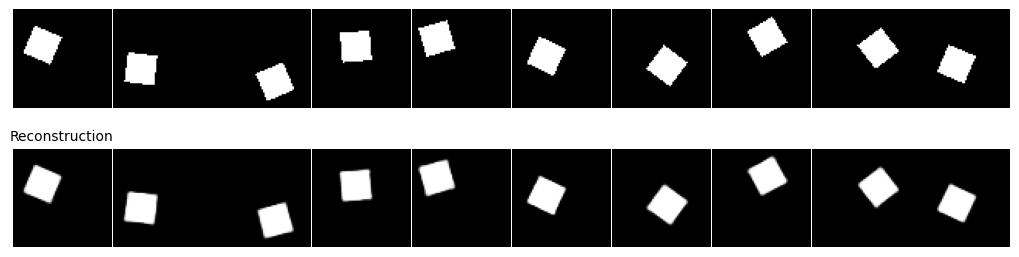

Plotting reconstructions from specific indices...


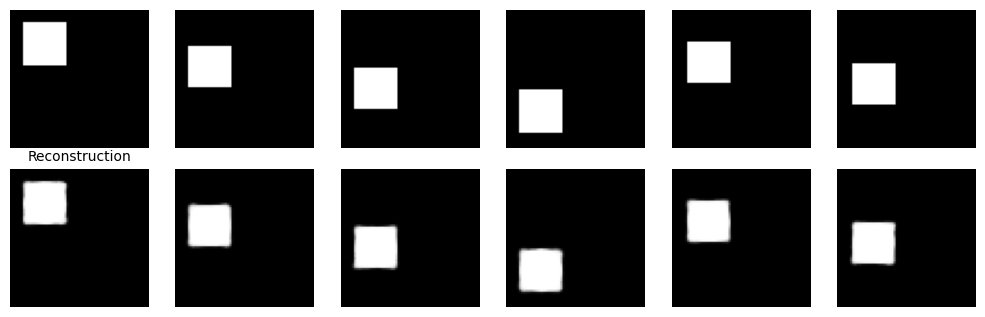

In [11]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


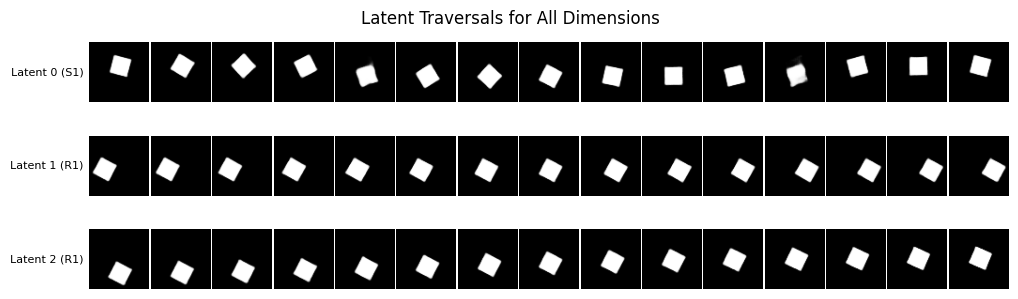

In [12]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

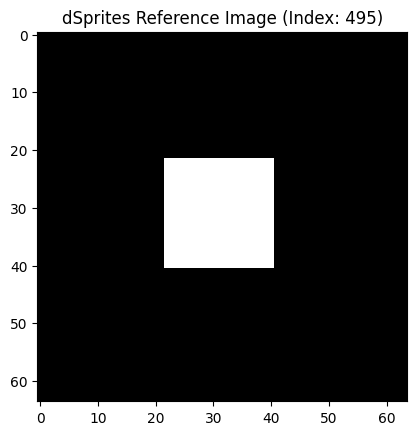

In [13]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


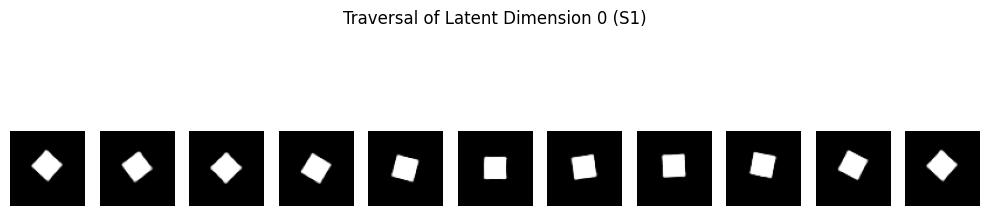

In [14]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


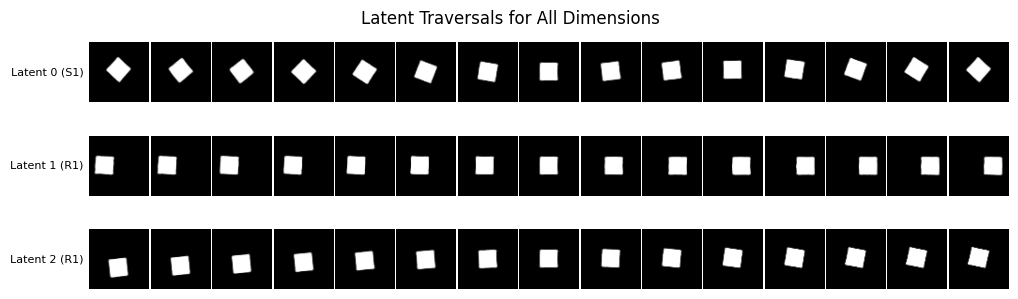

In [15]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )